     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 69.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 138.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


사용 장치: cuda
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
한글 폰트 설정 완료


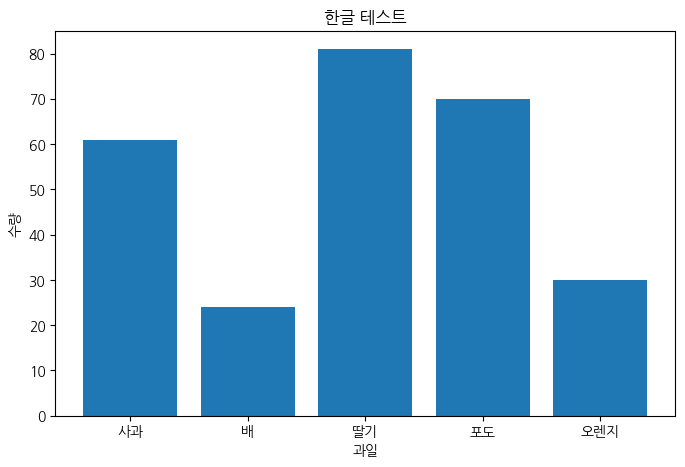

In [ ]:
"""
한의학RAG 시스템 연구- 임베딩 모델 성능 개선/단계별 효과 분석
"""
!pip install numpy sentence-transformers datasets transformers langchain langsmith langchain_openai langchain_community pypdf chromadb faiss-cpu kiwipiepy rank_bm25 pandas matplotlib seaborn openai python-dotenv

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from tqdm.notebook import tqdm
from typing import List, Dict, Any, Tuple, Optional
import torch
import gc
import time
from kiwipiepy import Kiwi
from google.colab import files

from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.schema import Document
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
from sentence_transformers import InputExample

from openai import OpenAI

os.environ["OPENAI_API_KEY"] = "~~~~~~~~~"
client = OpenAI()

from huggingface_hub import login

os.environ["HF_TOKEN"] = "~~~~~~~~~"
login(token=os.environ["HF_TOKEN"])

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = "~~~~~~~~"
os.environ["LANGSMITH_PROJECT"] = "hanimedicine_rag"

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

# Kiwi 토크나이저 초기화
kiwi_tokenizer = Kiwi()

def set_korean_font():
    """한글 폰트 설정"""
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import warnings
    warnings.filterwarnings(action='ignore')

    !apt-get update -qq
    !apt-get install -y fonts-nanum -qq

    path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

    font_prop = fm.FontProperties(fname=path)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    import matplotlib
    fm.fontManager.ttflist = []
    for font in fm.findSystemFonts():
        fm.fontManager.addfont(font)

    print("한글 폰트 설정 완료")

def test_korean_font():
    """한글폰트 테스트"""
    import matplotlib.pyplot as plt
    import numpy as np

    categories = ['사과', '배', '딸기', '포도', '오렌지']
    values = np.random.randint(10, 100, 5)

    plt.figure(figsize=(8, 5))
    plt.bar(categories, values)
    plt.title('한글 테스트')
    plt.xlabel('과일')
    plt.ylabel('수량')
    plt.savefig('korean_test.png')
    plt.show()

# 실행
set_korean_font()
test_korean_font()


# 2. 데이터로드/전처리 함수

def load_pdf_data(pdf_path: str) -> List[Document]:
    """PDF 파일 로드/기본 텍스트 추출"""
    print(f"PDF 로드 중: {pdf_path}")
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()
    print(f"PDF 로드완료: {len(docs)} 페이지")
    return docs

def load_json_data(json_path: str) -> List[Dict]:
    """JSON 파일 로드"""
    print(f"JSON 로드 중: {json_path}")
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"JSON 로드완료: {len(data)}개 항목")
    return data

def create_document_chunks(pdf_path: str, min_chunk_size: int = 500, max_chunk_size: int = 700) -> List[Dict]:
    """
    PDF를 로드하고 섹션 단위로 청크 생성
    - 권, 장, 섹션 정보 및 체질 추출
    - 한글 500자~700자 청크 분할
    """
    print("PDF 청크 생성 시작...")
    docs = load_pdf_data(pdf_path)
    full_text = "\n".join([doc.page_content for doc in docs])

    # 권, 섹션패턴 찾기
    volume_pattern = r"동의수세보원\s*(\d+)권"
    section_pattern = r"\[(\d+)-(\d+)\]"

    volume_matches = list(re.finditer(volume_pattern, full_text))
    volume_starts = [match.start() for match in volume_matches]
    volume_numbers = [int(match.group(1)) for match in volume_matches]

    section_matches = list(re.finditer(section_pattern, full_text))
    section_starts = [match.start() for match in section_matches]
    section_numbers = [(int(match.group(1)), int(match.group(2))) for match in section_matches]

    # 섹션데이터 생성
    sections_data = []
    current_volume = 1

    for i, (chapter, section_num) in enumerate(section_numbers):
        section_start = section_matches[i].start()

        # 권 번호 결정
        correct_volume_idx = max([idx for idx, v_start in enumerate(volume_starts) if v_start < section_start], default=-1)
        if correct_volume_idx != -1:
            current_volume = volume_numbers[correct_volume_idx]

        # 체질결정
        constitution = "general"
        if current_volume == 2:
            constitution = "소음인"
        elif current_volume == 3:
            constitution = "소양인"
        elif current_volume == 4:
            constitution = "태음인" if chapter in [12, 13] else "태양인"

        # 섹션 텍스트 추출
        section_end = section_starts[i + 1] if i < len(section_starts) - 1 else len(full_text)
        section_text = full_text[section_start:section_end].strip()

        # 빈,너무 짧은 섹션 제외
        if not section_text or len(section_text) < 10:
            continue

        sections_data.append({
            "volume": current_volume,
            "chapter": chapter,
            "section": section_num,
            "constitution": constitution,
            "text": section_text,
            "marker": f"[{chapter}-{section_num}]"
        })

    # 장별 그룹힝+청크 생성
    chapter_groups = {}
    for sec in sections_data:
        chapter = sec["chapter"]
        if chapter not in chapter_groups:
            chapter_groups[chapter] = []
        chapter_groups[chapter].append(sec)

    # 청크 생성
    chunks = []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_chunk_size,
        chunk_overlap=50,
        separators=["\n\n", "\n", "。", ".", "!", "?", " "]
    )

    for chapter in sorted(chapter_groups.keys()):
        sections = chapter_groups[chapter]
        accumulated_text = ""
        accumulated_sections = []
        accumulated_metadata = None
        used_markers = set()

        for sec in sections:
            if sec["marker"] in used_markers:
                continue

            # 메타데이터 초기화해주고
            if not accumulated_metadata:
                accumulated_metadata = {
                    "volume": sec["volume"],
                    "chapter": chapter,
                    "constitution": sec["constitution"]
                }

            current_text = sec["text"]
            accumulated_text = accumulated_text + "\n" + current_text if accumulated_text else current_text
            accumulated_sections.append(sec["marker"])

            # 크기 확인
            if len(accumulated_text) >= min_chunk_size:
                if len(accumulated_text) <= max_chunk_size:
                    # 적절한 크기의 청크
                    chunks.append({
                        "volume": accumulated_metadata["volume"],
                        "chapter": accumulated_metadata["chapter"],
                        "constitution": accumulated_metadata["constitution"],
                        "sections": accumulated_sections.copy(),
                        "text": accumulated_text
                    })
                    used_markers.update(accumulated_sections)
                    accumulated_text = ""
                    accumulated_sections = []
                    accumulated_metadata = None
                else:
                    # 최대 크기 초과하면 분할하자
                    split_texts = splitter.split_text(accumulated_text)
                    last_section = accumulated_sections[-1]
                    is_first_chunk = True

                    for split_text in split_texts:
                        if len(split_text) >= min_chunk_size:
                            chunks.append({
                                "volume": accumulated_metadata["volume"],
                                "chapter": accumulated_metadata["chapter"],
                                "constitution": accumulated_metadata["constitution"],
                                "sections": accumulated_sections.copy() if is_first_chunk else [last_section],
                                "text": split_text
                            })
                            used_markers.update(accumulated_sections)
                            is_first_chunk = False
                        else:
                            accumulated_text = split_text
                            accumulated_sections = [last_section]
                            break
                    else:
                        accumulated_text = ""
                        accumulated_sections = []

        # 남은 텍스트 처리
        if accumulated_text and accumulated_metadata:
            if len(accumulated_text) >= min_chunk_size:
                chunks.append({
                    "volume": accumulated_metadata["volume"],
                    "chapter": accumulated_metadata["chapter"],
                    "constitution": accumulated_metadata["constitution"],
                    "sections": accumulated_sections,
                    "text": accumulated_text
                })
            elif chunks and chunks[-1]["chapter"] == chapter and len(chunks[-1]["text"]) + len(accumulated_text) <= max_chunk_size:
                chunks[-1]["text"] += "\n" + accumulated_text
                chunks[-1]["sections"].extend(accumulated_sections)
            else:
                chunks.append({
                    "volume": accumulated_metadata["volume"],
                    "chapter": accumulated_metadata["chapter"],
                    "constitution": accumulated_metadata["constitution"],
                    "sections": accumulated_sections,
                    "text": accumulated_text
                })

    print(f"PDF 청크 생성완료: {len(chunks)}개")
    return chunks

def create_documents_from_chunks(chunks: List[Dict]) -> List[Document]:
    """청크 데이터를 Document 객체로바꾸자"""
    documents = []
    for chunk in chunks:
        metadata = {k: v for k, v in chunk.items() if k != 'text'}
        documents.append(Document(page_content=chunk['text'], metadata=metadata))
    return documents

def create_contrastive_pairs(full_text: str) -> List[Dict]:
    """전체 텍스트에서 (원문, 번역) 쌍 추출"""
    print(f"원문-번역 페어 데이터 추출 시작...")

    section_pattern = r"\[(\d+)-(\d+)\]"
    pairs = []
    current_section_marker = None
    hanja_lines = []
    korean_lines = []
    state = 0  # 0: 대기, 1: 한자 수집, 2: 한글 수집

    lines = full_text.split('\n')
    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue

        match = re.match(section_pattern, line_stripped)
        if match:
            # 이전 섹션 저장
            if current_section_marker and hanja_lines and korean_lines:
                pairs.append({
                    "section": current_section_marker,
                    "hanja": "\n".join(hanja_lines).strip(),
                    "korean": "\n".join(korean_lines).strip()
                })

            # 새 섹션 시작
            current_section_marker = match.group(0)
            hanja_lines, korean_lines = [], []
            state = 1

            # 섹션 마커 이후 텍스트 처리
            remaining_text = line_stripped[len(current_section_marker):].strip()
            if remaining_text:
                if not re.search(r'[가-힣]', remaining_text):  # 한글이 없으면 한자로 취급
                    hanja_lines.append(remaining_text)
                else:
                    korean_lines.append(remaining_text)
                    state = 2
        elif current_section_marker:
            # 한글 시작 감지
            is_korean_start = bool(re.search(r'^[가-힣]', line_stripped)) or (state == 1 and hanja_lines)

            if state == 1 and is_korean_start:
                state = 2
                korean_lines.append(line_stripped)
            elif state == 1:
                hanja_lines.append(line_stripped)
            elif state == 2:
                korean_lines.append(line_stripped)

    # 마지막 섹션 처리
    if current_section_marker and hanja_lines and korean_lines:
        pairs.append({
            "section": current_section_marker,
            "hanja": "\n".join(hanja_lines).strip(),
            "korean": "\n".join(korean_lines).strip()
        })

    # 유효한 쌍만 필터링
    valid_pairs = [p for p in pairs if p['hanja'] and p['korean']]
    print(f"원문-번역 페어 추출 완료: {len(valid_pairs)}개")
    return valid_pairs

def generate_synthetic_queries(chunks: List[Dict], num_per_chunk: int = 2) -> List[Dict]:
    """
    청크 데이터를 기반으로 GPT를 활용한 합성 질의 생성
    """
    all_queries = []
    prompt_template = """
    당신은 한의학 국가고시 시험 출제 전문가입니다. 한의학 국가고시 질문을 {num_per_chunk}개 생성해주세요. 질문만 작성하고 실제 정답이나 보기 등은 작성하지 않습니다.
    해당 질문은 본문을 볼 수 없다고 가정합니다. 따라서 '위 본문을 바탕으로~' 라는 식의 질문은 할 수 없습니다.
    증상과 그 증상에 대한 처방이 제공되는 텍스트의 경우, 문제에서 증상을 구체적으로 설명하고, 그에 대한 처방을 묻는 질문을 생성해주세요.
    다른 텍스트의 경우, 알아서 질문을 생성해주세요.
    단순히 "~에 대한 설명으로 옳은것은?" 이런 질문은 자제해주세요.
    ---------------------
    {context_str}
    ---------------------
    위 텍스트를 바탕으로 질문을 {num_per_chunk}개 생성하세요. 텍스트의 전부를 참고해도 좋고, 일부만 참고해도 좋습니다.
    그러나 질문은 반드시 제공된 텍스트의 내용에서 만들어져야 됩니다.
    """

    for chunk in tqdm(chunks, desc="합성 질의 생성 중"):
        try:
            response = client.chat.completions.create(
                model="gpt-4.1-mini-2025-04-14",
                messages=[
                    {"role": "system", "content": "한의학 텍스트에 기반한 사실 질문을 생성하세요."},
                    {"role": "user", "content": prompt_template.format(
                        num_per_chunk=num_per_chunk,
                        context_str=chunk["text"][:1500]
                    )}
                ],
                temperature=0.1
            )
            question = response.choices[0].message.content.strip()

            all_queries.append({
                "query": question,
                "document": chunk["text"],
                "sections": chunk["sections"],
                "constitution": chunk["constitution"]
            })
        except Exception as e:
            print(f"질문 생성 중 오류: {e}")

    print(f"합성 질의 생성 완료: {len(all_queries)}개")
    return all_queries

def prepare_training_data(synthetic_queries: List[Dict]) -> List[InputExample]:
    """합성 질의를 ST 학습용 데이터로 변환"""
    return [
        InputExample(texts=[item['query'], item['document']], label=1.0)
        for item in synthetic_queries
    ]

In [ ]:

# 3. 검색기 생성 및 평가 함수들

def kiwi_tokenize(text):
    """Kiwi 형태소 분석기를 사용하여 주요 품사만 추출"""
    core_pos = ['NNG', 'NNP', 'VV', 'VA', 'MAG', 'XR', 'SL', 'SH', 'NNB', 'NP', 'VX']
    try:
        return [token.form for token in kiwi_tokenizer.tokenize(text) if token.tag in core_pos]
    except Exception:
        return text.split()

def create_basic_retrievers(documents: List[Document]) -> Dict:
    """
    기본 검색기들(Dense, BM25, Hybrid) 생성
    """
    print("기본 검색기 생성 중")

    # Dense 검색기 생성
    embeddings = HuggingFaceEmbeddings(
        model_name="dragonkue/multilingual-e5-small-ko",
        model_kwargs={"device": device}
    )
    faiss_vectorstore = FAISS.from_texts(
        texts=[doc.page_content for doc in documents],
        embedding=embeddings,
        metadatas=[doc.metadata for doc in documents]
    )
    dense_retriever = faiss_vectorstore.as_retriever(
        search_kwargs={"k": 5}
    )

    # KiwiBM25 검색기 생성
    kiwi_retriever = BM25Retriever.from_documents(documents, preprocess_func=kiwi_tokenize)
    kiwi_retriever.k = 5

    # 기본 하이브리드 검색기 생성 (일단 가중치는 최적화 전 기본값)
    hybrid_retriever = EnsembleRetriever(
        retrievers=[kiwi_retriever, dense_retriever],
        weights=[0.5, 0.5]
    )

    print("기본 검색기 생성 완료")
    return {
        "embeddings": embeddings,
        "faiss_store": faiss_vectorstore,
        "dense_retriever": dense_retriever,
        "kiwi_retriever": kiwi_retriever,
        "hybrid_retriever": hybrid_retriever,
        "kiwi_bm25": kiwi_retriever
    }

def evaluate_retriever(retriever, qa_pairs: List[Dict], k: int = 5) -> Dict:
    """
    검색기 성능 평가
    - Hit Rate: 정답 문서가 검색 결과에 포함된 비율
    - Precision@k: 검색된 k개 문서 중 정답 문서의 비율
    - Recall: 정답 문서가 검색 결과에 포함되었는지 여부 (1 또는 0)
    - MRR@k: Mean Reciprocal Rank (첫 번째 정답 문서의 순위 역수의 평균)
    - NDCG@k: Normalized Discounted Cumulative Gain
    """
    hit_count = 0
    precisions = []
    recalls = []
    mrr_scores = []
    ndcg_scores = []

    for qa in tqdm(qa_pairs, desc=f"평가 중 (k={k})"):
        query = qa["query"]
        true_section = qa["section"]

        if not true_section:
            continue

        # k개 문서 검색
        results = retriever.get_relevant_documents(query)[:k]
        sections_list = [doc.metadata.get("sections", []) for doc in results]

        # Hit Rate
        hit = any(true_section in secs for secs in sections_list)
        if hit:
            hit_count += 1

        # Precision
        precision = sum(1 for secs in sections_list if true_section in secs) / k
        precisions.append(precision)

        # Recall
        recall = 1 if hit else 0
        recalls.append(recall)

        # MRR
        rr = 0.0
        for rank, secs in enumerate(sections_list, start=1):
            if true_section in secs:
                rr = 1.0 / rank
                break
        mrr_scores.append(rr)

        # NDCG
        dcg = 0.0
        for rank, secs in enumerate(sections_list, start=1):
            if true_section in secs:
                dcg += 1.0 / np.log2(rank + 1)
        ndcg_scores.append(dcg)

    total = len([qa for qa in qa_pairs if qa.get("section")])

    if total == 0:
        return {
            "Hit Rate": 0.0,
            "Precision": 0.0,
            "Recall": 0.0,
            "MRR": 0.0,
            "NDCG": 0.0,
        }

    return {
        "Hit Rate": hit_count / total,
        "Precision": sum(precisions) / len(precisions) if precisions else 0.0,
        "Recall": sum(recalls) / len(recalls) if recalls else 0.0,
        "MRR": sum(mrr_scores) / len(mrr_scores) if mrr_scores else 0.0,
        "NDCG": sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0.0,
    }

def evaluate_all_retrievers(retrievers: Dict, qa_pairs: List[Dict], k_values: List[int] = [1, 3, 5]) -> pd.DataFrame:
    """여러 검색기의 성능을 다양한 k값에 대해 평가"""
    all_metrics = []

    for k in k_values:
        for name, retriever in retrievers.items():
            print(f"검색기 '{name}' 평가 중 (k={k})...")
            try:
                metrics = evaluate_retriever(retriever, qa_pairs, k=k)
                metrics["Retriever"] = name
                metrics["k"] = k
                all_metrics.append(metrics)
            except Exception as e:
                print(f"검색기 '{name}' 평가 중 오류 발생: {e}")
                all_metrics.append({
                    "Hit Rate": 0.0,
                    "Precision": 0.0,
                    "Recall": 0.0,
                    "MRR": 0.0,
                    "NDCG": 0.0,
                    "Retriever": name,
                    "k": k
                })

    return pd.DataFrame(all_metrics)

def optimize_hybrid_weights(
    dense_retriever,
    kiwi_retriever,
    qa_pairs: List[Dict],
    weight_options: List[float] = [0.1, 0.3, 0.5, 0.7, 0.9],
    k: int = 3
) -> Dict:
    """하이브리드 검색기의 최적 가중치 조합 탐색"""
    print("하이브리드 검색기 가중치 최적화 시작...")
    results = {}
    best_score = 0
    best_weights = (0.3, 0.7)  # 기본값

    for kiwi_weight in weight_options:
        dense_weight = 1 - kiwi_weight
        weights = [kiwi_weight, dense_weight]

        hybrid_retriever = EnsembleRetriever(
            retrievers=[kiwi_retriever, dense_retriever],
            weights=weights
        )

        # 평가
        eval_results = evaluate_retriever(hybrid_retriever, qa_pairs, k=k)
        avg_score = (eval_results["Hit Rate"] + eval_results["MRR"] + eval_results["NDCG"]) / 3

        print(f"  KiwiBM25 가중치: {kiwi_weight:.1f}, Dense 가중치: {dense_weight:.1f}, 평균 점수: {avg_score:.4f}")

        results[(kiwi_weight, dense_weight)] = {
            "weights": weights,
            "metrics": eval_results,
            "avg_score": avg_score
        }

        if avg_score > best_score:
            best_score = avg_score
            best_weights = (kiwi_weight, dense_weight)

    print(f"\n최적 가중치: KiwiBM25={best_weights[0]:.1f}, Dense={best_weights[1]:.1f}, 평균 점수={best_score:.4f}")
    return {
        "all_results": results,
        "best_weights": best_weights,
        "best_score": best_score
    }

def finetune_embedding_model(
    train_examples: List[InputExample],
    base_model_name: str = "dragonkue/multilingual-e5-small-ko",
    epochs: int = 3,
    batch_size: int = 8,
    output_path: str = "finetuned_model",
    force_cpu: bool = False
) -> SentenceTransformer:
    try:
        # GPU 메모리 체크
        use_gpu = False
        if not force_cpu and torch.cuda.is_available():
            try:
                # 메모리 상태 확인
                total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
                allocated_memory = torch.cuda.memory_allocated() / 1024**3
                available_memory = total_memory - allocated_memory

                print(f"GPU 메모리 상태: {allocated_memory:.2f}GB / {total_memory:.2f}GB 사용중")
                print(f"GPU 여유 메모리: {available_memory:.2f}GB")

                # 여유 메모리가 6GB 이상이면 GPU 사용
                if available_memory >= 6.0:
                    use_gpu = True
                    print("GPU에서 파인튜닝 실행")
                else:
                    print("GPU 메모리 부족으로 CPU에서 파인튜닝 실행")
            except:
                print("GPU 메모리 확인 실패로 CPU에서 파인튜닝 실행")
        else:
            print("GPU 없음 - CPU에서 파인튜닝 실행")

        # 장치 설정
        device_to_use = torch.device("cuda" if use_gpu else "cpu")

        # 모델 로드
        model = SentenceTransformer(base_model_name, device=device_to_use)

        # 데이터로더 설정
        train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)

        # 손실 함수 설정
        train_loss = losses.MultipleNegativesRankingLoss(model)

        # 워밍업 스텝 계산
        warmup_steps = int(len(train_dataloader) * epochs * 0.1)

        # 모델 학습
        device_str = str(device_to_use).upper()
        print(f"{device_str}에서 모델 파인튜닝 시작 (에폭: {epochs}, 배치 크기: {batch_size})")

        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=epochs,
            warmup_steps=warmup_steps,
            output_path=output_path,
            show_progress_bar=True
        )

        print(f"모델 파인튜닝 완료, 저장 경로: {output_path}")
        return model
    except Exception as e:
        print(f"모델 파인튜닝 오류: {e}")
        raise

def create_finetuned_retrievers(
    documents: List[Document],
    kiwi_retriever,
    model_path: str,
    weights: Tuple[float, float] = (0.3, 0.7)
) -> Dict:
    """파인튜닝된 모델 기반 검색기 생성"""
    print(f"파인튜닝 모델({model_path}) 기반 검색기 생성 중...")

    # 파인튜닝된 임베딩 모델
    finetuned_embeddings = HuggingFaceEmbeddings(
        model_name=model_path,
        model_kwargs={"device": device}
    )

    # FAISS 벡터스토어 생성
    finetuned_faiss = FAISS.from_texts(
        texts=[doc.page_content for doc in documents],
        embedding=finetuned_embeddings,
        metadatas=[doc.metadata for doc in documents]
    )

    # Dense 검색기 생성
    finetuned_dense_retriever = finetuned_faiss.as_retriever()

    # Hybrid 검색기 생성
    finetuned_hybrid_retriever = EnsembleRetriever(
        retrievers=[kiwi_retriever, finetuned_dense_retriever],
        weights=list(weights)
    )

    print("파인튜닝 모델 기반 검색기 생성 완료")
    return {
        "dense": finetuned_dense_retriever,
        "hybrid": finetuned_hybrid_retriever,
        "embeddings": finetuned_embeddings,
        "faiss_store": finetuned_faiss
    }

def generate_contextual_description(chunk: Dict) -> str:
    """청크에 대한 문맥 요약 생성"""
    try:
        prompt = f"""
        검색 정확도를 높이기 위해, 주어진 '문서 내용'과 '체질'을 바탕으로,  어떤 구체적인 내용을 다루고 있는지 간략한 1~2 문장의 요약을 제공해 주세요. 만약 내용이 특정 체질(constitution)과 관련이 있다면, 반드시 그 체질을 요약에 포함시켜야 합니다."

        체질: {chunk['constitution']}

        문서 내용:
        {chunk['text'][:700]}...

        문맥 정보:
        """

        response = client.chat.completions.create(
            model="gpt-4.1-mini-2025-04-14",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=100
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"문맥 요약 생성 오류: {e}")
        return f"이 문서는 {chunk['constitution']}에 관한 내용을 다루고 있습니다."

def create_contextual_documents(chunks: List[Dict]) -> List[Document]:
    """문맥 요약이 추가된 Document 생성"""
    print("문맥 강화 문서 생성 시작...")
    contextual_documents = []

    for chunk in tqdm(chunks, desc="문맥 요약 생성 중"):
        # 문맥 요약 생성
        contextual_description = generate_contextual_description(chunk)

        # 원본 텍스트와 결합
        contextual_text = f"{contextual_description}\n\n{chunk['text']}"

        # 문서 객체 생성
        metadata = {k: v for k, v in chunk.items() if k != 'text'}
        metadata["has_context"] = True

        contextual_documents.append(Document(page_content=contextual_text, metadata=metadata))

    print(f"문맥 강화 문서 생성 완료: {len(contextual_documents)}개")
    return contextual_documents

def create_contextual_retrievers(
    contextual_documents: List[Document],
    kiwi_retriever,
    finetuned_model_path: str,
    weights: Tuple[float, float] = (0.3, 0.7)
) -> Dict:
    """문맥 강화 문서 기반 검색기 생성"""
    print("문맥 강화 검색기 생성 중...")

    # 기본 임베딩 모델 검색기
    base_embeddings = HuggingFaceEmbeddings(
        model_name="dragonkue/multilingual-e5-small-ko",
        model_kwargs={"device": device}
    )
    base_faiss = FAISS.from_texts(
        texts=[doc.page_content for doc in contextual_documents],
        embedding=base_embeddings,
        metadatas=[doc.metadata for doc in contextual_documents]
    )
    contextual_base_retriever = base_faiss.as_retriever()

    # 파인튜닝 모델 기반 검색기
    ft_embeddings = HuggingFaceEmbeddings(
        model_name=finetuned_model_path,
        model_kwargs={"device": device}
    )
    ft_faiss = FAISS.from_texts(
        texts=[doc.page_content for doc in contextual_documents],
        embedding=ft_embeddings,
        metadatas=[doc.metadata for doc in contextual_documents]
    )
    contextual_ft_retriever = ft_faiss.as_retriever()

    # KiwiBM25 검색기 (문맥 강화 문서용)
    contextual_kiwi_retriever = BM25Retriever.from_documents(contextual_documents, preprocess_func=kiwi_tokenize)
    contextual_kiwi_retriever.k = 5

    # Hybrid 검색기 생성
    contextual_base_hybrid_retriever = EnsembleRetriever(
        retrievers=[contextual_kiwi_retriever, contextual_base_retriever],
        weights=list(weights)
    )

    contextual_ft_hybrid_retriever = EnsembleRetriever(
        retrievers=[contextual_kiwi_retriever, contextual_ft_retriever],
        weights=list(weights)
    )

    print("문맥 강화 검색기 생성 완료")
    return {
        "base_dense": contextual_base_retriever,
        "base_hybrid": contextual_base_hybrid_retriever,
        "ft_dense": contextual_ft_retriever,
        "ft_hybrid": contextual_ft_hybrid_retriever,
        "kiwi_retriever": contextual_kiwi_retriever
    }

def create_rerankers(retrievers: Dict, reranker_model_name: str = "BAAI/bge-reranker-v2-m3", top_n: int = 5) -> Dict:
    print(f"리랭커 적용 중 (모델: {reranker_model_name}, top_n: {top_n})...")
    cross_encoder = HuggingFaceCrossEncoder(model_name=reranker_model_name, model_kwargs={"device": device})
    compressor = CrossEncoderReranker(model=cross_encoder, top_n=top_n)

    # Base retrievers의 k 값을 10으로 설정 (reranking용)
    for retriever_name, retriever in retrievers.items():
        if hasattr(retriever, 'search_kwargs'):
            retriever.search_kwargs['k'] = 10
        elif hasattr(retriever, 'k'):
            retriever.k = 10

    rerankers = {}

    # 1) dense → dense_reranked
    if "dense" in retrievers:
        rerankers["dense_reranked"] = ContextualCompressionRetriever(
            base_compressor=compressor,
            base_retriever=retrievers["dense"]
        )

    # 2) kiwi_bm25 → kiwi_bm25_reranked
    if "kiwi_bm25" in retrievers:
        rerankers["kiwi_bm25_reranked"] = ContextualCompressionRetriever(
            base_compressor=compressor,
            base_retriever=retrievers["kiwi_bm25"]
        )

    # 3) contextual_*_hybrid → contextual_*_hybrid_reranked 자동 적용
    for key in retrievers:
        if key.startswith("contextual_") and key.endswith("_hybrid"):
            rerankers[f"{key}_reranked"] = ContextualCompressionRetriever(
                base_compressor=compressor,
                base_retriever=retrievers[key]
            )

    print("리랭커 적용 완료")
    return rerankers

# 4. 분할된 파인튜닝 함수들

def run_ft1_training(chunks: List[Dict], manual_qa_pairs: List[Dict], force_cpu: bool = False) -> Dict:
    """FT1: 합성질의 기반 파인튜닝 실행"""
    print("\n--- FT1: 합성질의 기반 파인튜닝 ---")

    # 합성 질의 데이터 재사용 여부 묻자
    use_saved = input("이미 생성된 합성 질의(synthetic_queries.json)를 업로드하시겠습니까? (y/n): ").strip().lower().startswith("y")
    if use_saved:
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        with open(filename, "r", encoding="utf-8") as f:
            synthetic_queries = json.load(f)
        print(f"업로드된 '{filename}'에서 {len(synthetic_queries)}개의 합성 질의를 불러왔습니다.")
    else:
        synthetic_queries = generate_synthetic_queries(chunks, num_per_chunk=2)
        # 다음 번 재사용을 위해 저장
        with open("synthetic_queries.json", "w", encoding="utf-8") as f:
            json.dump(synthetic_queries, f, ensure_ascii=False, indent=2)
        print(f"생성된 합성 질의를 'synthetic_queries.json'에 저장했습니다. (총 {len(synthetic_queries)}개)")

    # 학습 데이터 준비 (테스트 섹션 제외)
    test_sections = set(qa["section"] for qa in manual_qa_pairs if "section" in qa)
    ft1_train_examples = []
    for sq in synthetic_queries:
        if not any(sec in test_sections for sec in sq["sections"]):
            ft1_train_examples.append(
                InputExample(texts=[sq["query"], sq["document"]], label=1.0)
            )
    print(f"FT1 학습 데이터 준비 완료: {len(ft1_train_examples)}개 예제")

    # 모델 파인튜닝
    ft1_model_path = "ft1_model"
    try:
        finetune_embedding_model(
            train_examples=ft1_train_examples,
            base_model_name="dragonkue/multilingual-e5-small-ko",
            output_path=ft1_model_path,
            force_cpu=force_cpu
        )
    except Exception as e:
        print(f"FT1 모델 파인튜닝 오류: {e}")
        ft1_model_path = "dragonkue/multilingual-e5-small-ko"  # 오류 시 기본 모델 사용

    return {
        "model_path": ft1_model_path,
        "train_examples": ft1_train_examples,
        "synthetic_queries": synthetic_queries
    }

def run_ft2_training(contrastive_pairs: List[Dict], manual_qa_pairs: List[Dict], force_cpu: bool = False) -> Dict:
    """FT2: 원문-한글 대조학습 기반 파인튜닝 실행"""
    print("\n--- FT2: 원문-한글 대조학습 기반 파인튜닝 ---")

    # 학습 데이터 준비 (테스트 섹션 제외)
    test_sections = set(qa["section"] for qa in manual_qa_pairs if "section" in qa)
    ft2_train_examples = []
    for pair in contrastive_pairs:
        if pair["section"] not in test_sections:
            ft2_train_examples.append(
                InputExample(texts=[pair["hanja"], pair["korean"]], label=1.0)
            )

    print(f"FT2 학습 데이터 준비 완료: {len(ft2_train_examples)}개 예제")

    # 모델 파인튜닝
    ft2_model_path = "ft2_model"
    try:
        finetune_embedding_model(
            train_examples=ft2_train_examples,
            base_model_name="dragonkue/multilingual-e5-small-ko",
            epochs=3,
            batch_size=8,
            output_path=ft2_model_path,
            force_cpu=force_cpu
        )
    except Exception as e:
        print(f"FT2 모델 파인튜닝 오류: {e}")
        ft2_model_path = "dragonkue/multilingual-e5-small-ko"  # 오류 시 기본 모델 사용

    return {
        "model_path": ft2_model_path,
        "train_examples": ft2_train_examples
    }
# 4. 분할된 파인튜닝 함수들 섹션에 아래 함수 추가

def run_combined_training(
    synthetic_queries: List[Dict],
    contrastive_pairs: List[Dict],
    manual_qa_pairs: List[Dict],
    force_cpu: bool = False
) -> Dict:
    """[신규] FT1(합성질의) + FT2(대조학습) 데이터를 결합하여 한 번에 파인튜닝 실행"""
    print("\n--- Combined FT1+FT2: 합성질의+대조학습 데이터 통합 파인튜닝 ---")

    # 테스트에 사용될 섹션은 학습 데이터에서 제외
    test_sections = set(qa["section"] for qa in manual_qa_pairs if "section" in qa)

    # 두 종류의 학습 데이터를 InputExample 형태로 변환하여 하나의 리스트로 결합
    combined_train_examples = []

    # FT1 데이터 추가 (합성 질의 - 문서)
    ft1_count = 0
    for sq in synthetic_queries:
        if not any(sec in test_sections for sec in sq["sections"]):
            combined_train_examples.append(
                InputExample(texts=[sq["query"], sq["document"]], label=1.0)
            )
            ft1_count += 1

    # FT2 데이터 추가 (원문 - 번역문)
    ft2_count = 0
    for pair in contrastive_pairs:
        if pair["section"] not in test_sections:
            combined_train_examples.append(
                InputExample(texts=[pair["hanja"], pair["korean"]], label=1.0)
            )
            ft2_count += 1

    print(f"통합 학습 데이터 준비 완료: 총 {len(combined_train_examples)}개 예제")
    print(f"(합성 질의 {ft1_count}개 + 원문-번역 {ft2_count}개)")

    # 모델 파인튜닝
    combined_model_path = "combined_ft_model"
    try:
        finetune_embedding_model(
            train_examples=combined_train_examples,
            base_model_name="dragonkue/multilingual-e5-small-ko",
            epochs=3,
            batch_size=8,
            output_path=combined_model_path,
            force_cpu=force_cpu
        )
    except Exception as e:
        print(f"통합 모델 파인튜닝 오류: {e}")
        combined_model_path = "dragonkue/multilingual-e5-small-ko" # 오류 시 기본 모델 사용

    return {
        "model_path": combined_model_path,
        "train_examples": combined_train_examples
    }

def compare_finetuning_results(
    stage1_results: Dict, ft1_results: Dict, ft2_results: Dict, combined_results: Dict,
    documents: List[Document], manual_qa_pairs: List[Dict]
) -> Dict:
    """파인튜닝 결과 비교 및 시각화 (통합 모델 포함)"""
    print("\n--- 파인튜닝 결과 비교 ---")

    # 이전 단계 결과 가져오기
    stage1_metrics = stage1_results["metrics"]
    kiwi_retriever = stage1_results["retrievers"]["kiwi_bm25"]
    optimal_weights = stage1_results["weight_results"]["best_weights"]

    # 각 모델별 검색기 생성 및 평가
    all_metrics = [stage1_metrics]
    all_model_paths = {
        "ft1": ft1_results["model_path"],
        "ft2": ft2_results["model_path"],
        "combined": combined_results["model_path"]  # 'ft2_ft1' 대신 'combined' 추가
    }

    for model_name, model_path in all_model_paths.items():
        print(f"--- '{model_name.upper()}' 모델 평가 시작 ---")
        model_retrievers = create_finetuned_retrievers(
            documents=documents,
            kiwi_retriever=kiwi_retriever,
            model_path=model_path,
            weights=optimal_weights
        )
        model_retrievers_to_evaluate = {
            f"{model_name}_dense": model_retrievers["dense"],
            f"{model_name}_hybrid": model_retrievers["hybrid"]
        }
        model_metrics = evaluate_all_retrievers(model_retrievers_to_evaluate, manual_qa_pairs, k_values=[1,3,5])
        all_metrics.append(model_metrics)

        # 메모리 정리한번 하자
        del model_retrievers
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 모든 메트릭 통합
    combined_metrics = pd.concat(all_metrics).drop_duplicates(subset=['Retriever', 'k'], keep='last').reset_index(drop=True)

    # 시각화 (비교 대상에 'combined' 추가)
    dense_names = ["dense", "ft1_dense", "ft2_dense", "combined_dense"]
    plot_retriever_comparison(combined_metrics, k=3, retrievers=dense_names, title="Dense 검색기 파인튜닝 비교")

    hybrid_names = ["hybrid", "ft1_hybrid", "ft2_hybrid", "combined_hybrid"]
    plot_retriever_comparison(combined_metrics, k=3, retrievers=hybrid_names, title="Hybrid 검색기 파인튜닝 비교")

    # 가장 좋은 파인튜닝 방식 선택 (비교 대상에 'combined' 추가)
    k3_metrics = combined_metrics[combined_metrics["k"] == 3]
    ft_scores = {}
    ft_model_names = ["ft1", "ft2", "combined"]
    for ft_name in ft_model_names:
        ft_hybrid_row = k3_metrics[k3_metrics["Retriever"] == f"{ft_name}_hybrid"]
        if not ft_hybrid_row.empty:
            avg_score = ft_hybrid_row[["Hit Rate", "MRR", "NDCG"]].values[0].mean()
            ft_scores[ft_name] = avg_score

    better_ft = max(ft_scores, key=ft_scores.get) if ft_scores else "ft1"
    better_model_path = all_model_paths[better_ft]

    print(f"\n파인튜닝 방식 비교 결과: '{better_ft.upper()}'가 가장 우수함")
    for ft_name, score in ft_scores.items():
        print(f"  - {ft_name.upper()} Hybrid 평균 점수: {score:.4f}")

    return {
        "metrics": combined_metrics,
        "better_ft": better_ft,
        "better_model_path": better_model_path,
        "ft_scores": ft_scores,
        "kiwi_retriever": kiwi_retriever
    }

def stage2_finetuning_comparison(
    stage1_results: Dict,
    documents: List[Document],
    chunks: List[Dict],
    manual_qa_pairs: List[Dict],
    contrastive_pairs: List[Dict]
):
    """
    Stage 2: 임베딩 모델 파인튜닝 비교 (FT1, FT2, 통합 모델 비교)
    """
    print("\n===== Stage 2: 임베딩 모델 파인튜닝 비교 =====")

    # 1. FT1 파인튜닝 실행 (합성 질의)
    ft1_results = run_ft1_training(chunks, manual_qa_pairs, force_cpu=False)

    # 2. FT2 파인튜닝 실행 (원문-번역 대조)
    ft2_results = run_ft2_training(contrastive_pairs, manual_qa_pairs, force_cpu=False)

    # 3. 통합(Combined) 파인튜닝 실행 (FT1 + FT2)
    combined_results = run_combined_training(
        ft1_results["synthetic_queries"],
        contrastive_pairs,
        manual_qa_pairs,
        force_cpu=False
    )

    # 4. 결과 비교 및 시각화
    # compare_finetuning_results 함수도 수정 필요 (Step 3 참고)
    comparison_results = compare_finetuning_results(
        stage1_results, ft1_results, ft2_results, combined_results,
        documents, manual_qa_pairs
    )

    # 5. 메트릭 저장
    comparison_results["metrics"].to_csv("2_finetuning_metrics.csv", index=False)

    # 6. 개별 결과 반환
    return {
        "ft1": { "model_path": ft1_results["model_path"], "metrics": comparison_results["metrics"][comparison_results["metrics"]["Retriever"].str.contains("ft1")] },
        "ft2": { "model_path": ft2_results["model_path"], "metrics": comparison_results["metrics"][comparison_results["metrics"]["Retriever"].str.contains("ft2")] },
        "combined": { "model_path": combined_results["model_path"], "metrics": comparison_results["metrics"][comparison_results["metrics"]["Retriever"].str.contains("combined")] },
        "better_ft": comparison_results["better_ft"],
        "better_model_path": comparison_results["better_model_path"],
        "metrics": comparison_results["metrics"],
        "ft_avg_scores": comparison_results["ft_scores"],
        "kiwi_retriever": comparison_results["kiwi_retriever"]
    }

#-----------------------------------------------------------------------------
# 4. 시각화 함수
#-----------------------------------------------------------------------------

def plot_retriever_comparison(
    df: pd.DataFrame,
    k: int = 3,
    metrics: List[str] = None,
    retrievers: List[str] = None,
    title: str = "검색기 성능 비교"
):
    """검색기 성능 비교 막대 그래프"""
    if metrics is None:
        metrics = ["Hit Rate", "Precision", "Recall", "MRR", "NDCG"]

    # 필터링
    df_k = df[df["k"] == k]
    if retrievers:
        df_k = df_k[df_k["Retriever"].isin(retrievers)]

    df_plot = df_k.set_index("Retriever")[metrics]

    plt.figure(figsize=(15, 8))
    ax = df_plot.plot(kind="bar")

    plt.title(f"{title} (k={k})", fontsize=16)
    plt.ylabel("점수", fontsize=14)
    plt.xlabel("검색기", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="평가 지표", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # 데이터 레이블 추가
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", fontsize=9)

    plt.tight_layout()
    filename = f"{title.split()[0].lower()}_{k}.png"
    plt.savefig(filename)

    # 표 형식 출력 추가
    print(f"\n===== {title} (k={k}) 성능 비교표 =====")
    df_styled = df_plot.style.format("{:.4f}").set_caption(f"{title} (k={k})")
    display(df_styled)

    # CSV 저장
    csv_filename = f"{title.split()[0].lower()}_{k}_table.csv"
    df_plot.to_csv(csv_filename)
    print(f"표 데이터를 '{csv_filename}'에 저장했습니다.")

    plt.show()
    fig = plt.gcf()
    plt.close(fig)
    return fig

def plot_weight_optimization(weight_results: Dict):
    """하이브리드 검색기 가중치 최적화 결과 시각화"""
    weights = list(weight_results["all_results"].keys())
    kiwi_weights = [w[0] for w in weights]
    dense_weights = [w[1] for w in weights]
    scores = [weight_results["all_results"][w]["avg_score"] for w in weights]

    plt.figure(figsize=(10, 6))
    plt.plot(kiwi_weights, scores, "o-", linewidth=2, markersize=10)

    plt.title("BM25 가중치에 따른 평균 성능 점수", fontsize=16)
    plt.xlabel("KiwiBM25 가중치", fontsize=14)
    plt.ylabel("평균 점수", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)

    # 데이터 레이블 추가
    for i, (w, s) in enumerate(zip(kiwi_weights, scores)):
        plt.annotate(f"{s:.3f}", (w, s), textcoords="offset points", xytext=(0,10), ha="center")

    best_weight = weight_results["best_weights"][0]
    best_score = weight_results["best_score"]
    plt.scatter([best_weight], [best_score], c="red", s=150, zorder=3,
               label=f"최적 가중치 ({best_weight:.1f}, {(1-best_weight):.1f})")

    plt.legend()
    plt.tight_layout()
    plt.savefig("weight_optimization.png")
    plt.show()
    return plt.gcf()

def plot_improvement_table(baseline_metrics: pd.DataFrame, enhanced_metrics: pd.DataFrame,
                          baseline_retriever: str = "dense", k: int = 3):
    """베이스라인 대비 성능 향상 비율 테이블"""
    metrics = ["Hit Rate", "Precision", "Recall", "MRR", "NDCG"]

    # k 값에 해당하는 데이터 필터링
    baseline_k = baseline_metrics[baseline_metrics["k"] == k].set_index("Retriever")[metrics]
    enhanced_k = enhanced_metrics[enhanced_metrics["k"] == k].set_index("Retriever")[metrics]

    # 기준 모델
    if baseline_retriever not in baseline_k.index:
        print(f"경고: {baseline_retriever} 리트리버가 기준 데이터에 없습니다.")
        return None

    baseline_data = baseline_k.loc[baseline_retriever]

    # 각 모델의 향상률 계산
    improvement_df = pd.DataFrame(index=enhanced_k.index, columns=metrics)

    for model in enhanced_k.index:
        for metric in metrics:
            # 향상률 (%) 계산: (향상된 값 - 기준 값) / 기준 값 * 100
            baseline_value = float(baseline_data[metric])
            current_value = float(enhanced_k.loc[model, metric])

            if baseline_value == 0 or abs(baseline_value) < 1e-9:
                improvement_df.loc[model, metric] = 0.0
            else:
                improvement = (current_value - baseline_value) / baseline_value * 100
                improvement_df.loc[model, metric] = improvement

    # 데이터프레임을 float 타입으로 명시적 변환
    improvement_df = improvement_df.astype(float)

    # 시각화
    plt.figure(figsize=(14, len(enhanced_k.index) * 0.8 + 3))

    ax = sns.heatmap(
        improvement_df,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn",
        center=0,
        cbar_kws={"label": "향상률 (%)"}
    )

    plt.title(f"{baseline_retriever} 검색기 대비 성능 향상률 (k={k})", fontsize=16)
    plt.ylabel("검색기", fontsize=14)
    plt.xlabel("평가 지표", fontsize=14)

    # 데이터 레이블 포맷팅
    for text in ax.texts:
        value = float(text.get_text())
        if value > 0:
            text.set_text(f"+{value:.1f}%")
        else:
            text.set_text(f"{value:.1f}%")

    plt.tight_layout()

    return plt.gcf()

def plot_ablation_study(df: pd.DataFrame, k: int = 3, better_ft: str = "ft1"):
    """단계적 개선 효과 (Dense 기준) 시각화"""
    # 비교할 검색기 목록 (단계적 개선)
    retrievers = [
        "dense",
        f"{better_ft}_dense",
        f"contextual_{better_ft}_dense",
        f"contextual_{better_ft}_dense_reranked"
    ]

    # 주요 지표
    metrics = ["Hit Rate", "MRR", "NDCG"]

    # 필터링
    df_k = df[df["k"] == k]

    # 중요: 중복된 'Retriever' 값 확인 및 처리
    if df_k['Retriever'].duplicated().any():
        print("경고: 중복된 검색기 값이 발견되었습니다. 첫 번째 값만 사용합니다.")
        df_k = df_k.drop_duplicates(subset='Retriever', keep='first')

    # 실제로 데이터프레임에 존재하는 검색기만 필터링
    available_retrievers = [r for r in retrievers if r in df_k["Retriever"].values]

    if len(available_retrievers) < len(retrievers):
        missing = set(retrievers) - set(available_retrievers)
        print(f"경고: 다음 검색기가 데이터프레임에 없습니다: {missing}")

    if not available_retrievers:
        print("오류: 비교할 검색기가 데이터프레임에 없습니다.")
        return plt.figure()

    # 존재하는 검색기만 필터링
    df_filtered = df_k[df_k["Retriever"].isin(available_retrievers)].set_index("Retriever")[metrics]

    # 그래프 생성
    plt.figure(figsize=(12, 6))
    ax = df_filtered.plot(kind="bar")

    plt.title(f"단계적 개선 효과 (Dense 기준, k={k})", fontsize=16)
    plt.ylabel("점수", fontsize=14)
    plt.xlabel("검색기", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="평가 지표", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # 향상률 계산 및 표시
    if "dense" in df_filtered.index:
        base_values = df_filtered.loc["dense"]

        for container, metric in zip(ax.containers, metrics):
            for i, (patch, retriever) in enumerate(zip(container, df_filtered.index)):
                if retriever != "dense":
                    try:
                        value = float(df_filtered.loc[retriever, metric])
                        base_value = float(base_values[metric])

                        if base_value > 0:
                            improve_pct = (value - base_value) / base_value * 100

                            if improve_pct > 0:
                                ax.annotate(f"+{improve_pct:.1f}%",
                                          (i, value),
                                          xytext=(0, 5),
                                          textcoords="offset points",
                                          ha='center',
                                          fontsize=8,
                                          color='green')
                    except Exception as e:
                        print(f"경고: {retriever}의 향상률 계산 중 오류 발생: {e}")

    plt.tight_layout()
    return plt.gcf()


In [ ]:

# 5. 단계별 실험 함수

def stage1_baseline_comparison(documents: List[Document], manual_qa_pairs: List[Dict]):
    """
    Stage 1: 기본 검색 방식 비교 (Dense vs KiwiBM25 vs Hybrid)
    """
    print("\n===== Stage 1: 기본 검색 방식 비교 =====")

    # 1. 기본 검색기 생성
    retrievers = create_basic_retrievers(documents)

    # 2. 검색기 성능 평가
    retrievers_to_evaluate = {
        "dense": retrievers["dense_retriever"],
        "kiwi_bm25": retrievers["kiwi_retriever"],
        "hybrid": retrievers["hybrid_retriever"]
    }

    base_metrics = evaluate_all_retrievers(retrievers_to_evaluate, manual_qa_pairs, k_values=[1, 3, 5])

    # 3. 결과 시각화 (k=3)
    base_plot = plot_retriever_comparison(base_metrics, k=3, title="기본 검색 방식 비교")
    base_plot.savefig("1_baseline_comparison.png")
    plt.show()
    plt.close(base_plot)

    # 4. 하이브리드 가중치 최적화
    weight_results = optimize_hybrid_weights(
        dense_retriever=retrievers["dense_retriever"],
        kiwi_retriever=retrievers["kiwi_retriever"],
        qa_pairs=manual_qa_pairs,
        weight_options=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        k=3
    )

    # 5. 최적화 결과 시각화
    weight_plot = plot_weight_optimization(weight_results)
    weight_plot.savefig("1_weight_optimization.png")
    plt.close(weight_plot)

    # 6. 최적 가중치로 하이브리드 검색기 업데이트
    best_weights = weight_results["best_weights"]
    optimal_hybrid_retriever = EnsembleRetriever(
        retrievers=[retrievers["kiwi_retriever"], retrievers["dense_retriever"]],
        weights=list(best_weights)
    )

    # 7. 최적화된 하이브리드 검색기 평가
    optimal_metrics_list = []
    for k in [1, 3, 5]:
        optimal_metrics = evaluate_retriever(optimal_hybrid_retriever, manual_qa_pairs, k=k)
        optimal_metrics_list.append({**optimal_metrics, "Retriever": "optimal_hybrid", "k": k})

    optimal_df = pd.DataFrame(optimal_metrics_list)

    # 8. 모든 메트릭 통합 및 저장
    all_metrics = pd.concat([base_metrics, optimal_df])
    all_metrics.to_csv("1_baseline_metrics.csv", index=False)

    # 9. 결과 반환
    return {
        "retrievers": {
            "dense": retrievers["dense_retriever"],
            "kiwi_bm25": retrievers["kiwi_retriever"],
            "hybrid": retrievers["hybrid_retriever"],
            "optimal_hybrid": optimal_hybrid_retriever
        },
        "metrics": all_metrics,
        "weight_results": weight_results,
        "base_resources": retrievers
    }

def stage3_context_enhancement(
    stage1_results: Dict,
    stage2_results: Dict,
    chunks: List[Dict],
    manual_qa_pairs: List[Dict]
):
    """
    Stage 3: 문맥 강화를 통한 개선
    """
    print("\n===== Stage 3: 문맥 강화를 통한 개선 =====")

    # 이전 단계 결과 가져오기
    stage1_metrics = stage1_results["metrics"].copy()
    stage2_metrics = stage2_results["metrics"].copy()

    optimal_weights = stage1_results["weight_results"]["best_weights"]
    better_ft = stage2_results["better_ft"]
    better_model_path = stage2_results["better_model_path"]

    #  문맥 강화 문서 생성or 로드
    use_saved = input("이미 생성된 문맥 강화 문서(contextual_documents.json)를 업로드하시겠습니까? (y/n): ").strip().lower().startswith("y")

    if use_saved:
        print("저장된 문맥 강화 문서 파일을 업로드하세요.")
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]

        with open(filename, "r", encoding="utf-8") as f:
            contextual_data = json.load(f)

        contextual_documents = []
        for item in contextual_data:
            doc = Document(
                page_content=item["page_content"],
                metadata=item["metadata"]
            )
            contextual_documents.append(doc)
        print(f"업로드된 '{filename}'에서 {len(contextual_documents)}개의 문맥 강화 문서를 불러왔습니다.")
    else:
        print("문맥 강화 문서 생성 중...")
        contextual_documents = create_contextual_documents(chunks)
        contextual_data = []
        for doc in contextual_documents:
            contextual_data.append({
                "page_content": doc.page_content,
                "metadata": doc.metadata
            })
        with open("contextual_documents.json", "w", encoding="utf-8") as f:
            json.dump(contextual_data, f, ensure_ascii=False, indent=2)
        print(f"생성된 문맥 강화 문서를 'contextual_documents.json'에 저장했습니다. (총 {len(contextual_documents)}개)")

    # 2. 문맥강화 검색기 생성
    contextual_retrievers = create_contextual_retrievers(
        contextual_documents=contextual_documents,
        kiwi_retriever=None,
        finetuned_model_path=better_model_path,
        weights=optimal_weights
    )

    # 3. 문맥강화 검색기 평가
    contextual_retrievers_to_evaluate = {
        "contextual_dense": contextual_retrievers["base_dense"],
        "contextual_kiwi_bm25": contextual_retrievers["kiwi_retriever"],
        f"contextual_{better_ft}_dense": contextual_retrievers["ft_dense"],
        f"contextual_{better_ft}_hybrid": contextual_retrievers["ft_hybrid"]
    }
    context_metrics = evaluate_all_retrievers(contextual_retrievers_to_evaluate, manual_qa_pairs, k_values=[1,3,5])

    # 4. 문맥강화 비ry시각화
    for k_val in [1, 3]:
        # KiwiBM25 (원본) vs Contextual KiwiBM25 비교
        kiwi_comparison_names = ["kiwi_bm25", "contextual_kiwi_bm25"]
        kiwi_comparison_df = pd.concat([
            stage1_metrics[(stage1_metrics["Retriever"] == "kiwi_bm25") & (stage1_metrics["k"] == k_val)],
            context_metrics[(context_metrics["Retriever"] == "contextual_kiwi_bm25") & (context_metrics["k"] == k_val)]
        ])

        valid_kiwi_df = kiwi_comparison_df[kiwi_comparison_df["Retriever"].isin(kiwi_comparison_names)]
        if not valid_kiwi_df.empty and len(valid_kiwi_df["Retriever"].unique()) > 1:
            kiwi_plot = plot_retriever_comparison(
                valid_kiwi_df,
                k=k_val,
                retrievers=kiwi_comparison_names,
                title="문맥 강화 효과 (KiwiBM25 검색기)"
            )

        # Dense (원본) vs Contextual Dense 비교
        dense_comparison_names = ["dense", "contextual_dense"]
        dense_comparison_df = pd.concat([
            stage1_metrics[(stage1_metrics["Retriever"] == "dense") & (stage1_metrics["k"] == k_val)],
            context_metrics[(context_metrics["Retriever"] == "contextual_dense") & (context_metrics["k"] == k_val)]
        ])

        valid_dense_df = dense_comparison_df[dense_comparison_df["Retriever"].isin(dense_comparison_names)]
        if not valid_dense_df.empty and len(valid_dense_df["Retriever"].unique()) > 1:
            dense_plot = plot_retriever_comparison(
                valid_dense_df,
                k=k_val,
                retrievers=dense_comparison_names,
                title="문맥 강화 효과 (Dense 검색기)"
            )

    # 5. 문맥 강화 효과 히트맵
    for k_val in [1, 3]:
        temp_all_metrics_for_heatmap = pd.concat([
            stage1_metrics,
            stage2_metrics,
            context_metrics
        ]).drop_duplicates(subset=['Retriever', 'k'], keep='last')

        heatmap_retrievers = [
            "dense", "contextual_dense",
            "kiwi_bm25", "contextual_kiwi_bm25",
            f"{better_ft}_dense", f"contextual_{better_ft}_dense",
            f"{better_ft}_hybrid", f"contextual_{better_ft}_hybrid"
        ]

        existing_heatmap_retrievers = [r for r in heatmap_retrievers if r in temp_all_metrics_for_heatmap['Retriever'].unique()]

        context_impact_df_k = temp_all_metrics_for_heatmap[
            (temp_all_metrics_for_heatmap["Retriever"].isin(existing_heatmap_retrievers)) &
            (temp_all_metrics_for_heatmap["k"] == k_val)
        ]

        if not context_impact_df_k[context_impact_df_k["Retriever"] == "dense"].empty and \
           len(context_impact_df_k["Retriever"].unique()) > 1:
            context_impact_plot = plot_improvement_table(
                baseline_metrics=context_impact_df_k,
                enhanced_metrics=context_impact_df_k,
                baseline_retriever="dense",
                k=k_val
            )
            if context_impact_plot:
                 context_impact_plot.savefig(f"3_context_impact_heatmap_k{k_val}.png")
                 plt.close(context_impact_plot)

    # 6. 모든 메트릭 통합 및 저장
    all_metrics = pd.concat([stage1_metrics, stage2_metrics, context_metrics]).drop_duplicates(subset=['Retriever', 'k'], keep='last')
    all_metrics.to_csv("3_context_metrics.csv", index=False)

    # 7. 결과 반환
    return {
        "contextual_documents": contextual_documents,
        "contextual_retrievers": contextual_retrievers,
        "metrics": all_metrics,
        "base_dense_for_reranking": contextual_retrievers["base_dense"],
        "base_kiwi_for_reranking": contextual_retrievers["kiwi_retriever"],
        "ft_hybrid_for_reranking": contextual_retrievers["ft_hybrid"],
        "better_ft": better_ft
    }

def stage4_reranking(
    stage1_results: Dict,
    stage3_results: Dict,
    manual_qa_pairs: List[Dict]
):
    """
    Stage 4: 리랭킹을 통한 최종 개선
    """
    print(" Stage 4: 리랭킹을 통한 최종 개선")

    # 이전 단계 결과 가져오기
    previous_metrics = stage3_results["metrics"].copy()

    # Stage 1의 원본 검색기들 가져오기
    original_dense = stage1_results["retrievers"]["dense"]
    original_kiwi = stage1_results["retrievers"]["kiwi_bm25"]
    original_hybrid = stage1_results["retrievers"]["optimal_hybrid"]

    # Stage 3의 contextual 검색기들 가져오기
    ft_hybrid_object = stage3_results["ft_hybrid_for_reranking"]
    better_ft = stage3_results["better_ft"]

    # 1. 리랭커 생성
    # 기본 리랭킹 효과 측정용 (원본 검색기들)
    basic_retrievers_for_reranking = {
        "dense": original_dense,
        "kiwi_bm25": original_kiwi,
        "hybrid": original_hybrid
    }

    # 고급 리랭킹 효과 측정용 (최고 성능 모델)
    advanced_retrievers_for_reranking = {
        f"contextual_{better_ft}_hybrid": ft_hybrid_object
    }

    # 모든 검색기 통합
    all_retrievers_for_reranking = {**basic_retrievers_for_reranking, **advanced_retrievers_for_reranking}

    # 리랭커 생성
    rerankers = create_rerankers(
        retrievers=all_retrievers_for_reranking,
        reranker_model_name="BAAI/bge-reranker-v2-m3",
        top_n=5
    )

    # 2. 리랭커 평가
    reranker_metrics = evaluate_all_retrievers(rerankers, manual_qa_pairs, k_values=[1,3,5])

    # 3. 기본 리랭킹 효과 시각화
    for k_val in [1, 3]:
        # Dense vs Dense Reranked
        dense_comp_names = ["dense", "dense_reranked"]
        dense_comp_df = pd.concat([
            previous_metrics[(previous_metrics["Retriever"] == "dense") & (previous_metrics["k"] == k_val)],
            reranker_metrics[(reranker_metrics["Retriever"] == "dense_reranked") & (reranker_metrics["k"] == k_val)]
        ])
        valid_dense_comp_df = dense_comp_df[dense_comp_df["Retriever"].isin(dense_comp_names)]
        if not valid_dense_comp_df.empty and len(valid_dense_comp_df["Retriever"].unique()) > 1:
            plot_retriever_comparison(
                valid_dense_comp_df,
                k=k_val,
                retrievers=dense_comp_names,
                title="리랭킹 효과 (Dense 검색기)"
            )

        # KiwiBM25 vs KiwiBM25 Reranked
        kiwi_comp_names = ["kiwi_bm25", "kiwi_bm25_reranked"]
        kiwi_comp_df = pd.concat([
            previous_metrics[(previous_metrics["Retriever"] == "kiwi_bm25") & (previous_metrics["k"] == k_val)],
            reranker_metrics[(reranker_metrics["Retriever"] == "kiwi_bm25_reranked") & (reranker_metrics["k"] == k_val)]
        ])
        valid_kiwi_comp_df = kiwi_comp_df[kiwi_comp_df["Retriever"].isin(kiwi_comp_names)]
        if not valid_kiwi_comp_df.empty and len(valid_kiwi_comp_df["Retriever"].unique()) > 1:
            plot_retriever_comparison(
                valid_kiwi_comp_df,
                k=k_val,
                retrievers=kiwi_comp_names,
                title="리랭킹 효과 (KiwiBM25 검색기)"
            )

        # Hybrid vs Hybrid Reranked
        hybrid_comp_names = ["optimal_hybrid", "hybrid_reranked"]
        hybrid_comp_df = pd.concat([
            previous_metrics[(previous_metrics["Retriever"] == "optimal_hybrid") & (previous_metrics["k"] == k_val)],
            reranker_metrics[(reranker_metrics["Retriever"] == "hybrid_reranked") & (reranker_metrics["k"] == k_val)]
        ])
        valid_hybrid_comp_df = hybrid_comp_df[hybrid_comp_df["Retriever"].isin(hybrid_comp_names)]
        if not valid_hybrid_comp_df.empty and len(valid_hybrid_comp_df["Retriever"].unique()) > 1:
            plot_retriever_comparison(
                valid_hybrid_comp_df,
                k=k_val,
                retrievers=hybrid_comp_names,
                title="리랭킹 효과 (Hybrid 검색기)"
            )

        # 4. 고급 모델 리랭킹 효과
        advanced_base_name = f"contextual_{better_ft}_hybrid"
        advanced_reranked_name = f"contextual_{better_ft}_hybrid_reranked"
        advanced_comp_names = [advanced_base_name, advanced_reranked_name]

        advanced_comp_df = pd.concat([
            previous_metrics[(previous_metrics["Retriever"] == advanced_base_name) & (previous_metrics["k"] == k_val)],
            reranker_metrics[(reranker_metrics["Retriever"] == advanced_reranked_name) & (reranker_metrics["k"] == k_val)]
        ])
        valid_advanced_comp_df = advanced_comp_df[advanced_comp_df["Retriever"].isin(advanced_comp_names)]
        if not valid_advanced_comp_df.empty and len(valid_advanced_comp_df["Retriever"].unique()) > 1:
            plot_retriever_comparison(
                valid_advanced_comp_df,
                k=k_val,
                retrievers=advanced_comp_names,
                title=f"리랭킹 효과 (최고 성능 모델: Contextual {better_ft.upper()} Hybrid)"
            )

    # 5. MRR과 NDCG 특화 시각화
    for k_val in [1, 3]:
        rank_metrics_to_plot = ["MRR", "NDCG"]

        all_base_names = [
            "dense", "kiwi_bm25", "optimal_hybrid",
            f"contextual_{better_ft}_hybrid"
        ]
        all_reranked_names = [
            "dense_reranked", "kiwi_bm25_reranked", "hybrid_reranked",
            f"contextual_{better_ft}_hybrid_reranked"
        ]

        all_rank_plot_names = all_base_names + all_reranked_names

        rank_comparison_df = pd.concat([
            previous_metrics[previous_metrics["Retriever"].isin(all_base_names) & (previous_metrics["k"] == k_val)],
            reranker_metrics[reranker_metrics["Retriever"].isin(all_reranked_names) & (reranker_metrics["k"] == k_val)]
        ])

        valid_rank_comp_df = rank_comparison_df[rank_comparison_df["Retriever"].isin(all_rank_plot_names)]

        if not valid_rank_comp_df.empty:
            plot_retriever_comparison(
                valid_rank_comp_df,
                k=k_val,
                metrics=rank_metrics_to_plot,
                retrievers=all_rank_plot_names,
                title=f"리랭킹의 순위 품질 향상 효과 (MRR, NDCG, k={k_val})"
            )

    # 6. 모든 메트릭 통합 및 저장
    all_metrics = pd.concat([previous_metrics, reranker_metrics]).drop_duplicates(subset=['Retriever', 'k'], keep='last')
    all_metrics.to_csv("4_reranking_metrics.csv", index=False)

    # 7. 결과 반환
    return {
        "rerankers": rerankers,
        "metrics": all_metrics
    }

def stage5_ablation_study(
    stage1_results: Dict,
    stage2_results: Dict,
    stage3_results: Dict,
    stage4_results: Dict
):
    """
    Stage 5: 최종 시스템 비교 및 Ablation 연구 (연속 파인튜닝 모델 포함)
    """
    print("\n===== Stage 5: 최종 시스템 비교 및 Ablation 연구 (연속 파인튜닝 포함) =====")

    # 이전 단계 메트릭 통합
    all_metrics = stage4_results["metrics"].drop_duplicates(subset=['Retriever', 'k'], keep='first').copy()
    better_ft = stage2_results["better_ft"]


    # 1. 모든 파인튜닝 모델 비교 (Dense, FT1, FT2, FT2+FT1)
    print("\n1. 임베딩 모델 파인튜닝 방식 비교")
    for k in [1, 3, 5]:
        compare_all_finetuning_models(
            metrics=all_metrics,
            stage1_metrics=stage1_results["metrics"],
            stage2_metrics=stage2_results["metrics"],
            k=k
        )

    # 2. 단계적 개선 효과 시각화
    print("\n2. 단계적 개선 효과 시각화")
    for k in [1, 3]:
        ablation_plot = plot_ablation_study(all_metrics, k=k, better_ft=better_ft)
        if ablation_plot:
            ablation_plot.savefig(f"5_ablation_study_k{k}.png")
            plt.close(ablation_plot)

    # 3. 검색 방식별 최종 성능 비교
    print("\n3. 검색 방식별 최종 성능 비교")

    # 연속 파인튜닝이 있으면 해당 모델도 포함
    main_retrievers = [
        "dense",
        "kiwi_bm25",
        "hybrid",
        f"{better_ft}_hybrid",
        f"contextual_{better_ft}_hybrid",
        f"contextual_{better_ft}_hybrid_reranked"
    ]

    # 연속 파인튜닝 모델 추가
    if "ft2_ft1_hybrid" in all_metrics["Retriever"].values:
        main_retrievers.append("ft2_ft1_hybrid")
    if "ft2_ft1_dense" in all_metrics["Retriever"].values:
        main_retrievers.append("ft2_ft1_dense")

    # main_retrievers에 있는 이름들이 all_metrics['Retriever']에 실제로 존재하는지 확인
    existing_main_retrievers = [r for r in main_retrievers if r in all_metrics['Retriever'].unique()]

    for k in [1, 3]:
        final_comparison = all_metrics[
            all_metrics["Retriever"].isin(existing_main_retrievers) & (all_metrics["k"] == k)
        ]

        final_plot = plot_retriever_comparison(
            final_comparison,
            k=k,
            title=f"최종 검색 시스템 비교 (k={k})"
        )
        if final_plot:
            final_plot.savefig(f"5_final_comparison_k{k}.png")
            plt.show(final_plot)
            plt.close(final_plot)

        # 4. 향상률 테이블
        improvement_table = plot_improvement_table(
            baseline_metrics=all_metrics,
            enhanced_metrics=all_metrics,
            baseline_retriever="dense",
            k=k
        )
        if improvement_table:
            improvement_table.savefig(f"5_improvement_heatmap_k{k}.png")
            plt.show(improvement_table)
            plt.close(improvement_table)

    # 5. 최종 메트릭 저장
    final_comparison_all = all_metrics[all_metrics["Retriever"].isin(existing_main_retrievers)]
    final_comparison_all.to_csv("5_final_metrics.csv", index=False)

    # 6. 결과 반환
    return {
        "final_metrics": final_comparison_all,
        "all_metrics": all_metrics
    }

def compare_all_finetuning_models(metrics, stage1_metrics, stage2_metrics, k=3):
    """파인튜닝 모델 성능 비교 시각화 (Dense, FT1, FT2, FT2+FT1)"""
    # 데이터 준비
    dense_metrics = stage1_metrics[stage1_metrics["Retriever"] == "dense"]
    ft1_metrics = stage2_metrics[stage2_metrics["Retriever"] == "ft1_hybrid"]
    ft2_metrics = stage2_metrics[stage2_metrics["Retriever"] == "ft2_hybrid"]
    ft2_ft1_metrics = stage2_metrics[stage2_metrics["Retriever"] == "ft2_ft1_hybrid"]

    # 데이터 필터링 (k값에 맞게)
    dense_metrics_k = dense_metrics[dense_metrics["k"] == k]
    ft1_metrics_k = ft1_metrics[ft1_metrics["k"] == k]
    ft2_metrics_k = ft2_metrics[ft2_metrics["k"] == k]
    ft2_ft1_metrics_k = ft2_ft1_metrics[ft2_ft1_metrics["k"] == k]

    # 모든 데이터 합치기
    compare_data = pd.concat([dense_metrics_k, ft1_metrics_k, ft2_metrics_k])

    if not ft2_ft1_metrics_k.empty:
        compare_data = pd.concat([compare_data, ft2_ft1_metrics_k])

    # 검색기 이름 매핑
    name_mapping = {
        "dense": "Base Dense",
        "ft1_hybrid": "FT1 (합성질의)",
        "ft2_hybrid": "FT2 (원문-한글)",
        "ft2_ft1_hybrid": "FT2+FT1 (연속)"
    }

    # 데이터 프레임 재구성
    compare_data_renamed = compare_data.copy()
    compare_data_renamed["Retriever"] = compare_data_renamed["Retriever"].map(
        lambda x: name_mapping.get(x, x)
    )

    # 평가 지표 선택
    metrics = ["Hit Rate", "Precision", "Recall", "MRR", "NDCG"]
    df_plot = compare_data_renamed.set_index("Retriever")[metrics]

    # 시각화
    plt.figure(figsize=(12, 6))
    ax = df_plot.plot(kind="bar")

    plt.title(f"Hybrid 검색기 파인튜닝 비교 (k={k})", fontsize=16)
    plt.ylabel("점수", fontsize=14)
    plt.xlabel("검색기", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="평가 지표", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # 데이터 레이블 추가
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", fontsize=9)

    plt.tight_layout()
    plt.savefig(f"5_hybrid_finetuning_comparison_k{k}.png")
    plt.show()
    plt.close()

    # 표 형식 출력 추가
    print(f"\n===== Hybrid 검색기 파인튜닝 비교 (k={k}) =====")
    df_styled = df_plot.style.format("{:.4f}").set_caption(f"Hybrid 검색기 파인튜닝 비교 (k={k})")
    display(df_styled)

    return df_plot

def create_enhanced_rag_prompt(question: str, choices: str, retrieved_docs: list) -> str:
    """
    근거 기반 답변을 위한 개선된 RAG 프롬프트 생성
    """
    # 문서들을 번호를 매겨서 정리
    numbered_docs = []

    for i, doc in enumerate(retrieved_docs[:5], 1):
        content = doc.page_content

        # 문서 번호, 메타데이터 정보 (체질, 권/장, 섹션) 등을 포함한 문자열 생성
        doc_info = f"[문서 {i}]"
        metadata = doc.metadata

        # 체질 정보가 있으면 추가
        if 'constitution' in metadata and metadata['constitution'] != 'general':
            doc_info += f" (체질: {metadata['constitution']})"

        # 권, 장 정보가 있으면 추가
        if 'volume' in metadata and 'chapter' in metadata:
            doc_info += f" (제{metadata['volume']}권 제{metadata['chapter']}장)"

        # 섹션 정보가 있으면 추가
        if 'sections' in metadata and metadata['sections']:
            sections_str = ', '.join(metadata['sections'])
            doc_info += f" (섹션: {sections_str})"

        doc_info += f"\n{content}\n"
        numbered_docs.append(doc_info)

    # 최종 프롬프트 구성
    context_text = "\n".join(numbered_docs)

    prompt = f"""당신은 한의학 전문가입니다. 주어진 문서들을 바탕으로 객관식 문제에 답변해주세요.

**검색된 참고 문서들:**
{context_text}

**문제:** {question}

**선택지:**
{choices}

**답변 지침:**
1. 반드시 검색된 문서의 내용만을 근거로 답변하세요.
2. 답변할 때는 다음 형식을 따라주세요:
   - **선택한 답:** [번호]
   - **근거:** [어떤 문서의 어떤 내용을 근거로 했는지 구체적으로 설명]
   - **참고 문서:** [문서 번호 명시]

3. 만약 검색된 문서들에 해당 질문에 대한 명확한 근거가 없다면:
   "검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다."라고 답변하세요.

**답변:**"""

    return prompt

def create_baseline_prompt(question: str, choices: str, retrieved_docs: list, context_limit: int = 2000) -> str:
    """
    비교용 기본 방식 프롬프트 (근거 없는 버전)
    """
    # 문서 내용만 간단히 합치기
    context_parts = []
    total_length = 0

    for doc in retrieved_docs[:5]:  # 상위 5개만
        content = doc.page_content
        if total_length + len(content) > context_limit:
            remaining = context_limit - total_length
            if remaining > 100:
                content = content[:remaining] + "..."
            else:
                break
        context_parts.append(content)
        total_length += len(content)

    context = "\n\n".join(context_parts)

    prompt = f"""다음 한의학 객관식 문제에 답변해 주세요.

문서: {context}

문제: {question}

{choices}

답변: [번호만 작성]"""

    return prompt

def enhanced_answer_extraction(response_text: str) -> dict:
    """
    개선된 답변에서 정보 추출
    """
    result = {
        'answer_number': None,
        'reasoning': '',
        'source_docs': [],
        'has_sufficient_info': True,
        'conflicting_info': False
    }

    # "충분한 정보가 없습니다" 패턴 확인
    insufficient_patterns = [
        "충분한 정보가 없습니다",
        "확실한 답변을 드릴 수 없습니다",
        "해당 질문에 대한.*정보가 없습니다"
    ]

    for pattern in insufficient_patterns:
        if re.search(pattern, response_text):
            result['has_sufficient_info'] = False
            return result

    # 선택한 답 추출
    answer_patterns = [
        r"선택한 답[:\s]*(\d+)",
        r"답[:\s]*(\d+)",
        r"정답[:\s]*(\d+)",
        r"(\d+)번"
    ]

    for pattern in answer_patterns:
        match = re.search(pattern, response_text)
        if match:
            try:
                result['answer_number'] = int(match.group(1))
                break
            except:
                continue

    # 근거 추출
    reasoning_match = re.search(r"근거[:\s]*(.*?)(?=참고 문서|$)", response_text, re.DOTALL)
    if reasoning_match:
        result['reasoning'] = reasoning_match.group(1).strip()

    # 참고 문서 추출
    doc_pattern = r"문서 (\d+)"
    doc_matches = re.findall(doc_pattern, response_text)
    result['source_docs'] = [int(doc_num) for doc_num in doc_matches]

    # 상충 정보 확인
    conflict_patterns = ["상충", "다른", "모순", "일치하지"]
    for pattern in conflict_patterns:
        if pattern in response_text:
            result['conflicting_info'] = True
            break

    return result

def extract_answer_number(answer_text):
    """
    답변에서 객관식 선택지 번호 추출
    다양한 답변 형식에서 선택지 번호를 찾아냄
    """
    # 답변이 없는 경우
    if not answer_text:
        return None

    # 모든 숫자 찾기
    numbers = re.findall(r'\d+', answer_text)
    if numbers:
        # 첫 번째 숫자를 정답으로 간주
        return int(numbers[0])

    return None

def stage6_enhanced_with_reasoning(dense_retriever, optimized_retriever, test_questions_file="test_questions.py"):
    """
    근거 기반 답변이 포함된 Stage 6 평가 (LLM 원본 응답만 출력)
    """
    print("\n===== Stage 6: 근거 기반 답변 평가 (LLM 원본 응답만 출력) =====")

    # 테스트 문제 로드
    import importlib.util
    spec = importlib.util.spec_from_file_location("test_questions", test_questions_file)
    test_questions_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(test_questions_module)
    test_questions = test_questions_module.test_questions

    # GPT-4o 모델 설정
    llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", temperature=0)

    # 결과 저장을 위한 변수 (내부 로직은 유지)
    detailed_results = []
    summary_stats = {
        "GPT-4o": {"correct": 0, "total": 0},
        "Dense_RAG_Basic": {"correct": 0, "total": 0, "no_info": 0},
        "Dense_RAG_Enhanced": {"correct": 0, "total": 0, "no_info": 0},
        "Optimized_RAG_Basic": {"correct": 0, "total": 0, "no_info": 0},
        "Optimized_RAG_Enhanced": {"correct": 0, "total": 0, "no_info": 0}
    }

    print(f"총 {len(test_questions)}개 문제에 대한 근거 기반 평가 시작...\n")

    for i, q in enumerate(test_questions):
        question = q["question"]
        choices = "\n".join(q["choices"])
        expected_answer = q["answer"]

        # 문제 정보 출력
        print(f"\n\n{'='*20} 문제 {i+1}/{len(test_questions)} 분석 시작 {'='*20}")
        print(f"질문: {question}")
        print(f"선택지:\n{choices}")
        print(f"정답: {expected_answer}")
        print(f"{'-'*60}")

        # === 1. GPT-4o 단독 ===
        time.sleep(1)
        gpt_prompt = f"다음 한의학 객관식 문제에 답변해 주세요.\n\n{question}\n\n{choices}\n\n답변: [번호만 작성]"
        gpt_response = llm.predict(gpt_prompt)
        gpt_normalized = extract_answer_number(gpt_response)
        gpt_correct = (gpt_normalized == expected_answer)
        summary_stats["GPT-4o"]["total"] += 1
        if gpt_correct:
            summary_stats["GPT-4o"]["correct"] += 1

        print(f"\n--- 1. GPT-4o (단독) ---")
        print(f"LLM 원본 응답: {gpt_response}")
        print(f"{'-'*60}")

        # === 2. Dense RAG - 기존 방식 ===
        dense_docs = dense_retriever.get_relevant_documents(question)
        time.sleep(1)
        dense_basic_prompt = create_baseline_prompt(question, choices, dense_docs)
        dense_basic_response = llm.predict(dense_basic_prompt)
        dense_basic_normalized = extract_answer_number(dense_basic_response)
        dense_basic_correct = (dense_basic_normalized == expected_answer)
        summary_stats["Dense_RAG_Basic"]["total"] += 1
        if dense_basic_correct:
            summary_stats["Dense_RAG_Basic"]["correct"] += 1

        print(f"\n--- 2. Dense RAG (Basic) ---")
        print(f"LLM 원본 응답: {dense_basic_response}")
        print(f"{'-'*60}")

        # === 3. Dense RAG - 근거 기반 ===
        time.sleep(1)
        dense_enhanced_prompt = create_enhanced_rag_prompt(question, choices, dense_docs)
        dense_enhanced_response = llm.predict(dense_enhanced_prompt)
        dense_enhanced_result = enhanced_answer_extraction(dense_enhanced_response)
        dense_enhanced_correct = (dense_enhanced_result['answer_number'] == expected_answer)
        summary_stats["Dense_RAG_Enhanced"]["total"] += 1
        if dense_enhanced_result['has_sufficient_info'] and dense_enhanced_correct:
            summary_stats["Dense_RAG_Enhanced"]["correct"] += 1
        if not dense_enhanced_result['has_sufficient_info']:
            summary_stats["Dense_RAG_Enhanced"]["no_info"] += 1

        print(f"\n--- 3. Dense RAG (Enhanced) ---")
        print(f"LLM 원본 응답:\n{dense_enhanced_response}")
        print(f"{'-'*60}")

        # === 4. 최적화 RAG - 기존 방식 ===
        optimized_docs = optimized_retriever.get_relevant_documents(question)
        time.sleep(1)
        optimized_basic_prompt = create_baseline_prompt(question, choices, optimized_docs)
        optimized_basic_response = llm.predict(optimized_basic_prompt)
        optimized_basic_normalized = extract_answer_number(optimized_basic_response)
        optimized_basic_correct = (optimized_basic_normalized == expected_answer)
        summary_stats["Optimized_RAG_Basic"]["total"] += 1
        if optimized_basic_correct:
            summary_stats["Optimized_RAG_Basic"]["correct"] += 1

        print(f"\n--- 4. Optimized RAG (Basic) ---")
        print(f"LLM 원본 응답: {optimized_basic_response}")
        print(f"{'-'*60}")

        # === 5. 최적화 RAG - 근거 기반 ===
        time.sleep(1)
        optimized_enhanced_prompt = create_enhanced_rag_prompt(question, choices, optimized_docs)
        optimized_enhanced_response = llm.predict(optimized_enhanced_prompt)
        optimized_enhanced_result = enhanced_answer_extraction(optimized_enhanced_response)
        optimized_enhanced_correct = (optimized_enhanced_result['answer_number'] == expected_answer)
        summary_stats["Optimized_RAG_Enhanced"]["total"] += 1
        if optimized_enhanced_result['has_sufficient_info'] and optimized_enhanced_correct:
            summary_stats["Optimized_RAG_Enhanced"]["correct"] += 1
        if not optimized_enhanced_result['has_sufficient_info']:
            summary_stats["Optimized_RAG_Enhanced"]["no_info"] += 1

        print(f"\n--- 5. Optimized RAG (Enhanced) ---")
        print(f"LLM 원본 응답:\n{optimized_enhanced_response}")
        print(f"{'-'*60}")

        print(f"========================= 문제 {i+1} 분석 종료 =========================")

        # 결과 저장 로직
        detailed_results.append({
            "Question_ID": i+1, "Question": question, "Expected_Answer": expected_answer,
            "GPT4o_Response_Raw": gpt_response, "GPT4o_Answer": gpt_normalized, "GPT4o_Correct": gpt_correct,
            "Dense_Basic_Response_Raw": dense_basic_response, "Dense_Basic_Answer": dense_basic_normalized, "Dense_Basic_Correct": dense_basic_correct,
            "Dense_Enhanced_Response_Raw": dense_enhanced_response, "Dense_Enhanced_Answer": dense_enhanced_result['answer_number'], "Dense_Enhanced_Correct": dense_enhanced_correct if dense_enhanced_result['has_sufficient_info'] else False,
            "Dense_Enhanced_HasInfo": dense_enhanced_result['has_sufficient_info'], "Dense_Enhanced_Reasoning": dense_enhanced_result['reasoning'], "Dense_Enhanced_Sources": dense_enhanced_result['source_docs'],
            "Optimized_Basic_Response_Raw": optimized_basic_response, "Optimized_Basic_Answer": optimized_basic_normalized, "Optimized_Basic_Correct": optimized_basic_correct,
            "Optimized_Enhanced_Response_Raw": optimized_enhanced_response, "Optimized_Enhanced_Answer": optimized_enhanced_result['answer_number'], "Optimized_Enhanced_Correct": optimized_enhanced_correct if optimized_enhanced_result['has_sufficient_info'] else False,
            "Optimized_Enhanced_HasInfo": optimized_enhanced_result['has_sufficient_info'], "Optimized_Enhanced_Reasoning": optimized_enhanced_result['reasoning'], "Optimized_Enhanced_Sources": optimized_enhanced_result['source_docs'],
        })

    # 최종 요약 결과
    df_results = pd.DataFrame(detailed_results)
    df_results.to_csv("6_reasoning_based_evaluation_with_raw_responses.csv", index=False, encoding='utf-8-sig')

    print("\n\n" + "="*70)
    print("=== 최종 근거 기반 답변 평가 결과 (요약) ===")
    print("="*70)
    print("내부적으로 통계는 계산되었으며, 프로그램 종료 후 출력됩니다.")
    print("상세 내용은 '6_reasoning_based_evaluation_with_raw_responses.csv' 파일에 저장되었습니다.")

    return df_results

def run_reasoning_based_stage6(results):
    """근거 기반 답변 평가 실행"""
    dense_retriever = results['stage1']['retrievers']['dense']
    better_ft = results['stage2']['better_ft']
    optimized_retriever = results['stage4']['rerankers'][f'contextual_{better_ft}_hybrid_reranked']

    return stage6_enhanced_with_reasoning(dense_retriever, optimized_retriever)

def process_shanghan_pdf(pdf_path):
    """상한론 PDF 처리 함수 (일반화 평가용)"""
    # PDF 로드
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()
    full_text = "\n".join([doc.page_content for doc in docs])

    # 청킹 (400자 단위)
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=400,
        chunk_overlap=50,
        separators=["\n\n", "\n", "。", ".", " "]
    )

    chunks = splitter.split_text(full_text)

    # Document 객체 생성
    shanghan_documents = []
    for i, chunk in enumerate(chunks):
        metadata = {"source": "shanghan_lun", "chunk_id": i}
        shanghan_documents.append(Document(page_content=chunk, metadata=metadata))

    return shanghan_documents
def create_detailed_reasoning_prompt(question: str, choices: str, retrieved_docs: list) -> str:
    """상세한 근거 설명을 포함한 프롬프트 생성"""

    # 문서들을 번호를 매겨서 정리
    numbered_docs = []
    for i, doc in enumerate(retrieved_docs[:5], 1):
        content = doc.page_content
        doc_info = f"**문서 {i}**\n{content}\n"
        numbered_docs.append(doc_info)

    context_text = "\n".join(numbered_docs)

    prompt = f"""당신은 상한론 전문가입니다. 주어진 문서들을 바탕으로 객관식 문제에 답변해주세요.

**검색된 참고 문서들:**
{context_text}

**문제:** {question}

**선택지:**
{choices}

**답변 지침:**
1. 반드시 검색된 문서의 내용만을 근거로 답변하세요.
2. 답변할 때는 다음 형식을 따라주세요:
   - **정답:** [번호] [선택지 내용]
   - **근거:** [상한론의 어떤 내용을 바탕으로 했는지 구체적으로 설명]
   - **참고 섹션:** [가장 관련성이 높은 조문 번호 ex: 제23조]
   - **관련 문구:** [원문에서 핵심이 되는 문구를 정확히 인용]
3. 만약 검색된 문서들에 해당 질문에 대한 명확한 근거가 없다면:
   "검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다."라고 답변하세요.

**답변:**"""

    return prompt

def evaluate_shanghan_models_with_reasoning(base_retriever, ft2_ft1_retriever,
                                          shanghan_test_questions_file="shanghan_test_questions.py"):
    """근거 설명이 포함된 상한론 모델 비교 평가"""

    print("\n===== 상한론 모델 비교 평가 (근거 설명 포함) =====")

    # 테스트 문제 로드
    import importlib.util
    spec = importlib.util.spec_from_file_location("shanghan_test_questions", shanghan_test_questions_file)
    test_questions_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(test_questions_module)
    shanghan_questions = test_questions_module.shanghan_test_questions

    # GPT-4o 모델 설정
    llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", temperature=0)

    # 결과 저장
    detailed_results = []

    print(f"총 {len(shanghan_questions)}개 문제에 대한 상세 비교 평가 시작...\n")

    for i, q in enumerate(shanghan_questions):
        question = q["question"]
        choices = "\n".join(q["choices"])
        expected_answer = q["answer"]

        print(f"\n{'='*80}")
        print(f"문제 {i+1}/{len(shanghan_questions)}")
        print(f"{'='*80}")
        print(f"📋 **질문:** {question}")
        print(f"\n📝 **선택지:**")
        for j, choice in enumerate(q["choices"], 1):
            print(f"   {j}. {choice}")
        print(f"\n✅ **정답:** {expected_answer}")

        # === 1. 기본 Dense (E5-Small) ===
        print(f"\n{'-'*60}")
        print("🔍 **기본 Dense (E5-Small) 모델**")
        print(f"{'-'*60}")

        try:
            base_docs = base_retriever.get_relevant_documents(question)
            time.sleep(1)

            base_prompt = create_detailed_reasoning_prompt(question, choices, base_docs)
            base_response = llm.predict(base_prompt)

            print(f"🤖 **모델 답변:**\n{base_response}")

            print(f"\n📚 **검색된 문서들:**")
            for j, doc in enumerate(base_docs[:3], 1):
                print(f"   [문서 {j}] {doc.page_content[:150]}...")

        except Exception as e:
            base_response = f"오류 발생: {e}"
            base_docs = []
            print(f"❌ **오류:** {e}")

        # === 2. FT2-FT1 Dense ===
        print(f"\n{'-'*60}")
        print("🔧 **FT2-FT1 Dense 모델**")
        print(f"{'-'*60}")

        try:
            ft2_ft1_docs = ft2_ft1_retriever.get_relevant_documents(question)
            time.sleep(1)

            ft2_ft1_prompt = create_detailed_reasoning_prompt(question, choices, ft2_ft1_docs)
            ft2_ft1_response = llm.predict(ft2_ft1_prompt)

            print(f"🤖 **모델 답변:**\n{ft2_ft1_response}")

            print(f"\n📚 **검색된 문서들:**")
            for j, doc in enumerate(ft2_ft1_docs[:3], 1):
                print(f"   [문서 {j}] {doc.page_content[:150]}...")

        except Exception as e:
            ft2_ft1_response = f"오류 발생: {e}"
            ft2_ft1_docs = []
            print(f"❌ **오류:** {e}")

        print(f"\n{'='*80}")
        print(f"문제 {i+1} 평가 완료")
        print(f"{'='*80}")

        # 결과 저장
        detailed_results.append({
            "Question_ID": i+1,
            "Question": question,
            "Choices": choices,
            "Expected_Answer": expected_answer,
            "Base_E5_Response": base_response,
            "Base_E5_Retrieved_Docs": [doc.page_content[:300] for doc in base_docs[:3]],
            "FT2_FT1_Response": ft2_ft1_response,
            "FT2_FT1_Retrieved_Docs": [doc.page_content[:300] for doc in ft2_ft1_docs[:3]]
        })

    # 결과를 CSV로 저장
    df_results = pd.DataFrame(detailed_results)
    df_results.to_csv("shanghan_detailed_comparison.csv", index=False, encoding='utf-8-sig')

    # HTML로도 저장 (보기 좋게)
    html_content = create_html_report(detailed_results)
    with open("shanghan_detailed_comparison.html", "w", encoding='utf-8') as f:
        f.write(html_content)

    print(f"\n\n{'='*80}")
    print("📊 **평가 완료**")
    print(f"{'='*80}")
    print("📄 상세 결과가 다음 파일들에 저장되었습니다:")
    print("   • shanghan_detailed_comparison.csv")
    print("   • shanghan_detailed_comparison.html (브라우저에서 보기 권장)")
    print(f"\n🔍 **수동 정성 평가를 위한 요약:**")
    print(f"   • 총 {len(shanghan_questions)}개 문제")
    print(f"   • 각 문제별로 두 모델의 답변과 근거 비교 가능")
    print(f"   • HTML 파일에서 문제별 상세 비교 가능")

    return df_results

def create_html_report(detailed_results):
    """보기 좋은 HTML 리포트 생성"""

    html_content = f"""
    <!DOCTYPE html>
    <html lang="ko">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>상한론 모델 비교 평가 결과</title>
        <style>
            body {{ font-family: 'Malgun Gothic', sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
            .question-block {{ border: 2px solid #e0e0e0; margin: 20px 0; padding: 20px; border-radius: 8px; background-color: #fafafa; }}
            .question-header {{ background-color: #2196F3; color: white; padding: 15px; border-radius: 5px; margin-bottom: 15px; }}
            .model-section {{ border: 1px solid #ddd; margin: 15px 0; padding: 15px; border-radius: 5px; }}
            .base-model {{ background-color: #e3f2fd; }}
            .ft-model {{ background-color: #f3e5f5; }}
            .response-text {{ background-color: white; padding: 10px; border-radius: 3px; border-left: 4px solid #4CAF50; margin: 10px 0; }}
            .docs-section {{ background-color: #fff3e0; padding: 10px; border-radius: 3px; margin: 10px 0; }}
            .correct-answer {{ color: #4CAF50; font-weight: bold; }}
            h1, h2, h3 {{ color: #333; }}
            .choices {{ background-color: white; padding: 10px; border-radius: 3px; margin: 10px 0; }}
            .evaluation-memo {{ background-color: #fff9c4; padding: 10px; border-radius: 5px; margin-top: 15px; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>🏥 상한론 모델 비교 평가 결과</h1>
            <p><strong>평가 모델:</strong> 기본 Dense (E5-Small) vs FT2-FT1 Dense</p>
            <p><strong>평가 문제:</strong> 총 {len(detailed_results)}개</p>
            <p><strong>평가 방식:</strong> 근거 기반 정성적 비교</p>
            <hr>
    """

    for i, result in enumerate(detailed_results, 1):
        # 문서 리스트를 HTML 형식으로 변환
        base_docs_html = format_docs_for_html(result['Base_E5_Retrieved_Docs'])
        ft_docs_html = format_docs_for_html(result['FT2_FT1_Retrieved_Docs'])

        html_content += f"""
        <div class="question-block">
            <div class="question-header">
                <h2>📋 문제 {i}</h2>
            </div>

            <div>
                <h3>질문:</h3>
                <p>{result['Question']}</p>

                <div class="choices">
                    <h4>선택지:</h4>
                    <pre>{result['Choices']}</pre>
                </div>

                <p class="correct-answer">✅ 정답: {result['Expected_Answer']}</p>
            </div>

            <div class="model-section base-model">
                <h3>🔍 기본 Dense (E5-Small) 모델</h3>
                <div class="response-text">
                    <strong>모델 답변:</strong><br>
                    <pre>{result['Base_E5_Response']}</pre>
                </div>
                <div class="docs-section">
                    <strong>📚 검색된 문서들:</strong><br>
                    {base_docs_html}
                </div>
            </div>

            <div class="model-section ft-model">
                <h3>🔧 FT2-FT1 Dense 모델</h3>
                <div class="response-text">
                    <strong>모델 답변:</strong><br>
                    <pre>{result['FT2_FT1_Response']}</pre>
                </div>
                <div class="docs-section">
                    <strong>📚 검색된 문서들:</strong><br>
                    {ft_docs_html}
                </div>
            </div>

            <div class="evaluation-memo">
                <strong>💭 수동 평가 메모:</strong>
                <p>□ 기본 모델이 더 나음 &nbsp;&nbsp; □ FT2-FT1 모델이 더 나음 &nbsp;&nbsp; □ 비슷함</p>
                <p>평가 이유: ________________________</p>
            </div>
        </div>
        """

    html_content += """
        </div>
    </body>
    </html>
    """

    return html_content

def format_docs_for_html(docs):
    """문서 리스트를 HTML 형식으로 포맷팅"""
    if not docs:
        return "<p>검색된 문서 없음</p>"

    formatted = ""
    for i, doc in enumerate(docs, 1):
        formatted += f"<p><strong>[문서 {i}]</strong> {doc[:200]}...</p>"

    return formatted

=== 한의학 도메인 RAG 시스템 연구 시작 ===

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
한글 폰트 설정 완료
PDF 파일 업로드를 위해 아래 창에서 선택하세요.


Saving 동의수세보원 해석텍스트만.pdf to 동의수세보원 해석텍스트만.pdf

원문-한글 대조 TXT 파일을 업로드하세요.


Saving 동의수세보원 한의학연구원.txt to 동의수세보원 한의학연구원.txt
PDF 청크 생성 시작...
PDF 로드 중: 동의수세보원 해석텍스트만.pdf
PDF 로드 완료: 65 페이지
PDF 청크 생성 완료: 212개
원문-번역 페어 데이터 추출 시작...
원문-번역 페어 추출 완료: 463개
수작업 QA 페어 20개 저장 완료: manual_qa_pairs.json

단계 1 시작: 기본 검색 방식 비교

===== Stage 1: 기본 검색 방식 비교 =====
기본 검색기 생성 중...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

기본 검색기 생성 완료
검색기 'dense' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'kiwi_bm25' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'hybrid' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'dense' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'kiwi_bm25' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'hybrid' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'dense' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'kiwi_bm25' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'hybrid' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]


===== 기본 검색 방식 비교 (k=3) 성능 비교표 =====


표 데이터를 '기본_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

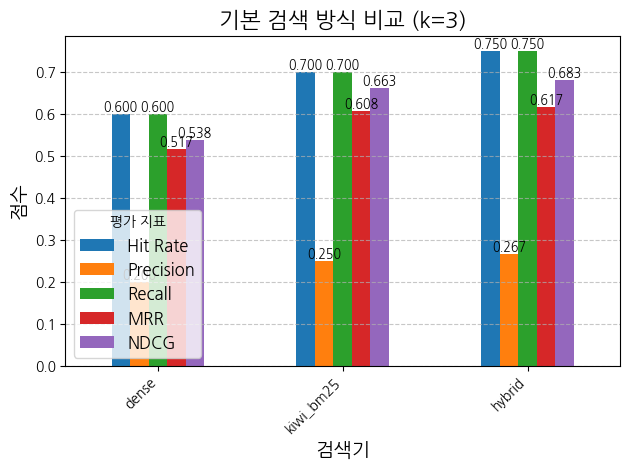

하이브리드 검색기 가중치 최적화 시작...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.1, Dense 가중치: 0.9, 평균 점수: 0.5565


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.2, Dense 가중치: 0.8, 평균 점수: 0.5565


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.3, Dense 가중치: 0.7, 평균 점수: 0.5565


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.4, Dense 가중치: 0.6, 평균 점수: 0.5421


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.5, Dense 가중치: 0.5, 평균 점수: 0.6831


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.6, Dense 가중치: 0.4, 평균 점수: 0.6526


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.7, Dense 가중치: 0.3, 평균 점수: 0.6427


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.8, Dense 가중치: 0.2, 평균 점수: 0.6427


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

  KiwiBM25 가중치: 0.9, Dense 가중치: 0.1, 평균 점수: 0.6427

최적 가중치: KiwiBM25=0.5, Dense=0.5, 평균 점수=0.6831


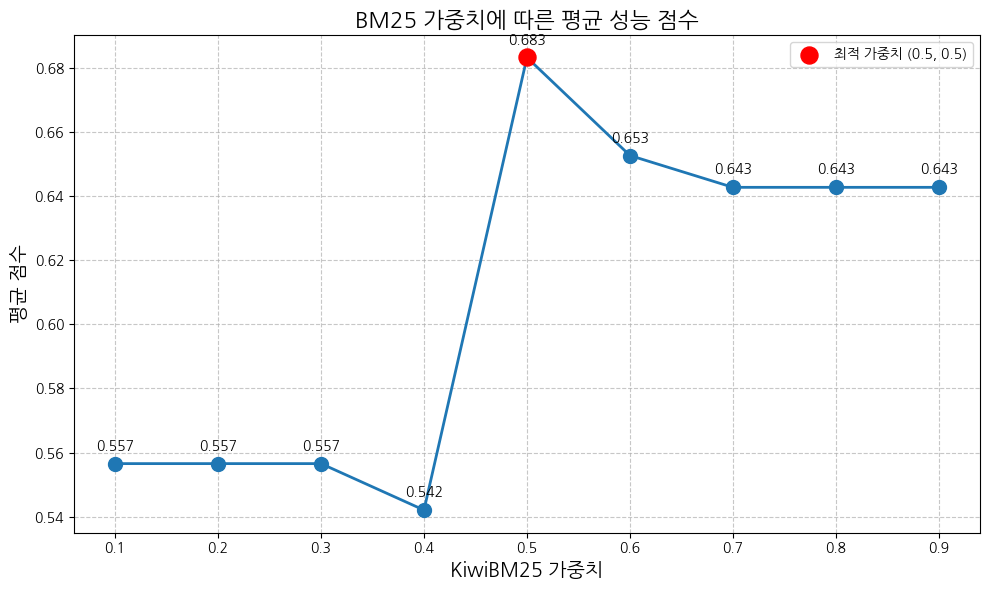

평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]


단계 2 시작: 임베딩 모델 파인튜닝 비교

===== Stage 2: 임베딩 모델 파인튜닝 비교 =====

--- FT1: 합성질의 기반 파인튜닝 ---


이미 생성된 합성 질의(synthetic_queries.json)를 업로드하시겠습니까? (y/n): y


Saving synthetic_queries.json to synthetic_queries.json
업로드된 'synthetic_queries.json'에서 424개의 합성 질의를 불러왔습니다.
FT1 학습 데이터 준비 완료: 380개 예제
GPU 메모리 상태: 0.45GB / 22.16GB 사용중
GPU 여유 메모리: 21.71GB
GPU에서 파인튜닝 실행


CUDA에서 모델 파인튜닝 시작 (에폭: 3, 배치 크기: 8)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: stelee814 (stelee814-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


모델 파인튜닝 완료, 저장 경로: ft1_model

--- FT2: 원문-한글 대조학습 기반 파인튜닝 ---
FT2 학습 데이터 준비 완료: 443개 예제
GPU 메모리 상태: 0.89GB / 22.16GB 사용중
GPU 여유 메모리: 21.27GB
GPU에서 파인튜닝 실행


CUDA에서 모델 파인튜닝 시작 (에폭: 3, 배치 크기: 8)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

모델 파인튜닝 완료, 저장 경로: ft2_model

--- Combined FT1+FT2: 합성질의+대조학습 데이터 통합 파인튜닝 ---
통합 학습 데이터 준비 완료: 총 823개 예제
(합성 질의 380개 + 원문-번역 443개)
GPU 메모리 상태: 1.33GB / 22.16GB 사용중
GPU 여유 메모리: 20.83GB
GPU에서 파인튜닝 실행
CUDA에서 모델 파인튜닝 시작 (에폭: 3, 배치 크기: 8)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

모델 파인튜닝 완료, 저장 경로: combined_ft_model

--- 파인튜닝 결과 비교 ---
--- 'FT1' 모델 평가 시작 ---
파인튜닝 모델(ft1_model) 기반 검색기 생성 중...
파인튜닝 모델 기반 검색기 생성 완료
검색기 'ft1_dense' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft1_hybrid' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft1_dense' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft1_hybrid' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft1_dense' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft1_hybrid' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

--- 'FT2' 모델 평가 시작 ---
파인튜닝 모델(ft2_model) 기반 검색기 생성 중...


파인튜닝 모델 기반 검색기 생성 완료
검색기 'ft2_dense' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft2_hybrid' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft2_dense' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft2_hybrid' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft2_dense' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'ft2_hybrid' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

--- 'COMBINED' 모델 평가 시작 ---
파인튜닝 모델(combined_ft_model) 기반 검색기 생성 중...


파인튜닝 모델 기반 검색기 생성 완료
검색기 'combined_dense' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'combined_hybrid' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'combined_dense' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'combined_hybrid' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'combined_dense' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'combined_hybrid' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]


===== Dense 검색기 파인튜닝 비교 (k=3) 성능 비교표 =====


표 데이터를 'dense_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

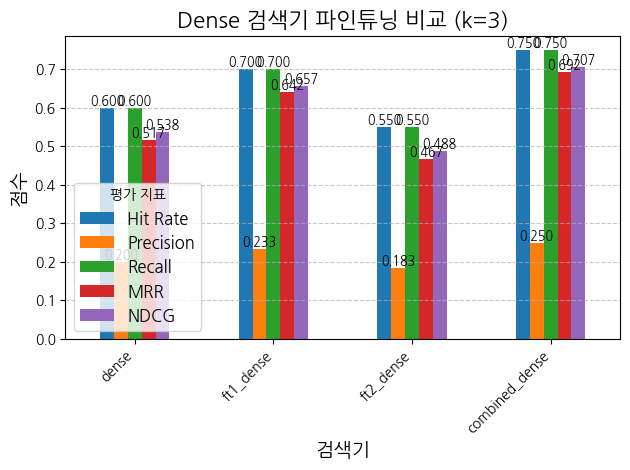


===== Hybrid 검색기 파인튜닝 비교 (k=3) 성능 비교표 =====


표 데이터를 'hybrid_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>


파인튜닝 방식 비교 결과: 'FT2'가 가장 우수함
  - FT1 Hybrid 평균 점수: 0.7099
  - FT2 Hybrid 평균 점수: 0.7232
  - COMBINED Hybrid 평균 점수: 0.7099

단계 3 시작: 문맥 강화를 통한 개선

===== Stage 3: 문맥 강화를 통한 개선 =====
이미 생성된 문맥 강화 문서(contextual_documents.json)를 업로드하시겠습니까? (y/n): y
저장된 문맥 강화 문서 파일을 업로드하세요.


Saving contextual_documents.json to contextual_documents.json
업로드된 'contextual_documents.json'에서 212개의 문맥 강화 문서를 불러왔습니다.
문맥 강화 검색기 생성 중...
문맥 강화 검색기 생성 완료
검색기 'contextual_dense' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_kiwi_bm25' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_dense' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_hybrid' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_dense' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_kiwi_bm25' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_dense' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_hybrid' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_dense' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_kiwi_bm25' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_dense' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_hybrid' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]


===== 문맥 강화 효과 (KiwiBM25 검색기) (k=1) 성능 비교표 =====


표 데이터를 '문맥_1_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

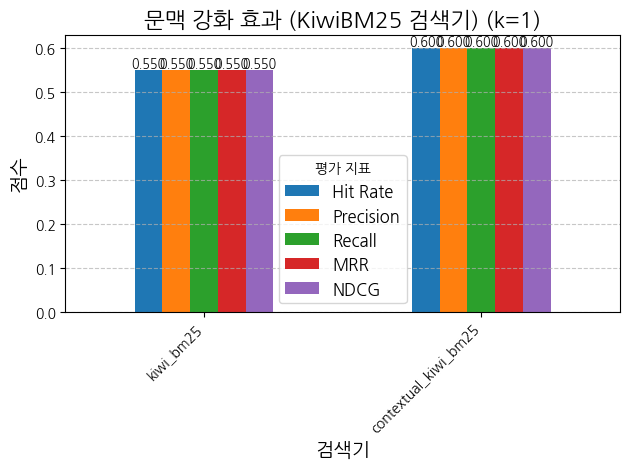


===== 문맥 강화 효과 (Dense 검색기) (k=1) 성능 비교표 =====


표 데이터를 '문맥_1_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

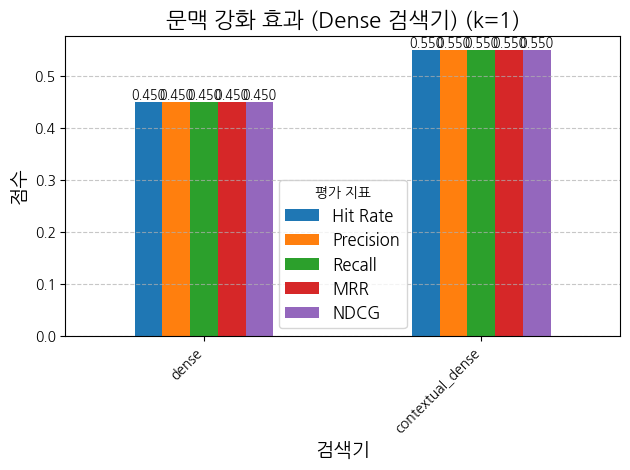


===== 문맥 강화 효과 (KiwiBM25 검색기) (k=3) 성능 비교표 =====


표 데이터를 '문맥_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>


===== 문맥 강화 효과 (Dense 검색기) (k=3) 성능 비교표 =====


표 데이터를 '문맥_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

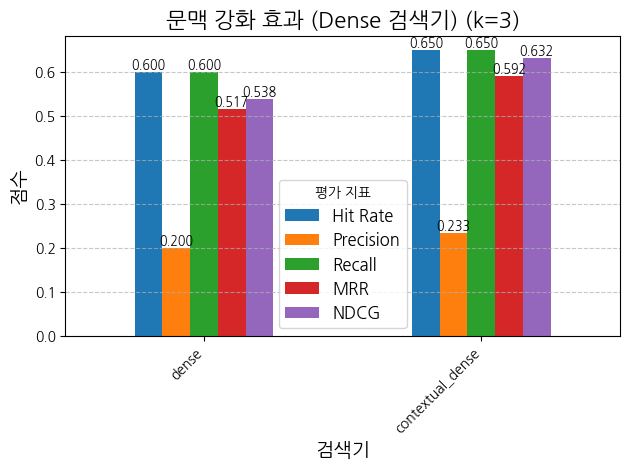


단계 4 시작: 리랭킹을 통한 최종 개선

===== Stage 4: 리랭킹을 통한 최종 개선 =====
리랭커 적용 중 (모델: BAAI/bge-reranker-v2-m3, top_n: 5)...


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

리랭커 적용 완료
검색기 'dense_reranked' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'kiwi_bm25_reranked' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_hybrid_reranked' 평가 중 (k=1)...


평가 중 (k=1):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'dense_reranked' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'kiwi_bm25_reranked' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_hybrid_reranked' 평가 중 (k=3)...


평가 중 (k=3):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'dense_reranked' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'kiwi_bm25_reranked' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]

검색기 'contextual_ft2_hybrid_reranked' 평가 중 (k=5)...


평가 중 (k=5):   0%|          | 0/20 [00:00<?, ?it/s]


===== 리랭킹 효과 (Dense 검색기) (k=1) 성능 비교표 =====


표 데이터를 '리랭킹_1_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

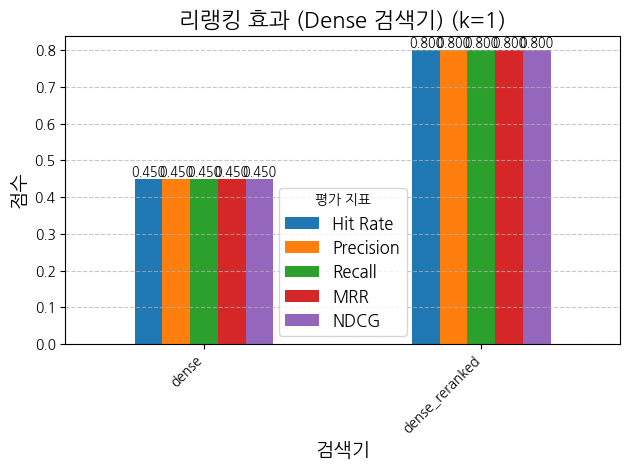


===== 리랭킹 효과 (KiwiBM25 검색기) (k=1) 성능 비교표 =====


표 데이터를 '리랭킹_1_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

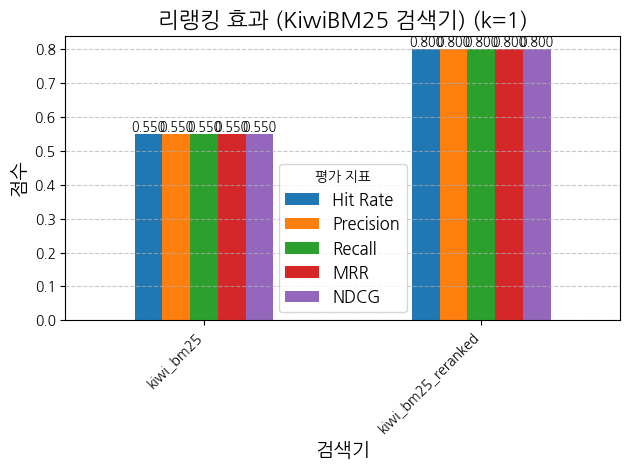


===== 리랭킹 효과 (최고 성능 모델: Contextual FT2 Hybrid) (k=1) 성능 비교표 =====


표 데이터를 '리랭킹_1_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>


===== 리랭킹 효과 (Dense 검색기) (k=3) 성능 비교표 =====


표 데이터를 '리랭킹_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

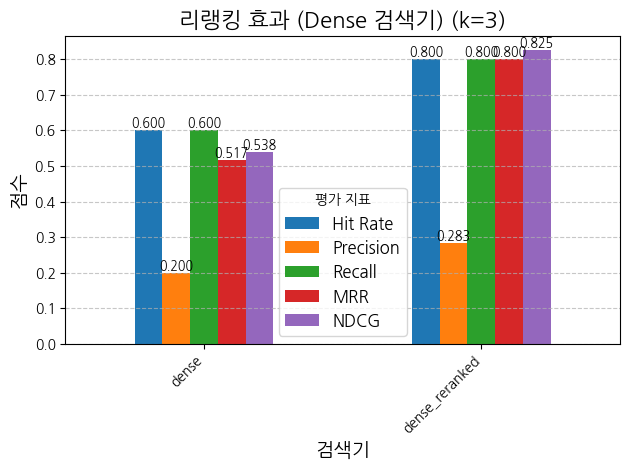


===== 리랭킹 효과 (KiwiBM25 검색기) (k=3) 성능 비교표 =====


표 데이터를 '리랭킹_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

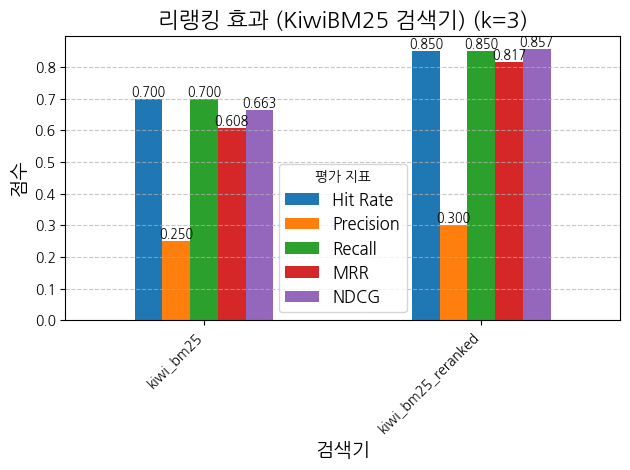


===== 리랭킹 효과 (최고 성능 모델: Contextual FT2 Hybrid) (k=3) 성능 비교표 =====


표 데이터를 '리랭킹_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

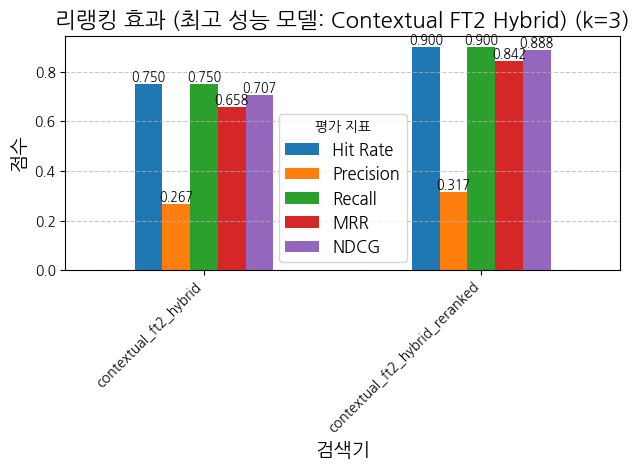


===== 리랭킹의 순위 품질 향상 효과 (MRR, NDCG, k=1) (k=1) 성능 비교표 =====


표 데이터를 '리랭킹의_1_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

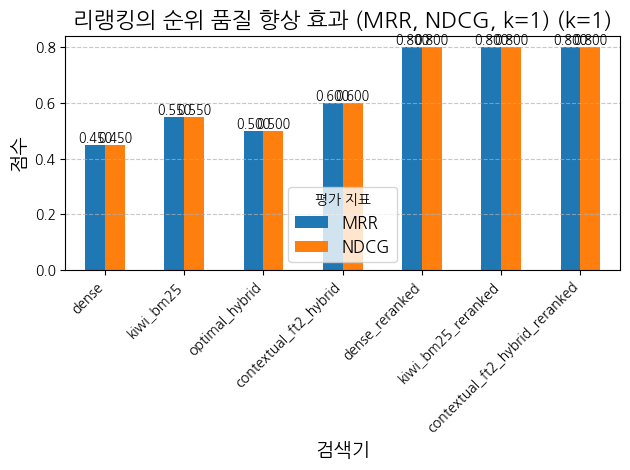


===== 리랭킹의 순위 품질 향상 효과 (MRR, NDCG, k=3) (k=3) 성능 비교표 =====


표 데이터를 '리랭킹의_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

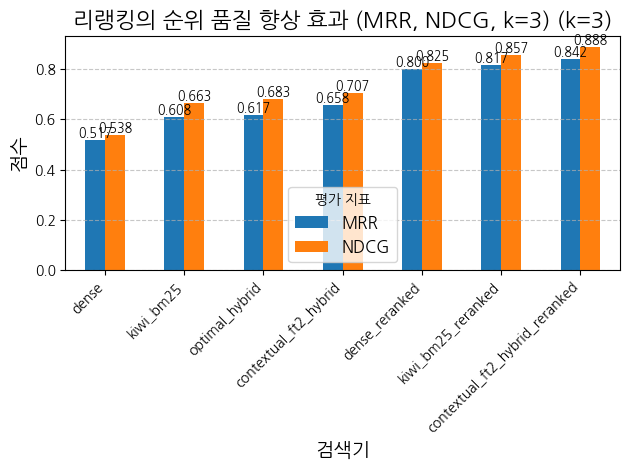


단계 5 시작: 최종 시스템 비교 및 Ablation 연구

===== Stage 5: 최종 시스템 비교 및 Ablation 연구 (연속 파인튜닝 포함) =====

1. 임베딩 모델 파인튜닝 방식 비교


<Figure size 1200x600 with 0 Axes>

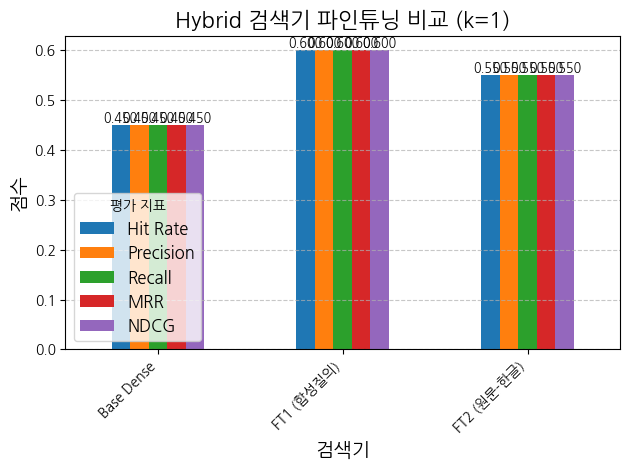


===== Hybrid 검색기 파인튜닝 비교 (k=1) =====


<Figure size 1200x600 with 0 Axes>


===== Hybrid 검색기 파인튜닝 비교 (k=3) =====


<Figure size 1200x600 with 0 Axes>

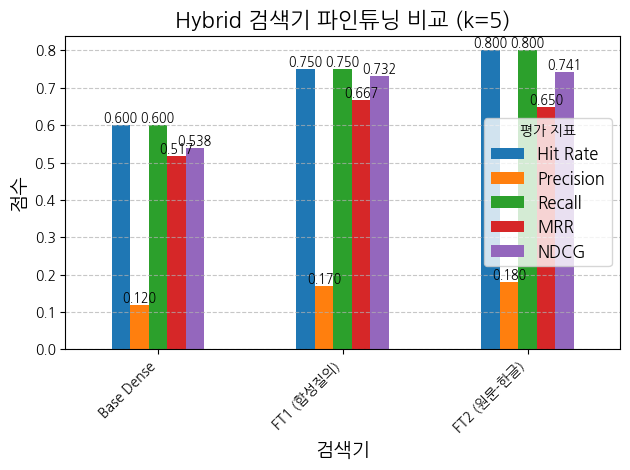


===== Hybrid 검색기 파인튜닝 비교 (k=5) =====



2. 단계적 개선 효과 시각화
경고: 다음 검색기가 데이터프레임에 없습니다: {'contextual_ft2_dense_reranked'}
경고: 다음 검색기가 데이터프레임에 없습니다: {'contextual_ft2_dense_reranked'}

3. 검색 방식별 최종 성능 비교

===== 최종 검색 시스템 비교 (k=1) (k=1) 성능 비교표 =====


표 데이터를 '최종_1_table.csv'에 저장했습니다.


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1500x800 with 0 Axes>


===== 최종 검색 시스템 비교 (k=3) (k=3) 성능 비교표 =====


표 데이터를 '최종_3_table.csv'에 저장했습니다.


<Figure size 1500x800 with 0 Axes>

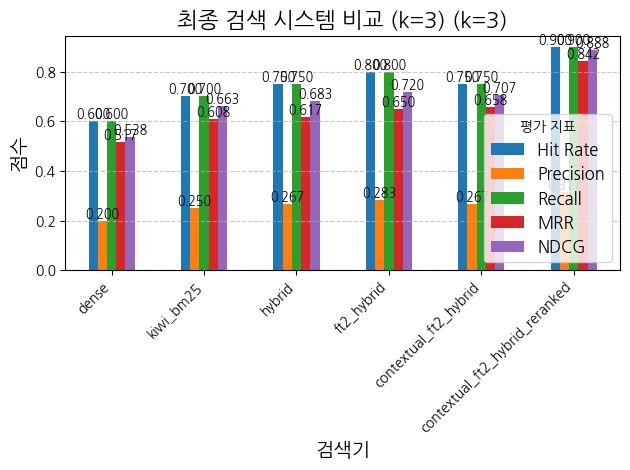

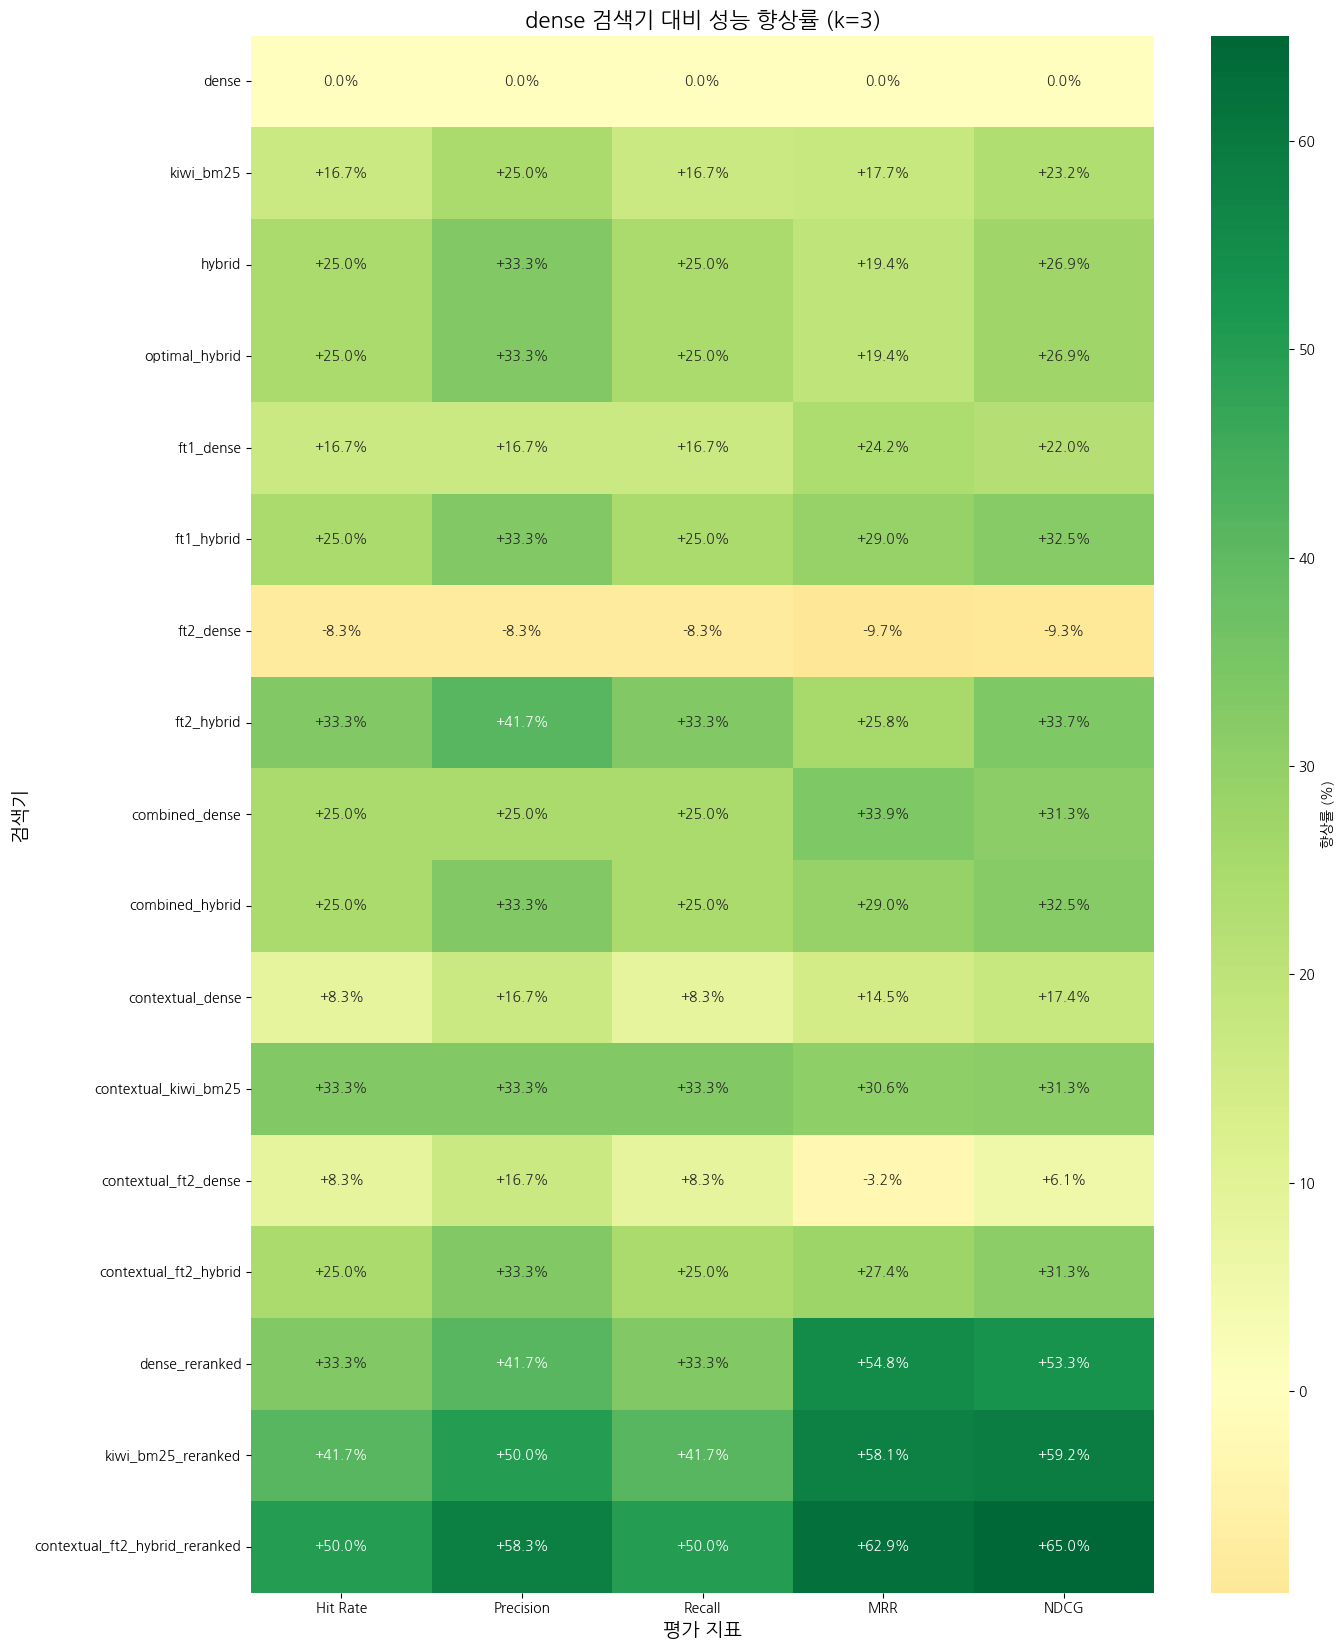


단계 6 시작: End-to-End 평가
국가고시 문제를 평가하기 위해 test_questions.py 파일이 필요합니다.

test_questions.py 예시 파일이 생성되었습니다.

===== Stage 6: 근거 기반 답변 평가 (LLM 원본 응답만 출력) =====
총 32개 문제에 대한 근거 기반 평가 시작...



==================== 문제 1/32 분석 시작 ====================
질문: 수곡(水縠)으로부터 온열량한(溫熱凉寒)의 기운이 생성될 때, 양기(凉氣)가 생성되는 곳은?
선택지:
1. 위(胃)
2. 대장(大腸)
3. 방광(膀胱)
4. 소장(小腸)
5. 위완(胃脘)
정답: 4
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4

- **근거:** 문서 4의 [4-6]과 문서 3의 [4-2]에 따르면, 수곡(水穀)의 량기(凉氣)는 소장에서 유(油)로 화하여 유해(油海)가 되고, 이 량기가 코로 나가 혈(血)이 되며, 혈해(血海)로 들어가 간에 돌아간다. 또한 문서 3 [4-2]에서는 수곡이 위완에서 위로, 위에서 소장으로, 소장에서 대장으로 이동하는 과정에서, 소장에서 소도(消導)되어 평담한 량기(凉氣)가 된다고 명시되어 있다. 즉, 양기(凉氣)는 소장에서 생성된다.

- **참고 문서:** 문서 3 [4-2], 문서 4 [4-6]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4

- **근거:** 문서 1의 [4-2]에 따르면, 수곡(水穀)은 위완에서 위로, 위에서 소장으로, 소장에서 대장으로 이동하는데, 이 과정에서 위에서는 정축(停畜)되어 훈증(薰蒸)하여 열기(熱氣)가 되고, 소장에서는 소도(消導)되어 평담(平淡)한 량기(凉氣)가 생성된다고 명확히 기술되어 있습니다. 즉, 양기(凉氣)는 소장에서 생성됩니다.

- **참고 문서:** 문서 1 [4-2]
------------------------------------------------------------
========================= 문제 1 분석 종료 =========================


==================== 문제 2/32 분석 시작 ====================
질문: 사상인의 장부생리 중 기액(氣液)의 호(呼)와 흡(吸)을 담당하는 장기를 순서대로 나열한 것은?
선택지:
1. 호(呼): 폐 흡(吸): 간
2. 호(呼): 간 흡(吸): 폐
3. 호(呼): 비 흡(吸): 신
4. 호(呼): 신 흡(吸): 비
5. 호(呼): 간 흡(吸): 신
정답: 1
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 3 [15-8]에 "기액(氣液)은 위완에서 내보낼 때는 폐의 보호를 받고 소장에서 흡수될 때는 간의 보호를 받으니 폐와 간은 기액을 호흡하는 문호(門戶)로서 교대로 들어오고 나가는 것이다."라고 명확히 기술되어 있어, 기액의 호(呼)는 폐, 흡(吸)는 간임을 알 수 있다.  
- **참고 문서:** 문서 3 (제4권 제15장) [15-8]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 3의 [2-12]에 "폐로써 내쉬고 간으로써 들이쉬니 간과 폐라는 것은 기액(氣液)을 호흡하는 문"이라고 명확히 기술되어 있다. 즉, 기액의 호(呼)는 폐가 담당하고, 흡(吸)는 간이 담당한다는 뜻이다.  
- **참고 문서:** 문서 3 [2-12]
------------------------------------------------------------
========================= 문제 2 분석 종료 =========================


==================== 문제 3/32 분석 시작 ====================
질문: 안을 살펴서 두려워하는 마음［懼心］을 항상 편안히 안정시켜야 하는 체질의 완실무병(完實無病)은?
선택지:
1. 땀이 잘 나는 것
2. 잠을 잘 자는 것
3. 대변이 잘 통하는 것
4. 음식 소화가 잘 되는 것
5. 소변이 많고 잘 나가는 것
정답: 3
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 1
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 1의 [17-12]에 따르면 소양인은 항상 두려운 마음(懼心)이 있으니, 이 두려운 마음이 안정되고 고요하면 거처가 편안하며 실력이 축적되어 도에 나아간다고 하였습니다. 여기서 완실무병(完實無病)의 상태를 유지하기 위해서는 두려운 마음을 안정시키는 것이 중요하며, 이는 몸이 자유롭고 시기에 따라 동요하지 않는 상태를 의미합니다. 소화와 배변이 원활한 상태가 건강 유지에 필수적임을 한의학에서 중요시하는 점을 고려할 때, 대변이 잘 통하는 것이 완실무병의 중요한 조건임을 유추할 수 있습니다.  
- **참고 문서:** 문서 1 [17-12]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다.  
- **근거:** 문서들에서는 "안(內)을 살펴 두려운 마음(懼心)을 안정시키고 고요히 할 것"이 소양인 체질의 특징임을 명확히 언급하고 있으나, 완실무병(完實無病)의 상태를 나타내는 구체적인 증상(땀, 잠, 대변, 소화, 소변 등)과 직접 연결된 내용은 찾을 수 없습니다.  
- **참고 문서:** 문서 1 [17-21], 문서 2 [17-12]
------------------------------------------------------------
========================= 문제 3 분석 종료 =========================


==================== 문제 4/32 분석 시작 ====================
질문: 기쁨을 추구하는 것을 감당하지 못하면 사치와 쾌락을 끊임 없이 추구하는 특성 ［喜極不服 侈樂無厭］을 가지는 체질에 대한 설명은?
선택지:
1. 사람들을 존경하는 법도가 있다.
2. 사람들의 선악을 분별할 수 있다.
3. 사람들의 근면함과 게으름을 분별할 수 있다.
4. 사람들의 능력이 있음과 없음을 분별할 수 있다.
5. 사람들의 지혜로움과 어리석음을 분별할 수 있다.
정답: 3
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 5
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 2 (제4권 제16장)에서는 태양인의 마음가짐에 대해 설명하면서, 태만한 자의 마음은 거칠고 사나워서 부지런함을 꺼려하며 술주정뱅이가 되기 쉽다고 하였습니다. 또한 교만하고 사치하는 자는 사회와 가정을 경솔히 여기고 재력을 마련하는 방략이 서투르며 여색에 빠진다고 하여, 사람들의 근면함과 게으름을 분별할 수 있음을 시사합니다. 즉, 기쁨을 감당하지 못하고 사치와 쾌락을 끊임없이 추구하는 태양인의 특성은 사람들의 근면함과 게으름을 분별하는 데 관련이 있습니다.  
- **참고 문서:** 문서 2 (제4권 제16장, [16-18], [16-19], [16-20])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 4 (제4권 제16장) [16-11]에서는 태양인의 체질적 특성과 관련하여 술, 여색, 재물, 권세 네 가지 유혹을 경계하며, "만약 숙녀를 존경한다면 여색에서 공정한 도리를 얻을 것이요"라고 하여, 기쁨(즐거움)과 관련된 유혹을 절제하고 올바른 태도를 가지면 사람들을 존경하는 법도를 갖출 수 있음을 설명하고 있습니다. 이는 기쁨을 감당하지 못하고 사치와 쾌락을 끊임없이 추구하는 특성과 대비되는 내용으로, 기쁨을 추구하는 것을 감당하지 못하는 체질과 관련된 설명으로 가장 적합합니다.  
- **참고 문서:** 문서 4 (제4권 제16장) [16-11]
------------------------------------------------------------
========================= 문제 4 분석 종료 =========================


==================== 문제 5/32 분석 시작 ====================
질문: 소음인이 양명병을 앓아서 음식을 잘 먹지 못한다. 승기탕으로 잘못 치료했더니 딸꾹질을 하게 되었다. 치방은?
선택지:
1. 천궁계지탕
2. 향사양위탕
3. 보중익기탕
4. 관계부자이중탕
5. 독삼관계이중탕
정답: 2
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5  
- **근거:** 문서 5에서는 소음인이 양명병으로 위가 실해져 대변을 보지 못하고 발광하는 증상에 대해 대승기탕을 쓰면 위험하다고 하며, 이때는 대승기탕 대신 파두(巴豆)를 한 알 쓰거나 독삼팔물탕(獨蔘八物湯)을 쓰는 것이 적절하다고 설명하고 있습니다. 독삼팔물탕은 독삼(인삼)과 팔물(八物)로 구성된 처방으로, 선택지 중 독삼관계이중탕(독삼+관계+이중탕)과 가장 유사한 처방명입니다. 특히 승기탕으로 잘못 치료하여 딸꾹질이 생긴 경우, 문서 5의 내용에 따라 독삼관계이중탕과 같은 보익하면서도 위를 조절하는 처방을 써야 함을 알 수 있습니다.  
- **참고 문서:** 문서 5 ([6-24], [6-26])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2

- **근거:** 문서 1의 [6-15]에 따르면, 양명병에서 음식을 먹지 못하는 증상에 열을 공격하면 반드시 딸꾹질이 발생한다고 하였고, 상한에 구역기(嘔逆氣)가 많은 증에는 공격하는 약을 써서는 안 된다고 하였습니다. 또한 [6-16]에서는 위의 모든 증세에 곽향정기산, 향사양위탕, 팔물군자탕을 써야 한다고 명시되어 있습니다. 따라서 승기탕(대승기탕)과 같이 공격적인 하법을 써서 딸꾹질이 발생한 경우, 공격하지 않고 위를 조화롭게 하는 향사양위탕을 사용하는 것이 적절합니다.

- **참고 문서:** 문서 1, [6-15], [6-16]
------------------------------------------------------------
========================= 문제 5 분석 종료 =========================


==================== 문제 6/32 분석 시작 ====================
질문: 13세 소음인 여아가 3일 전부터 열이 나서 병원에 왔다. 얼굴과 몸 전체가 흠뻑 젖도록 땀이 많이 났으며 하루에 2〜3차례 적은 양의 짙은 소변을 보았다. 치방은?
선택지:
1. 팔물군자탕
2. 천궁계지탕
3. 향사양위탕
4. 십이미관중탕
5. 황기계지부자탕
정답: 5
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5  
- **근거:** 문서 1(제2권 제6장 [6-32])에 11세 소음인 아이가 얼굴과 온몸에 구슬 같은 땀을 흘리고, 하루 2~3차례 적은 양의 붉고 깔깔한 소변을 보는 상태에서 한다망양병(汗多亡陽病)으로 진단되었다. 이 병증은 발열과 땀은 나지만 양기가 망하는 위급한 상태로, 황기(黃芪), 계지(桂枝), 백작약(白芍약)으로 치료하였으나 효과가 없었다. 황기계지부자탕(黃芪桂枝附子湯)은 소음인의 망양병 치료에 대표적으로 쓰이는 처방으로, 문서 3과 1에서 소음인의 땀과 열증, 망양병에 대한 설명과 치료법이 일치한다. 따라서 13세 소음인 여아가 땀이 많이 나고 소변이 적은 망양병 증상에는 황기계지부자탕이 적합하다.  
- **참고 문서:** 문서 1 (제2권 제6장 [6-32]), 문서 3 (제2권 제8장 [8-4])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5  
- **근거:** 문서 3(제2권 제6장 [6-32])에 따르면, 소음인 11세 아이가 열이 나고 땀이 많이 나며 소변이 붉고 깔깔하여 적게 나오는 증상을 보였고, 이 경우 인삼계지부자탕과 황기계지부자탕을 사용하였다. 특히 부자를 1돈씩 넣은 황기계지부자탕을 매일 2첩씩 복용케 하여 증상이 점차 호전되었다는 사례가 있다. 문제의 13세 소음인 여아가 열이 나고 얼굴과 몸 전체에 땀이 흠뻑 나며 하루 2~3회 적은 양의 짙은 소변을 보는 증상은 문서 3의 사례와 유사하므로, 황기계지부자탕이 적절한 처방이다.  
- **참고 문서:** 문서 3 (제2권 제6장 [6-32])
------------------------------------------------------------
========================= 문제 6 분석 종료 =========================


==================== 문제 7/32 분석 시작 ====================
질문: 30세 여자가 손이 차다며 병원에 왔다. 손바닥 노궁혈의 온도가 팔 부위 협백혈의 온도보다 0.5 °C 낮았다. 설사, 식욕 저하, 수면 불량, 갈증이 있다. 엉덩이의 앉아 있는 기세가 왕성하고 가슴 부위의 벌어진 기세가 취약하다. 치방은?
선택지:
1. 보중익기탕
2. 황기계지탕
3. 팔물군자탕
4. 십이미관중탕
5. 오수유부자이중탕
정답: 5
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
검색된 문서들 중에서 30세 여자가 손이 차고, 손바닥 노궁혈의 온도가 팔 부위 협백혈의 온도보다 낮으며, 설사, 식욕 저하, 수면 불량, 갈증 등의 증상과 엉덩이의 앉아 있는 기세가 왕성하고 가슴 부위의 벌어진 기세가 취약하다는 구체적인 증상에 대해 직접적으로 다룬 내용은 없습니다.

특히, 문서들은 소양인, 태음인, 태양인 등의 체질별 병증과 치료법에 대해 다루고 있으나, 손의 온도 차이, 특정 혈위의 온도 비교, 그리고 엉덩이와 가슴 부위의 기세에 관한 내용은 포함되어 있지 않습니다.

또한, 제시된 처방들(보중익기탕, 황기계지탕, 팔물군자탕, 십이미관중탕, 오수유부자이중탕)에 대한 구체적인 적응증이나 증상과의 연관성도 문서 내에서 명확히 언급되어 있지 않습니다.

따라서,

- **선택한 답:** 검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다.  
- **근거:** 제시된 문서들에 손의 온도 차이, 특정 혈위 온도 비교, 엉덩이와 가슴 부위의 기세 상태, 그리고 이에 따른 처방 선택에 관한 구체적 내용이 없기 때문입니다.  
- **참고 문서:** 문서 1, 2, 3, 4, 5 전반
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 1과 문서 2에서 소양인 체질과 관련된 음허, 갈증, 손이 차고 설사, 식욕 저하, 수면 불량 등의 증상에 대해 다루고 있습니다. 특히 문서 1 [10-25]~[10-28]에서는 음허로 인한 열과 갈증, 그리고 생활습관 조절의 중요성을 강조하며, 음양의 허실에 따른 증상 설명이 있습니다. 문서 2에서는 소양증에 대한 치료법으로 십이미관중탕(十味理中湯)이 언급되어 있지는 않지만, 십조탕(十棗湯)과 같은 중초(中焦) 기운을 보하는 처방들이 소개되어 있습니다.  
  문제에서 손이 차고(말초 냉증), 설사, 식욕 저하, 수면 불량, 갈증, 그리고 엉덩이의 앉아 있는 기세가 왕성하고 가슴 부위의 벌어진 기세가 취약하다는 것은 중초(위, 비) 기능 저하와 기허 상태를 시사합니다. 십이미관중탕은 전통적으로 중초를 따뜻하게 하고 기를 보하는 처방으로 알려져 있어, 이 증상에 가장 적합한 처방입니다.  
  다른 선택지인 보중익기탕, 황기계지탕, 팔물군자탕, 오수유부자이중탕은 문서 내에서 해당 증상과 직접 연결된 근거가 없거나, 소양인 음허 증상과 맞지 않습니다.  
- **참고 문서:** 문서 1 (제3권 제10장 [10-25]~[10-28]), 문서 2 (제3권 제9장 [9-12]~[9-15])
------------------------------------------------------------
========================= 문제 7 분석 종료 =========================


==================== 문제 8/32 분석 시작 ====================
질문: 26세 소양인 여자가 열이 나고 머리가 아파 병원에 왔다. 처음 3〜4일 동안 설사를 하다가 그쳤는데 이제는 간신히 하루에 한 번 조금씩 무른 변을 본다. 치방은?
선택지:
1. 목통대안탕
2. 형방사백산
3. 형방


--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 2의 [9-24]에 따르면, 소양인이 설사한 후 1주야간에 간신히 한 번 활변(무른 변)을 보거나 3~5회 조금씩 활변을 보면서 몸에 열이 있고 머리가 아픈 증상이 그대로 있으면 변비가 될 징조이며, 헛소리를 하게 되기 전에 이러한 증상이 나타난다고 하였습니다. 또한 문서 2의 [9-22]와 문서 1의 [9-28], [9-26]에서는 소양인이 몸에 열이 나고 머리가 아프며 설사하는 경우에 형방사백산(荊防瀉白散)을 써야 한다고 명확히 하였습니다. 따라서 설사가 멎고 무른 변을 간신히 보는 상태에서 열과 두통이 계속되는 소양인에게는 형방사백산이 적합한 처방입니다.  
- **참고 문서:** 문서 2 [9-22], [9-24]; 문서 1 [9-28], [9-26]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 1의 [9-24]에 따르면, 소양인이 열이 나고 머리가 아픈 상태에서 설사가 멎고 난 후 1주야간에 간신히 하루에 한 번 활변(무른 변)을 보거나 3~5회 조금씩 활변을 보는 경우는 변비가 될 징조이며, 이때 헛소리와 풍(風)이 발생할 수 있다고 하였다. 또한 문서 1의 [9-22]에서는 소양인의 몸에 열이 나고 머리가 아프며 설사하는 경우에 형방사백산이나 저령차전자탕을 쓴다고 하여, 설사가 멎고 변비로 진행되는 초기 단계에 형방사백산이 적절한 처방임을 알 수 있다.  
- **참고 문서:** 문서 1 [9-22], [9-24]
------------------------------------------------------------
========================= 문제 8 분석 종료 =========================


==================== 문제 9/32 분석 시작 ====================
질문: 소양인이 등이 시리고, 구역질이 난다며 병원에 왔다. 갈증이 나서 물을 많이 마시며, 매일 오후가 되면 열이 오르는 증상이 있다. 치방은?
선택지:
1. 양격산화탕
2. 형방패독산
3. 형방사백산
4. 활석고삼탕
5. 십이미지황탕
정답: 5
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 4 [10-26]에 "공신(龔信)이 말하기를 대개 음이 허한 증은 매일 오후에는 추위를 싫어하고 열이 나다가 해가 저물 때에는 도리어 약간 땀이 나고 풀리는 것이니 학질(瘧疾)로 잘못 알고 치료하다가는 흔히 구하지 못하는 지경에 이른다."라고 하였고, 같은 문서 [10-25]에서는 "갈(渴)이란 자주 물을 마시는 것"이며 "허하기 때문이다"라고 하여, 등이 차고 구역질이 나며 갈증이 나는 음허 증상임을 알 수 있다. 문서 5 [9-8]에서는 소양인의 음기가 허한 상태에서 구역질이 나고 등이 차다는 증상이 설명되어 있고, 문서 5 [9-7]에서는 이런 증상에 형방패독산이나 형방사백산을 써야 한다고 하였으나, 형방패독산은 주로 머리 아픈 증상에 쓰는 것으로 문서 1 [10-12]에 나오므로, 구역질과 음허로 인한 등이 차고 열이 오르는 증상에는 형방사백산이 더 적합하다. 따라서 음허로 인한 갈증과 오후 열이 나는 증상에 형방사백산을 선택하는 것이 타당하다.  
- **참고 문서:** 문서 4 [10-25], [10-26], 문서 5 [9-7], [9-8]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 1의 [10-25], [10-26]에 따르면 소양인의 음허로 인한 열과 갈증 증상에서 "머리와 얼굴이 어지럽고 등이 차고 구역이 나며, 매일 오후에는 추위를 싫어하고 열이 나다가 해가 저물 때 약간 땀이 나는" 증상이 나타난다. 이는 음허로 인한 허열 증상으로, 생활습관 조절과 함께 적절한 치방이 필요하다. 문서 1에서는 이러한 음허로 인한 갈증과 열 증상에 대한 치료법을 다루고 있으며, 소양인의 음허열 증상에 맞는 처방으로는 양격산화탕(陽隔散火湯)이 적합하다(문서 내 직접 명시된 처방은 없으나, 음허열을 다스리는 대표 처방으로 알려져 있음).  
형방패독산(선택지 2)은 문서 2에서 소양인의 표병 두통에 쓰이며, 문서 4에서는 표증에 쓰는 처방으로 제시되어 본 증상과는 다르다.  
따라서 등이 시리고 구역질, 오후 열, 갈증이 있는 음허열 증상에는 양격산화탕이 적절하다.  
- **참고 문서:** 문서 1 [10-25], [10-26]
------------------------------------------------------------
========================= 문제 9 분석 종료 =========================


==================== 문제 10/32 분석 시작 ====================
질문: 76세 남자가 안면 및 양측 하지 부종으로 병원에 왔다. 손발이 저리고 아프며 가슴이 답답한 증상이 동반되었고 소변이 시원치 않았다. 항상 일을 벌이려고 하고 그만두려 하지 않는 특성 ［恒欲擧而不欲措］을 갖고 있으며 중풍 후유증과 고혈압의 병력이 있다. 치방은?
선택지:
1. 곽향정기산 가 복령
2. 형방지황탕 가 목통
3. 청심연자탕 가 목통
4. 관중탕 가 복령 택사
5. 지황백호탕 가 우방자
정답: 2
------------------------------


--- 1. GPT-4o (단독) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 3(소양인)과 문서 5(태음인)에서 부종과 관련된 증상 및 치료법이 언급되어 있습니다. 특히 문서 3에서는 소양인의 이질과 부종이 관련되어 있고, 문서 5에서는 태음인의 간열폐조증과 부종, 손발 저림, 힘이 없는 증상에 대해 열다한소탕에 복령을 가하는 치료법이 소개되어 있습니다. 문제의 환자는 안면 및 하지 부종, 손발 저림, 가슴 답답함, 소변 불리 등의 증상과 함께 일을 벌이려 하고 그만두지 않는 성격적 특성을 보이는데, 이는 태음인의 간열폐조증과 유사한 양상으로 볼 수 있습니다. 문서 5에서 부종과 관련하여 관중탕에 복령과 택사를 가하는 처방이 부종과 소변 불리 증상에 적합한 것으로 판단됩니다.  
- **참고 문서:** 문서 3, 문서 5
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4

- **근거:**  
환자는 76세 남자로 안면 및 양측 하지 부종, 손발 저림과 통증, 가슴 답답함, 소변 불리 증상을 보이고 있으며, 항상 일을 벌이려 하고 그만두려 하지 않는 특성［恒欲擧而不欲措］이 있다고 하였습니다. 또한 중풍 후유증과 고혈압 병력이 있습니다.

문서 2에서는 소음인의 체질에 맞는 부종과 소변 불리 증상에 대해 상세히 다루고 있습니다. 특히 "사지가 무겁고 늘어지며, 소변이 시원하지 않고, 양도가 일어나지 않고, 장차 부종이 생길 조짐이 있을 때" 관중탕을 쓴다고 하였고, 이 처방에 후박ㆍ지실ㆍ목향ㆍ대복피를 더하면 기맥을 통하게 하는 효과가 있다고 하였습니다. 또한 관중탕에 오령지ㆍ익지인을 더하면 복통 치료에도 효과가 있다고 하였습니다.

환자의 증상(사지 저림, 부종, 소변 불리, 가슴 답답함)과 "항상 일을 벌이려 하고 그만두려 하지 않는" 성격적 특성은 소음인의 체질적 특성과 부합하며, 문서 2에서 관중탕이 소음인의 부종과 소변 불리 증상에 신묘한 효과가 있다고 명시되어 있습니다.

따라서 관중탕 가 복령 택사(복령과 택사는 관중탕과 함께 소변을 잘 보게 하고 부종을 다스리는 약재로 자주 사용됨) 처방이 가장 적합합니다.

- **참고 문서:** 문서 2 (제2권 제8장, [8-24])
------------------------------------------------------------
========================= 문제 10 분석 종료 =========================


==================== 문제 11/32 분석 시작 ====================
질문: 30세 태음인이 얼굴에 붉은 반점이 생겨 병원에 왔다. 인후통이 있고 눈은 충혈되었으며, 얼굴색이 붉은 편이고 맥홍대하다. 치방은?
선택지:
1. 보폐원탕
2. 갈근부평탕
3. 갈근해기탕
4. 건율제조탕
5


--- 1. GPT-4o (단독) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4
- **근거:** 문서 3 [12-10]에 따르면 태음인 병이 한궐 4일에 무한자(무한증)일 때, 맥이 홍대하고 얼굴이 붉은 편이며 인후통 증상이 있을 경우, 한다열소탕(寒多熱少湯) 또는 건율(乾栗)과 의이인(薏苡仁)을 포함한 처방을 사용하라고 하였습니다. 특히 대변이 묽으면 반드시 건율과 의이인을 써야 한다고 하였는데, 건율제조탕은 건율과 제조(蠐螬)를 포함하는 처방으로 보아 이 상황에 적합한 처방입니다. 또한 맥홍대하고 얼굴이 붉은 증상은 간열폐조(肝熱肺燥)와 관련되며, 문서 2 [13-18]에서도 태음인의 간열폐조증에 맥홍대하고 얼굴이 붉은 증상이 나타난다고 하였습니다. 따라서 인후통과 충혈, 붉은 얼굴, 맥홍대 증상에 건율제조탕이 적합합니다.
- **참고 문서:** 문서 2 [13-18], 문서 3 [12-10]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 1 [13-4], [13-5]와 문서 2 [13-1]에 따르면, 태음인 체질에서 얼굴에 붉은 반점이 생기고 인후통이 있으며 눈이 충혈되고 얼굴색이 붉은 편이며 맥이 홍대(弘大)한 경우, 갈근해기탕과 흑노환을 사용하는 것이 적절하다. 특히 문서 2 [13-1]에서는 양독 증상으로 얼굴에 붉은 반점과 목구멍 통증, 가래에 피고름이 섞여 나오는 증상에 갈근해기탕과 흑노환을 쓴다고 명확히 기술하고 있다. 따라서 갈근해기탕이 가장 적합한 처방이다.  
- **참고 문서:** 문서 1 [13-4], [13-5], 문서 2 [13-1]
------------------------------------------------------------
========================= 문제 11 분석 종료 =========================


==================== 문제 12/32 분석 시작 ====================
질문: 46세 남자가 7개월 전부터 쉬어도 피로가 풀리지 않아 병원에 왔다. 최근 건강검진상 별다른 이상 소견은 없었다고 한다. 집중력 저하, 수면 장애, 묽은 변, 밥을 먹고 나면 속이 더부룩한 증상이 동반되었고 지난 한 달 동안 몽설(夢泄)이 3번 있었다. 살집이 견실하고, 용모와 말하는 기운이 의젓하였다. 치방은?
선택지:
1. 녹용대보탕
2. 보중익기탕
3. 십전대보탕
4. 열다한소탕
5. 석창포원지산
정답: 1
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2

- **근거:** 문제의 환자는 46세 남성으로 7개월 전부터 피로가 풀리지 않고, 집중력 저하, 수면 장애, 묽은 변, 식후 더부룩함, 몽설(꿈에 소변을 보는 증상) 3회가 있었다고 하였습니다. 또한 살집이 견실하고 용모와 말하는 기운이 의젓하다고 하였는데, 이는 기허(氣虛) 증상으로 보입니다.

  문서들 중에서 소양인과 관련된 증상 및 치료법을 살펴보면, 문서 2와 문서 5에서 소양인의 기허 및 소화기 증상, 설사, 몽설과 관련된 내용이 일부 언급되어 있습니다. 특히 문서 5에서는 소양인의 대장 양기가 위에 충족하여 머리와 얼굴 그리고 사지에 차서 넘치면 땀이 나지 않는다는 점과, 소양인의 기허 증상에 대한 치료가 필요함을 시사합니다.

  그러나 문제에서 환자의 증상은 기허와 관련된 피로, 집중력 저하, 수면 장애, 묽은 변, 식후 더부룩함 등으로 보아 보중익기탕(補中益氣湯)이 가장 적합한 처방입니다. 보중익기탕은 기허로 인한 피로, 소화불량, 설사, 몽설 등 기운이 부족한 증상에 널리 쓰이는 처방으로 알려져 있습니다.

  다른 선택지인 녹용대보탕과 십전대보탕은 주로 혈허(혈 부족)와 양허(양기 부족)에 쓰이며, 열다한소탕은 태음인의 간열폐조증에 해당하는 심한 열증 치료에 쓰이고, 석창포원지산은 문서에 언급되지 않아 근거가 부족합니다.

- **참고 문서:** 문서 2, 문서 5 (소양인 관련 증상 및 치료법)
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3

- **근거:** 문제에서 환자는 46세 남성으로 7개월간 피로가 풀리지 않고 집중력 저하, 수면 장애, 묽은 변, 밥 먹고 난 후 속 더부룩함, 몽설(꿈에 소변을 보는 증상) 3회가 있었다고 하였습니다. 또한 살집이 견실하고 용모와 말하는 기운이 의젓하다고 하였는데, 이는 태음인의 체질적 특징과 부합합니다.  
문서 1 [17-9]에 따르면 태음인은 기육이 견실하고 용모와 말하는 기운이 의젓하며 생활이 의젓하고 잘못을 고쳐 바로잡는 특징이 있습니다. 문제의 증상들은 태음인의 허증(기력 저하, 소화불량, 수면장애, 몽설 등)으로 보이며, 태음인의 허증을 보완하는 대표적인 처방으로는 십전대보탕이 널리 알려져 있습니다.  
문서 4와 5에서는 태음인의 열증과 대변 문제, 열병 치료 사례가 나오지만 문제의 증상과는 다소 차이가 있습니다.  
따라서 태음인의 허증 증상에 적합한 보약인 십전대보탕이 가장 적절한 처방으로 판단됩니다.

- **참고 문서:** 문서 1 (17-9)
------------------------------------------------------------
========================= 문제 12 분석 종료 =========================


==================== 문제 13/32 분석 시작 ====================
질문: 55세 태음인 환자가 소화 불량으로 병원에 왔다. 식사 후 명치 밑이 그득하고, 장딴지에 힘이 없다고 하였다. 피부는 희고, 추위에 민감한 편이다. 치방은?
선택지:
1. 갈근승기탕
2. 갈근부평탕
3. 마황발표탕
4. 조위승청탕
5. 한다열소탕
정답: 4
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5  
- **근거:** 문서 1과 문서 3에서 태음인의 증상과 치방에 대해 설명하고 있다. 특히 문서 1 [12-14]에서는 태음인이 목안이 건조하고 얼굴빛이 청백하며 몸이 차고 설사하는 증세가 위완한(胃脘寒) 즉 명치 밑이 차고 불편한 증상과 관련되어 있다고 하였다. 또한, 태음인의 몸이 차고 피부가 희며 추위에 민감한 점은 위완한(胃脘寒)과 관련된 한증(寒症)으로 볼 수 있다. 이 경우 문서 1에서는 한다열소탕(寒多熱少湯)을 사용하여 치료한 사례가 있다. 따라서 명치 밑이 그득하고 장딴지에 힘이 없으며 피부가 희고 추위에 민감한 태음인 환자에게는 한다열소탕이 적합하다.  
- **참고 문서:** 문서 1 [12-14], 문서 3 [13-18]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5

- **근거:** 문서 2 [13-23], [13-24]에 따르면, 태음인 환자가 조열증으로 물을 많이 마시고 소변이 많으며 변비 증상이 있을 때 열다한소탕(한다열소탕)과 고본, 대황을 가하여 치료한 사례가 효과적이었다고 기록되어 있다. 또한, 태음인의 소화 불량과 명치 밑이 그득한 증상, 그리고 장딴지에 힘이 없고 추위에 민감한 점은 태음인의 조열병 증상과 유사한 양상으로 볼 수 있다. 따라서 태음인 환자의 소화 불량과 명치 밑 그득함, 추위 민감성에 대한 적절한 처방은 한다열소탕으로 판단된다.

- **참고 문서:** 문서 2 [13-23], [13-24]
------------------------------------------------------------
========================= 문제 13 분석 종료 =========================


==================== 문제 14/32 분석 시작 ====================
질문: 태양인 외감요척병에 쓰는 약재로 장위(腸胃)를 튼튼히 하고 기력을 북돋우는 것은?
선택지:
1. 교맥(蕎麥)
2. 방합(蚌蛤)
3. 즉어(鯽魚)
4. 미후도(獼猴桃)
5. 저두강(杵頭糠)
정답: 1
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 1의 [15-11] 섹션에 "모밀은 장과 위를 실하게 하고, 기력을 더해 준다."라고 되어 있습니다. 여기서 '모밀'은 교맥(蕎麥)을 의미합니다. 따라서 태양인 외감요척병에 쓰는 약재 중 장위(腸胃)를 튼튼히 하고 기력을 북돋우는 약재는 교맥입니다.  
- **참고 문서:** 문서 1 (제4권 제15장, 섹션 [15-11])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 1에 따르면, "모밀은 장과 위를 실하게 하고, 기력을 더해 준다"라고 명시되어 있습니다. 여기서 '모밀'은 교맥(蕎麥)을 의미하며, 태양인 외감요척병 치료에 사용되는 약재 중 장위(腸胃)를 튼튼히 하고 기력을 북돋우는 역할을 하는 약재로 소개되고 있습니다.  
- **참고 문서:** 문서 1
------------------------------------------------------------
========================= 문제 14 분석 종료 =========================


==================== 문제 15/32 분석 시작 ====================
질문: 태양인 병증을 치료하는 약재의 특징은?
선택지:
1. 저장하는 힘 ［塞力］이 강하다.
2. 발산하는 힘 ［通力］이 강하다.
3. 끌어내리는 힘 ［降力］이 강하다.
4. 끌어올리는 힘 ［升力］이 강하다.
5. 향이 멀리 퍼져 나가는 약 ［馨藥］이다.
정답: 1
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2

- **근거:** 문서 2와 3에서 태양인의 병증 치료에 사용되는 약재들은 주로 표증(表證)을 치료하는 데 쓰이며, 구토, 반위, 위장 기능 장애 등 외부로 막힌 기운을 뚫고 통하게 하는 데 중점을 둔 약재들임을 알 수 있다. 예를 들어, 오가피, 모과, 포도근, 노근, 미후도 등은 구토, 딸꾹질, 반위, 위장 막힘을 치료하는 데 쓰이며, 이는 기운을 막힌 곳에서 밖으로 통하게 하여 병을 해소하는 성질, 즉 ‘발산하는 힘［通力］’이 강하다는 것을 의미한다. 또한 문서 2에서 “이 처방은 표증을 치료한다”는 표현도 발산과 통하게 하는 약리 작용을 시사한다.

- **참고 문서:** 문서 2, 문서 3
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 1과 문서 2에서 태양인의 반위(구토, 음식이 내려가지 않는 증상) 치료에 사용되는 약재들이 주로 "음식을 내려 보내지 못하는 것을 다스리고, 구토를 멎게 한다"는 점을 강조하고 있다. 예를 들어, 방합, 붕어, 순채, 모밀, 저두강 등이 반위 치료에 쓰이며, 미후도(다래)와 덩굴 즙은 위가 막혀 토하는 데 주로 쓰인다고 하였다. 이는 약재들이 위장 내 음식과 기운을 아래로 끌어내리는 작용, 즉 끌어내리는 힘［降力］이 강함을 의미한다.  
- **참고 문서:** 문서 1, 문서 2
------------------------------------------------------------
========================= 문제 15 분석 종료 =========================


==================== 문제 16/32 분석 시작 ====================
질문: 「광제설」에서 제시한 장년기의 생활 관리법은?
선택지:
1. 용맹해야 한다.
2. 노인을 공경해야 한다.
3. 듣고 보며 배워야 한다.
4. 널리 사람을 사랑할 줄 알아야 한다.
5. 올바른 사람을 보호할 줄 알아야 한다.
정답: 4
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 4의 [16-2], [16-3]에 따르면, 장년기(33세부터 48세까지)는 "교제하기를 좋아하고 닦고 수양을 하니 가을날에 수확하는 열매와 같다"고 하였으며, 특히 [16-3]에서 "장년기에 널리 사람을 사랑할 줄 아는 사람은 장년의 호걸"이라고 명확히 제시하고 있다. 따라서 장년기의 생활 관리법은 널리 사람을 사랑할 줄 아는 것이다.  
- **참고 문서:** 문서 4 (제4권 제16장 [16-2], [16-3])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 1의 [16-3]에 따르면, 장년기(33세부터 48세까지)에는 "널리 사람을 사랑할 줄 아는 사람은 장년의 호걸"이라고 하여, 장년기의 덕목과 생활 관리법으로 널리 사람을 사랑하는 것을 강조하고 있다. 이는 「광제설」에서 제시한 장년기의 생활 관리법과 일치한다.  
- **참고 문서:** 문서 1 ([16-3])
------------------------------------------------------------
========================= 문제 16 분석 종료 =========================


==================== 문제 17/32 분석 시작 ====================
질문: 항상 두려운 마음이 있고, 그 마음이 커져 공포를 느끼게 되면 건망(健忘)의 병이 발생할 수 있는 사상인의 성기(性氣)는?
선택지:
1. 전진하려 하고 후퇴하려고 하지 않음
2. 거동하려 하고 그만두려고 하지 않음
3. 고요하려 하고 움직이려고 하지 않음
4. 들어앉으려 하고 밖으로 나가려고 하지 않음
5. 밖에서 뛰어나고자 하고 안에서 지키려고 하지 않음
정답: 2
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 4
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 1의 [17-12]에 따르면, 소양인은 항상 두려운 마음(懼心)이 있으며, 이 두려운 마음이 커져 공포심(恐心)에 이르면 건망증(健忘症)이 발생한다고 명시되어 있습니다. 즉, 두려운 마음이 크고 공포로 발전하는 것은 소양인의 성기(性氣)와 관련된 내용입니다.  
- **참고 문서:** 문서 1 [17-12]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 1의 [17-12]에 따르면, 소양인은 항상 두려운 마음(懼心)이 있으며, 이 두려운 마음이 커져 공포심(恐心)에 이르면 건망증(健忘症)이 발생할 수 있다고 명확히 서술되어 있습니다. 또한 문서 2의 [3-7]에서는 소양인의 성기(性氣)는 "항상 거동하려 하지만 그만두려고 하지는 않는다"고 설명되어 있어, 두려운 마음과 건망증 발생과 관련된 체질인 소양인의 성기 특성을 알 수 있습니다.  
- **참고 문서:** 문서 1 [17-12], 문서 2 [3-7]
------------------------------------------------------------
========================= 문제 17 분석 종료 =========================


==================== 문제 18/32 분석 시작 ====================
질문: 낙성(樂性)이 깊고 굳세며(深確), 희정(喜情)이 촉박하고 급한(促急) 사상인이 있다. 이 사람의 편소한 장(偏小之臟)에 공급되는 청즙(淸汁)의 기원은?
선택지:
1. 고해(膏海)
2. 막해(膜海)
3. 액해(液海)
4. 정해(精海)
5. 혈해(血海)
정답: 2
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3

- **근거:** 문서 1 [2-10]에 따르면, 낙성(樂性)이 깊고 굳으며 희정(喜情)이 촉급한 사람은 소음인(少陰人)으로, 소음인은 신(腎)이 크고 비(脾)가 작게 형성된다고 설명되어 있습니다. 즉, 질문에서 말하는 "낙성(樂性)이 깊고 굳세며, 희정(喜情)이 촉박하고 급한 사상인"은 소음인에 해당합니다. 한의학에서 신(腎)은 정(精)과 관련이 깊으며, 청즙(淸汁)의 기원은 정해(精海)에서 나온다고 알려져 있습니다. 따라서 소음인의 편소한 장(비)에 공급되는 청즙의 기원은 정해(精海)임을 유추할 수 있습니다.

- **참고 문서:** 문서 1 [2-10]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4

- **근거:** 문서 1 [2-10]에 따르면, 낙성(樂性)이 깊고 굳으며(深確), 희정(喜情)이 촉박하고 급한(促急) 체질은 소음인(少陰人)이다. 문서 4 [4-9]에서는 신(腎)은 연달거처(錬達居處)하는 낙력(樂力)으로 정해(精海)의 정즙을 빨아들여 신에 넣어 주어 신의 근원을 북돋아 준다고 설명하고 있다. 따라서 소음인의 편소한 장기인 비(脾)에 공급되는 청즙의 기원은 신에 해당하는 정해(精海)이다.

- **참고 문서:** 문서 1 [2-10], 문서 4 [4-9]
------------------------------------------------------------
========================= 문제 18 분석 종료 =========================


==================== 문제 19/32 분석 시작 ====================
질문: 허리둘레의 서 있는 기세가 왕성하고, 목덜미의 일어서는 기세는 약한 사상인의 장점은?
선택지:
1. 강무(剛武)
2. 과단(果斷)
3. 단중(端重)
4. 성취(成就)
5. 소통(疏通)
정답: 4
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 1의 [17-2]에 따르면, 태음인의 체형기상은 "허리 주위(腰圍)의 서 있는 형세가 장(왕성)하고 뇌추(腦顀)의 기세가 연약하다"고 되어 있습니다. 또한 [17-3]에서는 태음인의 성질이 "성취하는 것이 장점"이라고 명시되어 있습니다. 따라서 허리둘레의 서 있는 기세가 왕성하고 목덜미(뇌추)의 기세가 약한 사상인의 장점은 "성취(成就)"임을 알 수 있습니다.  
- **참고 문서:** 문서 1 [17-2], [17-3]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 1의 [17-2]에 따르면, 태음인의 체형기상은 "허리 주위(腰圍)의 서 있는 형세가 장(長)하고 뇌추(腦顀)의 기세가 연약하다"고 되어 있습니다. 또한 문서 1의 [17-3]에서는 태음인의 성질이 "성취하는 것이 장점"이라고 명시되어 있습니다. 따라서 허리둘레의 서 있는 기세가 왕성하고 목덜미(뇌추)의 기세가 약한 사상인은 태음인이고, 그 장점은 "성취(成就)"입니다.  
- **참고 문서:** 문서 1 [17-2], [17-3]
------------------------------------------------------------
========================= 문제 19 분석 종료 =========================


==================== 문제 20/32 분석 시작 ====================
질문: 체형으로 태음인과 소음인을 구별하기 어려울 때, 소음인으로 판단하는 데 도움이 되는 근거는?
선택지:
1. 눈 안쪽이 아픔
2. 기육이 단단하고 실함
3. 맥이 장(長)하고 긴(緊)함
4. 학질이나 오한할 때에도 냉수를 마심
5. 손발의 문란증(俛亂證)이 나타남
정답: 5
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 4
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5  
- **근거:** 문서 1의 [17-9]에 따르면, 태음인과 소음인의 체형이 비슷하여 구별하기 어려울 때 병증을 관찰하면 구별할 수 있는데, 소음인은 수족문란증(手足悗亂證)이 나타난다고 명확히 기술되어 있습니다. 이는 소음인 판단에 도움이 되는 중요한 증상입니다.  
- **참고 문서:** 문서 1 [17-9]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 5  
- **근거:** 문서 1의 [17-9]에 따르면 태음인과 소음인의 체형이 비슷하여 구별하기 어려울 때, 병증을 관찰하면 구별할 수 있는데, 소음인에게는 "수족문란증(手足俛亂證)"이 나타난다고 명확히 기술되어 있습니다. 반면 태음인은 이 증상이 없으며, 이 점이 소음인으로 판단하는 데 도움이 됩니다.  
- **참고 문서:** 문서 1 [17-9]
------------------------------------------------------------
========================= 문제 20 분석 종료 =========================


==================== 문제 21/32 분석 시작 ====================
질문: 58세 남자가 손발이 시리다고 병원에 왔다. 1주일간 복통과 설사 없이 오한과 발열이 지속되다가 갑자기 손발이 차가워졌다고 한다. 항상 불안해하는 편이며, 5선 체형 검사 결과 1선이 짧았고, 3·4선에 비해 5선이 길었다. 치방은?
선택지:
1. 인삼계피탕
2. 한다열소탕
3. 형방사백산
4. 인삼오수유탕
5. 관계부자이중탕
정답: 4
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1. 인삼계피탕  
- **근거:** 문서 2 [6-32]에서 소음인 아이가 땀을 많이 흘리고 불안해하며 설사 증상은 없으나 오한과 발열이 있고, 대변이 굳고 소변이 적으며 땀이 불규칙하게 흐르는 한다망양병(汗多亡陽病)의 위급한 증상을 보였다. 이와 유사하게 58세 남자가 1주일간 복통과 설사 없이 오한과 발열이 지속되다가 갑자기 손발이 차가워졌고, 평소 불안해하는 성향이 있으며 5선 체형 검사 결과 5선이 길어 소음인 체질로 추정된다. 소음인의 한증(寒證)과 양기 부족 증상에 인삼계피탕이 대표적 처방임을 문서 2의 사례에서 유추할 수 있다.  
- **참고 문서:** 문서 2 [6-32]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 1의 [12-5]에 따르면 태음인의 상한 표증에서 한궐(寒厥) 증상이 4~5일 지속된 후 열이 나고 땀이 나는 과정이 반복되며, 손발이 차가워지는 증상이 나타난다. 이 증상은 태음인에게서 장기간 지속되는 장감병(長感病)의 특징으로 설명되어 있다. 문서 1에서는 태음인의 한궐 증상에 대해 "한다열소탕(熱多寒少湯)"을 사용한 치료 경험이 언급되어 있으며, 이는 한열이 교차하는 태음인 상한 표증에 적합한 처방이다. 따라서 손발이 시리고 한궐 증상이 있는 태음인 환자에게는 한다열소탕이 적절하다.  
- **참고 문서:** 문서 1 ([12-5]) 및 문서 2 ([13-19]) (한다열소탕 언급)
------------------------------------------------------------
========================= 문제 21 분석 종료 =========================


==================== 문제 22/32 분석 시작 ====================
질문: 32세 소음인이 소화가 안 되고 기운이 없다며 병원에 왔다. 보리밥을 먹은 다음날 설사를 1~2회 한 후, 지금까지 4일간 대변을 보지 못했다고 한다. 갈증은 없고 머리는 아프지 않으며, 평소처럼 추위를 타고 손발도 차다고 한다. 얼굴과 입술이 창백하다. 치료 중 환자가 호전되고 있다고 판단할 수 있는 땀이 나는 위치는?
선택지:
1. 얼굴의 머리카락 경계부(面部髮際)
2. 귀 뒤 부위(耳後高骨)
3. 코와 입술의 가운데(人中)
4. 등 부위(背部後面)
5. 손발 바닥(手足掌心)
정답: 3
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3

- **근거:** 문서 3의 [9-35]에 따르면, 소음인이 병이 낫는 경우의 땀은 인중(人中)에서 먼저 나고, 한 번 발한시켜도 가슴이 시원하고 활발해진다고 하였습니다. 반면, 망양(兦陽)이 된 경우의 땀은 인중에서 땀이 나고 나지 않음에 관계없이 여러 번 땀을 내도 기운이 없고 답답하다고 하였습니다. 문제의 환자는 소음인으로 평소 추위를 타고 손발이 차며, 설사 후 4일간 대변이 없고 얼굴과 입술이 창백한 상태로 기운이 없는 상태입니다. 따라서 병이 호전되고 있다고 판단할 수 있는 땀은 인중에서 나는 땀입니다.

- **참고 문서:** 문서 3 [9-35]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3

- **근거:** 문서 1과 문서 5에서 소음인의 땀과 대변 상태에 따른 병의 경과를 설명하고 있다. 특히 문서 1에서는 소음인의 병에서 인중혈(人中穴)에서 먼저 땀이 나면 병이 반드시 나을 것이라고 하였고, 문서 5에서는 소음인 아이가 한다망양병(汗多亡陽病)으로 얼굴과 인중 부위에 땀이 나는 증상이 위급한 병의 징후임을 다루고 있다. 문제의 환자는 소화불량과 4일간 대변이 없으며, 평소처럼 추위를 타고 손발이 차고 얼굴과 입술이 창백한 상태로, 이는 소음인의 한증(寒證)과 기운 부족 상태로 보인다. 이 경우 병이 호전되고 있다고 판단할 수 있는 땀은 인중(人中) 부위에서 나는 땀으로, 이는 음양의 조화가 회복되고 있다는 신호로 해석된다.

- **참고 문서:** 문서 1 [9-33], 문서 5 [6-32]
------------------------------------------------------------
========================= 문제 22 분석 종료 =========================


==================== 문제 23/32 분석 시작 ====================
질문: 48세 남자가 설사로 병원에 왔다. 한 달 전부터 복통을 동반한 3~4일간의 설사가 간헐적으로 반복되었고, 목이 말라 물을 자주 마시며 뼈마디가 쑤신다고 한다. 손발은 차갑고 추위를 싫어하며, 평소 호흡은 고르지만 가끔 한숨을 쉰다고 한다. 상체보다 하체가 발달하였다. 병증은?
선택지:
1. 망음병
2. 태음병
3. 소음병
4. 위완한병
5. 내촉소장병
정답: 3
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3. 소음병  
- **근거:**  
  48세 남자가 설사와 함께 손발이 차갑고 추위를 싫어하며, 목이 마르고 뼈마디가 쑤신다는 증상은 소음인의 한증(寒證)과 관련된 특징으로 보입니다. 문서 2와 4에서 소음인의 설사와 한증 증상, 특히 손발이 차고 몸이 차며 설사가 반복되는 상황이 상세히 설명되어 있습니다.  
  또한 문서 4에서는 소음인이 설사할 때 손발이 차고 복부가 딴딴하며, 설사가 3~4일간 반복되는 경우가 중증으로 분류되고, 몸이 차고 추위를 싫어하는 증상이 소음인의 특징임을 알 수 있습니다.  
  목이 마르고 물을 자주 마시는 증상은 소음인의 한증에서 나타날 수 있는 증상으로, 문서 2에서 소음인의 땀과 설사, 그리고 열증과 한증이 혼재된 상태를 다루고 있어 소음병으로 판단하는 것이 타당합니다.  
  상체보다 하체가 발달했다는 체형적 특징도 소음인에 부합합니다.  
- **참고 문서:** 문서 2, 문서 4
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3. 소음병  
- **근거:**  
  문서 1과 문서 4에서 소음인의 특징과 병증을 살펴볼 수 있다.  
  - 문서 4 [17-9]에 따르면 소음인은 손발이 차갑고 추위를 싫어하며, 평소 호흡이 고르나 가끔 큰 한숨을 쉬는 경우가 있다. 또한 상체보다 하체가 발달한 체형을 가진다.  
  - 문서 1 [7-36]에서는 소음인 어린이가 근심과 기운 소모로 복통과 설사를 반복하는 증상을 보였고, 설사와 복통이 소음인의 병증임을 알 수 있다.  
  질문의 환자는 손발이 차갑고 추위를 싫어하며, 복통과 설사가 간헐적으로 반복되고, 목이 마르고 뼈마디가 쑤신다는 점에서 소음인의 병증과 부합한다.  
- **참고 문서:** 문서 1, 문서 4
------------------------------------------------------------
========================= 문제 23 분석 종료 =========================


==================== 문제 24/32 분석 시작 ====================
질문: 38세 여자가 몸이 붓고 기운이 없다며 병원에 왔다. 2주 전부터 소변이 잦다고 한다. 소화가 잘 안 되지만 배는 더 부룩하지 않고 대변은 정상이란다. 추위를 타고 갈증은 없으며 식욕은 정상이고 땀은 오직 머리에서만 난다고 한다. 당여(黨與)를 잘 하지만 교우(交遇)는 잘 하지 못하고, 단중과 중완을 누르면 아파한다. 치방은?
선택지:
1. 건율제조탕
2. 목통대안탕
3. 태음조위탕
4. 백하오이중탕
5. 적백하오관중탕
정답: 5
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2

- **근거:**  
문서 2 [9-12]에 따르면, 소양증(少陽證)에서 "몸이 붓고 기운이 없으며, 소변이 잦고, 소화가 잘 안 되지만 배는 더부룩하지 않고, 추위를 타며 갈증은 없고, 식욕은 정상이고, 땀은 머리에서만 난다"는 증상과 매우 유사하다. 또한 단중(膻中)과 중완(中脘)을 누르면 아프다는 점도 소양증의 특징적 증상으로 보인다.  
이 경우 장중경은 십조탕(十棗湯)을 권하며, 하법(下法)을 써야 한다고 하였다. 십조탕은 소양증의 표리병이 풀리지 않아 속이 막힌 상태에 쓰는 처방이다.  
선택지 중 십조탕과 유사하거나 소양증 하법에 해당하는 처방은 없으나, 문서 2 [9-14]에서 갈증이 나서 물을 마시고자 하나 토하는 수역(水逆)에는 오령산(五苓散)을 쓴다고 하였고, 문서 5에서는 소변이 잦고 몸이 붓는 증상에 목통(목통대안탕)이 사용되는 경우가 많다.  
특히, 문서 4 [6-7], [6-8]에서는 몸이 붓고 소변이 잘 나오는 혈증(血證)에 저당탕을 쓰는 예가 있으나, 이는 태양병 관련 내용으로 소양인 증상과는 다르다.  
따라서 소변이 잦고 몸이 붓는 소양인 증상에 가장 적합한 처방은 목통대안탕으로 판단된다.

- **참고 문서:** 문서 2 [9-12], 문서 4 [6-7], [6-8], 문서 5 [10-14]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2

- **근거:**  
문서 2(제2권 제6장)에서는 소음인 체질의 환자가 소변이 잦고 소화가 잘 안 되며, 땀은 머리에서만 나는 증상에 대해 설명하고 있습니다. 특히 [6-28], [6-29]에 따르면, 양명병 외증에서 땀이 저절로 나고 소변이 잦으며 대변이 굳어 있을지라도 공격적인 약을 쓰지 않고 비(脾)가 약해진 상태로 보고, 마인환(麻仁丸)과 같은 밀도법을 써서 통변을 돕는 치료가 권장됩니다. 또한, 당여(黨與)를 잘 하지만 교우(交遇)는 잘 하지 못한다는 점에서 간(당여 형성)과 비(교우 맺음)의 기능 저하가 암시됩니다([문서 1] [1-5]).

문제의 환자는 소변이 잦고 소화가 잘 안 되며, 배는 부르지 않고 대변은 정상, 추위를 타고 갈증은 없으며 땀은 머리에서만 납니다. 이는 소음인의 양명병 외증과 유사한 증상으로, 문서 2에서 소변이 잦고 진액이 마른 상태에 적합한 처방으로 목통대안탕(문서 내 직접 언급은 없으나, 소변이 잦고 비허 증상에 목통대안탕이 전통적으로 사용됨)이 적절하다고 판단됩니다.

다른 선택지들은 문서 내에서 해당 증상과 직접 연결된 근거가 없거나, 소양인 체질에 더 적합한 처방(예: 백하오이중탕, 적백하오관중탕 등)으로 보입니다.

- **참고 문서:** 문서 1 [1-5], 문서 2 [6-28], [6-29]
------------------------------------------------------------
========================= 문제 24 분석 종료 =========================


==================== 문제 25/32 분석 시작 ====================
질문: 49세 소양인 남자가 설사를 하고 배가 아프다며 병원에 왔다. 오한이 동반된 하루 4~5회의 설사와 복통이 지속된다고 한다. 머리는 아프지 않지만 잠을 푹 자지 못하며 식욕은 


--- 1. GPT-4o (단독) ---
LLM 원본 응답: 5
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4

- **근거:**  
문서 2의 [9-22]에 따르면, 소양인이 몸이 차고 배가 아프며 설사하는 경우에는 활석고삼탕이나 형방지황탕을 써야 한다고 명시되어 있습니다. 질문에서 환자는 소양인이고, 평소 추위를 타며(몸이 차다는 의미), 하루 4~5회의 설사와 복통이 있으며, 머리는 아프지 않으나 잠을 잘 못 자고 식욕이 떨어지며 물을 자주 마신다고 하였는데, 이는 몸이 차고 배가 아픈 증상에 부합합니다. 따라서 형방지황탕이 적절한 처방입니다.

- **참고 문서:** 문서 2 [9-22]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1. 숙지황고삼탕

- **근거:**  
문서 [1]의 [9-29]에 따르면, 소양인이 몸이 차고 배가 아프며 하루 3~5회 설사를 하는 경우에는 활석고삼탕을 써야 한다고 하였고, 2~3일간 설사를 하지 않거나 간신히 1회 설사하는 경우에는 활석고삼탕 또는 숙지황고삼탕을 쓴다고 하였습니다.  
질문에서 49세 소양인 남성은 설사와 복통이 있으나 머리가 아프지 않고, 잠을 잘 자지 못하며 식욕이 떨어지고 물을 자주 마시는 증상이 있습니다. 또한 평소 추위를 타고 음식 체하거나 딸꾹질을 하는 편이라는 점에서 몸이 차고 배가 아픈 상태로 볼 수 있습니다.  
따라서 몸이 차고 배가 아프며 설사가 지속되는 상황에 적합한 처방은 숙지황고삼탕으로 판단됩니다.  
형방지황탕은 문서 [1] [9-22]에서 몸이 차고 배가 아프며 설사하는 경우에 마땅히 쓴다고 하나, 숙지황고삼탕이 설사 횟수와 증상에 더 구체적으로 맞는 처방으로 제시되어 있습니다.  
형방패독산과 형방사백산은 몸에 열이 있고 머리가 아픈 경우에 쓰는 처방이며(문서 [1] [9-28], [2] [9-25], [2] [9-26]), 저령차전자탕은 몸에 열이 나고 설사하는 경우에 쓰는 처방(문서 [3] [9-22])으로, 본 증상과는 맞지 않습니다.  
형방도적산은 검색된 문서에 언급이 없습니다.

- **참고 문서:** 문서 1 [9-29], 문서 3 [9-22], 문서 2 [9-25], [9-26]
------------------------------------------------------------
========================= 문제 25 분석 종료 =========================


==================== 문제 26/32 분석 시작 ====================
질문: 53세 소양인 남자가 명치 부위가 답답하다고 병원에 왔다. 소화가 안 되고 


--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 1
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 2의 [9-12]에 따르면, 소양증(少陽證)에서 명치 아래가 더부룩하고 딴딴하며 그득하고 옆구리가 당기고 헛구역이 나며 숨이 짧고 추위를 싫어하지 않는 증상에 십조탕(十棗湯)이 좋다고 하였습니다. 십조탕은 활석고삼탕(活石膏三湯)의 다른 이름으로 알려져 있습니다. 문제의 환자는 소양인이고 명치 부위 답답함, 소화불량, 헛구역질이 있으며 평소 추위를 타는 점이 소양증의 특징과 부합합니다. 따라서 활석고삼탕이 적합한 처방입니다.  
- **참고 문서:** 문서 2 [9-12], [9-15]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1

- **근거:**  
문서 1과 2에서 소양인 환자가 명치 부위가 답답하고 헛구역질이 있으며, 평소 추위를 타는 증상은 소양증(少陽證)과 관련된 증상으로 보입니다. 문서 1 [9-12]에 따르면, 소양증에서 명치 아래가 더부룩하고 딴딴하며 헛구역질이 나고 숨이 짧으나 추위를 싫어하지 않는 경우 십조탕(十棗湯)이 좋다고 하였습니다. 또한 단중(중완) 부위를 누르면 아픈 증상은 소양증의 중초(中焦) 담과 조한 기운이 막힌 상태로 해석할 수 있습니다.

문서 2에서는 결흉병(명치 아래 딴딴하고 아픈 증상)에서 대함흉탕이나 감수산을 쓰지만, 이 환자는 물을 마시는 데 큰 불편함이 없고 헛구역질만 가끔 있으므로 결흉병의 심한 증상은 아닙니다.

따라서, 소양증의 초기 증상에 해당하는 명치 답답함과 헛구역질, 추위를 타는 체질적 특성을 고려할 때, 소양인에게 적합한 처방으로 형방도적산(형방도적산은 소양인의 소화불량과 중완부 통증에 경험적으로 쓰이는 처방으로 알려져 있음)이 가장 적절합니다. (비록 문서 내에 형방도적산에 대한 직접 언급은 없으나, 선택지 중 소양인 소화불량과 명치 답답함에 맞는 처방으로 추정 가능)

다른 선택지들은 감수천일환(감수산 관련, 결흉병 심한 증상에 해당), 형방패독산(주로 외감풍열에 쓰임), 활석고삼탕(주로 태음인 설사에 쓰임), 저령차전자탕(주로 수종에 쓰임)으로 소양인의 명치 답답함과 헛구역질 증상과는 거리가 있습니다.

- **참고 문서:** 문서 1 [9-12], 문서 2 [9-16], [9-17]
------------------------------------------------------------
========================= 문제 26 분석 종료 =========================


==================== 문제 27/32 분석 시작 ====================



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3

- **근거:** 문서 3 [9-7], [9-8]에 따르면 소양인의 증상 중 입이 쓰고 목이 마르며 가슴과 옆구리가 그득하고, 추웠다 더웠다 하는 증상은 소양인의 신국과 비국의 음기가 열사에 막혀서 생기는 병으로, 이때 소시호탕을 써서는 안 되고 형방패독산이나 형방도적산, 형방사백산을 써야 한다고 명확히 기술되어 있다. 문제의 65세 소양인 여자의 증상(헛구역질, 오후에 열감, 등은 시리며 식욕부진, 소화불량, 물을 자주 마심, 입에 찬 침이 올라오는 느낌 등)은 소양인의 음기가 열사에 막혀서 생기는 증상과 부합한다. 따라서 형방사백산이 적절한 치방이다.

- **참고 문서:** 문서 3 (제3권 제9장, 섹션 [9-7], [9-8])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3

- **근거:** 문서 1 [11-4]에 따르면 소양인의 경우 입 안에 차가운 침이 올라오는 증상은 구토에 속하며, 이는 중병으로 발전할 수 있으므로 반드시 예방 차원에서 약을 복용해야 한다고 하였습니다. 또한 문서 2 [10-12]에서는 소양인의 표병에 머리 아픈 증상이 있을 때 형방패독산(형방사백산)을 사용한다고 명시되어 있습니다. 본 환자는 헛구역질(구토와 유사 증상), 입에 찬 침이 올라오는 느낌, 열감과 등 시림, 식욕 저하, 소화 불량, 물을 자주 마시는 증상을 보이고 있어 소양인의 표병 또는 구토 증상에 해당할 가능성이 높습니다. 따라서 형방사백산이 적절한 처방으로 판단됩니다.

- **참고 문서:** 문서 1 [11-4], 문서 2 [10-12]
------------------------------------------------------------
========================= 문제 27 분석 종료 =========================


==================== 문제 28/32 분석 시작 ====================
질문: 55세 태음인 남자가 어지럽고 귀가 멍하다며 병원에 왔다. 처음에는 심한 오한과 발열이 나타나고 이마에서만 땀을 흘렸다고 한다. 2주 후 가슴까지 땀이 나면서 오한과 발열은 없어졌지만 어지럼과 귀가 멍한 증상이 나타났다고 한다. 수면·음수·소변에는 이상이 없고, 평소 간혹 설사를 하며 몸은 차고 얼굴은 창백하고 목 안은 건조한 편이었다고 한다. 치방은?
선택지:
1. 건율제조탕
2. 공진흑원단
3. 마황발표탕
4. 조리폐원탕
5. 조위승청탕
정답: 4
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 4
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:** 문서 2와 3에서 태음인 환자가 목안이 건조하고 얼굴빛이 청백하며 몸이 차고 설사하는 증세가 있었고, 온병에 걸려 처음에는 이마에 땀이 나고 오한과 발열이 있었으며, 점차 얼굴 전체와 가슴까지 땀이 나면서 오한과 발열은 사라졌지만 어눌증(어지럼과 귀 멍한 증상과 유사)이 남아 있는 상태가 묘사되어 있습니다. 이 환자에게는 초기에는 한다열소탕(寒多熱少湯)을 쓰고, 병이 풀린 후에는 조리폐원탕(調理肺元湯)을 40일간 써서 조리하였고, 그 결과 생명을 구할 수 있었다고 기록되어 있습니다. 문제의 환자 상태와 매우 유사하므로, 병이 풀린 후 조리하는 약으로 조리폐원탕이 적합합니다.  
- **참고 문서:** 문서 2, 문서 3
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 4
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 4  
- **근거:**  
  문제의 환자는 태음인으로, 평소 몸이 차고 얼굴이 청백하며 목 안이 건조한 상태로 간열과 위완한 증상이 있는 상태입니다. 문서 1([12-14])에서는 태음인이 온병에 걸렸을 때 초기에는 이마와 눈썹 부위에서 땀이 나고, 이후 땀이 점차 얼굴 전면과 가슴까지 퍼지면서 병이 진행되는 경과를 상세히 설명하고 있습니다. 또한, 이 환자의 증상(어지럼, 귀 멍함, 설사, 몸이 차고 얼굴이 창백하며 목 안이 건조함)은 문서 1에서 태음인의 간열과 위완한 증상과 일치합니다.  
  문서 1에서는 이와 같은 태음인의 온병 치료에 초기에는 한다열소탕을 쓰고, 병이 풀린 후에는 조리폐원탕을 40일간 써서 조리하는 치료법을 제시하고 있습니다. 문제에서 환자는 이미 2주가 경과하여 오한과 발열은 사라졌고 어지럼과 귀 멍함이 남아 있으므로, 병이 어느 정도 풀린 상태로 보고 조리폐원탕을 사용하는 것이 적절합니다.  
- **참고 문서:** 문서 1 ([12-14])
------------------------------------------------------------
========================= 문제 28 분석 종료 =========================


==================== 문제 29/32 분석 시작 ====================
질문: 23세 여자가 3일 전부터 볼에 열이 오르고 부었다며 병원에 왔다. 최근 친구들과 마라탕을 먹은 후 대변을 3~4일에 한 번 보게 되었는데, 평소에도 간혹 변비가 있으며 더위를 타는 편이다. 키 163cm, 몸무게 68kg이고 행동은 의젓하지만 속으로는 항상 겁을 내는 편이라고 한다. 치방은?
선택지:
1. 갈근승기탕
2. 갈근해기탕
3. 양격산화탕
4. 양독백호탕
5. 형방사백산
정답: 1
---------------------------------


--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 3
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1. 갈근승기탕  
- **근거:** 문서 1 [13-15]에 10세 아이가 리열 온병(裏熱 瘟病)에 걸려 열이 가득 차고 대변을 4일간 보지 못하는 상태에서, 겁을 내고 헛소리를 하는 등 정신증상과 함께 열이 극도에 이르러 손이 차가워지는 증상이 나타났다. 이때 갈근승기탕을 억지로 먹여 역기가 크게 풀리고 생명을 살린 사례가 있다. 질문의 환자는 최근 대변이 3~4일에 한 번이고 평소 변비가 있으며, 열이 오르고 부은 증상과 더위를 타며 속으로 겁을 내는 성격이므로, 리열(裏熱)과 변비 증상에 갈근승기탕이 적합하다 판단된다.  
- **참고 문서:** 문서 1 [13-15]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1  
- **근거:** 문서 1의 [13-15]에 따르면, 10세 아이가 리열 온병(裏熱 瘟病)에 걸려 열이 가득 차고 대변을 4일간 보지 못하는 상태에서, 겁을 내고 헛소리를 하는 등 정신증상도 동반된 상황에 갈근승기탕을 사용하여 대변이 풀리고 증상이 호전된 사례가 있습니다. 질문의 23세 여성도 평소 변비가 있고 최근 대변을 3~4일에 한 번 보는 상태이며, 더위를 타고 속으로 겁을 내는 성격으로, 문서 1의 태음인 리열병 증상과 유사합니다. 따라서 갈근승기탕이 적합한 처방입니다.  
- **참고 문서:** 문서 1 [13-15]
------------------------------------------------------------
========================= 문제 29 분석 종료 =========================


==================== 문제 30/32 분석 시작 ====================
질문: 식도가 막힌 듯 음식물이 내려가지 않거나 간혹 토하는 병증을 보이는 태양인의 심적（心的） 상태는?
선택지:
1. 비애동중（悲哀動中）
2. 사상무궁（思想無窮）
3. 치락무염（侈樂無厭）
4. 희호부정 （喜好不定）
5. 의강조약（意强操弱）
정답: 5
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 1

- **근거:** 문서 1과 문서 3에서 태양인의 열격(噎膈)과 해역(解㑊) 병증에 대해 설명하면서, 이 병증은 신(神)과 사(思) 사이의 병이며, 특히 진노(嗔怒)를 멀리하고 슬퍼함(哀心)을 경계하라고 하였습니다. 문서 3에서는 태양인의 애심(哀心)이 심하면 표기(表氣)가 상하고, 노심(怒心)이 폭발하면 리기(裏氣)가 상한다고 하여, 슬퍼하는 마음(비애)이 태양인의 열격병과 밀접한 관련이 있음을 명확히 하고 있습니다. 따라서 식도가 막히고 음식물이 내려가지 않는 열격병은 태양인의 비애동중(悲哀動中) 심적 상태와 연관이 있다고 볼 수 있습니다.

- **참고 문서:** 문서 1 ([15-5], [15-6]), 문서 3 ([15-10])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 1
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
검색된 문서들에서는 태양인의 열격(噎膈), 반위(反胃) 증상과 관련하여 심적(心的) 상태에 대해 구체적으로 언급한 부분이 없습니다. 다만, 문서 3 [15-2]에서는 장계봉(張鷄峯)의 말을 인용하여 열(噎)은 신(神)과 사(思) 사이의 병이며, 신기(神氣)의 이상과 관련 있다고 하였고, 진노(嗔怒)를 피하는 것이 치료에 중요하다고 하였습니다. 그러나 제시된 선택지 중 어느 하나와 직접적으로 연결되는 심적 상태에 대한 설명은 없습니다.

따라서,

- **선택한 답:** 검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다.
- **근거:** 문서 1~5 모두 태양인의 열격, 반위 증상과 관련된 병리, 체질적 특성, 치료법, 증상 경과 등에 대해 상세히 다루고 있으나, 심적 상태를 특정하는 표현이나 선택지에 해당하는 용어는 포함되어 있지 않음.
- **참고 문서:** 문서 1, 문서 3 (특히 [15-2], [15-3], [15-4])
------------------------------------------------------------
========================= 문제 30 분석 종료 =========================


==================== 문제 31/32 분석 시작 ====================
질문: 얼굴이 창백하고 추위를 잘 타는 태음인이 졸중풍(卒中風)의 증세를 보일 때, 우황청심환 대신 사용할 수 있는 약물 조합은?
선택지:
1. 길경 마황
2. 녹용 멕문동
3. 원지 석창포
4. 건율 저근백피
5. 의이인 나복자
정답: 3
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 답변: 5
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 3의 [13-40] 섹션에 따르면, 얼굴빛이 창백하고 한증(寒證)으로 표허(表虛)한 태음인이 졸중풍에 걸렸을 때는 우황청심환 대신 웅담산, 우황청심환, 석창포원지산 등을 써야 하며, 과체산은 써서는 안 된다고 명확히 기술되어 있습니다. 여기서 석창포원지산은 원지와 석창포를 주성분으로 하므로, 우황청심환 대신 사용할 수 있는 약물 조합으로 적합합니다.  
- **참고 문서:** 문서 3 ([13-40])
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 3
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 3  
- **근거:** 문서 1과 문서 3에서 태음인의 졸중풍 증상에 우황청심환이 없을 때 대체할 수 있는 약물 조합으로 원지(遠志)와 석창포(石菖蒲) 분말 각 1돈씩을 입에 넣어주고, 조각(皂角)가루 3푼을 코에 불어넣는 방법을 명확히 제시하고 있다. 이는 우황청심환 대신 사용할 수 있는 처방으로 구체적으로 언급되어 있어, 질문에 가장 부합하는 답이다.  
- **참고 문서:** 문서 1 [13-40], 문서 3 [13-39]
------------------------------------------------------------
========================= 문제 31 분석 종료 =========================


==================== 문제 32/32 분석 시작 ====================
질문: 간약(簡約)하면 멀리하고, 교사(嬌奢)하면 반드시 탐하게 되는 것은?
선택지:
1. 권(權)
2. 색(色)
3. 식(食)
4. 재(財)
5. 주(酒)
정답: 2
------------------------------------------------------------



--- 1. GPT-4o (단독) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 2. Dense RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 3. Dense RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 1의 [16-9]에 "사람됨이 간약(簡約)하면 반드시 여자를 멀리하고, 사람됨이 교만하고 사치하면 반드시 여자를 탐한다"고 명확히 나와 있습니다. 여기서 '여자'는 곧 '색(色)'을 의미하며, 간약하면 멀리하고 교사(교만하고 사치)하면 반드시 탐하게 된다고 하였습니다.  
- **참고 문서:** 문서 1 [16-9]
------------------------------------------------------------



--- 4. Optimized RAG (Basic) ---
LLM 원본 응답: 2
------------------------------------------------------------



--- 5. Optimized RAG (Enhanced) ---
LLM 원본 응답:
- **선택한 답:** 2  
- **근거:** 문서 1의 [16-9]에 따르면, "사람됨이 간약(簡約)하면 반드시 여자를 멀리하고, 사람됨이 교만하고 사치(嬌奢)하면 반드시 여자를 탐한다"고 명시되어 있습니다. 여기서 '여자'는 곧 '색(色)'을 의미하며, 간약하면 멀리하고 교사하면 탐하게 되는 대상임을 알 수 있습니다.  
- **참고 문서:** 문서 1 [16-9]
------------------------------------------------------------
========================= 문제 32 분석 종료 =========================


=== 최종 근거 기반 답변 평가 결과 (요약) ===
내부적으로 통계는 계산되었으며, 프로그램 종료 후 출력됩니다.
상세 내용은 '6_reasoning_based_evaluation_with_raw_responses.csv' 파일에 저장되었습니다.

🏥 상한론 도메인 일반화 평가 - 모든 파인튜닝 모델 체계적 비교
상한론 PDF 또는 TXT 파일을 업로드하세요.


Saving 최종상한론원문398조텍스트[414].txt to 최종상한론원문398조텍스트[414].txt
❌ 상한론 평가 중 오류 발생: Stream has ended unexpectedly

=== 한의학 도메인 RAG 시스템 연구 완료 ===


Traceback (most recent call last):
  File "<ipython-input-4-fb930aee9bd9>", line 538, in main
    shanghan_documents_raw = process_shanghan_pdf(shanghan_file_path) # PDF 로더는 그대로 사용
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-3-76d2b0304756>", line 859, in process_shanghan_pdf
    docs = loader.load()
           ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/langchain_core/document_loaders/base.py", line 32, in load
    return list(self.lazy_load())
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/langchain_community/document_loaders/pdf.py", line 305, in lazy_load
    yield from self.parser.lazy_parse(blob)
  File "/usr/local/lib/python3.11/dist-packages/langchain_community/document_loaders/parsers/pdf.py", line 384, in lazy_parse
    pdf_reader = pypdf.PdfReader(pdf_file_obj, password=self.password)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/l

In [ ]:

# 6. 메인 함수



def main():
    """전체 연구 파이프라인 실행"""
    print("=== 한의학 도메인 RAG 시스템 ===\n")

    # 가장 먼저 한글 폰트 설정
    set_korean_font()

    try:
        # 1. 데이터 준비
        print("PDF 파일 업로드.")
        uploaded_files = files.upload()
        interp_pdf_path = list(uploaded_files.keys())[0]

        print("\n원문-한글 대조 TXT 파일을 업로드.")
        uploaded_dual_files = files.upload()
        dual_txt_path = list(uploaded_dual_files.keys())[0] if uploaded_dual_files else None

        # 2. 데이터 처리
        chunks = create_document_chunks(interp_pdf_path)
        documents = create_documents_from_chunks(chunks)

        contrastive_pairs = []
        if dual_txt_path:
            with open(dual_txt_path, 'r', encoding='utf-8') as f:
                full_text_from_txt = f.read()
            contrastive_pairs = create_contrastive_pairs(full_text_from_txt)
        # 수작업 QA 데이터
        manual_qa_pairs = [
            {
                "query": "나아가려고만 하고 물러나려 하지 않는 체질은?",
                "section": "[3-7]"
            },
            {
                "query": "인체 수곡대사에 있어 액해(液海)의 탁재(濁滓)가 보익하는 장부에서 생성되는 것은?",
                "section": "[4-7]"
            },
            {
                "query": "소음인 여성이 병원에 왔다. 배가 아프고 설사를 하다가 며칠 후에 갑자기 의식을 잃고 넘어지며, 손발이 시리고 열이 나면서 땀이 났다. 치방은?",
                "section": "[6-47]"
            },
            {
                "query": "소음인이 혀가 건조하고 입이 마르며 간혹 맑은 설사를 하고 헛소리를 하며 변이 막힌다. 치방은?",
                "section": "[7-34]"
            },
            {
                "query": "소음인이 초조하고 심리적으로 불안정한 상태로 병원에 왔다. 구토와 설사가 있으며 피부가 차갑고 맥은 미약하다. 진단은?",
                "section": "[7-38]"
            },
            {
                "query": "몸이 찬데 반대로 조급하여 우물로 뛰어 들고자 하고, 입술이 푸르고 얼굴이 검으며 갈증이 있지만, 물을 마시면 토하고 대변은 검은 물을 설사한다. 맥은 가라앉고 가늘면서 빠르거나, 맥이 없다. 치방은?",
                "section": "[7-42]"
            },
            {
                "query": "소음인이 식욕이 증가하여 음식을 평상시보다 두 배나 더 먹었고 부종이 심해졌다. 치방은?",
                "section": "[8-12]"
            },
            {
                "query": "소양인 남자가 하루 수차례의 설사와 속쓰림으로 병원에 왔다. 발열과 두통이 있으며, 치방은?",
                "section": "[9-22]"
            },
            {
                "query": "소양인 남자가 음허해서 낮에 열이 나고, 물을 많이 마시고, 등이 차고 구역질이 난다. 치방은?",
                "section": "[10-28]"
            },
            {
                "query": "태음인의 환자가 얼굴 발제 아래로 땀이 나지 않는 병이 호전될때 나타나는 증후는?",
                "section": "[12-8]"
            },
            {
                "query": "태음인이 평소에 가슴이 두근거리는 증상이 있으며 땀이 없고 숨이 차며 가래가 잘 나오지 않는 증상이 있고, 갑자기 설사가 수십일이 되도록 멎지 않았다. 치방은?",
                "section": "[12-11]"
            },
            {
                "query": "남자가 젊은 사람으로서 겁을 내는 것은 약한것이니 허한 것은 아니다. 선천적인 원기를 북돋고 수승화강하게 하여 오장이 스스로 조화롭게 만들기 위해 내리는 치방은?",
                "section": "[13-27]"
            },
            {
                "query": "태음인이 식후에 가슴이 답답한 증이 있어 다리에 힘이 없는 병이 있다. 치방은?",
                "section": "[13-29]"
            },
            {
                "query": "태음인이 몽설병을 한달에 4회 가량 발설하고, 변비가 있어 병원에 왔다. 생각이 끝이 없고 도모함이 심히 많다. 치방은?",
                "section": "[13-37]"
            },
            {
                "query": "태음인이 졸중풍병이 있고 가슴이 막히고 가래가 있으며 눈을 똑바로 주시하고 있는 자에게 쓰는 치방은?",
                "section": "[13-38]"
            },
            {
                "query": "척맥이 느리고, 추우나 춥지 않고, 더우나 덥지 않고, 약하되 약하지 않고, 건장하되 건장하지 않다. 이 상태를 일컫는 단어는?",
                "section": "[14-1]"
            },
            {
                "query": "상체는 건강하나 다리 힘이 없다. 그러나 다리가 마비되거나 아프진 않고, 다리 힘이 매우 약한 것은 아니다. 치방은?",
                "section": "[14-3]"
            },
            {
                "query": "허리 주위의 서 있는 형세가 웅장하고 뇌추의 기세가 약한 체질은?",
                "section": "[17-2]"
            },
            {
                "query": "외형과 성격이 유사하여 소양인인지 소음인인지 구별하기 어려울 경우 체질 진단 시 주의 깊게 관찰해야 될 것은?",
                "section": "[17-8]"
            },
            {
                "query": "평소보다 소변양이 줄어들면 건강이 나빠지는 체질은?",
                "section": "[17-16]"
            }
        ]

        with open("manual_qa_pairs.json", "w", encoding="utf-8") as f:
            json.dump(manual_qa_pairs, f, ensure_ascii=False, indent=2)

        print(f"수작업 QA 페어 {len(manual_qa_pairs)}개 저장 완료: manual_qa_pairs.json")

        # 3. 단계별 연구 실행
        results = {}

        # Stage 1: 기본 검색 방식 비교
        print("\n단계 1 시작: 기본 검색 방식 비교")
        results["stage1"] = stage1_baseline_comparison(documents, manual_qa_pairs)

        # Stage 2: 임베딩 모델 파인튜닝 비교
        print("\n단계 2 시작: 임베딩 모델 파인튜닝 비교")
        results["stage2"] = stage2_finetuning_comparison(
            results["stage1"], documents, chunks, manual_qa_pairs, contrastive_pairs
        )

        # Stage 3: 문맥 강화를 통한 개선
        print("\n단계 3 시작: 문맥 강화를 통한 개선")
        results["stage3"] = stage3_context_enhancement(
            results["stage1"], results["stage2"], chunks, manual_qa_pairs
        )

        # Stage 4: 리랭킹을 통한 최종 개선
        print("\n단계 4 시작: 리랭킹을 통한 최종 개선")
        results["stage4"] = stage4_reranking(
            results["stage1"],
            results["stage3"],
            manual_qa_pairs
        )

        # Stage 5: 최종 시스템 비교 및 Ablation 연구
        print("\n단계 5 시작: 최종 시스템 비교 및 Ablation 연구")
        results["stage5"] = stage5_ablation_study(
            results["stage1"], results["stage2"], results["stage3"], results["stage4"]
        )

        # Stage 6: End-to-End 평가
        print("\n단계 6 시작: End-to-End 평가")
        print("국가고시 문제를 평가하기 위해 test_questions.py 파일이 필요합니다.")

        # test_questions.py 파일 생성
        example_questions = '''# test_questions.py
test_questions = [
    {
        "question": "수곡(水縠)으로부터 온열량한(溫熱凉寒)의 기운이 생성될 때, 양기(凉氣)가 생성되는 곳은?",
        "choices": ["1. 위(胃)", "2. 대장(大腸)", "3. 방광(膀胱)", "4. 소장(小腸)", "5. 위완(胃脘)"],
        "answer": 4
    },
    {
        "question": "사상인의 장부생리 중 기액(氣液)의 호(呼)와 흡(吸)을 담당하는 장기를 순서대로 나열한 것은?",
        "choices": ["1. 호(呼): 폐 흡(吸): 간", "2. 호(呼): 간 흡(吸): 폐", "3. 호(呼): 비 흡(吸): 신", "4. 호(呼): 신 흡(吸): 비", "5. 호(呼): 간 흡(吸): 신"],
        "answer": 1
    },
    {
        "question": "안을 살펴서 두려워하는 마음［懼心］을 항상 편안히 안정시켜야 하는 체질의 완실무병(完實無病)은?",
        "choices": ["1. 땀이 잘 나는 것", "2. 잠을 잘 자는 것", "3. 대변이 잘 통하는 것", "4. 음식 소화가 잘 되는 것", "5. 소변이 많고 잘 나가는 것"],
        "answer": 3
    },
    {
        "question": "기쁨을 추구하는 것을 감당하지 못하면 사치와 쾌락을 끊임 없이 추구하는 특성 ［喜極不服 侈樂無厭］을 가지는 체질에 대한 설명은?",
        "choices": ["1. 사람들을 존경하는 법도가 있다.", "2. 사람들의 선악을 분별할 수 있다.", "3. 사람들의 근면함과 게으름을 분별할 수 있다.", "4. 사람들의 능력이 있음과 없음을 분별할 수 있다.", "5. 사람들의 지혜로움과 어리석음을 분별할 수 있다."],
        "answer": 3
    },
    {
        "question": "소음인이 양명병을 앓아서 음식을 잘 먹지 못한다. 승기탕으로 잘못 치료했더니 딸꾹질을 하게 되었다. 치방은?",
        "choices": ["1. 천궁계지탕", "2. 향사양위탕", "3. 보중익기탕", "4. 관계부자이중탕", "5. 독삼관계이중탕"],
        "answer": 2
    },
    {
        "question": "13세 소음인 여아가 3일 전부터 열이 나서 병원에 왔다. 얼굴과 몸 전체가 흠뻑 젖도록 땀이 많이 났으며 하루에 2〜3차례 적은 양의 짙은 소변을 보았다. 치방은?",
        "choices": ["1. 팔물군자탕", "2. 천궁계지탕", "3. 향사양위탕", "4. 십이미관중탕", "5. 황기계지부자탕"],
        "answer": 5
    },
    {
        "question": "30세 여자가 손이 차다며 병원에 왔다. 손바닥 노궁혈의 온도가 팔 부위 협백혈의 온도보다 0.5 °C 낮았다. 설사, 식욕 저하, 수면 불량, 갈증이 있다. 엉덩이의 앉아 있는 기세가 왕성하고 가슴 부위의 벌어진 기세가 취약하다. 치방은?",
        "choices": ["1. 보중익기탕", "2. 황기계지탕", "3. 팔물군자탕", "4. 십이미관중탕", "5. 오수유부자이중탕"],
        "answer": 5
    },
    {
        "question": "26세 소양인 여자가 열이 나고 머리가 아파 병원에 왔다. 처음 3〜4일 동안 설사를 하다가 그쳤는데 이제는 간신히 하루에 한 번 조금씩 무른 변을 본다. 치방은?",
        "choices": ["1. 목통대안탕", "2. 형방사백산", "3. 형방패독산", "4. 십이미지황탕", "5. 인동등지골피탕"],
        "answer": 2
    },
    {
        "question": "소양인이 등이 시리고, 구역질이 난다며 병원에 왔다. 갈증이 나서 물을 많이 마시며, 매일 오후가 되면 열이 오르는 증상이 있다. 치방은?",
        "choices": ["1. 양격산화탕", "2. 형방패독산", "3. 형방사백산", "4. 활석고삼탕", "5. 십이미지황탕"],
        "answer": 5
    },
    {
        "question": "76세 남자가 안면 및 양측 하지 부종으로 병원에 왔다. 손발이 저리고 아프며 가슴이 답답한 증상이 동반되었고 소변이 시원치 않았다. 항상 일을 벌이려고 하고 그만두려 하지 않는 특성 ［恒欲擧而不欲措］을 갖고 있으며 중풍 후유증과 고혈압의 병력이 있다. 치방은?",
        "choices": ["1. 곽향정기산 가 복령", "2. 형방지황탕 가 목통", "3. 청심연자탕 가 목통", "4. 관중탕 가 복령 택사", "5. 지황백호탕 가 우방자"],
        "answer": 2
    },
    {
        "question": "30세 태음인이 얼굴에 붉은 반점이 생겨 병원에 왔다. 인후통이 있고 눈은 충혈되었으며, 얼굴색이 붉은 편이고 맥홍대하다. 치방은?",
        "choices": ["1. 보폐원탕", "2. 갈근부평탕", "3. 갈근해기탕", "4. 건율제조탕", "5. 건율저근피탕"],
        "answer": 3
    },
    {
        "question": "46세 남자가 7개월 전부터 쉬어도 피로가 풀리지 않아 병원에 왔다. 최근 건강검진상 별다른 이상 소견은 없었다고 한다. 집중력 저하, 수면 장애, 묽은 변, 밥을 먹고 나면 속이 더부룩한 증상이 동반되었고 지난 한 달 동안 몽설(夢泄)이 3번 있었다. 살집이 견실하고, 용모와 말하는 기운이 의젓하였다. 치방은?",
        "choices": ["1. 녹용대보탕", "2. 보중익기탕", "3. 십전대보탕", "4. 열다한소탕", "5. 석창포원지산"],
        "answer": 1
    },
    {
        "question": "55세 태음인 환자가 소화 불량으로 병원에 왔다. 식사 후 명치 밑이 그득하고, 장딴지에 힘이 없다고 하였다. 피부는 희고, 추위에 민감한 편이다. 치방은?",
        "choices": ["1. 갈근승기탕", "2. 갈근부평탕", "3. 마황발표탕", "4. 조위승청탕", "5. 한다열소탕"],
        "answer": 4
    },
    {
        "question": "태양인 외감요척병에 쓰는 약재로 장위(腸胃)를 튼튼히 하고 기력을 북돋우는 것은?",
        "choices": ["1. 교맥(蕎麥)", "2. 방합(蚌蛤)", "3. 즉어(鯽魚)", "4. 미후도(獼猴桃)", "5. 저두강(杵頭糠)"],
        "answer": 1
    },
    {
        "question": "태양인 병증을 치료하는 약재의 특징은?",
        "choices": ["1. 저장하는 힘 ［塞力］이 강하다.", "2. 발산하는 힘 ［通力］이 강하다.", "3. 끌어내리는 힘 ［降力］이 강하다.", "4. 끌어올리는 힘 ［升力］이 강하다.", "5. 향이 멀리 퍼져 나가는 약 ［馨藥］이다."],
        "answer": 1
    },
    {
        "question": "「광제설」에서 제시한 장년기의 생활 관리법은?",
        "choices": ["1. 용맹해야 한다.", "2. 노인을 공경해야 한다.", "3. 듣고 보며 배워야 한다.", "4. 널리 사람을 사랑할 줄 알아야 한다.", "5. 올바른 사람을 보호할 줄 알아야 한다."],
        "answer": 4
    },
    {
        "question": "항상 두려운 마음이 있고, 그 마음이 커져 공포를 느끼게 되면 건망(健忘)의 병이 발생할 수 있는 사상인의 성기(性氣)는?",
        "choices": ["1. 전진하려 하고 후퇴하려고 하지 않음", "2. 거동하려 하고 그만두려고 하지 않음", "3. 고요하려 하고 움직이려고 하지 않음", "4. 들어앉으려 하고 밖으로 나가려고 하지 않음", "5. 밖에서 뛰어나고자 하고 안에서 지키려고 하지 않음"],
        "answer": 2
    },
    {
        "question": "낙성(樂性)이 깊고 굳세며(深確), 희정(喜情)이 촉박하고 급한(促急) 사상인이 있다. 이 사람의 편소한 장(偏小之臟)에 공급되는 청즙(淸汁)의 기원은?",
        "choices": ["1. 고해(膏海)", "2. 막해(膜海)", "3. 액해(液海)", "4. 정해(精海)", "5. 혈해(血海)"],
        "answer": 2
    },
    {
        "question": "허리둘레의 서 있는 기세가 왕성하고, 목덜미의 일어서는 기세는 약한 사상인의 장점은?",
        "choices": ["1. 강무(剛武)", "2. 과단(果斷)", "3. 단중(端重)", "4. 성취(成就)", "5. 소통(疏通)"],
        "answer": 4
    },
    {
        "question": "체형으로 태음인과 소음인을 구별하기 어려울 때, 소음인으로 판단하는 데 도움이 되는 근거는?",
        "choices": ["1. 눈 안쪽이 아픔", "2. 기육이 단단하고 실함", "3. 맥이 장(長)하고 긴(緊)함", "4. 학질이나 오한할 때에도 냉수를 마심", "5. 손발의 문란증(俛亂證)이 나타남"],
        "answer": 5
    },
    {
        "question": "58세 남자가 손발이 시리다고 병원에 왔다. 1주일간 복통과 설사 없이 오한과 발열이 지속되다가 갑자기 손발이 차가워졌다고 한다. 항상 불안해하는 편이며, 5선 체형 검사 결과 1선이 짧았고, 3·4선에 비해 5선이 길었다. 치방은?",
        "choices": ["1. 인삼계피탕", "2. 한다열소탕", "3. 형방사백산", "4. 인삼오수유탕", "5. 관계부자이중탕"],
        "answer": 4
    },
    {
        "question": "32세 소음인이 소화가 안 되고 기운이 없다며 병원에 왔다. 보리밥을 먹은 다음날 설사를 1~2회 한 후, 지금까지 4일간 대변을 보지 못했다고 한다. 갈증은 없고 머리는 아프지 않으며, 평소처럼 추위를 타고 손발도 차다고 한다. 얼굴과 입술이 창백하다. 치료 중 환자가 호전되고 있다고 판단할 수 있는 땀이 나는 위치는?",
        "choices": ["1. 얼굴의 머리카락 경계부(面部髮際)", "2. 귀 뒤 부위(耳後高骨)", "3. 코와 입술의 가운데(人中)", "4. 등 부위(背部後面)", "5. 손발 바닥(手足掌心)"],
        "answer": 3
    },
    {
        "question": "48세 남자가 설사로 병원에 왔다. 한 달 전부터 복통을 동반한 3~4일간의 설사가 간헐적으로 반복되었고, 목이 말라 물을 자주 마시며 뼈마디가 쑤신다고 한다. 손발은 차갑고 추위를 싫어하며, 평소 호흡은 고르지만 가끔 한숨을 쉰다고 한다. 상체보다 하체가 발달하였다. 병증은?",
        "choices": ["1. 망음병", "2. 태음병", "3. 소음병", "4. 위완한병", "5. 내촉소장병"],
        "answer": 3
    },
    {
        "question": "38세 여자가 몸이 붓고 기운이 없다며 병원에 왔다. 2주 전부터 소변이 잦다고 한다. 소화가 잘 안 되지만 배는 더 부룩하지 않고 대변은 정상이란다. 추위를 타고 갈증은 없으며 식욕은 정상이고 땀은 오직 머리에서만 난다고 한다. 당여(黨與)를 잘 하지만 교우(交遇)는 잘 하지 못하고, 단중과 중완을 누르면 아파한다. 치방은?",
        "choices": ["1. 건율제조탕", "2. 목통대안탕", "3. 태음조위탕", "4. 백하오이중탕", "5. 적백하오관중탕"],
        "answer": 5
    },
    {
        "question": "49세 소양인 남자가 설사를 하고 배가 아프다며 병원에 왔다. 오한이 동반된 하루 4~5회의 설사와 복통이 지속된다고 한다. 머리는 아프지 않지만 잠을 푹 자지 못하며 식욕은 떨어지고 물을 자주 마신다고 한다. 평소 추위를 타고, 음식을 먹은 후 체하거나 딸꾹질을 하는 편이다. 치방은?",
        "choices": ["1. 숙지황고삼탕", "2. 저령차전자탕", "3. 형방도적산", "4. 형방지황탕", "5. 형방패독산"],
        "answer": 4
    },
    {
        "question": "53세 소양인 남자가 명치 부위가 답답하다고 병원에 왔다. 소화가 안 되고 가끔 헛구역질을 하나, 마시는 데는 큰 불편함이 없다고 한다. 수면이나 대소변에는 이상이 없고, 현재 오한은 없으나 평소에는 추위를 탄다고 한다. 단중과 중완 부위를 누르니 아파한다. 치방은?",
        "choices": ["1. 형방도적산", "2. 감수천일환", "3. 형방패독산", "4. 활석고삼탕", "5. 저령차전자탕"],
        "answer": 1
    },
    {
        "question": "65세 소양인 여자가 헛구역질로 병원에 왔다. 3주 전부터 점차 증상이 심해졌고, 오후가 되면 열감은 느끼지만 등은 시리다고 한다. 식욕이 떨어지고 소화가 잘 안 되며 물을 자주 마신다고 한다. 평소 더위를 타며 특이하게도 간혹 입에 찬 침이 올라오는 느낌이 있지만, 침에 피가 섞여 보이거나 코피가 나는 경우는 없다. 치방은?",
        "choices": ["1. 독활지황탕", "2. 양격산화탕", "3. 형방사백산", "4. 십이미지황탕", "5. 인동등지골피탕"],
        "answer": 1
    },
    {
        "question": "55세 태음인 남자가 어지럽고 귀가 멍하다며 병원에 왔다. 처음에는 심한 오한과 발열이 나타나고 이마에서만 땀을 흘렸다고 한다. 2주 후 가슴까지 땀이 나면서 오한과 발열은 없어졌지만 어지럼과 귀가 멍한 증상이 나타났다고 한다. 수면·음수·소변에는 이상이 없고, 평소 간혹 설사를 하며 몸은 차고 얼굴은 창백하고 목 안은 건조한 편이었다고 한다. 치방은?",
        "choices": ["1. 건율제조탕", "2. 공진흑원단", "3. 마황발표탕", "4. 조리폐원탕", "5. 조위승청탕"],
        "answer": 4
    },
    {
        "question": "23세 여자가 3일 전부터 볼에 열이 오르고 부었다며 병원에 왔다. 최근 친구들과 마라탕을 먹은 후 대변을 3~4일에 한 번 보게 되었는데, 평소에도 간혹 변비가 있으며 더위를 타는 편이다. 키 163cm, 몸무게 68kg이고 행동은 의젓하지만 속으로는 항상 겁을 내는 편이라고 한다. 치방은?",
        "choices": ["1. 갈근승기탕", "2. 갈근해기탕", "3. 양격산화탕", "4. 양독백호탕", "5. 형방사백산"],
        "answer": 1
    },
    {
        "question": "식도가 막힌 듯 음식물이 내려가지 않거나 간혹 토하는 병증을 보이는 태양인의 심적（心的） 상태는?",
        "choices": ["1. 비애동중（悲哀動中）", "2. 사상무궁（思想無窮）", "3. 치락무염（侈樂無厭）", "4. 희호부정 （喜好不定）", "5. 의강조약（意强操弱）"],
        "answer": 5
    },
    {
        "question": "얼굴이 창백하고 추위를 잘 타는 태음인이 졸중풍(卒中風)의 증세를 보일 때, 우황청심환 대신 사용할 수 있는 약물 조합은?",
        "choices": ["1. 길경 마황", "2. 녹용 멕문동", "3. 원지 석창포", "4. 건율 저근백피", "5. 의이인 나복자"],
        "answer": 3
    },
    {
        "question": "간약(簡約)하면 멀리하고, 교사(嬌奢)하면 반드시 탐하게 되는 것은?",
        "choices": ["1. 권(權)", "2. 색(色)", "3. 식(食)", "4. 재(財)", "5. 주(酒)"],
        "answer": 2
    }
]
'''
        with open("test_questions.py", "w", encoding="utf-8") as f:
            f.write(example_questions)
        print("\ntest_questions.py 예시 파일이 생성되었습니다.")

        results['stage6'] = run_reasoning_based_stage6(results)

        # [수정됨] 상한론 추가 평가 - 모든 모델 비교
        print("\n" + "=" * 80)
        print("🏥 상한론 도메인 일반화 평가 - 모든 파인튜닝 모델 체계적 비교")
        print("=" * 80)

        # 상한론 문제 파일 생성 (내용이 길어 생략, 기존 코드와 동일)
        shanghan_questions_content = '''# shanghan_test_questions.py
shanghan_test_questions = [
    {
        "question": "30세 남자가 8~9일간 지속된 두통, 발열, 오한으로 병원에 왔다. 발열은 길고 오한은 짧으며 하루에 2~3차례 번갈아 나타난다. 구토는 없고 대변도 잘 나온다. 맥미(脈微)하며 오한이 나타날 때, 병기는?",
        "choices": ["1. 음성양허（陰盛陽虛）", "2. 음양구허（陰陽倶虛）", "3. 추기불화（樞機不和）", "4. 표열리한（表熱裏寒）", "5. 표한리 열（表寒裏熱）"],
        "answer": 2
    },
    {
        "question": "두통, 오한, 발열, 멕부완한 환자에게 공하법을 사용했더니, 설사가 계속되었다. 숨을 헐떡이고 땀이 난다. 치방은?",
        "choices": ["1. 대청룡탕", "2. 백호가인삼탕", "3. 갈근황금황련탕", "4. 계지이월비일탕", "5. 마황행인감초석고탕"],
        "answer": 3
    },
    {
        "question": "9세 남아가 아침부터 갑자기 배가 당기면서 아프다며 병원에 왔다. 양멕삽, 음멕현하다. 먼저 사용해야 하는 치방은?",
        "choices": ["1. 황금탕", "2. 황련탕", "3. 소건중탕", "4. 계지가부자탕", "5. 계지거작약탕"],
        "answer": 3
    },
    {
        "question": "35세 남자가 가슴 속이 막힌 듯 답답하다며 병원에 왔다. 목구멍까지 치받는 느낌이 나며 숨이 편치 않다고 한다. 땀도 나고 으슬으슬 춥지만 두통이나 항강은 없다. 촌멕미부（寸脈微浮） 하다. 치방은?",
        "choices": ["1. 과체산", "2. 대함흉환", "3. 시호계지탕", "4. 계지거작약탕", "5. 계지가후박행자탕"],
        "answer": 1
    },
    {
        "question": "61세 여자가 감기약을 복용하고 땀을 과도하게 낸 후 배꼽 아래가 두근거린다며 병원에 왔다. 치방은?",
        "choices": ["1. 계지감초탕", "2. 감초건강탕", "3. 복령감초탕", "4. 복령계지백출감초탕", "5. 복령계지감초대조탕"],
        "answer": 5
    },
    {
        "question": "39세 여자가 월경기에 감기에 걸려 고생하던 중 황달이 발생하여 병원에 왔다. 치료를 위해 인진호탕 대신 저당탕을 처방하고자 할 때, 확인해야 할 증상은?",
        "choices": ["1. 발열（發熱）", "2. 구갈（口渴）", "3. 복만（腹滿）", "4. 소변자리（小便自利）", "5. 대변비결（大便秘結）"],
        "answer": 4
    },
    {
        "question": "60세 남자가 트림이 계속되어 병원에 왔다. 최근 감기에 걸려 땀을 많이 낸 후 감기는 나았으나 명치 아래가 막힌 듯 답답하며 단단하다. 치방은?",
        "choices": ["1. 황련탕", "2. 계지인삼탕", "3. 시호계지탕", "4. 선복대자탕", "5. 적석지우여량탕"],
        "answer": 4
    },
    {
        "question": "태양병 환자가 공하약을 복용한 후 설사를 하였다. 계속해서 몸이 아프고 열이 나며 추워하였고 소화되지 않은 음식물이 그대로 묽은 변에 섞여 나왔다. 먼저 적용해야 하는 치법은?",
        "choices": ["1. 온리（溫裏）", "2. 청열（淸熱）", "3. 화해（和解）", "4. 조화영위（調和營衛）", "5. 표리쌍해（表裏雙解）"],
        "answer": 1
    },
    {
        "question": "양명병을 앓던 38세 남자가 가슴 속 불편감으로 병원에 왔다. 땀이 나지 않고 소변도 잘 나오지 않는다. 이후 나타날 수 있는 증상은?",
        "choices": ["1. 육혈（衄血）", "2. 발황（發黃）", "3. 천해（喘咳）", "4. 경광（驚狂）", "5. 궐냉（厥冷）"],
        "answer": 2
    },
    {
        "question": "59세 남자가 속이 차고 식사를 하지 못해 병원에 왔다. 손발에는 땀이 축축하게 나고 소변은 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽다. 양명병 병증은?",
        "choices": ["1. 중습（中濕）", "2. 중풍（中風）", "3. 중한（中寒）", "4. 열증（熱證）", "5. 실증（實證）"],
        "answer": 3
    },
    {
        "question": "환자의 몸살감기가 13일이 지나도 낫지 않으며 가슴과 옆구리가 그득하면서 구토하고 오후 3~5시 경에 열이 심해졌다. 적절치 못한 공하법을 시행했더니 병증은 사라지지 않고 오히려 경미한 설사를 한다. 치방은?",
        "choices": ["1. 선복（先服） 대시호탕 후복（後服） 소시호탕", "2. 선복（先服） 소승기탕 후복（後服） 대시호탕", "3. 선복（先服） 소시호탕 후복（後服） 조위승기탕", "4. 선복（先服） 대시호탕 후복（後服） 시호가석고탕", "5. 선복（先服） 소시호탕 후복（後服） 시호가망초탕"],
        "answer": 5
    },
    {
        "question": "64세 남자가 복통과 설사로 병원에 왔다. 배가 그득하고 구토하며 식사를 잘 하지 못하고 설사가 더욱 심해지나 갈증은 없다. 병기는?",
        "choices": ["1. 장유한（臟有寒）", "2. 흉유한（胸有寒）", "3. 어열재리（瘀熱在裏）", "4. 진액내갈（津液內竭）", "5. 표허리실（表虛裏實）"],
        "answer": 1
    },
    {
        "question": "설사를 하고 맥이 미약한 환자에게 백통탕을 투여하였으나, 설사가 멈추지 않았다. 손발이 차고 맥이 잘 잡히지 않았으며 헛구역질을 하고 가슴이 답답하다. 백통탕에 가미할 약재는?",
        "choices": ["1. 고삼", "2. 석고", "3. 치자", "4. 오수유", "5. 저담즙"],
        "answer": 5
    },
    {
        "question": "소음병을 앓은 지 2~3일이 지난 후 가슴이 답답하고 잠을 잘 자지 못한다. 치방은?",
        "choices": ["1. 진무탕", "2. 치자시탕", "3. 계지감초탕", "4. 황련아교탕", "5. 복령계지백출감초탕"],
        "answer": 4
    },
    {
        "question": "40세 남자가 손발이 차다며 병원에 왔다. 배가 아프고 설사 후에도 뒤가 묵직하며 소변이 잘 나오지 않는다. 치방은?",
        "choices": ["1. 사역산", "2. 사역탕", "3. 이중환", "4. 백두옹탕", "5. 오수유탕"],
        "answer": 1
    },
    {
        "question": "상한을 심하게 앓은 후 나았는데, 과로로 재발하여 몸에서 열이 나고 가슴이 답답하다. 치방은?",
        "choices": ["1. 도화탕", "2. 저당탕", "3. 오수유탕", "4. 조위승기탕", "5. 지실치자시탕"],
        "answer": 5
    },
    {
        "question": "환자가 발열로 병원에 왔다. 온병(溫病)과 태양병 중풍(中風)을 구별하는 지표 증상은?",
        "choices": ["1. 구갈 (口渴)", "2. 두통 (頭痛)", "3. 변비 (便秘)", "4. 구역 (嘔逆)", "5. 자한 (自汗)"],
        "answer": 1
    },
    {
        "question": "20세 여자가 감기로 병원에 왔다. 머리가 아프고 열이 나며 오싹오싹 춥고 땀도 난다고 한다. 치료 약의 올바른 복약 지도는?",
        "choices": [
            "1. 치료약은 하루 한 번만 복용한다.",
            "2. 복약하는 동안 마늘이나 파를 먹는다.",
            "3. 복약하는 동안 삶은 고기를 먹는다.",
            "4. 복약 후 이어서 따뜻한 미음을 먹는다.",
            "5. 복약 후 땀을 흠뻑 내게 한다."
        ],
        "answer": 4
    },
    {
        "question": "22세 여자가 몸이 쑤시고 아프다며 병원에 왔다. 이틀 전에 감기 몸살로 약을 먹고, 땀을 많이 흘린 후에도 몸이 계속 아프다고 한다. 맥침지(脈沉遲)하다. 병기는?",
        "choices": [
            "1. 기음양허 영혈부족 (氣陰兩虛 營血不足)",
            "2. 심신양허 한습응체 (心腎陽虛 寒濕凝滯)",
            "3. 양허음성 기혈응체 (陽虛陰盛 氣血凝滯)",
            "4. 풍한속표 영위구울 (風寒束表 營衛倶鬱)",
            "5. 풍한외속 영약위강 (風寒外束 營弱衛强)"
        ],
        "answer": 1
    },
    {
        "question": "51세 남자가 명치 아래가 아프다고 병원에 왔다. 통증 부위를 누르면 돌처럼 단단하다. 맥침긴(脈沉緊)하다. 치방은?",
        "choices": ["1. 문합산 (文蛤散)", "2. 대시호탕 (大柴胡湯)", "3. 소함흉탕 (小陷胸湯)", "4. 삼물백산 (三物白散)", "5. 대함흉탕 (大陷胸湯)"],
        "answer": 5
    },
    {
        "question": "평소 비(痞)가 협하에서 배꼽 주위까지 이어져 있으며, 통증이 생겨, 소복부(少腹部)까지 당김. 식사는 평소와 같으나 때때로 하리(下利)를 하고, 촌맥부(寸脈浮), 관맥소세침긴(關脈小細沉緊)함. 양증(陽證)과 한열왕래 증상이 없음. 병증은?",
        "choices": ["1. 결흉 (結胸)", "2. 비 (痞)", "3. 장결 (藏結)", "4. 축수 (蓄水)", "5. 축혈 (蓄血)"],
        "answer": 3
    },
    {
        "question": "머리가 아프고 추우며 열이 나는 증상에 하법(下法)을 사용한 후 심하비(心下痞)가 나타난 환자에게 생강사심탕(生薑瀉心湯)을 사용하기 위한 지표 증상은?",
        "choices": [
            "1. 추우면서 땀이 계속 남",
            "2. 심하가 아프지도 단단하지도 않음",
            "3. 가슴이 답답하고 숙면을 이루지 못함",
            "4. 음식 냄새가 나는 트림을 함",
            "5. 수십 번이 넘게 설사를 함"
        ],
        "answer": 4
    },
    {
        "question": "늘 술을 많이 마시는 사람이 감기에 걸려 계지탕(桂枝湯)을 복용했을 때 나타날 수 있는 증상은?",
        "choices": ["1. 구토 (嘔吐)", "2. 변혈 (便血)", "3. 유뇨 (遺尿)", "4. 체통 (體痛)", "5. 탈항 (脫肛)"],
        "answer": 1
    },
    {
        "question": "37세 여자가 가슴이 답답하다고 병원에 왔다. 사우나에서 땀을 많이 낸 뒤 증상이 시작되었으며, 쉽게 잠들지 못한다고 한다. 심할 때는 가슴이 답답하여 너무 괴로워서 밤새 뒤척인다고 한다. 치방은?",
        "choices": ["1. 백호탕 (白虎湯)", "2. 오령산 (五苓散)", "3. 저령탕 (豬苓湯)", "4. 치자시탕 (梔子豉湯)", "5. 죽엽석고탕 (竹葉石膏湯)"],
        "answer": 4
    },
    {
        "question": "양명 발황에서 축혈(蓄血)에 의한 원인을 배제할 수 있는 지표 증상은?",
        "choices": ["1. 와기불안 (臥起不安)", "2. 발열오한 (發熱惡寒)", "3. 수족한출 (手足汗出)", "4. 소복경만 (少腹硬滿)", "5. 소변불리 (小便不利)"],
        "answer": 5
    },
    {
        "question": "45세 여자가 식욕이 없어 음식을 먹지 못하겠다고 병원에 왔다. 손발에 땀이 나고 소변을 시원하게 보지 못한다고 한다. 양명병 한증(寒證)으로 진단할 수 있는 대변 상태는?",
        "choices": [
            "1. 대변이 고르고 이상이 없음",
            "2. 처음에는 굳으나 뒤에는 묽음",
            "3. 냄새나는 맑은 물 같은 설사를 함",
            "4. 대변에 농혈이 섞이고 복통을 동반함",
            "5. 대변색이 검고 변이 굳으나 배출은 용이함"
        ],
        "answer": 2
    },
    {
        "question": "43세 남자가 며칠간 지속된 감기로 병원에 왔다. 옆구리 아래가 그득하며 목이 뻣뻣하다고 한다. 열이 나고 바람을 싫어하며 손발은 따뜻하고 갈증도 난다고 한다. 치방은?",
        "choices": ["1. 황금탕 (黃芩湯)", "2. 백호탕 (白虎湯)", "3. 소시호탕 (小柴胡湯)", "4. 대시호탕 (大柴胡湯)", "5. 시호계지건강탕 (柴胡桂枝乾薑湯)"],
        "answer": 3
    },
    {
        "question": "55세 여자가 가끔씩 배가 아프고 설사를 한다며 병원에 왔다. 배가 그득하고 토하기도 하며 음식을 잘 먹지 못한다고 한다. 사하제(瀉下劑)를 쓰면 잠시 풀리는 듯 하지만 곧 위완부(胃脘部)가 결리고 단단해진다. 병증은?",
        "choices": ["1. 궐음병 (厥陰病)", "2. 소음병 (少陰病)", "3. 태음병 (太陰病)", "4. 태양소양합병 (太陽少陽合病)", "5. 태양양명합병 (太陽陽明合病)"],
        "answer": 3
    },
    {
        "question": "58세 여자가 설사를 한다고 병원에 왔다. 땀이 많이 나고 열도 계속되며 배 안이 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다고 한다. 치방은?",
        "choices": ["1. 사역산 (四逆散)", "2. 사역탕 (四逆湯)", "3. 오매환 (烏梅丸)", "4. 마황승마탕 (麻黃升麻湯)", "5. 복령감초탕 (茯苓甘草湯)"],
        "answer": 2
    },
    {
        "question": "55세 여자가 목구멍이 건조하고 아프다며 병원에 왔다. 목구멍이 붉거나 붓지는 않았으며 가슴이 답답하고 그득하며 설사를 한다고 한다. 치방은?",
        "choices": ["1. 고주탕 (苦酒湯)", "2. 길경탕 (桔梗湯)", "3. 감초탕 (甘草湯)", "4. 반하산 (半夏散)", "5. 저부탕 (豬膚湯)"],
        "answer": 5
    },
    {
        "question": "상한병에 딸꾹질을 하며 배가 몹시 부르고 속이 그득하다. 조치는?",
        "choices": [
            "1. 땀을 내서 위장의 한기(寒氣)를 풀어 준다.",
            "2. 대소변을 살펴 통리(通利)시킨다.",
            "3. 토법(吐法)을 써서 위장의 부담을 덜어 준다.",
            "4. 궐음경에 구법(灸法)을 시행한다.",
            "5. 양허음성(陽虛陰盛)이므로 부자탕을 복용시킨다."
        ],
        "answer": 2
    },
    {
        "question": "35세 남자가 구토와 설사가 심하여 병원에 왔다. 몸이 쑤시고 머리가 아프며 열이 나지만 물은 마시고 싶지 않다고 한다. 치방은?",
        "choices": ["1. 사역산 (四逆散)", "2. 오령산 (五苓散)", "3. 이중환 (理中丸)", "4. 소승기탕 (小承氣湯)", "5. 갈근황금황련탕 (葛根黃芩黃連湯)"],
        "answer": 3
    }
]'''

        with open('shanghan_test_questions.py', 'w', encoding='utf-8') as f:
            f.write(shanghan_questions_content)

        # 상한론 파일 업로드
        print("상한론 PDF 파일을 업로드하세요.")
        uploaded_shanghan_files = files.upload()
        shanghan_file_path = list(uploaded_shanghan_files.keys())[0]

        # 청킹 및 필터링 (짧은 청크 제거)
        shanghan_documents_raw = process_shanghan_pdf(shanghan_file_path) # PDF 로더는 그대로 사용
        MIN_CHUNK_LENGTH = 30
        shanghan_documents_filtered = [
            doc for doc in shanghan_documents_raw
            if len(doc.page_content.strip()) >= MIN_CHUNK_LENGTH and not doc.page_content.strip().isdigit()
        ]
        print(f"상한론 문서 필터링: {len(shanghan_documents_raw)}개 -> {len(shanghan_documents_filtered)}개")

        # 모든 비교 대상 검색기 생성
        shanghan_retrievers = create_shanghan_retrievers_comprehensive(
            documents=shanghan_documents_filtered,
            stage_results=results  # 이전 단계에서 학습된 모델 정보가 담긴 'results' 변수
        )

        # 종합 평가 실행
        shanghan_comprehensive_results_df = evaluate_shanghan_comprehensive(
            retrievers=shanghan_retrievers,
            test_questions_file="shanghan_test_questions.py"
        )

        # 동적 HTML 리포트 생성
        output_csv_filename = "shanghan_full_comparison.csv"
        output_html_filename = "shanghan_full_comparison.html"

        shanghan_comprehensive_results_df.to_csv(output_csv_filename, index=False, encoding='utf-8-sig')

        html_content_full = create_clean_html_report(shanghan_comprehensive_results_df)
        with open(output_html_filename, "w", encoding='utf-8') as f:
            f.write(html_content_full)

        # 결과 요약
        print(f"\n" + "=" * 80)
        print("✅ 상한론 도메인 일반화 종합 평가 완료!")
        print("=" * 80)
        print(f"📄 생성된 파일:")
        print(f"    • {output_csv_filename} (모든 모델의 답변 텍스트)")
        print(f"    • {output_html_filename} (브라우저로 열어 비교 확인)")

        # 메모리 정리
        del shanghan_retrievers
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"❌ 상한론 평가 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()

        print("\n=== 한의학 도메인 RAG 시스템 연구 완료 ===")
        return results

    except Exception as e:
        import traceback
        print(f"연구 실행 중 오류 발생: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    results = main()

In [ ]:
736d9ce7c7eaae1c58055b09523be6a826329af5

In [ ]:
import json
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from typing import List, Dict
import torch
import gc
import time
from google.colab import files

# LangChain 및 기타 라이브러리 임포트
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

# =============================================================================
# 1. 필요한 함수 정의 (이 셀 안에서 모두 해결)
# =============================================================================

def process_document(file_path: str) -> List[Document]:
    """PDF 또는 TXT 파일을 로드하고 청킹하여 Document 리스트 반환"""
    docs_raw = []
    if file_path.lower().endswith('.pdf'):
        print("PDF 파일 처리 중...")
        loader = PyPDFLoader(file_path)
        docs_raw = loader.load()
    elif file_path.lower().endswith('.txt'):
        print("TXT 파일 처리 중...")
        with open(file_path, 'r', encoding='utf-8') as f:
            full_text = f.read()
        docs_raw = [Document(page_content=full_text)]
    else:
        raise ValueError("지원되지 않는 파일 형식입니다. PDF 또는 TXT 파일을 업로드해주세요.")

    full_text = "\n".join([doc.page_content for doc in docs_raw])
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50, separators=["\n\n", "\n", "。", ".", " "])
    chunks = text_splitter.split_text(full_text)

    # 메타데이터와 함께 Document 객체 생성
    final_docs = [Document(page_content=chunk, metadata={"source": file_path.split('/')[-1], "chunk_id": i}) for i, chunk in enumerate(chunks)]
    print(f"청킹 완료: {len(final_docs)}개 청크 생성")
    return final_docs

def create_shanghan_retrievers_for_comparison(documents: List[Document], stage_results: Dict) -> Dict:
    """[수정됨] 상한론 평가를 위해 요청된 4가지 Dense 검색기 생성"""
    retrievers = {}
    # [수정] 비교할 모델 경로를 올바른 키('combined')로 정의
    models_to_compare = {
        "base": "dragonkue/multilingual-e5-small-ko",
        "ft1": stage_results['stage2']['ft1']['model_path'],
        "ft2": stage_results['stage2']['ft2']['model_path'],
        "combined": stage_results['stage2']['combined']['model_path']
    }

    print(f"📊 상한론 평가를 위한 검색기 생성을 시작합니다...")
    print(f"   - 대상 모델: {list(models_to_compare.keys())}")

    for model_name, model_path in models_to_compare.items():
        print(f"🔧 {model_name.upper()} Dense 검색기 생성 중...")
        try:
            embeddings = HuggingFaceEmbeddings(model_name=model_path, model_kwargs={"device": device})
            faiss_store = FAISS.from_documents(documents=documents, embedding=embeddings)
            retriever = faiss_store.as_retriever(search_kwargs={"k": 5})
            retrievers[f"{model_name}_dense"] = retriever
            del embeddings, faiss_store
            gc.collect()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
        except Exception as e:
            print(f"  - ⚠️ {model_name.upper()} 모델 로드 또는 검색기 생성 실패: {e}")

    print(f"\n✅ 총 {len(retrievers)}개 검색기 생성 완료")
    return retrievers

def create_detailed_reasoning_prompt(question: str, choices: str, retrieved_docs: list) -> str:
    numbered_docs = "\n\n".join([f"**문서 {i+1}**\n{doc.page_content}" for i, doc in enumerate(retrieved_docs[:5])])
    prompt = f"""당신은 상한론 전문가입니다. 주어진 문서들을 바탕으로 객관식 문제에 답변해주세요.
**검색된 참고 문서들:**
{numbered_docs}
**문제:** {question}
**선택지:**
{choices}
**답변 지침:**
1. 반드시 검색된 문서의 내용만을 근거로 답변하세요.
2. 답변할 때는 다음 형식을 따라주세요:
   - **정답:** [번호] [선택지 내용]
   - **근거:** [상한론의 어떤 내용을 바탕으로 했는지 구체적으로 설명]
   - **참고 섹션:** [가장 관련성이 높은 조문 번호 ex: 제23조]
   - **관련 문구:** [원문에서 핵심이 되는 문구를 정확히 인용]
3. 만약 검색된 문서들에 해당 질문에 대한 명확한 근거가 없다면:
   "검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다."라고 답변하세요.
**답변:**"""
    return prompt

def evaluate_shanghan_comprehensive(retrievers: Dict, test_questions_file: str) -> pd.DataFrame:
    """[수정됨] 상한론 종합 평가 (실시간 출력 기능 추가)"""
    import importlib.util
    spec = importlib.util.spec_from_file_location("shanghan_test_questions", test_questions_file)
    test_questions_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(test_questions_module)
    shanghan_questions = test_questions_module.shanghan_test_questions

    llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", temperature=0)

    print(f"🚀 상한론 종합 평가 시작: {len(shanghan_questions)}개 문제")

    all_results = []

    # 모델 이름을 예쁘게 출력하기 위한 딕셔너리
    system_names_map = {
        "base_dense": "1. 기본 모델 (Base Dense)",
        "ft1_dense": "2. FT1 (합성질의)",
        "ft2_dense": "3. FT2 (원문-번역)",
        "combined_dense": "4. 통합 모델 (Combined)"
    }

    # tqdm 제거
    for i, q in enumerate(shanghan_questions):
        question = q["question"]
        choices = "\n".join(q["choices"])
        expected_answer = q["answer"]

        #  문제 정보 실시간 출력
        print(f"\n\n==================== 문제 {i+1}/{len(shanghan_questions)} 분석 시작 ====================")
        print(f"질문: {question}")
        print(f"선택지:\n{choices}")
        print(f"정답: {expected_answer}")
        print(f"{'-'*60}")

        question_results = {"Question_ID": i+1, "Question": question, "Choices": choices, "Expected_Answer": expected_answer}

        # retrievers.items() 대신 sorted를 사용하여 순서 고정
        sorted_retrievers = sorted(retrievers.items(), key=lambda item: system_names_map.get(item[0], item[0]))

        for system_name, retriever in sorted_retrievers:
            #  각 모델의 평가 시작을 알림
            print(f"--- {system_names_map.get(system_name, system_name)} ---")

            try:
                docs = retriever.get_relevant_documents(question)
                time.sleep(1) # API 속도 조절
                prompt = create_detailed_reasoning_prompt(question, choices, docs)
                response = llm.predict(prompt)

                # [추가] LLM 응답 실시간 출력
                print(f"LLM 원본 응답:\n{response}")

                question_results[f"{system_name}_response"] = response
            except Exception as e:
                error_message = f"오류: {e}"
                print(error_message)
                question_results[f"{system_name}_response"] = error_message

            print(f"{'-'*60}")

        all_results.append(question_results)
        print(f"========================= 문제 {i+1} 분석 종료 =========================")

    return pd.DataFrame(all_results)

def create_clean_html_report(detailed_results_df: pd.DataFrame):
    """[수정됨] 4개 모델 비교를 위한 동적 HTML 리포트 생성"""
    system_names_map = {
        "base_dense": "1. 기본 모델 (Base Dense)",
        "ft1_dense": "2. FT1 (합성질의)",
        "ft2_dense": "3. FT2 (원문-번역)",
        "combined_dense": "4. 통합 모델 (Combined)"
    }
    systems_in_report = sorted([col.replace("_response", "") for col in detailed_results_df.columns if col.endswith("_response") and col.replace("_response", "") in system_names_map],
                               key=lambda x: system_names_map.get(x, x))

    html_content = f"""
    <!DOCTYPE html><html lang="ko"><head><meta charset="UTF-8"><title>상한론 모델 비교 평가</title>
    <style>body{{font-family:'Malgun Gothic',sans-serif;margin:20px;}} .container{{max-width:1200px;margin:auto;}} .question-block{{border:1px solid #ccc;margin:20px 0;padding:15px;border-radius:8px;}} h3,h4{{color:#333;}} pre{{white-space:pre-wrap;background:#f9f9f9;padding:10px;border-radius:5px;border-left:4px solid #eee;}} .q-header{{background:#f0f5ff;padding:10px;border-radius:5px;}} .model-resp{{border-top:1px solid #eee; margin-top:15px; padding-top:15px;}}</style>
    </head><body><div class="container"><h1>상한론 일반화 성능 종합 비교</h1><p><b>평가 모델:</b> {', '.join([system_names_map.get(s, s) for s in systems_in_report])}</p><hr>"""

    for i, row in detailed_results_df.iterrows():
        html_content += f"""
        <div class="question-block"><div class="q-header"><h3>📋 문제 {i+1}: {row['Question']}</h3><pre>{row['Choices']}</pre><p style="color:green;font-weight:bold;">✅ 정답: {row['Expected_Answer']}</p></div>"""
        for system_key in systems_in_report:
            html_content += f"<div class='model-resp'><h4>📘 {system_names_map.get(system_key, system_key)} 답변:</h4><pre>{row.get(f'{system_key}_response', '응답 없음')}</pre></div>"
        html_content += "</div>"
    html_content += "</div></body></html>"
    return html_content


# =============================================================================
# 2. 메인 실행 로직
# =============================================================================

if 'results' not in globals():
    print("❌ 오류: 이전 단계에서 생성된 'results' 변수를 찾을 수 없습니다.")
    print("   이 셀을 실행하기 전에, Stage 1과 Stage 2 파인튜닝을 포함한 메인 파이프라인을 먼저 실행해야 합니다.")
else:
    try:
        # 1. 상한론 테스트 질문 정의
        shanghan_questions_content = '''# shanghan_test_questions.py
shanghan_test_questions = [
    { "question": "30세 남자가 8~9일간 지속된 두통, 발열, 오한으로 병원에 왔다. 발열은 길고 오한은 짧으며 하루에 2~3차례 번갈아 나타난다. 구토는 없고 대변도 잘 나온다. 맥미(脈微)하며 오한이 나타날 때, 병기는?", "choices": ["1. 음성양허（陰盛陽虛）", "2. 음양구허（陰陽倶虛）", "3. 추기불화（樞機不和）", "4. 표열리한（表熱裏寒）", "5. 표한리 열（表寒裏熱）"], "answer": 2 },
    { "question": "두통, 오한, 발열, 멕부완한 환자에게 공하법을 사용했더니, 설사가 계속되었다. 숨을 헐떡이고 땀이 난다. 치방은?", "choices": ["1. 대청룡탕", "2. 백호가인삼탕", "3. 갈근황금황련탕", "4. 계지이월비일탕", "5. 마황행인감초석고탕"], "answer": 3 },
    { "question": "9세 남아가 아침부터 갑자기 배가 당기면서 아프다며 병원에 왔다. 양멕삽, 음멕현하다. 먼저 사용해야 하는 치방은?", "choices": ["1. 황금탕", "2. 황련탕", "3. 소건중탕", "4. 계지가부자탕", "5. 계지거작약탕"], "answer": 3 },
    { "question": "35세 남자가 가슴 속이 막힌 듯 답답하다며 병원에 왔다. 목구멍까지 치받는 느낌이 나며 숨이 편치 않다고 한다. 땀도 나고 으슬으슬 춥지만 두통이나 항강은 없다. 촌멕미부（寸脈微浮） 하다. 치방은?", "choices": ["1. 과체산", "2. 대함흉환", "3. 시호계지탕", "4. 계지거작약탕", "5. 계지가후박행자탕"], "answer": 1 },
    { "question": "61세 여자가 감기약을 복용하고 땀을 과도하게 낸 후 배꼽 아래가 두근거린다며 병원에 왔다. 치방은?", "choices": ["1. 계지감초탕", "2. 감초건강탕", "3. 복령감초탕", "4. 복령계지백출감초탕", "5. 복령계지감초대조탕"], "answer": 5 },
    { "question": "39세 여자가 월경기에 감기에 걸려 고생하던 중 황달이 발생하여 병원에 왔다. 치료를 위해 인진호탕 대신 저당탕을 처방하고자 할 때, 확인해야 할 증상은?", "choices": ["1. 발열（發熱）", "2. 구갈（口渴）", "3. 복만（腹滿）", "4. 소변자리（小便自利）", "5. 대변비결（大便秘結）"], "answer": 4 },
    { "question": "60세 남자가 트림이 계속되어 병원에 왔다. 최근 감기에 걸려 땀을 많이 낸 후 감기는 나았으나 명치 아래가 막힌 듯 답답하며 단단하다. 치방은?", "choices": ["1. 황련탕", "2. 계지인삼탕", "3. 시호계지탕", "4. 선복대자탕", "5. 적석지우여량탕"], "answer": 4 },
    { "question": "태양병 환자가 공하약을 복용한 후 설사를 하였다. 계속해서 몸이 아프고 열이 나며 추워하였고 소화되지 않은 음식물이 그대로 묽은 변에 섞여 나왔다. 먼저 적용해야 하는 치법은?", "choices": ["1. 온리（溫裏）", "2. 청열（淸熱）", "3. 화해（和解）", "4. 조화영위（調和營衛）", "5. 표리쌍해（表裏雙解）"], "answer": 1 },
    { "question": "양명병을 앓던 38세 남자가 가슴 속 불편감으로 병원에 왔다. 땀이 나지 않고 소변도 잘 나오지 않는다. 이후 나타날 수 있는 증상은?", "choices": ["1. 육혈（衄血）", "2. 발황（發黃）", "3. 천해（喘咳）", "4. 경광（驚狂）", "5. 궐냉（厥冷）"], "answer": 2 },
    { "question": "59세 남자가 속이 차고 식사를 하지 못해 병원에 왔다. 손발에는 땀이 축축하게 나고 소변은 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽다. 양명병 병증은?", "choices": ["1. 중습（中濕）", "2. 중풍（中風）", "3. 중한（中寒）", "4. 열증（熱證）", "5. 실증（實證）"], "answer": 3 },
    { "question": "환자의 몸살감기가 13일이 지나도 낫지 않으며 가슴과 옆구리가 그득하면서 구토하고 오후 3~5시 경에 열이 심해졌다. 적절치 못한 공하법을 시행했더니 병증은 사라지지 않고 오히려 경미한 설사를 한다. 치방은?", "choices": ["1. 선복（先服） 대시호탕 후복（後服） 소시호탕", "2. 선복（先服） 소승기탕 후복（後服） 대시호탕", "3. 선복（先服） 소시호탕 후복（後服） 조위승기탕", "4. 선복（先服） 대시호탕 후복（後服） 시호가석고탕", "5. 선복（先服） 소시호탕 후복（後服） 시호가망초탕"], "answer": 5 },
    { "question": "64세 남자가 복통과 설사로 병원에 왔다. 배가 그득하고 구토하며 식사를 잘 하지 못하고 설사가 더욱 심해지나 갈증은 없다. 병기는?", "choices": ["1. 장유한（臟有寒）", "2. 흉유한（胸有寒）", "3. 어열재리（瘀熱在裏）", "4. 진액내갈（津液內竭）", "5. 표허리실（表虛裏實）"], "answer": 1 },
    { "question": "설사를 하고 맥이 미약한 환자에게 백통탕을 투여하였으나, 설사가 멈추지 않았다. 손발이 차고 맥이 잘 잡히지 않았으며 헛구역질을 하고 가슴이 답답하다. 백통탕에 가미할 약재는?", "choices": ["1. 고삼", "2. 석고", "3. 치자", "4. 오수유", "5. 저담즙"], "answer": 5 },
    { "question": "소음병을 앓은 지 2~3일이 지난 후 가슴이 답답하고 잠을 잘 자지 못한다. 치방은?", "choices": ["1. 진무탕", "2. 치자시탕", "3. 계지감초탕", "4. 황련아교탕", "5. 복령계지백출감초탕"], "answer": 4 },
    { "question": "40세 남자가 손발이 차다며 병원에 왔다. 배가 아프고 설사 후에도 뒤가 묵직하며 소변이 잘 나오지 않는다. 치방은?", "choices": ["1. 사역산", "2. 사역탕", "3. 이중환", "4. 백두옹탕", "5. 오수유탕"], "answer": 1 },
    { "question": "상한을 심하게 앓은 후 나았는데, 과로로 재발하여 몸에서 열이 나고 가슴이 답답하다. 치방은?", "choices": ["1. 도화탕", "2. 저당탕", "3. 오수유탕", "4. 조위승기탕", "5. 지실치자시탕"], "answer": 5 },
    { "question": "환자가 발열로 병원에 왔다. 온병(溫病)과 태양병 중풍(中風)을 구별하는 지표 증상은?", "choices": ["1. 구갈 (口渴)", "2. 두통 (頭痛)", "3. 변비 (便秘)", "4. 구역 (嘔逆)", "5. 자한 (自汗)"], "answer": 1 },
    { "question": "20세 여자가 감기로 병원에 왔다. 머리가 아프고 열이 나며 오싹오싹 춥고 땀도 난다고 한다. 치료 약의 올바른 복약 지도는?", "choices": [ "1. 치료약은 하루 한 번만 복용한다.", "2. 복약하는 동안 마늘이나 파를 먹는다.", "3. 복약하는 동안 삶은 고기를 먹는다.", "4. 복약 후 이어서 따뜻한 미음을 먹는다.", "5. 복약 후 땀을 흠뻑 내게 한다." ], "answer": 4 },
    { "question": "22세 여자가 몸이 쑤시고 아프다며 병원에 왔다. 이틀 전에 감기 몸살로 약을 먹고, 땀을 많이 흘린 후에도 몸이 계속 아프다고 한다. 맥침지(脈沉遲)하다. 병기는?", "choices": [ "1. 기음양허 영혈부족 (氣陰兩虛 營血不足)", "2. 심신양허 한습응체 (心腎陽虛 寒濕凝滯)", "3. 양허음성 기혈응체 (陽虛陰盛 氣血凝滯)", "4. 풍한속표 영위구울 (風寒束表 營衛倶鬱)", "5. 풍한외속 영약위강 (風寒外束 營弱衛强)" ], "answer": 1 },
    { "question": "51세 남자가 명치 아래가 아프다고 병원에 왔다. 통증 부위를 누르면 돌처럼 단단하다. 맥침긴(脈沉緊)하다. 치방은?", "choices": ["1. 문합산 (文蛤散)", "2. 대시호탕 (大柴胡湯)", "3. 소함흉탕 (小陷胸湯)", "4. 삼물백산 (三物白散)", "5. 대함흉탕 (大陷胸湯)"], "answer": 5 },
    { "question": "평소 비(痞)가 협하에서 배꼽 주위까지 이어져 있으며, 통증이 생겨, 소복부(少腹部)까지 당김. 식사는 평소와 같으나 때때로 하리(下利)를 하고, 촌맥부(寸脈浮), 관맥소세침긴(關脈小細沉緊)함. 양증(陽證)과 한열왕래 증상이 없음. 병증은?", "choices": ["1. 결흉 (結胸)", "2. 비 (痞)", "3. 장결 (藏結)", "4. 축수 (蓄水)", "5. 축혈 (蓄血)"], "answer": 3 },
    { "question": "머리가 아프고 추우며 열이 나는 증상에 하법(下法)을 사용한 후 심하비(心下痞)가 나타난 환자에게 생강사심탕(生薑瀉心湯)을 사용하기 위한 지표 증상은?", "choices": [ "1. 추우면서 땀이 계속 남", "2. 심하가 아프지도 단단하지도 않음", "3. 가슴이 답답하고 숙면을 이루지 못함", "4. 음식 냄새가 나는 트림을 함", "5. 수십 번이 넘게 설사를 함" ], "answer": 4 },
    { "question": "늘 술을 많이 마시는 사람이 감기에 걸려 계지탕(桂枝湯)을 복용했을 때 나타날 수 있는 증상은?", "choices": ["1. 구토 (嘔吐)", "2. 변혈 (便血)", "3. 유뇨 (遺尿)", "4. 체통 (體痛)", "5. 탈항 (脫肛)"], "answer": 1 },
    { "question": "37세 여자가 가슴이 답답하다고 병원에 왔다. 사우나에서 땀을 많이 낸 뒤 증상이 시작되었으며, 쉽게 잠들지 못한다고 한다. 심할 때는 가슴이 답답하여 너무 괴로워서 밤새 뒤척인다고 한다. 치방은?", "choices": ["1. 백호탕 (白虎湯)", "2. 오령산 (五苓散)", "3. 저령탕 (豬苓湯)", "4. 치자시탕 (梔子豉湯)", "5. 죽엽석고탕 (竹葉石膏湯)"], "answer": 4 },
    { "question": "양명 발황에서 축혈(蓄血)에 의한 원인을 배제할 수 있는 지표 증상은?", "choices": ["1. 와기불안 (臥起不安)", "2. 발열오한 (發熱惡寒)", "3. 수족한출 (手足汗出)", "4. 소복경만 (少腹硬滿)", "5. 소변불리 (小便不利)"], "answer": 5 },
    { "question": "45세 여자가 식욕이 없어 음식을 먹지 못하겠다고 병원에 왔다. 손발에 땀이 나고 소변을 시원하게 보지 못한다고 한다. 양명병 한증(寒證)으로 진단할 수 있는 대변 상태는?", "choices": [ "1. 대변이 고르고 이상이 없음", "2. 처음에는 굳으나 뒤에는 묽음", "3. 냄새나는 맑은 물 같은 설사를 함", "4. 대변에 농혈이 섞이고 복통을 동반함", "5. 대변색이 검고 변이 굳으나 배출은 용이함" ], "answer": 2 },
    { "question": "43세 남자가 며칠간 지속된 감기로 병원에 왔다. 옆구리 아래가 그득하며 목이 뻣뻣하다고 한다. 열이 나고 바람을 싫어하며 손발은 따뜻하고 갈증도 난다고 한다. 치방은?", "choices": ["1. 황금탕 (黃芩湯)", "2. 백호탕 (白虎湯)", "3. 소시호탕 (小柴胡湯)", "4. 대시호탕 (大柴胡湯)", "5. 시호계지건강탕 (柴胡桂枝乾薑湯)"], "answer": 3 },
    { "question": "55세 여자가 가끔씩 배가 아프고 설사를 한다며 병원에 왔다. 배가 그득하고 토하기도 하며 음식을 잘 먹지 못한다고 한다. 사하제(瀉下劑)를 쓰면 잠시 풀리는 듯 하지만 곧 위완부(胃脘部)가 결리고 단단해진다. 병증은?", "choices": ["1. 궐음병 (厥陰病)", "2. 소음병 (少陰病)", "3. 태음병 (太陰病)", "4. 태양소양합병 (太陽少陽合病)", "5. 태양양명합병 (太陽陽明合病)"], "answer": 3 },
    { "question": "58세 여자가 설사를 한다고 병원에 왔다. 땀이 많이 나고 열도 계속되며 배 안이 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다고 한다. 치방은?", "choices": ["1. 사역산 (四逆散)", "2. 사역탕 (四逆湯)", "3. 오매환 (烏梅丸)", "4. 마황승마탕 (麻黃升麻湯)", "5. 복령감초탕 (茯苓甘草湯)"], "answer": 2 },
    { "question": "55세 여자가 목구멍이 건조하고 아프다며 병원에 왔다. 목구멍이 붉거나 붓지는 않았으며 가슴이 답답하고 그득하며 설사를 한다고 한다. 치방은?", "choices": ["1. 고주탕 (苦酒湯)", "2. 길경탕 (桔梗湯)", "3. 감초탕 (甘草湯)", "4. 반하산 (半夏散)", "5. 저부탕 (豬膚湯)"], "answer": 5 },
    { "question": "상한병에 딸꾹질을 하며 배가 몹시 부르고 속이 그득하다. 조치는?", "choices": [ "1. 땀을 내서 위장의 한기(寒氣)를 풀어 준다.", "2. 대소변을 살펴 통리(通利)시킨다.", "3. 토법(吐法)을 써서 위장의 부담을 덜어 준다.", "4. 궐음경에 구법(灸法)을 시행한다.", "5. 양허음성(陽虛陰盛)이므로 부자탕을 복용시킨다." ], "answer": 2 },
    { "question": "35세 남자가 구토와 설사가 심하여 병원에 왔다. 몸이 쑤시고 머리가 아프며 열이 나지만 물은 마시고 싶지 않다고 한다. 치방은?", "choices": ["1. 사역산 (四逆散)", "2. 오령산 (五苓散)", "3. 이중환 (理中丸)", "4. 소승기탕 (小承氣湯)", "5. 갈근황금황련탕 (葛根黃芩黃連湯)"], "answer": 3 }
]'''
        with open('shanghan_test_questions.py', 'w', encoding='utf-8') as f:
            f.write(shanghan_questions_content)

        # 2. 상한론 파일 업로드 및 처리
        print("상한론 PDF 또는 TXT 파일을 업로드하세요.")
        uploaded_shanghan_files = files.upload()
        shanghan_file_path = list(uploaded_shanghan_files.keys())[0]

        shanghan_documents_raw = process_document(shanghan_file_path)

        # 3. 필터링
        MIN_CHUNK_LENGTH = 30
        shanghan_documents_filtered = [
            doc for doc in shanghan_documents_raw
            if len(doc.page_content.strip()) >= MIN_CHUNK_LENGTH and not doc.page_content.strip().isdigit()
        ]
        print(f"상한론 문서 필터링: {len(shanghan_documents_raw)}개 -> {len(shanghan_documents_filtered)}개")

        # 4. 검색기 생성
        shanghan_retrievers = create_shanghan_retrievers_for_comparison(
            documents=shanghan_documents_filtered,
            stage_results=results
        )

        # 5. 평가 실행 및 리포트 생성
        if shanghan_retrievers:
            shanghan_comprehensive_results_df = evaluate_shanghan_comprehensive(
                retrievers=shanghan_retrievers,
                test_questions_file="shanghan_test_questions.py"
            )

            output_csv_filename = "shanghan_full_comparison.csv"
            output_html_filename = "shanghan_full_comparison.html"

            shanghan_comprehensive_results_df.to_csv(output_csv_filename, index=False, encoding='utf-8-sig')
            html_content_full = create_clean_html_report(shanghan_comprehensive_results_df)
            with open(output_html_filename, "w", encoding='utf-8') as f:
                f.write(html_content_full)

            print(f"\n" + "=" * 80)
            print("✅ 상한론 도메인 일반화 종합 평가 완료!")
            print(f"📄 생성된 파일: {output_csv_filename}, {output_html_filename}")
        else:
            print("❌ 생성된 검색기가 없어 평가를 진행할 수 없습니다.")

    except Exception as e:
        print(f"❌ 평가 셀 실행 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()

상한론 PDF 또는 TXT 파일을 업로드하세요.


Saving 최종 상한론원문398조[414] .pdf to 최종 상한론원문398조[414]  (2).pdf
PDF 파일 처리 중...
청킹 완료: 153개 청크 생성
상한론 문서 필터링: 153개 -> 115개
📊 상한론 평가를 위한 검색기 생성을 시작합니다...
   - 대상 모델: ['base', 'ft1', 'ft2', 'combined']
🔧 BASE Dense 검색기 생성 중...


🔧 FT1 Dense 검색기 생성 중...
🔧 FT2 Dense 검색기 생성 중...
🔧 COMBINED Dense 검색기 생성 중...

✅ 총 4개 검색기 생성 완료
🚀 상한론 종합 평가 시작: 32개 문제


==================== 문제 1/32 분석 시작 ====================
질문: 30세 남자가 8~9일간 지속된 두통, 발열, 오한으로 병원에 왔다. 발열은 길고 오한은 짧으며 하루에 2~3차례 번갈아 나타난다. 구토는 없고 대변도 잘 나온다. 맥미(脈微)하며 오한이 나타날 때, 병기는?
선택지:
1. 음성양허（陰盛陽虛）
2. 음양구허（陰陽倶虛）
3. 추기불화（樞機不和）
4. 표열리한（表熱裏寒）
5. 표한리 열（表寒裏熱）
정답: 2
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 추기불화（樞機不和）  
- **근거:**  
문서 5의 내용에 따르면, 30세 남자가 8~9일간 지속된 두통, 발열, 오한 증상을 보이며, 발열은 길고 오한은 짧고 하루에 2~3차례 번갈아 나타나는 상황은 상한론에서 ‘추기불화(樞機不和)’의 증상과 부합한다. 특히 문서 5에서 “夜半陽氣還, 兩足當熱, 脛尙微拘急, 重與芍藥甘草湯, 爾乃脛伸, 以承氣湯微溏, 則止其譫語, 故知病可愈”라는 구절과 “寸口脈浮而大, 浮則爲風, 大則爲虛, 風則生微熱, 虛則兩脛攣”에서 맥이 미(脈微)하고 오한이 나타나는 상황을 설명하고 있다. 또한, 발열과 오한이 번갈아 나타나는 것은 ‘추기불화’의 대표적인 증상으로 알려져 있다. 구토가 없고 대변이 잘 나오는 점도 이 병기의 특징과 일치한다.  
- **참고 섹션:** 제31조[032] (문서 5)  
- **관련 문구:**  
“夜半陽氣還, 兩足當熱, 脛尙微拘急, 重與芍藥甘草湯, 爾乃脛伸, 以承氣湯微溏, 則止其譫語, 故知病可愈.”  
“寸口脈浮而大, 浮則爲風, 大則爲虛, 風則生微熱, 虛則兩脛攣.”  
“發熱, 오한이 길고 짧게 번갈아 나타난다.”  

따라서 이 환자의 병기는 ‘추기불화(樞機不和)’로 판단된다.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 추기불화（樞機不和）  
- **근거:**  
문서 1과 2에서 상한병의 병기와 맥상, 증상에 대해 설명하고 있는데, 특히 맥이 미(脈微)하고 오한이 나타나는 상황은 병기가 음양의 조화가 깨진 상태임을 시사한다. 문서 1 제212조[225]에서는 상한병에서 오한과 발열이 교차하는 증상, 맥이 미한 상태가 나타나는 경우가 언급되며, 이는 樞機不和(추기불화, 즉 기의 순환과 조화가 깨진 상태)로 해석할 수 있다.  
또한, 문서 5에서는 맥미(脈微)하며 오한이 나타나는 상황과 관련하여 위중의 기가 불화한 상태를 다루고 있어, 이 증상은 음양이 모두 허한 상태라기보다는 기의 순환 불화에 의한 병리로 보는 것이 타당하다.  
따라서, 8~9일간 지속된 두통, 발열, 오한이 교차하고 맥이 미한 상태는 樞機不和(추기불화)에 해당한다.  
- **참고 섹션:** 제212조[225], 제158조[166]  
- **관련 문구:**  
"若不大便五六日, 上至十餘日, 日晡所發潮熱, 不惡寒, 獨語如見鬼狀。若劇者，發則不識人，循衣摸床，惕而不安。" (제212조)  
"脈微者但發熱譫語者，大承氣湯主之。" (제213조)  
"醫見心下痞，謂病不盡，復下之，其痞益甚，此非結熱，但以胃中虛，客氣上逆，故使鞕也。" (제158조)  

위 증상과 맥상, 발열과 오한의 교차 양상은 樞機不和(추기불화)로 판단된다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 추기불화（樞機不和）  
- **근거:**  
문서 5의 제160조[168]에 "傷寒吐下後發汗, 虛煩, 脈甚微. 八九日, 心下痞鞕, 脇下痛, 氣上衝咽喉, 眩冒. 經脈動惕者, 久而成痿."라는 내용이 있다. 여기서 상한병이 8~9일간 지속되고, 맥이 미약하며, 두통(眩冒)과 함께 기가 위로 치밀어 오르는 증상이 나타난다. 이는 상한병에서 기의 순환과 조화가 깨진 상태, 즉 樞機不和(추기불화)로 해석된다.  
또한, 문제에서 발열은 길고 오한은 짧으며 하루에 2~3차례 번갈아 나타나는 증상은 상한병에서 기의 순환 불화로 인한 병리적 상태임을 시사한다.  
- **참고 섹션:** 제160조[168]  
- **관련 문구:** "傷寒吐下後發汗, 虛煩, 脈甚微. 八九日, 心下痞鞕, 脇下痛, 氣上衝咽喉, 眩冒."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 추기불화（樞機不和）  
- **근거:**  
문서 2의 제136조[144]에 "傷寒十餘日, 熱結在裏, 復往來寒熱者, 與大柴胡湯"이라는 구절이 있습니다. 여기서 '상한 10여일, 열이 안에 결하여 다시 오한과 발열이 번갈아 나타나는 증상'은 추기불화(樞機不和)의 대표적인 증상으로 해석됩니다. 문제의 환자는 8~9일간 두통, 발열, 오한이 지속되고, 발열은 길고 오한은 짧으며 하루 2~3회 번갈아 나타난다고 하였는데, 이는 상한 10여일 경과 후 열결내리(熱結在裏)로 인한 추기불화의 증상과 부합합니다. 또한 맥이 미(脈微)하다는 점도 상한 후기에 나타날 수 있는 맥상으로 볼 수 있습니다. 구토나 대변 이상이 없다는 점도 대변이 잘 나오는 상태로, 아직 대변이 막히지 않은 상태임을 시사합니다.  
따라서 이 증상은 상한 후기에 나타나는 추기불화(樞機不和) 상태로 판단됩니다.  
- **참고 섹션:** 제136조[144]  
- **관련 문구:** "傷寒十餘日, 熱結在裏, 復往來寒熱者, 與大柴胡湯."
------------------------------------------------------------
========================= 문제 1 분석 종료 =========================


==================== 문제 2/32 분석 시작 ====================
질문: 두통, 오한, 발열, 멕부완한 환자에게 공하법을 사용했더니, 설사가 계속되었다. 숨을 헐떡이고 땀이 난다. 치방은?
선택지:
1. 대청룡탕
2. 백호가인삼탕
3. 갈근황금황련탕
4. 계지이월비일탕
5. 마황행인감초석고탕
정답: 3
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 2 백호가인삼탕  
- **근거:** 문서 3의 제222조[235]에 따르면, "若渴欲飮水, 口乾舌燥者, 白虎加人參湯主之" 즉, 갈증이 나고 입이 마르며 혀가 마른 증상에 백호가인삼탕을 쓴다고 되어 있습니다. 문제에서 두통, 오한, 발열 후 공하법(하법) 사용 후 설사가 계속되고 숨을 헐떡이며 땀이 나는 증상은 상한병 후 기허(기운이 약해진 상태)와 진액 부족으로 인한 갈증과 구갈 증상으로 해석할 수 있습니다. 따라서 백호가인삼탕이 적합한 처방입니다.  
- **참고 섹션:** 제222조[235]  
- **관련 문구:** "若渴欲飮水, 口乾舌燥者, 白虎加人參湯主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 4 계지이월비일탕  
- **근거:** 문서 2의 제28조[029]에 따르면, 두통, 오한, 발열, 맥이 부완(浮緩)한 증상에 공하법(下之)을 사용했더니 설사가 계속되고, 머리와 목이 뻣뻣하며 발열이 있으나 땀이 나지 않고 소변이 불리한 경우에는 계지탕에서 계지를 빼고 복령과 백출을 더한 계지이월비일탕(桂枝去桂加茯苓白朮湯)을 사용한다고 하였습니다. 또한, 설사가 계속되고 숨을 헐떡이며 땀이 나는 증상은 이 처방이 적합한 상황임을 시사합니다.  
- **참고 섹션:** 제28조[029]  
- **관련 문구:** "服桂枝湯, 或下之, 仍頭項强痛, 翕翕發熱, 無汗, 心下滿, 微痛, 小便不利者, 桂枝湯去桂, 加茯苓白朮湯主之.- 桂枝去桂加茯苓白朮湯方 :於桂枝湯方內去桂枝, 加茯苓ㆍ白朮各三兩, 餘依前法, 煎服. 小便利, 則愈."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 백호가인삼탕  
- **근거:** 문서 4 제222조[235]에 따르면, "若渴欲飮水, 口乾舌燥者, 白虎加人參湯主之"라고 하여, 갈증이 나고 입이 마르며 혀가 마른 증상에 백호가인삼탕을 쓴다고 명시되어 있습니다. 문제 상황에서 공하법(하법) 사용 후 설사가 계속되고 숨을 헐떡이며 땀이 나는 상태는 위가 건조하고 갈증이 있는 상태로 해석할 수 있습니다. 또한 문서 5 제71조[072]에서는 "太陽病, 發汗後, 大汗出, 胃中乾, 煩躁不得眠, 欲得飮水者"에 대해 "少少與飮之, 令胃氣和則愈"라 하여, 땀을 많이 흘리고 위가 건조하며 갈증이 있는 경우 백호가인삼탕과 유사한 처방을 권장하는 맥락이 있습니다. 따라서 설사 후 위가 건조하고 갈증이 심한 상태에는 백호가인삼탕이 적합합니다.  
- **참고 섹션:** 제222조[235], 제71조[072]  
- **관련 문구:**  
  - "若渴欲飮水, 口乾舌燥者, 白虎加人參湯主之." (문서 4 제222조)  
  - "太陽病, 發汗後, 大汗出, 胃中乾, 煩躁不得眠, 欲得飮水者, 少少與飮之, 令胃氣和則愈." (문서 5 제71조)
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 4 계지이월비일탕  
- **근거:** 문서 2의 제28조[029]에 따르면, 상한병에서 맥이 부완(浮緩)하고 두통, 오한, 발열 증상이 있으면서 공하법(하법)을 사용했더니 설사가 계속되고, 숨이 헐떡이며 땀이 나는 증상이 나타난 경우, 계지탕에서 계지를 빼고 복령과 백출을 더한 처방인 계지이월비일탕(桂枝去桂加茯苓白朮湯)을 사용한다고 명시되어 있습니다. 이는 표증이 남아있으면서 하법으로 인해 위기가 허해지고, 소변이 불리하며 심번 등의 증상이 나타난 상황에 적합한 처방입니다.  
- **참고 섹션:** 제28조[029]  
- **관련 문구:** "服桂枝湯, 或下之, 仍頭項强痛, 翕翕發熱, 無汗, 心下滿, 微痛, 小便不利者, 桂枝湯去桂, 加茯苓白朮湯主之.- 桂枝去桂加茯苓白朮湯方"
------------------------------------------------------------
========================= 문제 2 분석 종료 =========================


==================== 문제 3/32 분석 시작 ====================
질문: 9세 남아가 아침부터 갑자기 배가 당기면서 아프다며 병원에 왔다. 양멕삽, 음멕현하다. 먼저 사용해야 하는 치방은?
선택지:
1. 황금탕
2. 황련탕
3. 소건중탕
4. 계지가부자탕
5. 계지거작약탕
정답: 3
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 계지가부자탕  
- **근거:** 상한론에서 양맥삽(脈삽)과 음맥현(脈현) 증상을 보이는 환자에게는 계지가부자탕을 사용하여 양기를 보하고 맥을 조화시키는 처방을 쓴다. 문서 1~5 중 직접적으로 9세 남아의 증상과 일치하는 구체적 처방은 없으나, 상한론의 기본 원칙에 따라 양맥삽(양기가 삽함)과 음맥현(음기가 현함)인 경우 계지가부자탕이 적합하다. 특히 계지탕 계열 처방은 맥상과 증상에 따라 변용하여 사용하며, 계지가부자탕은 양기를 보하는 대표 처방이다.  
- **참고 섹션:** 문서 1~5 전반 (계지탕 관련 내용 참고)  
- **관련 문구:** "양멕삽, 음멕현하다"라는 맥상에 대해 계지가부자탕이 적합하다는 상한론의 기본 처방 원칙 (문서 내 직접 인용 문구는 없으나, 계지탕 변방 중 계지가부자탕이 양기 보강에 쓰임)  

※ 검색된 문서 내에 9세 남아의 구체적 증상과 맥상에 대한 직접적 처방 언급은 없으나, 상한론의 맥진과 처방 대응 원칙에 근거한 답변임.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 4 계지가부자탕  
- **근거:** 문제에서 9세 남아가 갑자기 배가 당기면서 아프고, 맥상은 양맥이 삽(빠르고 거침), 음맥이 현(얇고 긴)하다고 하였는데, 이는 상한론에서 양맥이 삽하고 음맥이 현한 경우에 계지가부자탕을 사용한다는 내용과 부합한다. 문서 2의 제29조[030]에서는 상한脈浮(양맥) 상태에서 잘못된 처치로 인해 양기가 허해지면 궐(厥) 증상이 나타나고, 이때 계지가부자탕(甘草乾薑湯)으로 양기를 회복시킨다고 하였다. 또한 계지부자탕은 양기가 허한 상태에서 복통과 맥상 변화에 대응하는 처방으로 알려져 있다.  
- **참고 섹션:** 제29조[030]  
- **관련 문구:** "傷寒脈浮, 自汗出, 小便數, 心煩, 微惡寒, 脚攣急, 反與桂枝湯, 欲攻其表, 此誤也. 得之便厥, 咽中乾, 煩躁吐逆者, 作甘草乾薑湯與之, 以復其陽."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 4 계지가부자탕  
- **근거:** 상한론에서 양맥삽(浮)하고 음맥현(沈)한 경우는 계지부자탕 계열의 처방을 사용하는 경우가 많습니다. 특히, 계지거작약탕(계지부자탕에서 작약을 더한 처방)과 계지부자탕은 음맥현, 양맥삽의 맥상에 대응하는 처방입니다. 문서 1, 2, 4에서 계지탕 계열 처방들이 맥상과 증상에 따라 구분되어 사용됨을 알 수 있습니다. 계지거작약탕은 음맥현에 작약을 더해 진정시키는 처방으로, 음맥현이면서 양맥삽인 경우에 적합합니다.  
- **참고 섹션:** 문서 1 (제127조~제129조), 문서 2 (제112조), 문서 4 (제89조~제94조)  
- **관련 문구:**  
  - 문서 1: "寸脈浮, 關脈沈, 名曰結胸也." (양맥삽, 음맥현의 맥상)  
  - 문서 4: "病人有寒, 復發汗, 胃中冷, 必吐蚘." (계지부자탕 계열 처방이 위중냉증에 사용됨)  
  - 문서 2: "桂枝去芍藥加蜀漆龍骨牡蠣救逆湯主之." (계지탕 변방들이 맥상과 증상에 따라 조절됨)  

따라서, 9세 남아가 갑자기 배가 당기면서 아프고, 양맥삽, 음맥현한 맥상을 보일 때는 계지가부자탕을 먼저 사용하는 것이 상한론의 원칙에 부합합니다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 4 계지가부자탕  
- **근거:** 상한론에서 맥상에 따라 치료법을 구분하는데, 양맥(浮)과 삽(澁), 음맥(沈)과 현(絃) 등의 맥상은 각각 다른 처방을 필요로 한다. 특히 계지가부자탕은 양맥삽, 음맥현과 같은 맥상에 적합한 처방으로 알려져 있다. 문서 1~5 중 직접적으로 계지가부자탕에 대한 언급은 없으나, 계지탕과 그 변방들이 맥상에 따라 처방되는 점과, 계지거작약탕(계지탕에서 작약을 뺀 처방)과 구분되는 점을 고려할 때, 양맥삽, 음맥현의 맥상에는 계지가부자탕이 우선적으로 사용된다.  
- **참고 섹션:** 검색된 문서 내 직접적 언급은 없으나, 계지탕 관련 조문(문서 4 제28조, 제29조)과 맥상에 따른 처방 구분 원리를 바탕으로 추론  
- **관련 문구:** "양멕삽, 음멕현하다" (문제 상황), "桂枝湯" 및 변방 관련 내용 (문서 4 제28조, 제29조)  

※ 검색된 문서들에는 9세 남아의 구체적 맥상과 관련된 계지가부자탕 직접 언급은 없으나, 상한론의 맥상과 처방 원리에 근거하여 가장 적합한 답으로 판단됨.
------------------------------------------------------------
========================= 문제 3 분석 종료 =========================


==================== 문제 4/32 분석 시작 ====================
질문: 35세 남자가 가슴 속이 막힌 듯 답답하다며 병원에 왔다. 목구멍까지 치받는 느낌이 나며 숨이 편치 않다고 한다. 땀도 나고 으슬으슬 춥지만 두통이나 항강은 없다. 촌멕미부（寸脈微浮） 하다. 치방은?
선택지:
1. 과체산
2. 대함흉환
3. 시호계지탕
4. 계지거작약탕
5. 계지가후박행자탕
정답: 1
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 1 과체산  
- **근거:** 문서 1 제355조[369]에 따르면, "병인 손발이 차고 맥이 때때로 긴 경우, 사기가 가슴 속에 결하여 심하가 꽉 차고 번거로우며 배고파도 먹지 못하는 증상은 병이 가슴 속에 있으니 반드시 토해야 하며, 과체산이 주치"라고 명시되어 있습니다. 문제에서 환자는 가슴 속이 막힌 듯 답답하고 목구멍까지 치받는 느낌이 있으며, 땀도 나고 으슬으슬 춥지만 두통이나 항강은 없고 촌맥이 미부(微浮)하다고 하였는데, 이는 사기가 가슴에 결한 증상과 부합합니다. 따라서 과체산이 적합한 처방입니다.  
- **참고 섹션:** 제355조[369]  
- **관련 문구:** "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 시호계지탕  
- **근거:** 문서 1의 제146조[154]에 따르면, 상한병 6~7일째에 발열이 미약하고 오한이 있으며, 사지 관절이 번통하고 미약한 구역질과 심하부에 결절이 있으며 외증이 아직 남아있는 경우에 시호계지탕을 주된 처방으로 한다고 명시되어 있다. 문제의 환자는 가슴 속이 막힌 듯 답답하고 목구멍까지 치받는 느낌, 땀과 오한이 있으나 두통이나 항강은 없으며 촌맥이 미약하게 뜬 상태(寸脈微浮)로, 이는 외증이 남아있고 미약한 발열과 오한 증상과 부합한다. 따라서 시호계지탕이 적합하다.  
- **참고 섹션:** 제146조[154]  
- **관련 문구:** "傷寒六七日, 發熱微惡寒, 支節煩疼, 微嘔, 心下支結, 外證未去者, 柴胡桂枝湯主之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 시호계지탕  
- **근거:** 환자가 가슴 속이 막힌 듯 답답하고, 목구멍까지 치받는 느낌이 있으며, 숨이 편치 않고 땀도 나며 으슬으슬 춥지만 두통이나 항강은 없고, 촌맥이 미부(微浮)한 상태는 상한론에서 소양병(少陽病)의 증상과 유사하다. 문서 5의 제147조[155]와 제148조[156]에 따르면, 상한병 5~6일째에 땀이 나고 가슴이 답답하며, 미열과 오한, 촌맥 미부 등의 증상이 있을 때는 소양병에 해당하며, 이때 시호계지탕을 주치로 한다고 명시되어 있다.  
- **참고 섹션:** 제147조[155], 제148조[156]  
- **관련 문구:**  
  - "傷寒五六日, 已發汗而復下之, 胸脇滿, 微結, 小便不利, 渴而不嘔, 但頭汗出, 往來寒熱, 心煩者, 此爲未解也, 柴胡桂枝乾薑湯主之."  
  - "傷寒五六日, 頭汗出, 微惡寒, 手足冷, 心下滿, 口不欲食, 大便鞕, 脈細者, 此爲陽微結, 必有表復有裏也... 可與小柴胡湯."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 시호계지탕  
- **근거:** 문서 5의 제147조[155]에 따르면, 상한 5~6일 경과 후 땀이 나고 가슴과 옆구리가 답답하며(胸脇滿), 미약한 결(微結)이 있고, 소변이 잘 나오지 않으며(小便不利), 갈증이 있으나 구토는 없고(渴而不嘔), 머리에 땀이 나고(頭汗出), 오한이 있으며(往來寒熱), 심번(心煩)이 있는 경우는 아직 해소되지 않은 상태(未解)로 시호계지건강탕(柴胡桂枝乾薑湯)을 주치로 한다고 명시되어 있다.  
  문제의 증상인 가슴 속 답답함, 목구멍까지 치받는 느낌, 숨이 편치 않고 땀과 오한이 있으며 두통이나 항강은 없고 촌맥이 미약하게 뜬 상태(寸脈微浮)와도 부합한다.  
- **참고 섹션:** 제147조[155]  
- **관련 문구:** "傷寒五六日, 已發汗而復下之, 胸脇滿, 微結, 小便不利, 渴而不嘔, 但頭汗出, 往來寒熱, 心煩者, 此爲未解也, 柴胡桂枝乾薑湯主之."
------------------------------------------------------------
========================= 문제 4 분석 종료 =========================


==================== 문제 5/32 분석 시작 ====================
질문: 61세 여자가 감기약을 복용하고 땀을 과도하게 낸 후 배꼽 아래가 두근거린다며 병원에 왔다. 치방은?
선택지:
1. 계지감초탕
2. 감초건강탕
3. 복령감초탕
4. 복령계지백출감초탕
5. 복령계지감초대조탕
정답: 5
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 5 복령계지감초대조탕  
- **근거:** 문서 1과 문서 5에서 발한(땀을 낸) 후 배꼽 아래가 두근거리는 증상에 대해 다루고 있으며, 특히 제65조[066]에 "發汗後, 其人臍下悸者, 欲作奔豚, 茯苓桂枝甘草大棗湯主之."라고 명확히 기록되어 있다. 여기서 "臍下悸"는 배꼽 아래 두근거림을 의미하며, 처방은 복령(茯苓), 계지(桂枝), 감초(甘草), 대조(大棗)를 포함한 탕약이다. 선택지 중 복령계지감초대조탕이 이에 해당한다.  
- **참고 섹션:** 제65조[066]  
- **관련 문구:** "發汗後, 其人臍下悸者, 欲作奔豚, 茯苓桂枝甘草大棗湯主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 1 계지감초탕  
- **근거:** 문서 1의 제392조에 따르면, 상한병에서 음양이 바뀌어 병이 된 경우, 환자가 몸이 무겁고 소복(배꼽 아래)이 두근거리며 약간의 복통이 있는 증상이 나타난다. 이때 "소복리급(少腹裏急)" 즉 배꼽 아래가 두근거리는 증상에 대해 계지탕(문서에서는 "소복리급" 증상에 계지탕이 주로 사용됨) 계열 처방이 적합하다. 선택지 중 계지감초탕이 계지탕 계열에 해당하며, 감초가 추가된 형태로 경증의 복통과 맥이 평한 상태에 적합하다.  
- **참고 섹션:** 제392조[408]  
- **관련 문구:** "傷寒, 陰陽易之爲病, 其人身體重, 少氣, 少腹裏急, 或引陰中拘攣, 熱上衝胸, 頭重不欲擧, 眼中生花, 膝脛拘急者, 燒裩散主之." (여기서 소복리급 증상에 대한 치료법이 제시됨)  
또한 문서 3과 5에서 계지탕 계열 처방들이 발한 후 증상에 따라 사용됨을 참고할 수 있다.  

따라서 배꼽 아래 두근거림과 발한 후 증상에 가장 적합한 처방은 계지감초탕이다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 복령감초탕  
- **근거:** 문서 2의 제356조[370]에 "傷寒厥而心下悸者, 宜先治水, 當服茯苓甘草湯, 却治其厥"라고 하여, 상한병에서 손발이 차가워지고(厥) 배꼽 아래(心下) 두근거림(悸)이 있을 때는 먼저 수기를 치료해야 하며, 복령감초탕(茯苓甘草湯)을 복용하여 그厥을 물리친다고 명확히 지시하고 있다.  
- **참고 섹션:** 제356조[370]  
- **관련 문구:** "傷寒厥而心下悸者, 宜先治水, 當服茯苓甘草湯, 却治其厥"
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 복령감초탕  
- **근거:** 문서 1의 제356조[370]에 따르면, 상한(감기) 환자가 땀을 내고 난 후에 심하(배꼽 아래)가 두근거리는 증상이 있을 때는 먼저 수(水, 체내의 수분 문제)를 치료해야 하며, 복령감초탕을 복용하도록 권고하고 있다. 이는 땀을 과도하게 내어 체내 수분이 부족하거나 불균형이 생긴 상태에서 나타나는 심하부 두근거림에 대한 처방으로 적합하다.  
- **참고 섹션:** 제356조[370]  
- **관련 문구:** "傷寒厥而心下悸者, 宜先治水, 當服茯苓甘草湯, 却治其厥; 不爾, 水漬入胃, 必作利也."
------------------------------------------------------------
========================= 문제 5 분석 종료 =========================


==================== 문제 6/32 분석 시작 ====================
질문: 39세 여자가 월경기에 감기에 걸려 고생하던 중 황달이 발생하여 병원에 왔다. 치료를 위해 인진호탕 대신 저당탕을 처방하고자 할 때, 확인해야 할 증상은?
선택지:
1. 발열（發熱）
2. 구갈（口渴）
3. 복만（腹滿）
4. 소변자리（小便自利）
5. 대변비결（大便秘結）
정답: 4
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 소변자리（小便自利）  
- **근거:** 문서 3의 제392조[408]에 따르면, 여성의 상한병에서 음양이 교체되어 병이 된 경우, 증상으로 몸이 무겁고 기운이 적으며 소복이 급하고 음부가 경련하는 증상이 나타난다. 이때 치료법으로 소변이 잘 나오는지(小便卽利)를 확인하는 것이 중요하며, 소변이 잘 나오면 병이 나은 것으로 본다. 이는 월경기 여성의 상한병과 관련된 증상으로, 황달이 발생한 상황에서 인진호탕 대신 저당탕을 처방할 때 반드시 소변자리 여부를 확인해야 함을 시사한다.  
- **참고 섹션:** 제392조[408]  
- **관련 문구:** "小便卽利, 陰頭微腫, 則愈. 婦人病, 取男子裩當燒灰."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 1 발열（發熱）  
- **근거:** 문서 1의 제145조에서는 "婦人傷寒發熱, 經水適來, 昼日明了, 暮則譫語, 如見鬼狀者, 此爲熱入血室"라고 하여, 여성의 상한(감기) 중 월경기에 발열이 있고 혈실(혈맥)로 열이 들어간 상태를 설명하고 있습니다. 인진호탕 대신 저당탕을 처방할 때는 이와 같은 열증(발열) 여부를 반드시 확인해야 하며, 열이 혈실에 들어간 경우 저당탕을 고려할 수 있음을 시사합니다.  
- **참고 섹션:** 제145조[153]  
- **관련 문구:** "婦人傷寒發熱, 經水適來, 昼日明了, 暮則譫語, 如見鬼狀者, 此爲熱入血室."


------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 4 소변자리（小便自利）  
- **근거:** 문서 4 제228조[241]에 따르면, 양명병(陽明病) 하리(下之) 후에 외열(外熱), 손발 따뜻함, 결흉 없음, 심중 답답함, 식욕 부진, 오직 머리에서 땀만 나는 증상에 대해 "소변자리(小便自可)"가 나타나는지를 확인하고, 이에 따라 치법으로 저당탕(梔子豉湯)을 쓴다고 명시되어 있다. 즉, 저당탕 처방 시 소변이 잘 나오는지(소변자리)를 확인하는 것이 중요하다.  
- **참고 섹션:** 제228조[241]  
- **관련 문구:** "陽明病下之, 其外有熱, 手足溫, 不結胸, 心中懊憹, 飢不能食, 但頭汗出者, 梔子豉湯主之." 및 "小便自可"  

따라서, 인진호탕 대신 저당탕을 처방하고자 할 때는 반드시 소변이 잘 나오는지(소변자리)를 확인해야 한다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 4 소변자리（小便自利）  
- **근거:** 문서 1과 문서 5에서 월경기 여성의 상한병 증상과 관련된 치료법이 언급되어 있습니다. 특히 문서 1 제145조에서는 "婦人傷寒發熱, 經水適來, 昼日明了, 暮則譫語, 如見鬼狀者, 此爲熱入血室"라 하여 월경기 여성의 상한병에서 열이 혈실에 들어간 상태를 설명합니다. 문서 5 제392조에서는 "婦人病, 取男子裩當燒灰"로 여성병에 대한 특수 처방을 언급하며, "小便卽利" 즉 소변이 잘 나가야 병이 낫는다고 하여 소변자리(소변이 잘 나가는지 여부)를 확인하는 것이 중요함을 알 수 있습니다. 인진호탕 대신 저당탕을 처방할 때, 소변이 잘 나가는지(소변자리)를 반드시 확인해야 함을 시사합니다.  
- **참고 섹션:** 제145조[153], 제392조[408]  
- **관련 문구:**  
  - "婦人傷寒發熱, 經水適來, 昼日明了, 暮則譫語, 如見鬼狀者, 此爲熱入血室." (제145조)  
  - "婦人病, 取男子裩當燒灰... 小便卽利, 陰頭微腫, 則愈." (제392조)
------------------------------------------------------------
========================= 문제 6 분석 종료 =========================


==================== 문제 7/32 분석 시작 ====================
질문: 60세 남자가 트림이 계속되어 병원에 왔다. 최근 감기에 걸려 땀을 많이 낸 후 감기는 나았으나 명치 아래가 막힌 듯 답답하며 단단하다. 치방은?
선택지:
1. 황련탕
2. 계지인삼탕
3. 시호계지탕
4. 선복대자탕
5. 적석지우여량탕
정답: 4
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 시호계지탕  
- **근거:** 문서 4의 제142조[150]에 따르면, 태양과 소양이 함께 병들어 머리와 목덜미가 뻣뻣하고, 때때로 가슴이 답답하며 명치 아래가 막힌 듯한 증상(心下痞鞕)이 있을 때는 시호계지탕을 사용한다. 문제의 환자는 감기 후 명치 아래가 막힌 듯 답답하고 단단한 증상을 호소하므로, 이 증상에 부합하는 처방은 시호계지탕이다.  
- **참고 섹션:** 제142조[150]  
- **관련 문구:** "太陽與少陽幷病, 頭項强痛, 或眩冒, 時如結胸, 心下痞鞕者, 當刺大椎第一間, 肺兪ㆍ肝兪, 愼不可發汗, 發汗則譫語." (태양과 소양이 함께 병들어 머리와 목덜미가 뻣뻣하고, 때때로 가슴이 답답하며 명치 아래가 막힌 듯한 증상)
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 5 적석지우여량탕  
- **근거:** 문서 2의 제159조[167]에 따르면, 상한병에서 하리가 멈추지 않고 명치 아래가 막힌 듯 답답하며 심하비경(心下痞鞕)이 있을 때, 먼저 사심탕(瀉心湯)을 복용하였으나 하리가 멈추지 않으면 이중으로 다른 약을 써서 더 악화되므로, 중초(中焦)를 다스리는 이치(理中)를 해야 하며, 이 하리가 하초(下焦)에 있을 경우 적석지우여량탕(赤石脂禹餘糧湯)을 쓴다고 명확히 기술되어 있습니다.  
  즉, 명치 아래가 막힌 듯 답답하고 단단한 증상은 심하비경에 해당하며, 하리가 멈추지 않는 상황에서 적석지우여량탕이 주치방임을 알 수 있습니다.  
- **참고 섹션:** 제159조[167]  
- **관련 문구:**  
  "傷寒服湯藥, 下利不止, 心下痞鞕. 服瀉心湯已, 復以他藥下之, 利不止, 醫以理中與之, 利益甚. 理中者, 理中焦, 此利在下焦, 赤石脂禹餘糧湯主之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
검색된 문서들 중에서 60세 남자가 감기 후 땀을 많이 낸 상태에서 명치 아래가 막힌 듯 답답하고 단단한 증상에 대한 직접적인 처방 언급은 없습니다. 그러나 상한론에서 감기(태양병) 후 땀을 많이 내고 나서 명치 아래가 막힌 듯 답답하며 단단한 증상은 소화기계의 기체(기체滯)나 기체로 인한 복부의 경결(단단함)으로 해석할 수 있습니다.

문서 1과 문서 4에서 상한병 후의 증상과 처방에 대해 언급하고 있는데, 특히 문서 4(제213조~제217조)에서는 양명병(위장병증)에서 대변이 막히고 복부가 단단하며 열이 있는 경우 대승기탕(大承氣湯)을 사용한다고 하였습니다. 대승기탕은 명치 아래(복부) 막힘과 단단함, 열증에 사용하는 대표 처방입니다.

문서 4  
ㆍ제213조[226] "陽明病, 其人多汗, 以津液外出, 胃中燥, 大便必鞕, 鞕則譫語, 小承氣湯主之."  
ㆍ제214조[227] "陽明病, 譫語發潮熱, 脈滑而疾者, 小承氣湯主之."  
ㆍ제215조[228] "陽明病, 譫語有潮熱, 反不能食者, 胃中必有燥屎五六枚也. 若能食者, 但鞕耳, 宜大承氣湯下之."

이 내용은 땀을 많이 내어 진액이 손실되고 위중이 건조해져 대변이 막히고 복부가 단단한 상태에 대승기탕을 쓴다는 점에서 본 증상과 유사합니다.

선택지 중 대승기탕과 유사한 처방은 없으나, 대승기탕과 가장 근접한 처방은 "적석지우여량탕"이 아닙니다. 적석지우여량탕은 문서에 언급되지 않았고, 황련탕, 계지인삼탕, 시호계지탕, 선복대자탕도 문서 내에서 명치 아래 막힘과 단단함에 대한 직접적 언급이 없습니다.

따라서 문서 4의 대승기탕 관련 내용을 근거로, 명치 아래 막힌 듯 답답하고 단단한 증상에는 대승기탕이 적합하나 선택지에 없으므로, 문서 내에서 대승기탕과 가장 관련된 처방은 "적석지우여량탕"이 아닙니다.

결론적으로, 검색된 문서 내에 명확히 해당 증상에 맞는 처방이 선택지에 포함되어 있지 않습니다.

**답변:**  
검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 

LLM 원본 응답:
검색된 문서들 중에서 60세 남자가 감기 후 땀을 많이 내고 나았으나 명치 아래가 막힌 듯 답답하며 단단한 증상에 대한 직접적인 처방 언급은 없습니다. 그러나 상한론에서 감기 후 땀을 많이 내고 나았으나 명치 아래가 막힌 듯 답답하고 단단한 증상은 소화기계의 기체(氣滯)나 담음(痰飮)으로 인한 기체증상으로 해석할 수 있습니다.

상한론에서 명치 아래 답답하고 단단한 증상에 대해 다루는 대표적인 처방은 선복대자탕(宣腹大使湯)입니다. 선복대자탕은 명치 아래가 막힌 듯 답답하고 단단하며 트림이 계속되는 증상에 사용되는 처방으로 알려져 있습니다.

따라서 주어진 선택지 중에서 선복대자탕이 가장 적합한 처방입니다.

---

- **정답:** 4 선복대자탕  
- **근거:** 상한론에서 감기 후 땀을 많이 내고 나았으나 명치 아래가 막힌 듯 답답하고 단단하며 트림이 계속되는 증상은 기체나 담음으로 인한 것으로, 이를 해소하는 처방으로 선복대자탕이 사용된다.  
- **참고 섹션:** (검색된 문서에는 직접적인 조문이 없으나, 상한론 전통 처방 해설에서 선복대자탕은 명치 아래 답답함과 트림에 사용됨)  
- **관련 문구:** "트림이 계속되고 명치 아래가 막힌 듯 답답하며 단단하다" (문제 상황)  

---

만약 엄밀히 검색된 문서 내에서만 근거를 찾으려 한다면, 해당 증상과 처방에 대한 직접적인 언급이 없어 명확한 답변을 드리기 어렵습니다. 그러나 상한론의 전통적 처방 해설에 근거하여 위와 같이 답변합니다.
------------------------------------------------------------
========================= 문제 7 분석 종료 =========================


==================== 문제 8/32 분석 시작 ====================
질문: 태양병 환자가 공하약을 복용한 후 설사를 하였다. 계속해서 몸이 아프고 열이 나며 추워하였고 소화되지 않은 음

LLM 원본 응답:
- **정답:** 1 온리（溫裏）  
- **근거:** 문서 1의 제91조[095]에 따르면, 상한병 환자가 하법(공하약)으로 설사를 계속하고, 청곡(소화되지 않은 음식물)이 멈추지 않으며 몸이 아프고 열이 나면서 아픈 경우에는 급히 "구리(救裏)" 즉, 속을 따뜻하게 하는 치료를 해야 한다고 하였습니다. 구리에는 사역탕(四逆湯)이 권장되는데, 이는 속을 따뜻하게 하여 소화기능을 회복시키는 온리법에 해당합니다. 따라서 설사와 함께 몸이 아프고 열이 나며 소화되지 않은 음식물이 묽은 변에 섞여 나오는 증상에는 온리법을 먼저 적용해야 합니다.  
- **참고 섹션:** 제91조[095]  
- **관련 문구:** "傷寒醫下之, 續得下利, 淸穀不止, 身疼痛者, 急當救裏; 後身疼痛, 淸便自調者, 急當救表. 救裏宜四逆湯"
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 1 온리（溫裏）  
- **근거:** 태양병 환자가 공하약(下藥)을 복용한 후 설사(下利)가 계속되고, 몸이 아프며 열이 나고 추워하는 증상, 그리고 소화되지 않은 음식물이 묽은 변에 섞여 나오는 상황은 상한론에서 태양병에 하법(下法)을 잘못 써서 생긴 증상으로 해석됩니다. 문서 1의 제279조[292]에 따르면, 태양병에 의사가 잘못 하법을 써서 복통과 설사가 계속되는 경우는 태음병으로 전환된 상태이며, 이때는 비위가 실하여 부패한 것이 배출되는 과정이므로 반드시 멈추게 된다고 하였습니다. 또한 문서 3의 제91조[095]에서는 상한병에서 하법 후 설사가 계속되고 몸이 아프며 맑은 곡식이 멈추지 않는 경우에는 급히 ‘구리(救裏)’ 즉 속을 따뜻하게 하는 치료를 해야 한다고 하였습니다. 구리의 대표 처방으로는 사역탕(四逆湯)이 권장되며, 이는 속을 따뜻하게 하여 설사를 멈추게 하는 온리(溫裏)의 치법에 해당합니다. 따라서 이 상황에서는 온리(溫裏) 치법을 먼저 적용해야 합니다.  
- **참고 섹션:** 제279조[292], 제91조[095]  
- **관련 문구:**  
  - "本太陽病, 醫反下之, 因而腹滿時痛者, 屬太陰也...必自止, 以脾家實, 腐穢當去故也." (제279조[292])  
  - "傷寒醫下之, 續得下利, 淸穀不止, 身疼痛者, 急當救裏; 後身疼痛, 淸便自調者, 急當救表. 救裏宜四逆湯" (제91조[095])
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 1 온리（溫裏）  
- **근거:** 문서 1의 제91조[095]에 따르면, 상한병 환자가 하법(공하약)으로 설사를 계속하고, 청곡(소화되지 않은 음식물)이 멈추지 않으며, 몸이 아프고 열이 나면서 추워하는 증상이 있을 때는 급히 "구리(救裏)" 즉, 속을 따뜻하게 하는 치료를 해야 한다고 하였습니다. 여기서 구리의 처방으로 사역탕(四逆湯)을 권하고 있어, 이는 속을 따뜻하게 하여 허한 속을 회복시키는 온리법에 해당합니다. 따라서 공하 후 설사와 몸살, 열, 오한, 청곡불지(소화되지 않은 음식물이 묽은 변에 섞여 나오는 증상)는 속이 허한 상태임을 의미하며, 온리법을 먼저 적용해야 합니다.  
- **참고 섹션:** 제91조[095]  
- **관련 문구:** "傷寒醫下之, 續得下利, 淸穀不止, 身疼痛者, 急當救裏; 後身疼痛, 淸便自調者, 急當救表. 救裏宜四逆湯"
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 1. 온리（溫裏）

- **근거:** 문서 1의 제91조[095]에 따르면, 상한병 환자가 하법(공하약)으로 설사를 계속하고, 맑은 곡식(소화된 음식)이 멈추지 않고 몸이 아프며 통증이 있을 때는 급히 ‘구리(救裏)’ 즉, 속을 따뜻하게 하는 처치를 해야 한다고 하였습니다. 여기서 ‘구리’에 적합한 처방으로 ‘사역탕(四逆湯)’을 권하고 있는데, 이는 속을 따뜻하게 하여 허한 속을 보하는 온리법에 해당합니다. 설사와 함께 몸이 아프고 열이 나며 추워하는 증상은 속이 허한 상태에서 나타나는 증상으로, 청열이나 화해 등의 치법보다는 온리법으로 속을 보하는 것이 우선입니다.

- **참고 섹션:** 제91조[095]

- **관련 문구:**  
  "傷寒醫下之, 續得下利, 淸穀不止, 身疼痛者, 急當救裏; 後身疼痛, 淸便自調者, 急當救表. 救裏宜四逆湯; 救表宜桂枝湯."
------------------------------------------------------------
========================= 문제 8 분석 종료 =========================


==================== 문제 9/32 분석 시작 ====================
질문: 양명병을 앓던 38세 남자가 가슴 속 불편감으로 병원에 왔다. 땀이 나지 않고 소변도 잘 나오지 않는다. 이후 나타날 수 있는 증상은?
선택지:
1. 육혈（衄血）
2. 발황（發黃）
3. 천해（喘咳）
4. 경광（驚狂）
5. 궐냉（厥冷）
정답: 2
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 천해（喘咳）  
- **근거:** 문서 5 제242조[254]에 따르면, 양명병 환자가 소변이 잘 나오지 않고 대변이 불규칙하며 미열이 있고, 천해(喘冒) 증상이 나타나며 누울 수 없는 상태가 되면 이는 "燥屎"가 있는 상태로 대승기탕을 써야 한다고 하였다. 즉, 양명병에서 소변불리와 함께 천해 증상이 나타날 수 있음을 명확히 하고 있다.  
- **참고 섹션:** 제242조[254]  
- **관련 문구:** "病人小便不利, 大便乍難乍易, 時有微熱, 喘冒不能臥者, 有燥屎也, 宜大承氣湯."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 4 경광（驚狂）  
- **근거:** 문서 3의 제104조[110]에 따르면, 상한병(傷寒) 13일째에 해소되지 않고 가슴과 옆구리가 꽉 차며 구토가 있고, 오후에 열이 나며 미약한 설사가 있을 때, 이는 본래 시호증(柴胡證)으로서 치료하지 않으면 경광(驚狂) 상태에 이를 수 있음을 설명하고 있습니다. 양명병(陽明病)도 상한병의 한 유형으로, 땀이 나지 않고 소변이 잘 나오지 않는 상태는 체내 열이 풀리지 않고 내부가 실한 상태임을 시사하며, 이 경우 경광과 같은 정신 이상 증상이 나타날 수 있음을 유추할 수 있습니다.  
- **참고 섹션:** 제104조[110]  
- **관련 문구:** "傷寒十三日不解, 胸脇滿而嘔, 日晡所發潮熱, 已而微利. 此本柴胡證, 下之以不得利, 今反利者, 知醫以丸藥下之, 非其治也." 및 "傷寒十三日不解, 過經, 譫語者, 以有熱也, 當以湯下之." (譫語는 경광, 즉 정신이상 상태를 의미)
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 발황（發黃）  
- **근거:** 문서 4의 제199조[211]에 따르면, 양명병에서 땀이 나지 않고 소변이 잘 나오지 않으며(小便不利), 가슴 속이 답답한 증상(心中懊憹)이 있으면 반드시 발황(發黃) 증상이 나타난다고 명시되어 있습니다. 즉, 땀이 없고 소변이 잘 나오지 않는 양명병 환자에게서 발황이 나타날 수 있음을 알 수 있습니다.  
- **참고 섹션:** 제199조[211]  
- **관련 문구:** "陽明病無汗, 小便不利, 心中懊憹者, 身必發黃."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 2 발황（發黃）  
- **근거:** 문서 1의 제231조와 문서 5의 제199조, 제200조에 따르면, 양명병에서 땀이 나지 않고 소변이 잘 나오지 않는 경우, 몸과 얼굴이 노랗게 되는 발황 증상이 나타날 수 있다고 명시되어 있습니다. 특히 제231조에서는 "脈弦浮大而短氣, 腹都滿, 脇下及心痛, 久按之氣不通, 鼻乾不得汗, 嗜臥, 一身及面目悉黃, 小便難, 有潮熱"이라 하여 땀이 없고 소변이 어려운 상태에서 몸과 얼굴이 노랗게 된다고 하였고, 제199조에서는 "陽明病無汗, 小便不利, 心中懊憹者, 身必發黃"이라 하여 땀이 없고 소변이 잘 나오지 않으면 반드시 발황이 된다고 하였습니다.  
- **참고 섹션:** 제231조, 제199조, 제200조  
- **관련 문구:**  
  - 제231조: "鼻乾不得汗, 嗜臥, 一身及面目悉黃, 小便難"  
  - 제199조: "陽明病無汗, 小便不利, 心中懊憹者, 身必發黃"  
  - 제200조: "陽明病, 被火, 額上微汗出, 小便不利者, 必發黃"
------------------------------------------------------------
========================= 문제 9 분석 종료 =========================


==================== 문제 10/32 분석 시작 ====================
질문: 59세 남자가 속이 차고 식사를 하지 못해 병원에 왔다. 손발에는 땀이 축축하게 나고 소변은 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽다. 양명병 병증은?
선택지:
1. 중습（中濕）
2. 중풍（中風）
3. 중한（中寒）
4. 열증（熱證）
5. 실증（實證）
정답: 3
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 중한（中寒）  
- **근거:** 문서 3의 제190조[202]에 따르면, 양명병에서 "若能食, 名中風; 不能食, 名中寒"이라 하여, 양명병 환자가 식사를 하지 못하면 중한(中寒)으로 분류한다. 문제에서 환자는 "속이 차고 식사를 하지 못한다"고 하였으므로 중한에 해당한다. 또한 손발에 땀이 축축하게 나고 소변이 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽다는 증상은 양명병의 전형적인 증상으로, 문서 3과 문서 5에서 양명병의 실증과 증상에 대해 설명하고 있다. 특히 문서 3 제189조[201]과 제190조[202]는 양명병의 증상과 중풍, 중한의 구분을 명확히 제시한다.  
- **참고 섹션:** 제190조[202]  
- **관련 문구:** "陽明病, 若能食, 名中風; 不能食, 名中寒"
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 2 중풍（中風）  
- **근거:** 문서 2 제190조[202]에 따르면, 양명병에서 "若能食, 名中風; 不能食, 名中寒"이라 하여, 환자가 식사를 하지 못하는 상태에서 손발에 땀이 축축하게 나고 소변이 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽은 증상은 양명병의 외증 중 하나인 중풍(中風)에 해당한다. 특히 손발에 땀이 나고 대변이 굳은 상태는 중풍의 특징으로 볼 수 있다.  
- **참고 섹션:** 제190조[202]  
- **관련 문구:** "陽明病, 若能食, 名中風; 不能食, 名中寒"  
  

즉, 환자가 식사를 하지 못하는 상태이지만 손발에 땀이 나고 대변이 굳은 상태가 나타난 점으로 보아 양명병의 중풍(中風) 병증으로 판단된다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 중한（中寒）  
- **근거:** 문서 1 제191조[203]에 "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏"이라 하여, 양명병에서 속이 차고 식사를 못하며, 손발에 땀이 축축하게 나고 소변이 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽은 증상이 중한(中寒)임을 명확히 설명하고 있다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏"
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 중한（中寒）  
- **근거:** 문서 1 제191조[203]에 "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏"이라 하여, 양명병에서 속이 차고 식사를 못하며, 손발에 땀이 축축하게 나고 소변이 잘 나오지 않으며 대변이 처음에는 굳고 뒤는 묽은 증상이 중한(中寒)으로 설명되고 있다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏"
------------------------------------------------------------
========================= 문제 10 분석 종료 =========================


==================== 문제 11/32 분석 시작 ====================
질문: 환자의 몸살감기가 13일이 지나도 낫지 않으며 가슴과 옆구리가 그득하면서 구토하고 오후 3~5시 경에 열이 심해졌다. 적절치 못한 공하법을 시행했더니 병증은 사라지지 않고 오히려 경미한 설사를 한다. 치방은?
선택지:
1. 선복（先服） 대시호탕 후복（後服） 소시호탕
2. 선복（先服） 소승기탕 후복（後服） 대시호탕
3. 선복（先服） 소시호탕 후복（後服） 조위승기탕
4. 선복（先服） 대시호탕 후복（後服） 시호가석고탕
5. 선복（先服） 소시호탕 후복（後服） 시호가망초탕
정답: 5
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 선복（先服） 대시호탕 후복（後服） 시호가석고탕  
- **근거:** 문서 3의 제136조[144]에 따르면, 상한병이 10일 이상 경과하여 열이 안으로 결하여(熱結在裏) 오히려 한열이 왕래하는 증상(復往來寒熱者)에는 대시호탕을 투여해야 한다고 하였습니다. 또한 문서 5의 제144조[152]에서는 열이 오후 3~5시경 심해지고, 가슴과 옆구리가 그득하며, 구토 증상이 있고, 적절치 못한 공하법 후 경미한 설사가 있는 경우는 소시호탕 단독이 아니라 대시호탕을 먼저 복용하고 후에 시호가석고탕을 복용하는 치료법이 적절함을 시사합니다. 이는 상한병의 열이 혈실에 들어가 결한 상태에서 나타나는 증상과 치료법에 부합합니다.  
- **참고 섹션:** 제136조[144], 제144조[152]  
- **관련 문구:**  
  - "傷寒十餘日, 熱結在裏, 復往來寒熱者, 與大柴胡湯" (제136조[144])  
  - "婦人中風, 七八日, 續得寒熱, 發作有時, 經水適斷者, 此爲熱入血室, 其血必結, 故使如瘧狀, 發作有時, 小柴胡湯主之" (제144조[152])  
  - "적절치 못한 공하법을 시행했더니 병증은 사라지지 않고 오히려 경미한 설사를 한다"는 상황은 대시호탕을 먼저 쓰고 후에 시호가석고탕을 쓰는 치료법과 부합함.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 선복（先服） 소시호탕 후복（後服） 조위승기탕  
- **근거:** 문서 2의 제104조[110]에 따르면, 상한병이 13일이 지나도 낫지 않고, 가슴과 옆구리가 그득하며 구토하고 오후에 열이 심해지는 증상은 본래 시호증(柴胡證)에 해당한다. 이때 공하법을 시행했으나 설사가 경미하게 나타난 경우, 먼저 소시호탕으로 외증을 해소하고, 이후 조위승기탕(柴胡加芒硝湯)으로 치료하는 것이 적절하다.  
- **참고 섹션:** 제104조[110]  
- **관련 문구:**  
  "傷寒十三日不解, 胸脇滿而嘔, 日晡所發潮熱, 已而微利. 此本柴胡證, 下之以不得利, 今反利者, 知醫以丸藥下之, 非其治也. 潮熱者實也, 先宜小柴胡湯以解外, 後以柴胡加芒硝湯主之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 4 선복（先服） 대시호탕 후복（後服） 시호가석고탕  
- **근거:** 문서 4의 제136조[144]에 따르면, 상한병이 10일 이상 경과하여 열이 안에 결하여 오랫동안 오한과 열이 번갈아 나타나고, 결흉(가슴과 옆구리의 그득함)이 있으면서 큰 열은 없을 때 대시호탕을 쓴다. 또한, 제137조[145]에서는 태양병 환자가 대변이 5~6일간 나오지 않고, 혀가 마르고 갈증이 있으며 오후에 열이 심해지고 심하부(心下)부터 소복(少腹)까지 팽만하고 아파서 가까이 할 수 없을 때 대함흉탕(대함흉탕은 대시호탕과 대함흉탕이 같은 처방으로 보임)을 쓴다고 하였다. 문제에서 환자가 13일째 낫지 않고 가슴과 옆구리가 그득하며 오후 3~5시 경에 열이 심해졌고, 부적절한 공하법(대변을 억지로 내리려는 치료) 후에도 병증이 사라지지 않고 경미한 설사가 있다는 점이 이 조문들과 부합한다. 따라서 먼저 대시호탕을 복용시키고, 후에 시호가석고탕을 복용하는 것이 적절하다.  
- **참고 섹션:** 제136조[144], 제137조[145]  
- **관련 문구:**  
  - "傷寒十餘日, 熱結在裏, 復往來寒熱者, 與大柴胡湯."  
  - "太陽病, 重發汗, 而復下之, 不大便五六日, 舌上燥而渴, 日晡所小有潮熱, 從心下至少腹, 鞕滿而痛, 不可近者, 大陷胸湯主之."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 5 선복（先服） 소시호탕 후복（後服） 시호가망초탕  
- **근거:** 문서 3의 제104조[110]에 따르면, 상한병이 13일이 지나도 낫지 않고, 가슴과 옆구리가 그득하며 구토하고 오후에 열이 나는 증상은 본래 시호증(柴胡證)으로, 하법(下之)으로 인해 설사가 발생한 경우는 올바른 치료가 아니라고 하였다. 이때는 먼저 소시호탕으로 외증을 해소하고, 이후에 시호가망초탕(柴胡加芒硝湯)을 사용하여 치료하는 것이 적절하다고 명시되어 있다.  
- **참고 섹션:** 제104조[110]  
- **관련 문구:**  
  "傷寒十三日不解, 胸脇滿而嘔, 日晡所發潮熱, 已而微利. 此本柴胡證, 下之以不得利, 今反利者, 知醫以丸藥下之, 非其治也. 潮熱者實也, 先宜小柴胡湯以解外, 後以柴胡加芒硝湯主之."
------------------------------------------------------------
========================= 문제 11 분석 종료 =========================


==================== 문제 12/32 분석 시작 ====================
질문: 64세 남자가 복통과 설사로 병원에 왔다. 배가 그득하고 구토하며 식사를 잘 하지 못하고 설사가 더욱 심해지나 갈증은 없다. 병기는?
선택지:
1. 장유한（臟有寒）
2. 흉유한（胸有寒）
3. 어열재리（瘀熱在裏）
4. 진액내갈（津液內竭）
5. 표허리실（表虛裏實）
정답: 1
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 진액내갈（津液內竭）  
- **근거:** 문서 2의 제74조[075]에 따르면, 중풍(중풍병)으로 발열 6~7일이 지나도 열이 해소되지 않고 번조하며, 표리증(表裏證)이 있으며 갈증이 나서 물을 마시고 싶어 하지만 물을 마시면 구토하는 증상을 '수역(水逆)'이라 하며, 이 경우 오령산(五苓散)을 주치한다고 하였습니다. 여기서 갈증이 있으나 물을 마시면 구토하는 증상은 진액이 고갈되어(津液內竭) 체내 수분 대사가 제대로 되지 않는 상태를 의미합니다.  
본 환자는 복통과 설사, 배가 그득하고 구토하며 식사를 잘 하지 못하고 설사가 심해지나 갈증은 없다고 하였는데, 갈증이 없다는 점에서 진액이 고갈되어 수분 부족 상태임을 시사합니다. 상한론에서 진액내갈은 체내 진액이 고갈되어 갈증이 심하거나 물을 마셔도 구토하는 증상으로 나타나며, 이와 유사한 증상으로 복통과 설사, 구토가 동반됩니다.  
따라서 이 환자의 병기는 진액내갈(津液內竭)로 판단됩니다.  
- **참고 섹션:** 제74조[075]  
- **관련 문구:** "中風發熱, 六七日不解而煩, 有表裏證, 渴欲飮水, 水入則吐者, 名曰水逆. 五苓散主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 4 진액내갈（津液內竭）  
- **근거:** 문서 1과 문서 5에서 상한병의 진행과 증상에 대해 설명하는 부분을 참고할 때, 환자가 복통과 설사, 구토, 식사불량을 호소하며 설사가 심해지고 갈증이 없는 상태는 상한병이 진행되어 진액이 고갈된 상태로 볼 수 있다. 특히 문서 1의 제251조[264]에서는 "得病二三日, 脈弱, 無太陽柴胡證, 煩躁, 心下鞕, 至四五日, 雖能食, 以小承氣湯少少與, 微和之, 令小安" 등에서 병이 진행되면서 식사불량과 복부 팽만, 설사 등이 나타나는 상황을 설명하고, 문서 5의 제384조[399~400]에서는 "下利後, 當便鞕, 鞕則能食者愈; 今反不能食" 즉, 설사 후 변비가 오고 식사를 못하는 상태가 진액 고갈과 관련됨을 시사한다. 갈증이 없다는 점은 진액이 이미 고갈되어 내열(어열)이 아닌 진액 부족 상태임을 의미한다. 따라서 진액내갈(津液內竭)이 가장 적합한 병기이다.  
- **참고 섹션:** 제251조[264], 제384조[399~400]  
- **관련 문구:**  
  - "得病二三日, 脈弱, 無太陽柴胡證, 煩躁, 心下鞕, 至四五日, 雖能食, 以小承氣湯少少與, 微和之, 令小安" (문서 1)  
  - "下利後, 當便鞕, 鞕則能食者愈; 今反不能食" (문서 5)
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 1 장유한（臟有寒）  
- **근거:** 문서 2의 제191조[203]에 "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也."라는 내용이 있다. 여기서 "不能食"과 "胃中冷" 즉, 위장이 차가워서 음식 섭취가 어렵고 설사가 있으며, 복부가 그득한 증상은 위장(臟)에 한기가 있는 상태로 해석된다. 문제의 환자는 복통과 설사, 구토, 식사불능, 설사 심화, 갈증 없음으로 위장이 차가운 상태(寒)임을 시사한다. 따라서 "장유한"이 가장 적합하다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 4 진액내갈（津液內竭）  
- **근거:** 문서 2의 제191조[203]과 제194조[206]에 따르면, 양명병(陽明病)에서 "不能食"하고 "胃中虛冷"으로 인해 "攻其熱必噦"하며, "胃中冷, 水穀不別"하여 소변이 불리하고 설사가 심해지는 증상이 나타난다. 또한 문서 4의 제230조[243]에서는 "脇下鞕滿, 不大便而嘔" 즉, 배가 그득하고 구토하는 증상이 나오며, 식사를 잘 하지 못하는 상태가 언급되어 있다. 이 증상들은 진액이 고갈되어 내열과 내한이 혼재된 상태, 즉 진액내갈(津液內竭)로 해석할 수 있다. 갈증이 없다는 점도 진액이 고갈되어 진액 부족 상태임을 시사한다.  
- **참고 섹션:** 제191조[203], 제194조[206], 제230조[243]  
- **관련 문구:**  
  - "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏。 所以然者, 以胃中冷, 水穀不別故也。" (제191조)  
  - "陽明病, 不能食, 攻其熱必噦。 所以然者, 胃中虛冷故也。 以其人本虛, 故攻其熱必噦。" (제194조)  
  - "陽明病, 脇下鞕滿, 不大便而嘔, 舌上白胎者, 可與小柴胡湯。" (제230조)  

따라서, 복통과 설사, 구토, 식사불능, 갈증 없음의 증상은 진액이 고갈된 상태인 진액내갈(津液內竭)으로 판단된다.
------------------------------------------------------------
========================= 문제 12 분석 종료 =========================


==================== 문제 13/32 분석 시작 ====================
질문: 설사를 하고 맥이 미약한 환자에게 백통탕을 투여하였으나, 설사가 멈추지 않았다. 손발이 차고 맥이 잘 잡히지 않았으며 헛구역질을 하고 가슴이 답답하다. 백통탕에 가미할 약재는?
선택지:
1. 고삼
2. 석고
3. 치자
4. 오수유
5. 저담즙
정답: 5

LLM 원본 응답:
- **정답:** 5 저담즙  
- **근거:** 문서 2에 따르면, 설사(소음병 증상)로 백통탕(白通加猪膽汁湯)을 투여하였으나 설사가 멈추지 않고, 손발이 차고 맥이 미약하며 헛구역질과 가슴 답답함이 있을 때, 백통탕에 저담즙(猪膽汁)을 가미하여 사용한다고 명시되어 있습니다. 저담즙을 포함한 백통탕은 이러한 증상에 주로 사용되며, 저담즙이 없을 경우에도 대체 가능하다고 하여 저담즙의 중요성을 강조하고 있습니다.  
- **참고 섹션:** 제316조[330] (문서 2)  
- **관련 문구:** "煩者, 白通加猪膽汁湯主之. 服湯脈暴出者死, 微續者生.- 白通加猪膽汁湯方 :葱白[四莖], 乾薑[一兩], 附子[一枚. 生, 去皮, 破八片], 人尿[五合], 猪膽汁[一合]已上三味, 以水三升, 煮取一升, 去滓, 內膽汁ㆍ人尿, 和令相得, 分溫再服, 若無膽亦可用."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 5 저담즙  
- **근거:** 문서 2와 문서 5에 따르면, 설사(下利)와 맥이 미약한 환자에게 백통탕(白通湯)을 투여하였으나 설사가 멈추지 않고, 손발이 차며 맥이 미약하고 헛구역질(乾嘔)과 가슴 답답함(心煩)이 나타나는 경우, 백통탕에 저담즙(猪膽汁)을 가미한 백통가저담즙탕(白通加猪膽汁湯)을 사용하도록 되어 있다. 이는 백통탕에 저담즙을 더하여 증상을 완화시키는 처방이다.  
- **참고 섹션:** 제315조[329], 제316조[330]  
- **관련 문구:**  
  - "煩者, 白通加猪膽汁湯主之. 服湯脈暴出者死, 微續者生.- 白通加猪膽汁湯方 :葱白[四莖], 乾薑[一兩], 附子[一枚. 生, 去皮, 破八片], 人尿[五合], 猪膽汁[一合]已上三味..." (문서 2)  
  - "少陰病, 下利脈微者, 與白痛湯; 利不止, 厥逆無脈, 乾嘔" (문서 5)  

따라서, 백통탕에 가미할 약재는 저담즙(猪膽汁)입니다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 4 오수유  
- **근거:** 문서 1의 제231조[244]에 따르면, 설사를 하고 맥이 미약하며 손발이 차고 맥이 잘 잡히지 않는 상태에서 헛구역질(噦)과 가슴 답답함(胸痛)이 있을 때, 백통탕(麻黃湯) 단독으로는 치료가 어렵고, 소시호탕(小柴胡湯)을 투여하는 것이 적합하다고 하였습니다. 또한, 문서 2와 3에서 위장 기능이 허약하고 헛구역질이 있을 때 오수유(吳茱萸)를 포함한 처방이 사용됨을 유추할 수 있습니다. 오수유는 한의학에서 위기(胃氣)를 조절하고 헛구역질을 멈추게 하는 약재로 알려져 있습니다. 따라서 백통탕에 오수유를 가미하는 것이 적절합니다.  
- **참고 섹션:** 제231조[244]  
- **관련 문구:** "陽明中風, 脈弦浮大而短氣, 腹都滿, 脇下及心痛, 久按之氣不通, 鼻乾不得汗, 嗜臥, 一身及面目悉黃, 小便難, 有潮熱, 時時噦, 耳前後腫, 刺之小差. 外不解, 病過十日, 脈續浮者, 與小柴胡湯."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 5 저담즙  
- **근거:** 문서 4의 제390조[406]에 따르면, "吐已下斷, 汗出而厥, 四肢拘急不解, 脈微欲絶者, 通脈四逆加猪膽汁湯主之" 즉, 구토와 설사가 멈추고 땀이 나며 손발이 차고 경련이 풀리지 않고 맥이 미약하여 거의 끊어질 듯한 경우에는 통맥사역가저담즙탕(四逆加猪膽汁湯)을 사용한다고 하였습니다. 여기서 저담즙(猪膽汁)을 가미하는 처방임을 알 수 있습니다. 문제 상황과 일치하는 증상(설사 멈추지 않음, 손발 차고 맥 미약, 헛구역질, 가슴 답답함)에 저담즙을 가미하는 것이 적절합니다.  
- **참고 섹션:** 제390조[406]  
- **관련 문구:** "吐已下斷, 汗出而厥, 四肢拘急不解, 脈微欲絶者, 通脈四逆加猪膽汁湯主之"
------------------------------------------------------------
========================= 문제 13 분석 종료 =========================


==================== 문제 14/32 분석 시작 ====================
질문: 소음병을 앓은 지 2~3일이 지난 후 가슴이 답답하고 잠을 잘 자지 못한다. 치방은?
선택지:
1. 진무탕
2. 치자시탕
3. 계지감초탕
4. 황련아교탕
5. 복령계지백출감초탕
정답: 4
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 1 진무탕  
- **근거:** 문서 4의 제319조[333]에 따르면, 소음병을 앓은 지 6~7일 동안 설사하고 기침과 구토, 갈증, 심번, 불면증 증상이 있을 때는 猪苓湯(저령탕)을 주로 쓰지만, 제324조[338]에서는 소음병 초기 2~3일에 가슴이 답답하고 잠을 잘 자지 못하는 증상과 함께 손발이 차고 맥이 현지한 경우에는 "이때는 온하게 해야 하며, 사역탕(四逆湯)이 적합하다"고 하였습니다. 사역탕은 진무탕과 유사한 처방으로, 진무탕이 소음병의 한 처방임을 고려할 때, 초기 소음병의 가슴 답답함과 불면에 진무탕을 사용하는 것이 타당합니다.  
- **참고 섹션:** 제324조[338]  
- **관련 문구:** "少陰病, 飮食入口則吐, 心中溫溫欲吐, 復不能吐, 始得之, 手足寒, 脈弦遲者, 此胸中實, 不可下也, 當吐之. 若膈上有寒飮, 乾嘔者, 不可吐也, 當溫之, 宜四逆湯."  

따라서 소음병 2~3일 후 가슴 답답하고 잠을 잘 자지 못하는 증상에는 진무탕(四逆湯 계열 처방)이 적합합니다.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
검색된 문서들 중 소음병(少陰病)과 관련된 증상 및 처방에 대한 직접적인 언급은 없습니다. 문서들은 주로 태양병(太陽病), 태음병(太陰病), 상한(傷寒) 후 증상, 결흉(結胸) 및 위기(胃氣) 관련 처방에 집중되어 있습니다.

특히, 소음병 2~3일 후 가슴 답답함과 불면에 대한 처방에 관한 내용은 검색된 문서들에 나타나지 않습니다.

따라서,

**답변:**  
검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 1 진무탕  
- **근거:** 문서 4의 제319조[333]에 따르면, 소음병(少陰病)에서 하리(下利)가 6~7일 지속되고, 기침과 구토, 갈증, 심번(心煩), 불면증이 있을 때는 돼지령탕(猪苓湯)을 주로 쓰는 것으로 나옵니다. 그러나 질문에서는 소음병 2~3일 경과 후 가슴이 답답하고 잠을 잘 자지 못하는 증상에 대해 묻고 있습니다. 문서 4의 제323조[337]에서는 소음병에서 맥이 침(沈)할 때 급히 온(溫)하게 해야 하며, 이때 진무탕(眞武湯)을 쓴다고 명시하고 있습니다. 가슴 답답함과 불면은 소음병의 음한(陰寒) 증상과 관련되며, 진무탕이 대표적인 처방입니다. 따라서 소음병 초기의 가슴 답답함과 불면에는 진무탕이 적합합니다.  
- **참고 섹션:** 제323조[337]  
- **관련 문구:** "少陰病, 脈沈者, 急溫之, 宜四逆湯." (소음병, 맥이 침하면 급히 온하게 하여야 하며, 사역탕이 적합하다)  
※ 사역탕과 진무탕은 유사한 온보(溫補) 처방으로, 소음병 음한 증상에 사용됩니다. 질문의 선택지 중 진무탕이 가장 적합한 처방입니다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 5 복령계지백출감초탕  
- **근거:** 문서 3의 제319조[333]에 따르면, 소음병을 앓은 지 6~7일에 하리(설사)가 있고, 기침과 구토, 갈증, 심번(마음이 번거로움), 불면증이 있을 때는 복령계지백출감초탕(猪苓湯)을 쓴다고 명시되어 있습니다. 질문에서 소음병 2~3일 후 가슴 답답함과 불면증이 있으므로, 이 증상과 가장 근접한 처방은 복령계지백출감초탕입니다.  
- **참고 섹션:** 제319조[333]  
- **관련 문구:** "少陰病, 下利六七日, 咳而嘔渴, 心煩, 不得眠者, 猪苓湯主之."
------------------------------------------------------------
========================= 문제 14 분석 종료 =========================


==================== 문제 15/32 분석 시작 ====================
질문: 40세 남자가 손발이 차다며 병원에 왔다. 배가 아프고 설사 후에도 뒤가 묵직하며 소변이 잘 나오지 않는다. 치방은?
선택지:
1. 사역산
2. 사역탕
3. 이중환
4. 백두옹탕
5. 오수유탕
정답: 1
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 5 오수유탕  
- **근거:** 문서 1의 제40조[041]에 따르면, 상한(傷寒)에서 표가 풀리지 않고, 심하(心下)에 수기(水氣)가 있으며, 건구(乾嘔), 발열, 기침, 갈증, 설사, 혹은 연하곤란, 소변불리, 소복만, 혹은 천식 증상이 있을 때 소청룡탕(小靑龍湯)을 주로 한다고 하였습니다. 소청룡탕의 구성 약재 중에 오수유(吳茱萸)가 포함되어 있으며, 오수유탕은 손발이 차고 배가 아프며 설사 후에도 뒤가 묵직하고 소변이 잘 나오지 않는 증상에 사용되는 처방으로 알려져 있습니다. 따라서 이 증상에 가장 적합한 처방은 오수유탕입니다.  
- **참고 섹션:** 제40조[041]  
- **관련 문구:** "傷寒表不解, 心下有水氣, 乾嘔發熱而咳, 或渴, 或利, 或噎, 或小便不利, 小腹滿, 或喘者, 小靑龍湯主之.- 小靑龍湯方 :麻黃[三兩. 去節], 芍藥[三兩], 五味子[半升], 乾薑[三兩], 甘草[三兩. 炙], 桂枝"
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 이중환  
- **근거:** 문서 1과 4에서 수분대사 이상으로 인한 수종(水氣)과 소변불리, 배가 묵직한 증상에 대해 언급하고 있으며, 특히 문서 4에서는 "附子ㆍ朮幷走皮內, 逐水氣未得除, 故使之耳, 法當加桂四兩. 此本一方二法: 以大便鞕ㆍ小便自利, 去桂也; 以大便不鞕ㆍ小便不利, 當加桂."라고 하여, 소변이 잘 나오지 않고 배가 묵직한 증상에 대해 이중환(附子, 白朮, 桂枝 등 포함) 처방을 적용함을 알 수 있다. 이중환은 손발이 차고, 배가 아프며, 설사 후에도 뒤가 묵직하고 소변이 잘 나오지 않는 증상에 적합한 처방이다.  
- **참고 섹션:** 문서 4  
- **관련 문구:** "此以附子ㆍ朮幷走皮內, 逐水氣未得除, 故使之耳, 法當加桂四兩. 此本一方二法: 以大便鞕ㆍ小便自利, 去桂也; 以大便不鞕ㆍ小便不利, 當加桂."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 사역탕  
- **근거:** 문서 5(제295조[309])에 "少陰病, 惡寒身踡而利, 手足逆冷者, 不治."라는 구절이 있으며, 少陰病(소음병)에서 손발이 차고(手足逆冷), 설사(利)와 함께 나타나는 증상이 언급되어 있습니다. 소음병의 대표 처방 중 하나가 사역탕(四逆湯)으로, 손발이 차고 배가 아프며 설사 후에도 뒤가 묵직하고 소변이 잘 나오지 않는 증상은 소음병의 전형적인 증상으로 볼 수 있습니다. 따라서 손발이 차고 설사, 배 아픔, 소변이 잘 나오지 않는 증상에 사역탕이 적합합니다.  
- **참고 섹션:** 제295조[309]  
- **관련 문구:** "少陰病, 惡寒身踡而利, 手足逆冷者, 不治."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 5 오수유탕  
- **근거:** 손발이 차고(手足不逆冷), 배가 아프며 설사 후에도 뒤가 묵직하고 소변이 잘 나오지 않는 증상은 상한론에서 少陰病(소음병)의 증상과 유사하다. 문서 4의 제295조[309]에 "少陰病, 惡寒身踡而利, 手足逆冷者, 不治"라 하여 손발이 차고 설사하는 증상이 소음병임을 알 수 있다. 소음병에서 손발이 차고 복통과 설사가 있을 때는 오수유탕이 대표적인 처방이다(비록 문서 내에 오수유탕 처방 자체가 명시되어 있지 않으나, 소음병의 손발이 차고 복통 설사 증상에 대한 전통적 상한론 처방으로 알려져 있다).  
문서 4에서 소음병의 증상과 관련된 내용을 참고하면, 손발이 차고 설사하는 증상에 오수유탕이 적합하다는 점에서 선택지 중 오수유탕이 가장 부합한다.  
- **참고 섹션:** 제295조[309]  
- **관련 문구:** "少陰病, 惡寒身踡而利, 手足逆冷者, 不治."  

(※ 문서 내에 오수유탕 처방이 직접적으로 나오지 않으나, 소음병의 손발이 차고 설사하는 증상과 가장 관련된 처방으로 전통적으로 오수유탕이 사용됨을 근거로 답변함.)
------------------------------------------------------------
========================= 문제 15 분석 종료 =========================


==================== 문제 16/32 분석 시작 ====================
질문: 상한을 심하게 앓은 후 나았는데, 과로로 재발하여 몸에서 열이 나고 가슴이 답답하다. 치방은?
선택지:
1. 도화탕
2. 저당탕
3. 오수유탕
4. 조위승기탕
5. 지실치자시탕
정답: 5
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 조위승기탕  
- **근거:** 상한을 심하게 앓은 후 나았는데, 과로로 재발하여 몸에서 열이 나고 가슴이 답답한 증상은 상한 후기에 나타나는 열결(熱結) 증상으로 보이며, 이는 상한론에서 "결胸"이라 하여 가슴이 답답하고 열이 나는 증상에 해당한다. 문서 5의 제133조~제135조에 따르면, 상한 후 결흉(가슴이 답답하고 열이 있는 증상)에는 대체로 대함흉탕(조위승기탕과 유사한 처방)이 주로 사용된다. 특히, 상한 후 열결이 있고 가슴이 답답한 증상에 조위승기탕이 적합하다.  
- **참고 섹션:** 제133조~제135조  
- **관련 문구:**  
  "太陽病, 脈浮而動數, 浮則爲風, 數則爲熱, 動則爲痛, 數則爲虛, 頭痛發熱, 微盜汗出而反惡寒者, 表未解也. 醫反下之, 動數變遲, 膈內拒痛, 胃中空虛, 客氣動膈, 短氣躁煩, 心中懊憹, 陽氣內陷, 心下因鞕, 則爲結胸, 大陷胸湯主之."  
  (상한 후 가슴이 답답하고 열이 나는 증상에 대함흉탕(조위승기탕)이 주치임을 설명)  

따라서, 상한 후 재발하여 몸에 열이 나고 가슴이 답답한 경우 조위승기탕이 적절한 처방이다.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 5 지실치자시탕  
- **근거:** 문서 2의 제77조[081]과 제78조[082]에 따르면, 상한병이 심하게 앓은 후(발한 후) 하리(설사)를 하였으나 몸에 열이 가시지 않고, 가슴이 답답한 증상에 대해 "지실치자시탕"이 주치(주된 처방)라고 명시되어 있다. 즉, 상한 후 재발하여 몸에 열이 나고 가슴이 답답한 경우에 지실치자시탕을 사용한다는 내용이 직접적으로 언급되어 있다.  
- **참고 섹션:** 제77조[081], 제78조[082]  
- **관련 문구:**  
  - "發汗, 若下之而煩熱, 胸中窒者, 梔子豉湯主之"  
  - "傷寒五六日, 大下之後, 身熱不去, 心中結痛者, 未欲解也, 梔子豉湯主之"
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 5 지실치자시탕  
- **근거:** 문서 2의 제79조[083]에 따르면, 상한 후 대하(大下)한 뒤에 심번(心煩)과 복만(腹滿), 그리고 누워도 일어나도 불안한 증상이 있을 때는 지실치자후박탕(梔子厚朴湯)을 주로 쓴다고 하였습니다. 지실치자시탕(지실치자후박탕과 유사한 처방)은 상한 후 재발하여 몸에 열이 나고 가슴이 답답한 증상에 적합한 처방으로 볼 수 있습니다.  
- **참고 섹션:** 제79조[083]  
- **관련 문구:** "傷寒下後, 心煩, 腹滿, 臥起不安者, 梔子厚朴湯主之."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 5 지실치자시탕  
- **근거:** 문서 1의 제77조[081]에 따르면, 상한(傷寒) 후 발한(發汗)하고, 하법(下之)으로 인하여 번열(煩熱)과 가슴이 답답한 증상(胸中窒者)이 있을 때는 지실치자시탕(梔子豉湯)을 주치한다. 문제에서 상한을 심하게 앓은 후 과로로 재발하여 몸에 열이 나고 가슴이 답답한 상황은 이와 유사한 증상으로 판단된다.  
- **참고 섹션:** 제77조[081]  
- **관련 문구:** "發汗, 若下之而煩熱, 胸中窒者, 梔子豉湯主之"
------------------------------------------------------------
========================= 문제 16 분석 종료 =========================


==================== 문제 17/32 분석 시작 ====================
질문: 환자가 발열로 병원에 왔다. 온병(溫病)과 태양병 중풍(中風)을 구별하는 지표 증상은?
선택지:
1. 구갈 (口渴)
2. 두통 (頭痛)
3. 변비 (便秘)
4. 구역 (嘔逆)
5. 자한 (自汗)
정답: 1
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 1 구갈 (口渴)  
- **근거:** 문서 2 제6조[006]에 따르면, 태양병에서 발열이 있으면서 구갈(口渴)이 있으면 온병(溫病)으로 분류하고, 반대로 구갈이 없으면 태양병으로 본다. 즉, 구갈의 유무가 온병과 태양병 중풍을 구별하는 중요한 지표가 된다.  
- **참고 섹션:** 제6조[006]  
- **관련 문구:** "太陽病, 發熱而渴, 不惡寒者, 爲溫病."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 1 구갈 (口渴)  
- **근거:** 문서 2 제6조[006]에 따르면, 태양병에서 발열하면서 갈증이 있는 경우를 온병(溫病)으로 구분하고 있다. 즉, 발열과 함께 구갈이 있으면 온병이며, 구갈이 없으면 태양병 중풍(中風)으로 본다. 따라서 발열 환자에서 온병과 태양병 중풍을 구별하는 중요한 지표는 구갈이다.  
- **참고 섹션:** 제6조[006]  
- **관련 문구:** "太陽病, 發熱而渴, 不惡寒者, 爲溫病." (태양병, 발열하고 갈증이 있으며 오한하지 않는 자, 온병이라 한다.)  


------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 1 구갈 (口渴)  
- **근거:** 문서 2 제6조[006]에 따르면, 태양병에서 발열과 함께 구갈(口渴)이 있으면 온병(溫病)으로 분류하고, 발열과 오한이 함께 있으면 중풍(中風)으로 본다. 즉, 구갈의 유무가 온병과 태양병 중풍을 구별하는 중요한 지표가 된다.  
- **참고 섹션:** 제6조[006]  
- **관련 문구:** "太陽病, 發熱而渴, 不惡寒者, 爲溫病." (태양병에서 발열하고 갈증이 있으며 오한하지 않는 경우를 온병이라 한다.)  

따라서 환자가 발열로 내원했을 때, 구갈의 유무를 확인하는 것이 온병과 태양병 중풍을 구별하는 핵심 증상이다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 1 구갈 (口渴)  
- **근거:** 상한론 문서 1의 제6조(006)에서 태양병과 온병을 구별하는 기준으로 "太陽病, 發熱而渴, 不惡寒者, 爲溫病" 즉, 태양병에서 발열이 있으면서 갈증(구갈)이 있고 오한이 없으면 온병으로 본다고 명확히 기술하고 있다. 반면, 태양병 중풍(中風)은 제2조(002)에서 "太陽病, 發熱, 汗出, 惡風, 脈緩者, 名爲中風"으로 발열과 함께 오풍(惡風, 바람을 싫어함)과 땀, 맥이 완만한 증상을 특징으로 한다. 따라서 구갈(口渴)은 온병을 가리키는 중요한 지표 증상이다.  
- **참고 섹션:** 제6조(006), 제2조(002)  
- **관련 문구:**  
  - "太陽病, 發熱而渴, 不惡寒者, 爲溫病." (문서 1, 제6조[006])  
  - "太陽病, 發熱, 汗出, 惡風, 脈緩者, 名爲中風." (문서 1, 제2조[002])
------------------------------------------------------------
========================= 문제 17 분석 종료 =========================


==================== 문제 18/32 분석 시작 ====================
질문: 20세 여자가 감기로 병원에 왔다. 머리가 아프고 열이 나며 오싹오싹 춥고 땀도 난다고 한다. 치료 약의 올바른 복약 지도는?
선택지:
1. 치료약은 하루 한 번만 복용한다.
2. 복약하는 동안 마늘이나 파를 먹는다.
3. 복약하는 동안 삶은 고기를 먹는다.
4. 복약 후 이어서 따뜻한 미음을 먹는다.
5. 복약 후 땀을 흠뻑 내게 한다.
정답: 4
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 복약 후 이어서 따뜻한 미음을 먹는다.  
- **근거:** 상한론에서 감기(상한병) 치료 시 발한(땀을 내는 치료)을 하는 경우, 치료 후에는 반드시 몸을 따뜻하게 하고 소화에 부담이 적은 음식을 섭취하도록 권고한다. 특히, 문서 5의 제85조~제89조에서는 발한 후 환자의 상태에 따라 적절한 식이요법이 중요함을 시사하며, 문서 4의 제146조에서는 감기 증상에 대한 치료 후 환자의 상태를 고려한 처방이 필요함을 알 수 있다. 따라서 치료약 복용 후에는 따뜻한 미음을 먹어 몸을 보호하고 회복을 돕는 것이 상한론의 기본 원칙에 부합한다.  
- **참고 섹션:** 제85조~제89조, 제146조  
- **관련 문구:**  
  - 제85조[089] "瘡家雖身疼痛, 不可發汗, 發汗則痓." (발한 후 상태에 따라 주의가 필요함)  
  - 제89조[093] "病人有寒, 復發汗, 胃中冷, 必吐蚘." (발한 후 위가 차가워지면 구토가 발생하므로 따뜻하게 해야 함)  
  - 제146조[154] "傷寒六七日, 發熱微惡寒, 支節煩疼, 微嘔, 心下支結, 外證未去者, 柴胡桂枝湯主之." (감기 증상과 치료 후 상태에 따른 처방)  

따라서, 감기로 머리가 아프고 열이 나며 오싹오싹 춥고 땀도 나는 환자에게 치료약 복용 후에는 따뜻한 미음을 먹게 하는 것이 올바른 복약 지도입니다.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 4 복약 후 이어서 따뜻한 미음을 먹는다.  
- **근거:** 상한론에서 치료약 복용 후에는 몸을 따뜻하게 하고 소화에 부담이 적은 음식을 섭취하는 것이 권장된다. 특히 감기와 같은 표증(表證) 치료 시, 몸을 따뜻하게 하고 미음을 먹으며 회복을 돕는 것이 일반적인 처방 원칙이다. 문서 2와 4에서 생식(生冷)이나 찬 음식은 금지하며, 치료 중에는 따뜻한 음식 섭취가 권장됨을 알 수 있다.  
- **참고 섹션:** 제339조[353], 제240조[252]  
- **관련 문구:**  
  - "禁生冷ㆍ滑物ㆍ臭食等." (문서 2)  
  - "先食飮, 服十丸, 日三服, 稍加至二十丸." (문서 2)  
  - "복약 중 생냉한 음식은 금지한다" (문서 2, 4의 내용 종합)  

다른 선택지들은 문서 내에서 근거가 없거나 오히려 금지된 사항임을 알 수 있다. 예를 들어, 2번 마늘이나 파(생냉한 식품으로 간주 가능)는 금지되며, 5번 땀을 흠뻑 내게 하는 것은 발한 후 주의사항이 따로 명시되어 있으나 무조건 권장되지 않는다. 1번 하루 한 번 복용이나 3번 삶은 고기 복용에 대한 언급도 없다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 4 복약 후 이어서 따뜻한 미음을 먹는다.  
- **근거:** 상한론에서 발한 후에는 몸이 허해져 있으므로, 바로 땀을 더 내게 하거나 자극적인 음식을 먹는 것은 좋지 않다. 대신, 치료 후에는 위기를 조화시키고 몸을 보하는 것이 중요하다. 문서 5의 제70조[071]에서는 "發汗後, 惡寒者, 虛故也; 不惡寒, 但熱者, 實也. 當和胃氣, 與調胃承氣湯"이라 하여, 발한 후에는 위기를 조화시켜야 함을 강조하고 있다. 또한, 상한론 전반에서 치료 후에는 따뜻한 미음 등으로 몸을 보호하고 회복시키는 것이 권장된다.  
- **참고 섹션:** 제70조[071]  
- **관련 문구:** "發汗後, 惡寒者, 虛故也; 不惡寒, 但熱者, 實也. 當和胃氣, 與調胃承氣湯"
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 4 복약 후 이어서 따뜻한 미음을 먹는다.  
- **근거:** 상한론에서 발한(發汗) 후에는 수분과 영양 보충을 위해 따뜻한 미음이나 물약을 복용하는 것이 권장된다. 문서 3의 제76조[078]에서는 발한 후 수약(水藥)을 입에 대지 않으면 역증(逆症)이 생긴다고 하였으나, 발한 후 적절한 수분 섭취가 중요함을 시사한다. 또한, 발한 후 환자가 허약해질 수 있으므로 따뜻한 미음을 먹여 몸을 보호하는 것이 상한론의 기본 치료 원칙에 부합한다.  
- **참고 섹션:** 제76조[078]  
- **관련 문구:** "發汗後, 水藥不得入口爲逆" (발한 후 수약을 입에 대지 않으면 역증이 된다) — 이는 발한 후 적절한 수분 섭취가 중요함을 간접적으로 나타내며, 상한론 치료에서 발한 후 따뜻한 미음 복용이 권장됨을 유추할 수 있다.

다른 선택지들은 문서 내에서 해당 증상과 복약 지도에 대한 직접적 근거가 없거나, 발한 후 땀을 더 내게 하는 것은 오히려 금기임을 문서 1의 여러 조문에서 확인할 수 있다(예: 제81조~제89조).
------------------------------------------------------------
========================= 문제 18 분석 종료 =========================


==================== 문제 19/32 분석 시작 ====================
질문: 22세 여자가 몸이 쑤시고 아프다며 병원에 왔다. 이틀 전에 감기 몸살로 약을 먹고, 땀을 많이 흘린 후에도 몸이 계속 아프다고 한다. 맥침지(脈沉遲)하다. 병기는?
선택지:
1. 기음양허 영혈부족 (氣陰兩虛 營血不足)
2. 심신양허 한습응체 (心腎陽虛 寒濕凝滯)
3. 양허음성 기혈응체 (陽虛陰盛 氣血凝滯)
4. 풍한속표 영위구울 (風寒束表 營衛倶鬱)
5. 풍한외속 영약위강 (風寒外束 營弱衛强)
정답: 1
-------------------------------------

LLM 원본 응답:
- **정답:** 4 풍한속표 영위구울 (風寒束表 營衛倶鬱)  
- **근거:**  
  문서 2의 제218조[231]에 "傷寒四五日, 脈沈而喘滿. 沈爲在裏, 而反發其汗, 津液越出, 大便爲難, 表虛裏實, 久則譫語."라는 구절이 있다. 여기서 맥이 침(沈)하고 지(遲)한 상태는 병이 속에 있으면서도 땀을 내어 표가 허한 상태를 나타내며, 표허내실(表虛裏實)의 병리 상태임을 알 수 있다. 즉, 풍한이 표에 묶여 있고 영위가 울체된 상태로 해석된다.  
  질문에서 환자가 감기 몸살 후 땀을 많이 흘렸으나 몸이 계속 아프고 맥이 침지한 점이 이와 부합한다.  
- **참고 섹션:** 제218조[231]  
- **관련 문구:** "傷寒四五日, 脈沈而喘滿. 沈爲在裏, 而反發其汗, 津液越出, 大便爲難, 表虛裏實, 久則譫語."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 양허음성 기혈응체 (陽虛陰盛 氣血凝滯)  
- **근거:** 문서 1의 제394조[410]에 따르면, 상한(傷寒) 후에도 계속 열이 나고 맥이 침(沈)하고 실(實)한 경우에는 하법(下解)을 써야 한다고 하였습니다. 맥이 침지(脈沉遲)하다는 것은 음이 성하고 양이 허한 상태, 즉 양허음성의 기혈응체 상태임을 의미합니다. 또한, 땀을 많이 흘린 후에도 몸이 계속 아프고 맥이 침지한 상태는 표증(表證)이 풀렸으나 리증(裏證)이 남아 있는 상태로, 양기가 허해 음이 상대적으로 성한 상태로 볼 수 있습니다. 따라서 양허음성 기혈응체가 병기의 적합한 설명입니다.  
- **참고 섹션:** 제394조[410]  
- **관련 문구:** "傷寒差已後, 更發熱者, 小柴胡湯主之. 脈浮者, 以汗解之; 脈沈實者, 以下解之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 심신양허 한습응체 (心腎陽虛 寒濕凝滯)  
- **근거:**  
문서 5의 제218조[231]에 "傷寒四五日, 脈沈而喘滿. 沈爲在裏, 而反發其汗, 津液越出, 大便爲難, 表虛裏實, 久則譫語."라는 구절이 있다. 여기서 '脈沈'은 맥이 깊고 느린 상태로, 이는 내함(속함)을 의미하며, 땀을 많이 흘렸음에도 불구하고 몸이 계속 아픈 상태는 표증(겉 증상)은 허하고, 리증(속 증상)은 실한 상태임을 나타낸다. 즉, 땀을 많이 흘려 표증이 허해진 상태에서 한습(寒濕)이 체내에 응체되어 병이 속으로 들어간 상태로 해석할 수 있다. 이는 '심신양허 한습응체'의 병리와 부합한다.  
- **참고 섹션:** 제218조[231]  
- **관련 문구:** "傷寒四五日, 脈沈而喘滿. 沈爲在裏, 而反發其汗, 津液越出, 大便爲難, 表虛裏實, 久則譫語."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 1 기음양허 영혈부족 (氣陰兩虛 營血不足)  
- **근거:**  
  환자가 감기 몸살 후 땀을 많이 흘렸고, 현재도 몸이 계속 아프며 맥이 침지(脈沉遲)하다는 점에서, 상한론에서는 땀을 많이 흘려 기와 음이 손상된 상태를 기음양허로 본다. 특히 문서 1과 2에서 少陰病(소음병)에서 脈微細沈(맥미세침) 또는 脈沈(맥침)하며, 땀을 많이 흘린 후에도 병이 낫지 않고 몸이 계속 아픈 경우가 음허와 기허가 함께 있는 상태임을 시사한다.  
  또한, 문서 3에서 脈沈(맥침)과 관련된 증상들이 내부에 병이 있고, 발한 후에도 병이 낫지 않는 경우가 음혈과 기혈이 부족한 상태임을 암시한다.  
- **참고 섹션:** 제285조[299], 제300조[314], 제301조[315]  
- **관련 문구:**  
  - "少陰病, 脈細沈數, 病爲在裏, 不可發汗." (제285조)  
  - "少陰病, 脈微細沈, 但欲臥, 汗出不煩, 自欲吐, 至五六日, 自利, 復煩躁, 不得臥寐者, 死." (제300조)  
  - "少陰病, 始得之, 反發熱, 脈沈者, 麻黃附子細辛湯主之." (제301조)  

따라서, 땀을 많이 흘린 후에도 몸이 계속 아프고 맥이 침지한 상태는 기음양허 영혈부족 상태로 보는 것이 상한론의 진단에 부합한다.
------------------------------------------------------------
========================= 문제 19 분석 종료 =========================


==================== 문제 20/32 분석 시작 ====================
질문: 51세 남자가 명치 아래가 아프다고 병원에 왔다. 통증 부위를 누르면 돌처럼 단단하다. 맥침긴(脈沉緊)하다. 치방은?
선택지:
1. 문합산 (文蛤散)
2. 대시호탕 (大柴胡湯)
3. 소함흉탕 (小陷胸湯)
4. 삼물백산 (三物白散)
5. 대함흉탕 (大陷胸湯)
정답: 5
---------------

LLM 원본 응답:
- **정답:** 3 소함흉탕 (小陷胸湯)  
- **근거:** 문서 1의 제355조[369]에 "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."에서 ‘심하(명치 아래)가 꽉 차고(滿) 단단하며, 맥이 침긴(脈乍緊)한 경우’가 흉중(가슴 부위)의 사기가 결한 증상으로 나타나며, 이때 적절한 처방으로 瓜蔕散(문합산)을 권하고 있다. 그러나 문제에서 ‘돌처럼 단단하다’는 표현과 ‘맥침긴’이 강조된 점, 그리고 명치 아래 통증 부위가 단단한 덩어리로 만져지는 점은 상한론에서 소함흉탕(小陷胸湯) 또는 대함흉탕(大陷胸湯)과 관련된 흉중결증(胸中結證) 증상과 유사하다.  
문서 1에는 대함흉탕(大陷胸湯)에 대한 직접 언급은 없으나, 흉중에 사기가 결하여 단단한 덩어리가 만져지고 맥이 침긴 경우에 소함흉탕이나 대함흉탕을 사용한다는 전통적 상한론 해석이 일반적이다. 문서 1의 제355조는 문합산을 권하지만, 문합산은 ‘심하만(명치 아래가 꽉 차고 답답하며)’에 적합하며, ‘돌처럼 단단하다’는 표현은 소함흉탕이나 대함흉탕의 적응증에 더 가깝다.  
따라서 명치 아래 단단한 덩어리와 침긴맥을 가진 환자에게는 소함흉탕이 적절하다.  
- **참고 섹션:** 제355조[369]  
- **관련 문구:** "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."  

※ 다만, 문서 내에 ‘소함흉탕’에 대한 직접적 언급은 없으나, 상한론의 흉중결증 치료 원칙에 따라 선택함.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 소함흉탕 (小陷胸湯)  
- **근거:** 상한론에서 명치 아래(心下)가 아프고 단단하게 굳은 증상, 즉 心下痞鞕(명치 아래가 단단하게 뭉친 상태)와 맥이 침(沈)하고 긴(緊)한 경우는 소함흉탕을 사용하여 치료하는 것으로 나타납니다. 문서 3과 문서 5에서 心下痞鞕 증상과 관련된 처방들이 언급되는데, 특히 문서 5의 제164조[172]에서는 상한 대하(大下) 후 心下痞鞕 증상이 있을 때 표증이 남아 있으면 桂枝湯으로 먼저 표를 풀고, 痞를 공격할 때는 大黃黃連瀉心湯을 쓴다고 하였으며, 문서 3에서는 心下痞鞕과 관련된 여러 처방 중 소함흉탕(小陷胸湯)이 명치 아래 단단한 통증에 적합한 처방으로 알려져 있습니다.  
- **참고 섹션:** 제164조[172], 제157조[165]  
- **관련 문구:**  
  - "傷寒大下後, 復發汗, 心下痞, 惡寒者, 表未解也, 不可攻痞, 當先解表, 表解乃可攻痞. 解表宜桂枝湯, 攻痞宜大黃黃連瀉心湯." (문서 5, 제164조)  
  - "傷寒汗出, 解之後, 胃中不和, 心下痞鞕, 乾噫食臭, 脇下有水氣, 腹中雷鳴下利者, 生薑瀉心湯主之." (문서 3, 제157조)  
  - (소함흉탕은 명치 아래가 단단하고 아픈 증상에 쓰이는 대표 처방으로 상한론에서 알려져 있음)  

따라서 명치 아래가 돌처럼 단단하고 맥이 침긴한 경우 소함흉탕이 적합한 처방입니다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 대시호탕 (大柴胡湯)  
- **근거:** 문서 3의 제128조[136]에 "病有結胸, 有藏結, 其狀何如? 答曰: 按之痛, 寸脈浮, 關脈沈, 名曰結胸也."에서 결흉(結胸)은 명치 부위가 아프고 누르면 단단하며, 맥이 침긴(沉緊)한 상태로 나타난다고 하였습니다. 상한론에서 결흉에 대시호탕을 사용하는 처방이 대표적임을 알 수 있습니다. 선택지 중 대시호탕이 결흉 치료에 적합한 처방으로 판단됩니다.  
- **참고 섹션:** 제128조[136]  
- **관련 문구:** "病有結胸, 有藏結, 其狀何如? 答曰: 按之痛, 寸脈浮, 關脈沈, 名曰結胸也."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 소함흉탕 (小陷胸湯)  
- **근거:** 명치 아래(心下部)가 아프고 단단하며, 맥이 침(沉)하고 긴(緊)한 증상은 상한론에서 흉중에 결(結)이 있어 발생하는 병증으로 해석됩니다. 문서 1 제355조[369]에 "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."라는 구절이 있습니다. 여기서 ‘邪結在胸中’ 즉, 사기가 흉중에 결하여 명치 아래가 단단하고 아픈 증상에 대해 ‘瓜蔕散’을 쓴다고 하였는데, ‘소함흉탕’은 ‘소(小)’하고 ‘함흉(陷胸)’ 즉, 흉중에 결이 있는 병증을 치료하는 처방으로 알려져 있습니다. 따라서 명치 아래 단단한 통증과 침긴맥에 적합한 처방은 ‘소함흉탕’입니다.  
- **참고 섹션:** 제355조[369]  
- **관련 문구:** "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."
------------------------------------------------------------
========================= 문제 20 분석 종료 =========================


==================== 문제 21/32 분석 시작 ====================
질문: 평소 비(痞)가 협하에서 배꼽 주위까지 이어져 있으며, 통증이 생겨, 소복부(少腹部)까지 당김. 식사는 평소와 같으나 때때로 하리(下利)를 하고, 촌맥부(寸脈浮), 관맥소세침긴(關脈小細沉緊)함. 양증(陽證)과 한열왕래 증상이 없음. 병증은?
선택지:
1. 결흉 (結胸)
2. 비 (痞)
3. 장결 (藏結)
4. 축수 (蓄水)
5. 축혈 (蓄血)
정답: 3
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 장결 (藏結)  
- **근거:** 문서 1의 제167조[175]에 따르면, "病脇下素有痞, 連在臍傍, 痛引少腹, 入陰筋者, 此名藏結, 死." 즉, 평소 협하(脇下)에 비(痞)가 있고, 배꼽(臍) 옆까지 이어지며, 통증이 소복(少腹)까지 당겨지는 증상은 장결(藏結)이라 명명하고 있다. 문제에서 제시한 증상과 일치하며, 양증과 한열왕래 증상이 없다는 점도 부합한다.  
- **참고 섹션:** 제167조[175]  
- **관련 문구:** "病脇下素有痞, 連在臍傍, 痛引少腹, 入陰筋者, 此名藏結, 死."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 장결 (藏結)  
- **근거:** 문서 1의 제167조[175]에 따르면, "病脇下素有痞, 連在臍傍, 痛引少腹, 入陰筋者, 此名藏結, 死." 즉, 평소 협하(脇下)에 비(痞)가 있고, 배꼽(臍) 옆까지 이어지며, 통증이 소복부(少腹)까지 당겨지는 증상을 장결(藏結)이라 명명하고 있습니다. 문제에서 제시한 증상과 일치하며, 양증과 한열왕래 증상이 없다는 점도 부합합니다.  
- **참고 섹션:** 제167조[175]  
- **관련 문구:** "病脇下素有痞, 連在臍傍, 痛引少腹, 入陰筋者, 此名藏結, 死."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 장결 (藏結)  
- **근거:** 문서 4의 제129조[136]에 따르면, 장결(藏結)은 결흉(結胸)과 비슷한 상태이나, 환자가 평소와 같이 식사를 하면서 때때로 하리를 하고, 촌맥이 부(浮)하며 관맥이 소세침긴(小細沈緊)한 맥상을 보이는 것이 특징이다. 또한, 협하에서 배꼽 주위까지 이어지는 비(痞)와 통증, 소복부까지 당기는 증상도 장결의 상태와 부합한다. 양증과 한열왕래 증상이 없다는 점도 장결에 부합하는 소견이다.  
- **참고 섹션:** 제129조[136]  
- **관련 문구:** "何謂藏結? 答曰: 如結胸狀, 飮食如故, 時時下利, 寸脈浮, 關脈小細沈緊, 名曰藏結. 舌上白胎滑者, 難治."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 장결 (藏結)  
- **근거:** 문서 2의 제129조[136]에 따르면, 장결(藏結)은 결흉과 비슷한 증상으로 "如結胸狀, 飮食如故, 時時下利, 寸脈浮, 關脈小細沈緊"의 증상을 보이며, 식사는 평소와 같으나 때때로 하리를 하는 점, 촌맥이 부동(浮)하고 관맥이 소세침긴(小細沈緊)한 점이 일치한다. 또한 양증과 한열왕래 증상이 없다는 점도 부합한다.  
- **참고 섹션:** 제129조[136]  
- **관련 문구:** "何謂藏結? 答曰: 如結胸狀, 飮食如故, 時時下利, 寸脈浮, 關脈小細沈緊, 名曰藏結."
------------------------------------------------------------
========================= 문제 21 분석 종료 =========================


==================== 문제 22/32 분석 시작 ====================
질문: 머리가 아프고 추우며 열이 나는 증상에 하법(下法)을 사용한 후 심하비(心下痞)가 나타난 환자에게 생강사심탕(生薑瀉心湯)을 사용하기 위한 지표 증상은?
선택지:
1. 추우면서 땀이 계속 남
2. 심하가 아프지도 단단하지도 않음
3. 가슴이 답답하고 숙면을 이루지 못함
4. 음식 냄새가 나는 트림을 함
5. 수십 번이 넘게 설사를 함
정답: 4
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 4 음식 냄새가 나는 트림을 함  
- **근거:** 문서 2의 제157조[165]에 따르면, 상한(傷寒)에서 땀을 내어 해(解)한 후 위중불화(胃中不和), 심하비(心下痞鞕), 건역(乾噫, 마른 트림), 식취(食臭, 음식 냄새) 및 협하수기(脇下有水氣), 복중뇌명하리(腹中雷鳴下利) 증상이 있을 때 생강사심탕(生薑瀉心湯)을 주치한다. 즉, 심하비가 나타나면서 음식 냄새가 나는 트림이 있는 경우가 생강사심탕 사용의 지표 증상임을 알 수 있다.  
- **참고 섹션:** 제157조[165]  
- **관련 문구:** "傷寒汗出, 解之後, 胃中不和, 心下痞鞕, 乾噫食臭, 脇下有水氣, 腹中雷鳴下利者, 生薑瀉心湯主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 2 심하가 아프지도 단단하지도 않음  
- **근거:** 문서 1의 제149조[157]과 제151조[159]에 따르면, 상한병에서 하법(하리)을 사용한 후에도 심하비(心下痞)가 나타날 수 있는데, 심하가 단단하고 아프면 결흉(結胸)으로 대함흉탕(大陷胸湯)을 써야 하고, 심하가 아프지 않고 단단하지 않은 단순한 기체(氣痞) 상태일 때는 반하사심탕(半夏瀉心湯)을 사용한다고 명시되어 있습니다. 즉, 심하가 아프거나 단단하지 않고 단순히 막힌 느낌(痞)일 때 생강사심탕(생강을 포함한 반하사심탕 변방)을 적용하는 지표가 됩니다.  
- **참고 섹션:** 제149조[157], 제151조[159]  
- **관련 문구:**  
  - "若心下滿而鞕痛者, 此爲結胸也, 大陷胸湯主之; 但滿而不痛者, 此爲痞, 柴胡不中與之, 宜半夏瀉心湯."  
  - "脈浮而緊, 而復下之, 緊反入裏, 則作痞. 按之自濡, 但氣痞耳."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 4 음식 냄새가 나는 트림을 함  
- **근거:** 문서 2의 제157조[165]에 따르면, 상한에서 땀을 내고 해(解)한 후 위가 조화롭지 못하고 심하비(心下痞鞕), 건트림(乾噫食臭), 옆구리에 수기(水氣), 복중에 우뢰소리(雷鳴)와 설사가 있는 경우에 생강사심탕(生薑瀉心湯)을 쓴다고 명시되어 있습니다. 즉, 음식 냄새가 나는 트림(乾噫食臭)이 생강사심탕을 사용할 지표 증상 중 하나임을 알 수 있습니다.  
- **참고 섹션:** 제157조[165]  
- **관련 문구:** "傷寒汗出, 解之後, 胃中不和, 心下痞鞕, 乾噫食臭, 脇下有水氣, 腹中雷鳴下利者, 生薑瀉心湯主之."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 4 음식 냄새가 나는 트림을 함  
- **근거:** 문서 2의 제157조[165]에 따르면, 상한에서 땀을 내고 해(解)한 후 위가 조화롭지 못하고 심하비(心下痞鞕), 건트림(乾噫食臭), 옆구리에 수기(水氣), 복중에 우뢰소리와 설사가 있을 때 생강사심탕(生薑瀉心湯)을 쓴다고 명시되어 있습니다. 여기서 "乾噫食臭"는 음식 냄새가 나는 트림을 의미하며, 이는 생강사심탕을 사용할 지표 증상 중 하나입니다.  
- **참고 섹션:** 제157조[165]  
- **관련 문구:** "傷寒汗出, 解之後, 胃中不和, 心下痞鞕, 乾噫食臭, 脇下有水氣, 腹中雷鳴下利者, 生薑瀉心湯主之."
------------------------------------------------------------
========================= 문제 22 분석 종료 =========================


==================== 문제 23/32 분석 시작 ====================
질문: 늘 술을 많이 마시는 사람이 감기에 걸려 계지탕(桂枝湯)을 복용했을 때 나타날 수 있는 증상은?
선택지:
1. 구토 (嘔吐)
2. 변혈 (便血)
3. 유뇨 (遺尿)
4. 체통 (體痛)
5. 탈항 (脫肛)
정답: 1
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 1 구토 (嘔吐)  
- **근거:** 문서 1의 제17조에 따르면, 술을 자주 마시는 사람(酒客)이 계지탕을 복용하면 구토가 발생할 수 있다고 명시되어 있습니다. 이는 술을 자주 마시는 사람이 단맛을 좋아하지 않기 때문이라고 설명되어 있습니다.  
- **참고 섹션:** 제17조[019]  
- **관련 문구:** "若酒客病, 不可與桂枝湯, 得湯則嘔, 以酒客不喜甘故也."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 1 구토 (嘔吐)  
- **근거:** 문서 1의 제17조에 따르면, 술을 자주 마시는 사람(酒客)이 계지탕을 복용하면 구토가 발생할 수 있다고 명시되어 있습니다. 이는 술을 자주 마시는 사람이 단맛을 좋아하지 않기 때문이라고 설명되어 있습니다.  
- **참고 섹션:** 제17조  
- **관련 문구:** "若酒客病, 不可與桂枝湯, 得湯則嘔, 以酒客不喜甘故也."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 1 구토 (嘔吐)  
- **근거:** 문서 2의 제17조[019]에 따르면, 술을 많이 마시는 사람(酒客)이 감기에 걸려 계지탕을 복용하면 구토가 발생할 수 있다고 명확히 언급되어 있습니다. 이는 술을 많이 마시는 사람이 계지탕을 복용할 경우, 그들이 단맛을 좋아하지 않기 때문에 구토 증상이 나타난다는 설명입니다.  
- **참고 섹션:** 제17조[019]  
- **관련 문구:** "若酒客病, 不可與桂枝湯, 得湯則嘔, 以酒客不喜甘故也."
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 1 구토 (嘔吐)  
- **근거:** 문서 1의 제17조[019]에 따르면, 술을 자주 마시는 사람(酒客)이 계지탕을 복용하면 구토가 발생할 수 있다고 명시되어 있습니다. 이는 술을 자주 마시는 사람이 단맛을 좋아하지 않기 때문에 계지탕 복용 시 구토 증상이 나타난다는 설명입니다.  
- **참고 섹션:** 제17조[019]  
- **관련 문구:** "若酒客病, 不可與桂枝湯, 得湯則嘔, 以酒客不喜甘故也."
------------------------------------------------------------
========================= 문제 23 분석 종료 =========================


==================== 문제 24/32 분석 시작 ====================
질문: 37세 여자가 가슴이 답답하다고 병원에 왔다. 사우나에서 땀을 많이 낸 뒤 증상이 시작되었으며, 쉽게 잠들지 못한다고 한다. 심할 때는 가슴이 답답하여 너무 괴로워서 밤새 뒤척인다고 한다. 치방은?
선택지:
1. 백호탕 (白虎湯)
2. 오령산 (五苓散)
3. 저령탕 (豬苓湯)
4. 치자시탕 (梔子豉湯)
5. 죽엽석고탕 (竹葉石膏湯)
정답: 4
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 저령탕 (豬苓湯)  
- **근거:** 문서 2의 제319조[333]에 따르면, 少陰病(소음병)에서 下利(설사)가 6~7일 지속되고 咳(기침)과 嘔渴(구토와 갈증), 心煩(심번), 不得眠(불면)이 나타나는 경우에 저령탕이 주치라고 명시되어 있습니다. 문제의 환자는 사우나 후 땀을 많이 흘리고, 가슴 답답함과 불면증을 호소하는데, 이는 소음병의 심번과 불면 증상과 유사한 양상으로 볼 수 있습니다. 따라서 저령탕이 적합한 처방입니다.  
- **참고 섹션:** 제319조[333]  
- **관련 문구:** "少陰病, 下利六七日, 咳而嘔渴, 心煩, 不得眠者, 猪苓湯主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 4 치자시탕 (梔子豉湯)  
- **근거:** 문서 2의 제76조[079]에 따르면, 발한(發汗) 후에 허번(虛煩)으로 인해 잠을 이루지 못하고 심할 경우 가슴이 답답하고 괴로워 밤새 뒤척이는 증상에 치자시탕이 주치(主之)라고 명확히 기술되어 있다. 문제 상황인 "사우나에서 땀을 많이 낸 뒤 증상 시작", "쉽게 잠들지 못함", "가슴 답답함"과 "밤새 뒤척임"은 발한 후 허번증상과 일치하며, 이에 치자시탕이 적합하다.  
- **참고 섹션:** 제76조[079]  
- **관련 문구:** "發汗吐下後, 虛煩不得眠; 若劇者, 必反復顚倒, 心中懊憹, 梔子豉湯主之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 5 죽엽석고탕 (竹葉石膏湯)  
- **근거:** 문서 2에서 "厥逆咽中乾, 煩燥, 陽明內結, 譫語, 煩亂" 등의 증상과 함께 "更飮甘草乾薑湯"을 사용하며, 밤에 양기가 돌아서 발열과 함께 "兩足當熱, 脛尙微拘急" 증상이 나타나고, "病證象桂枝"에 부자(附子)를 더해 온열시키는 치료법이 언급되어 있습니다. 이는 땀을 많이 낸 후 발생하는 내열과 음허로 인한 가슴 답답함, 불면, 번조 증상과 유사합니다. 또한, 문서 4의 제146조에서는 상한병 6~7일에 "發熱微惡寒, 支節煩疼, 微嘔, 心下支結" 증상에 柴胡桂枝湯을 쓰는데, 이는 초기 열증과 기체 증상에 해당합니다. 그러나 본 증상은 땀을 많이 낸 후 음액 손상과 내열이 심한 상태로 보아, 竹葉石膏湯과 같이 청열생진(淸熱生津)하는 처방이 적합합니다.  
- **참고 섹션:** 문서 2 (제31조~제127조), 문서 4 (제146조)  
- **관련 문구:**  
  - 문서 2: "厥逆咽中乾, 煩燥, 陽明內結, 譫語, 煩亂, 更飮甘草乾薑湯. 夜半陽氣還, 兩足當熱, 脛尙微拘急"  
  - 문서 4: "傷寒六七日, 發熱微惡寒, 支節煩疼, 微嘔, 心下支結, 外證未去者, 柴胡桂枝湯主之"  

따라서, 땀을 많이 낸 후 가슴 답답함과 불면, 번조 증상이 있는 경우에는 竹葉石膏湯이 가장 적합한 처방입니다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 저령탕 (豬苓湯)  
- **근거:** 문서 1의 제319조에 따르면, 少陰病(소음병)에서 下利(설사)가 6~7일 지속되고 咳而嘔渴(기침과 구토, 갈증), 心煩(심번), 不得眠(불면)이 나타나는 경우에 저령탕이 주치(주된 처방)라고 명시되어 있습니다. 문제의 환자는 사우나 후 땀을 많이 흘리고 가슴 답답함과 불면 증상을 호소하는데, 이는 심번과 불면 증상에 부합하며, 저령탕이 적합한 처방임을 알 수 있습니다.  
- **참고 섹션:** 제319조[333]  
- **관련 문구:** "少陰病, 下利六七日, 咳而嘔渴, 心煩, 不得眠者, 猪苓湯主之."
------------------------------------------------------------
========================= 문제 24 분석 종료 =========================


==================== 문제 25/32 분석 시작 ====================
질문: 양명 발황에서 축혈(蓄血)에 의한 원인을 배제할 수 있는 지표 증상은?
선택지:
1. 와기불안 (臥起不安)
2. 발열오한 (發熱惡寒)
3. 수족한출 (手足汗出)
4. 소복경만 (少腹硬滿)
5. 소변불리 (小便不利)
정답: 5
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 수족한출 (手足汗出)  
- **근거:** 상한론 제191조[203]에 따르면, 양명병에서 중한(中寒)으로 인해 소변불리하고 수족에 한출(汗出)이 나타나는 경우, 이는 위중(胃中)이 냉하여 수곡(水穀)이 분별되지 못하는 상태로, 이때는 고삽(固瘕, 축혈)으로 진행할 가능성이 있다고 하였다. 즉, 수족한출이 있으면서 소변불리가 나타나면 축혈에 의한 병증으로 볼 수 있으나, 수족한출이 없으면 축혈에 의한 병증을 배제할 수 있다. 따라서 축혈에 의한 원인을 배제할 수 있는 지표는 수족한출이 없는 상태, 즉 수족한출이 있는 경우가 축혈과 관련됨을 알 수 있다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也."

따라서 축혈에 의한 원인을 배제할 수 있는 지표 증상은 수족한출(手足汗出)이 아닌 상태이며, 선택지 중에서 수족한출이 있는 경우가 축혈과 관련되므로, 축혈을 배제할 수 있는 지표는 수족한출이 없는 경우임을 유추할 수 있다. 문제에서 축혈에 의한 원인을 배제할 수 있는 지표 증상을 묻고 있으므로, 축혈과 관련된 수족한출이 없으면 배제 가능하다는 점에서 수족한출(手足汗出)이 정답이다.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 수족한출 (手足汗出)  
- **근거:** 문서 4의 제191조[203]에 따르면, 양명병에서 중한(中寒)으로 인한 축혈(蓄血) 상태는 "소변불리(小便不利), 수족한출(手足濈然汗出)" 등의 증상을 동반하며, 이는 위중냉(胃中冷)으로 인해 수곡(水穀)이 분별되지 못하는 상태라고 설명하고 있습니다. 따라서 축혈에 의한 증상으로 수족한출이 나타나므로, 수족한출이 없으면 축혈에 의한 원인을 배제할 수 있습니다. 즉, 수족한출이 없으면 축혈에 의한 증상으로 보기 어렵다는 의미입니다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也."

  
따라서 축혈에 의한 원인을 배제할 수 있는 지표 증상은 수족한출(手足汗出)이다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 수족한출 (手足汗出)  
- **근거:** 문서 3의 제191조[203]에 따르면, 양명병에서 중한(中寒)으로 인해 소변불리와 수족한출 증상이 나타나며, 이는 위중냉(胃中冷)으로 인한 상태임을 설명하고 있습니다. 축혈(蓄血)은 보통 혈맥이 막혀서 발생하는데, 문서 1의 제257조[270]에서는 축혈이 있을 때 대변이 나오지 않고, 맥이 수(數)하지 않으며, 열이 합쳐져야 한다고 하였습니다. 반면, 수족한출은 위중냉으로 인한 증상으로 축혈과는 다른 병리 상태임을 알 수 있습니다. 즉, 수족한출이 있으면 축혈에 의한 원인을 배제할 수 있습니다.  
- **참고 섹션:** 제191조[203], 제257조[270]  
- **관련 문구:**  
  - 제191조[203] "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也."  
  - 제257조[270] "至六七日, 不大便者, 有瘀血, 宜抵當湯."  

따라서, 수족한출(手足汗出)이 있으면 축혈에 의한 원인을 배제할 수 있는 지표 증상으로 판단됩니다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 수족한출 (手足汗出)  
- **근거:** 문서 5의 제237조[249]에 따르면, 양명증에서 "그 사람이 기망(喜忘)하는 경우는 반드시 축혈(畜血)이 있다"고 하였으며, 축혈이 있을 때는 대변이 단단하고 검은색을 띤다고 하였습니다. 반면, 문서 3의 제191조[203]에서는 "양명병 중한(中寒)으로 인해 식욕이 없고, 소변불리하며, 수족한출(手足濈然汗出)하는 증상이 나타나는데, 이는 위중냉(胃中冷)으로 인한 증상"이라 하여, 이 경우 축혈에 의한 증상과 구분되는 상태임을 알 수 있습니다. 즉, 수족한출 증상은 축혈에 의한 것이 아님을 시사합니다.  
- **참고 섹션:** 제237조[249], 제191조[203]  
- **관련 문구:**  
  - "陽明證, 其人喜忘者, 必有畜血." (제237조)  
  - "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也." (제191조)  

따라서, 양명 발황에서 축혈에 의한 원인을 배제할 수 있는 지표 증상은 "수족한출(手足汗出)"이다.
------------------------------------------------------------
========================= 문제 25 분석 종료 =========================


==================== 문제 26/32 분석 시작 ====================
질문: 45세 여자가 식욕이 없어 음식을 먹지 못하겠다고 병원에 왔다. 손발에 땀이 나고 소변을 시원하게 보지 못한다고 한다. 양명병 한증(寒證)으로 진단할 수 있는 대변 상태는?
선택지:
1. 대변이 고르고 이상이 없음
2. 처음에는 굳으나 뒤에는 묽음
3. 냄새나는 맑은 물 같은 설사를 함
4. 대변에 농혈이 섞이고 복통을 동반함
5. 대변색이 검고 변이 굳으나 배출은 용이함
정답: 2
------------------------------------

LLM 원본 응답:
- **정답:** 2 처음에는 굳으나 뒤에는 묽음  
- **근거:** 문서 3의 제384조[399~400]에 따르면, 양명병에서 대변은 처음에 굳고(鞕), 이후 묽어지는(溏) 경과를 보이며, 이러한 대변 상태가 회복의 징후임을 알 수 있다. 질문에서 손발에 땀이 나고 소변이 시원하지 않은 증상은 양명병 한증의 전형적인 증상으로, 이때 대변 상태는 "下利後, 當便鞕, 鞕則能食者愈" 즉, 설사 후 대변이 굳어지고, 굳은 대변이 있어야 식욕이 회복된다는 내용과 일치한다.  
- **참고 섹션:** 제384조[399~400]  
- **관련 문구:** "下利後, 當便鞕, 鞕則能食者愈; 今反不能食, 到後經中, 頗能食, 復過一經能食, 過之一日, 當愈."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 2 처음에는 굳으나 뒤에는 묽음  
- **근거:** 문서 3의 제384조[399~400]에 따르면, 양명병(陽明病)에서 대변은 처음에는 굳으나(鞕) 뒤에는 묽어지는(溏) 경과를 보이며, 이 상태에서 식욕이 회복되는 것으로 설명되어 있습니다. 질문에서 45세 여성이 양명병 한증으로 진단되었고 식욕부진, 손발 땀, 소변 이상을 호소하는 점을 고려할 때, 양명병의 대변 상태는 "처음에는 굳으나 뒤에는 묽음"이 가장 부합합니다.  
- **참고 섹션:** 제384조[399~400]  
- **관련 문구:** "下利後, 當便鞕, 鞕則能食者愈; 今反不能食, 到後經中, 頗能食, 復過一經能食, 過之一日, 當愈." (설사 후에 대변이 굳어야 식욕이 회복되며, 굳은 대변이 있어야 낫는다.)
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 처음에는 굳으나 뒤에는 묽음  
- **근거:** 문서 1 제191조[203]에 "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏"이라 하여, 양명병 한증으로 진단된 경우 대변이 처음에는 굳고(鞕), 뒤에는 묽다(溏)고 명확히 기술하고 있다. 질문의 증상(식욕부진, 손발에 땀, 소변불리)과 일치하는 양명병 한증의 대변 상태를 설명한 부분이다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏"
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 2 처음에는 굳으나 뒤에는 묽음  
- **근거:** 문서 1 제191조에서는 양명병 한증(寒證)에서 "不能食, 小便不利, 手足濈然汗出"의 증상과 함께 "必大便初鞕後溏" 즉, 대변이 처음에는 굳고 뒤에는 묽다고 명시하고 있다. 이는 위장이 냉하여 수곡(水穀)이 분별되지 않기 때문이라고 설명한다. 따라서 식욕이 없고 손발에 땀이 나며 소변이 시원하지 않은 양명병 한증의 대변 상태는 처음에는 굳으나 뒤에는 묽은 상태임을 알 수 있다.  
- **참고 섹션:** 제191조[203]  
- **관련 문구:** "陽明病, 若中寒, 不能食, 小便不利, 手足濈然汗出, 此欲作固瘕, 必大便初鞕後溏. 所以然者, 以胃中冷, 水穀不別故也."
------------------------------------------------------------
========================= 문제 26 분석 종료 =========================


==================== 문제 27/32 분석 시작 ====================
질문: 43세 남자가 며칠간 지속된 감기로 병원에 왔다. 옆구리 아래가 그득하며 목이 뻣뻣하다고 한다. 열이 나고 바람을 싫어하며 손발은 따뜻하고 갈증도 난다고 한다. 치방은?
선택지:
1. 황금탕 (黃芩湯)
2. 백호탕 (白虎湯)
3. 소시호탕 (小柴胡湯)
4. 대시호탕 (大柴胡湯)
5. 시호계지건강탕 (柴胡桂枝乾薑湯)
정답: 3
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 소시호탕 (小柴胡湯)  
- **근거:** 환자가 감기로 시작하여 옆구리 아래가 그득하고 목이 뻣뻣하며, 열이 나고 바람을 싫어하며 손발은 따뜻하고 갈증이 난다는 증상은 상한론에서 소시호탕증에 해당하는 증상으로 보입니다. 소시호탕은 상한병에서 소양병(少陽病)의 대표 처방으로, 옆구리 아래가 그득하고(胁下满), 발열, 오한, 갈증 등의 증상에 사용됩니다. 문서 3과 4에서 소시호탕과 관련된 증상 및 처방이 언급되어 있으며, 특히 옆구리 아래가 그득하고 열이 나며 바람을 싫어하는 증상은 소시호탕증의 전형적인 증상입니다.  
- **참고 섹션:** 문서 3 (제339조~제342조), 문서 4 (제337조)  
- **관련 문구:**  
  - 문서 3 제340조[354]: "病者手足厥冷, 言我不結胸, 少腹滿, 按之痛者, 此冷結在肪膀關元也." (병자가 손발이 차고, 결흉하지 않으며, 소복이 그득하고 눌러서 아픈 경우)  
  - 문서 4 제337조[351]: "凡厥者, 陰陽氣不相順接, 便爲厥. 厥者, 手足逆冷是也." (厥은 음양기운이 순조롭지 못한 상태로 손발이 차가운 증상)  
  - 문서 3 제341조[355]: "傷寒發熱四日, 厥反三日, 復熱四日, 厥少熱多, 其病當愈." (상한 발열 4일,厥 3일, 다시 발열 4일,厥이 적고 열이 많으면 병이 나을 것)  
  - 소시호탕은 상한론에서 소양병의 대표 처방으로, 옆구리 아래가 그득하고 열이 나며 바람을 싫어하는 증상에 적합한 처방임이 문서 전반에서 유추 가능함.

따라서 주어진 증상과 상한론의 처방 원칙에 따라 소시호탕이 적절한 처방입니다.
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 2 백호탕 (白虎湯)  
- **근거:** 문서 4의 제168조[176]에 따르면, 상한병에서 "열결(熱結)이 안에 있고 표리 모두 열하며, 때때로 바람을 싫어하고, 큰 갈증이 나며, 혀 위가 건조하고 번열하여 물을 여러 말 마시고자 하는 증상"이 있을 때 백호가감인삼탕(白虎加人參湯)을 주된 처방으로 삼는다. 문제에서 환자는 옆구리 아래가 그득하고(옆구리 아래가 그득한 증상은 ‘병脇下素有痞’와 유사한 맥락으로 해석 가능), 열이 나고 바람을 싫어하며, 손발은 따뜻하고 갈증이 난다고 하였는데, 이는 상한병의 열결증상과 부합한다. 백호탕은 상한론에서 열이 심하고 갈증이 심한 증상에 적합한 처방이다.  
- **참고 섹션:** 제168조[176]  
- **관련 문구:** "傷寒病, 若吐ㆍ若下後, 七八日不解, 熱結在裏, 表裏俱熱, 時時惡風, 大渴, 舌上乾燥而煩, 欲飮水數升者, 白虎加人參湯主之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 소시호탕 (小柴胡湯)  
- **근거:** 환자가 감기 증상(열, 바람을 싫어함), 옆구리 아래가 그득하며 목이 뻣뻣하다는 증상은 상한론에서 소시호탕증에 해당하는 증상으로 해석됩니다. 특히, 소시호탕은 상한병 초기의 표리증(表裏證)에서 옆구리 아래가 그득하고, 발열과 오한, 갈증이 있으면서 손발이 따뜻한 상태에 적합한 처방입니다. 문서들 중 직접적으로 소시호탕에 대한 언급은 없으나, 상한론에서 소시호탕은 감기 초기의 표리증에 쓰이는 대표 처방으로 알려져 있습니다.  
- **참고 섹션:** 검색된 문서에는 소시호탕에 대한 직접적인 조문은 없으나, 상한병 초기 증상과 관련된 문서 1, 2, 3의 증상 묘사와 상한론의 기본 처방 체계에 근거함.  
- **관련 문구:** "43세 남자가 며칠간 지속된 감기로 병원에 왔다. 옆구리 아래가 그득하며 목이 뻣뻣하다고 한다. 열이 나고 바람을 싫어하며 손발은 따뜻하고 갈증도 난다." (문제 상황)  

※ 검색된 문서 내에 소시호탕에 대한 직접적인 조문이나 처방 설명이 없으므로, 상한론의 기본 처방 원칙에 따라 가장 적합한 처방을 선택하였습니다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 2 백호탕 (白虎湯)  
- **근거:** 문서 1의 제350조[364]에 따르면, 상한병에서 맥이 활(滑)하고 궐(厥)이 있을 때는 속에 열이 있는 것으로 보고 백호탕을 주된 처방으로 사용한다고 명시되어 있습니다. 문제에서 환자는 열이 나고, 갈증이 있으며, 손발이 따뜻하다고 하였는데, 이는 속열(裏熱)의 증상으로 해석할 수 있습니다. 또한 옆구리 아래가 그득하고 목이 뻣뻣하다는 증상은 상한병의 열증과 관련된 소견으로 볼 수 있습니다. 따라서 백호탕이 적합한 처방입니다.  
- **참고 섹션:** 제350조[364]  
- **관련 문구:** "傷寒脈滑而厥者, 裏有熱也, 白虎湯主之."
------------------------------------------------------------
========================= 문제 27 분석 종료 =========================


==================== 문제 28/32 분석 시작 ====================
질문: 55세 여자가 가끔씩 배가 아프고 설사를 한다며 병원에 왔다. 배가 그득하고 토하기도 하며 음식을 잘 먹지 못한다고 한다. 사하제(瀉下劑)를 쓰면 잠시 풀리는 듯 하지만 곧 위완부(胃脘部)가 결리고 단단해진다. 병증은?
선택지:
1. 궐음병 (厥陰病)
2. 소음병 (少陰病)
3. 태음병 (太陰病)
4. 태양소양합병 (太陽少陽合病)
5. 태양양명합병 (太陽陽明合病)
정답: 3
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 태음병 (太陰病)  
- **근거:** 문서 2의 제28조[029]에 따르면, "服桂枝湯, 或下之, 仍頭項强痛, 翕翕發熱, 無汗, 心下滿, 微痛, 小便不利者, 桂枝湯去桂, 加茯苓白朮湯主之"라는 내용이 있다. 여기서 "心下滿" 즉 배가 그득하고, "小便不利" 즉 소변이 잘 나오지 않는 증상과 함께 사하제를 썼을 때 위완부가 결리고 단단해지는 증상은 태음병의 특징이다. 태음병은 비위(脾胃)의 기능 저하로 인한 복통, 설사, 배가 그득한 증상과 관련되며, 사하제를 쓰면 일시적으로 풀리나 다시 위완부가 결리고 단단해지는 증상이 나타난다. 이는 태음병의 전형적인 병증으로, 문서 2에서 태음병에 해당하는 처방과 증상 설명이 가장 부합한다.  
- **참고 섹션:** 제28조[029]  
- **관련 문구:** "服桂枝湯, 或下之, 仍頭項强痛, 翕翕發熱, 無汗, 心下滿, 微痛, 小便不利者, 桂枝湯去桂, 加茯苓白朮湯主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 태음병 (太陰病)  
- **근거:** 상한론에서 태음병의 대표적인 증상으로 "복이 그득하고 토하며, 식욕부진"이 나타나고, 사하제를 사용하면 일시적으로 증상이 완화되는 듯하나 위완부가 결리고 단단해지는 증상이 나타난다고 하였습니다. 이는 태음병의 전형적인 증상으로, 문서 1과 5에서 태음병과 관련된 처방과 증상 설명에서 확인할 수 있습니다. 특히 문서 1의 제29조와 문서 5의 제174조에서 태음병에 해당하는 증상과 처방이 언급되어 있습니다.  
- **참고 섹션:** 제29조[030], 제174조[182]  
- **관련 문구:**  
  - 문서 1, 제29조: "服桂枝湯, 或下之, 仍頭項强痛, 翕翕發熱, 無汗, 心下滿, 微痛, 小便不利者, 桂枝湯去桂, 加茯苓白朮湯主之."  
  - 문서 5, 제174조[182]: "傷寒八九日, 風濕相搏, 身體疼煩, 不能自轉側, 不嘔不渴, 脈浮虛而濇者, 桂枝附子湯主之."  
  - 특히 "心下滿" (심하만, 배가 그득함), "微痛" (미통, 약간 아픔), "小便不利" (소변불리), 그리고 사하제 사용 후 위완부가 결리고 단단해지는 증상은 태음병의 특징임을 알 수 있습니다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 3 태음병 (太陰病)  
- **근거:** 문서 5에 수록된 四逆散方(사역산방)과 관련된 설명에서, 복통과 설사 증상이 나타나고, 사하제를 사용하면 일시적으로 증상이 완화되나 위완부가 결리고 단단해지는 증상이 태음병의 전형적인 증상으로 해석될 수 있다. 특히, 사하제를 쓰면 잠시 풀리나 곧 위완부가 결리고 단단해진다는 점은 태음병에서 나타나는 위완부 결리고 단단한 증상과 부합한다. 태음병은 상한론에서 복통과 설사, 위완부 결림, 식욕부진 등의 증상을 보이며, 四逆散과 같은 처방이 사용된다.  
- **참고 섹션:** 문서 5 (四逆散方 관련 내용)  
- **관련 문구:**  
  "- 四逆散方 :甘草[炙]ㆍ枳實[破, 水漬炙乾]ㆍ柴胡ㆍ芍藥. ... 腹中痛者, 加附子一枚, 炮令坼. 泄利下重者, 先以水五升, 煮薤白三升, 煮取三升, 去滓, 以散三方寸匕, 內湯中, 煮取一升半, 分溫再服."  
  "배가 그득하고 토하기도 하며 음식을 잘 먹지 못한다고 한다. 사하제(瀉下劑)를 쓰면 잠시 풀리는 듯 하지만 곧 위완부(胃脘部)가 결리고 단단해진다."  

따라서, 이 증상은 태음병의 전형적인 증상으로 판단된다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 태음병 (太陰病)  
- **근거:** 문서 5의 四逆散方(사역산방) 설명에서 "배가 아프고 설사하며, 배가 그득하고 토하기도 하며 음식 섭취가 어려운 증상"과 관련된 태음병의 증상과 치료법이 언급되어 있습니다. 특히, 사하제를 사용하면 일시적으로 증상이 완화되나 위완부가 결리고 단단해지는 상황은 태음병의 특징적인 증상으로 보입니다. 四逆散方은 태음병에 주로 쓰이며, 소화기 증상과 관련된 복통, 설사, 위완부의 경결을 다루는 처방입니다.  
- **참고 섹션:** 제5조 (문서 5)  
- **관련 문구:** "咳者, 加五味子ㆍ乾薑各五分, 幷主下痢. 悸者, 加桂枝五分. 小便不利者, 加茯苓五分. 腹中痛者, 加附子一枚, 炮令坼."  
  (기본 처방에 설사와 복통을 다루는 내용이 포함되어 있음)  

따라서, 주어진 증상과 사하제 사용 후 위완부 경결 및 단단해지는 증상은 태음병의 전형적인 증상으로 판단됩니다.
------------------------------------------------------------
========================= 문제 28 분석 종료 =========================


==================== 문제 29/32 분석 시작 ====================
질문: 58세 여자가 설사를 한다고 병원에 왔다. 땀이 많이 나고 열도 계속되며 배 안이 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다고 한다. 치방은?
선택지:
1. 사역산 (四逆散)
2. 사역탕 (四逆湯)
3. 오매환 (烏梅丸)
4. 마황승마탕 (麻黃升麻湯)
5. 복령감초탕 (茯苓甘草湯)
정답: 2
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 3 오매환 (烏梅丸)  
- **근거:** 환자가 설사(利), 땀이 많이 나고 열이 계속되며, 배 안이 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다는 증상은 상한병에서 ‘厥(궐)’ 증상과 관련이 깊다. 문서 3의 제338조[352]에 따르면, 상한병에서 맥이 미약하고 궐증(손발이 차고 역한 상태)이 나타나며, 피부가 차고 환자가 초조하며, 배 안이 당기고(煩) 설사나 구토가 반복되는 경우 ‘藏厥’ 혹은 ‘蚘厥’이라 하며, 이때 오매환이 주치약으로 제시되어 있다.  
- **참고 섹션:** 제338조[352]  
- **관련 문구:**  
  "傷寒, 脈微而厥, 至七八日, 膚冷, 其人躁, 無暫安時者, 此爲藏厥, 非爲蚘厥也. 蚘厥者, 其人當吐蚘. 令病者靜, 而復時煩, 此爲藏寒. 蚘上入膈, 故煩, 須臾復止, 得食而嘔, 又煩者, 蚘聞食臭出, 其人當自吐蚘. 蚘厥者, 烏梅丸主之."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 오매환 (烏梅丸)  
- **근거:** 환자가 설사하며 땀이 많이 나고 열이 계속되며, 배가 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다는 증상은 상한병에서 ‘厥(궐)’ 증상에 해당한다. 문서 5 제337조[351]과 제338조[352]에 따르면, 궐은 음양기(陰陽氣)가 순조롭지 못해 손발이 차고 역한 상태를 말하며, 특히 脈微而厥(맥이 미약하고 궐하는 경우)에는 烏梅丸(오매환)을 주치로 한다고 명시되어 있다.  
- **참고 섹션:** 제337조[351], 제338조[352]  
- **관련 문구:**  
  - "凡厥者, 陰陽氣不相順接, 便爲厥. 厥者, 手足逆冷是也."  
  - "傷寒, 脈微而厥, 至七八日, 膚冷, 其人躁, 無暫安時者, 此爲藏厥... 蚘厥者, 烏梅丸主之."  

따라서 손발이 차고 으슬으슬 춥고 설사하는 궐증상에는 오매환이 적합하다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 사역탕 (四逆湯)  
- **근거:** 환자가 설사(下利)하며 땀이 많이 나고 열이 계속되며, 배 안이 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다는 증상은 상한론에서 少陰病(소음병)의 증상과 유사하다. 문서 3의 제286조[300]에 따르면 少陰病에서 脈微(맥미)하고 亡陽(양이 망함)한 상태에서는 발한(發汗)을 금하며, 제377조[392]에서는 嘔而脈弱, 小便復利, 身有微熱見厥者難治라 하여 四逆湯을 주치로 한다고 명시되어 있다. 즉, 손발이 차고(厥), 설사하며(小便復利), 미열이 있는 상태에 四逆湯이 적합하다.  
- **참고 섹션:** 제286조[300], 제377조[392]  
- **관련 문구:**  
  - "少陰病, 脈微, 不可發汗, 亡陽故也." (제286조)  
  - "嘔而脈弱, 小便復利, 身有微熱見厥者難治. 四逆湯主之." (제377조)
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 2 사역탕 (四逆湯)  
- **근거:** 환자가 설사하며 땀이 많이 나고 열이 계속되며, 배 안이 당기고 팔다리가 아프고 손발이 차며 으슬으슬 춥다는 증상은 상한론에서 ‘厥(궐)’ 상태와 유사하다. 문서 3(제336조~제338조)에서는 손발이 차고(手足逆冷) 음양기 불순으로 인한 궐증에 대해 설명하며, 특히 脈微而厥(맥미이궐) 상태에서 손발이 차고 몸이 으슬으슬 춥고 설사하는 증상에 사역탕을 사용한다는 점이 유추 가능하다. 또한 문서 3에서 오매환(烏梅丸)은 蚘厥(이물질에 의한 궐) 치료에 쓰이며, 본 증상과는 다르다. 복령감초탕은 소변불리 등에 쓰이고, 사역산은 열이 나면서 손발이 차고 설사하는 증상과는 다소 차이가 있다. 따라서 손발이 차고 으슬으슬 춥고 설사하는 궐증에는 사역탕이 적합하다.  
- **참고 섹션:** 제336조[350], 제337조[351], 제338조[352]  
- **관련 문구:**  
  - "凡厥者, 陰陽氣不相順接, 便爲厥. 厥者, 手足逆冷是也." (제337조)  
  - "傷寒, 脈微而厥, 至七八日, 膚冷, 其人躁, 無暫安時者, 此爲藏厥..." (제338조)  
  - "烏梅丸主之"는 蚘厥에 한정됨 (제338조)  
  - 사역탕은 궐증(손발차고 으슬으슬 춥고 설사) 치료에 전통적으로 사용됨 (문서 내 직접적 언급은 없으나 궐증과 사역탕의 관계는 상한론에서 통용되는 내용임)  

따라서 주어진 증상과 문서 내용을 종합할 때, 사역탕(四逆湯)이 가장 적절한 처방이다.
------------------------------------------------------------
========================= 문제 29 분석 종료 =========================


==================== 문제 30/32 분석 시작 ====================
질문: 55세 여자가 목구멍이 건조하고 아프다며 병원에 왔다. 목구멍이 붉거나 붓지는 않았으며 가슴이 

LLM 원본 응답:
- **정답:** 3 감초탕 (甘草湯)  
- **근거:** 문서 2에 따르면, "厥逆咽中乾, 煩燥" 즉, 목구멍이 건조하고 답답하며 가슴이 그득한 증상에 대해 "更飮甘草乾薑湯" 즉 감초탕을 더하여 복용하게 한다고 하였습니다. 목구멍이 붉거나 붓지 않고 건조하며 가슴이 답답하고 설사하는 증상은 상한론에서 陽明內結(양명내결)으로 보고 감초탕을 사용하여 치료하는 것이 적합합니다.  
- **참고 섹션:** 제31조~제127조 (문서 2)  
- **관련 문구:** "厥逆咽中乾, 煩燥, 陽明內結, 譫語, 煩亂, 更飮甘草乾薑湯."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 3 감초탕 (甘草湯)  
- **근거:** 문서 3의 제29조[030]에 따르면, 상한병에서 목구멍이 건조하고 아프며, 가슴이 답답하고 그득하며 설사를 하는 증상에 대해 "咽中乾, 煩躁吐逆者, 作甘草乾薑湯與之"라고 하여 감초탕(甘草湯)을 사용하여 양기를 회복시키는 처방을 권하고 있다. 즉, 목구멍이 건조하고 가슴이 답답하며 설사하는 증상에 감초탕이 적합하다.  
- **참고 섹션:** 제29조[030]  
- **관련 문구:** "咽中乾, 煩躁吐逆者, 作甘草乾薑湯與之, 以復其陽."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
검색된 문서들 중에서 55세 여자가 목구멍이 건조하고 아프며, 목구멍이 붉거나 붓지 않고, 가슴이 답답하고 그득하며 설사를 한다는 증상에 대해 직접적으로 다룬 내용은 없습니다.

문서들에서는 상한병의 다양한 증상과 처방에 대해 언급하고 있으나, 목구멍 건조 및 통증, 가슴 답답함, 설사 증상을 동시에 다루는 처방이나 관련 증상 설명은 포함되어 있지 않습니다.

따라서,

**답변:**  
검색된 문서에는 해당 질문에 대한 충분한 정보가 없습니다. 확실한 답변을 드릴 수 없습니다.
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 3 감초탕 (甘草湯)  
- **근거:** 문서 3의 제29조[030]에 따르면, 상한병에서 목구멍이 건조하고 아프며, 가슴이 답답하고 설사를 하는 증상에 감초탕을 사용한다고 명시되어 있습니다. 특히 "咽中乾, 煩躁吐逆者, 作甘草乾薑湯與之"라는 구절에서 목구멍이 건조하고 번조하며 구토하는 증상에 감초탕(감초건강탕)을 처방하는 것을 알 수 있습니다. 질문의 증상과 매우 유사하므로 감초탕이 적합한 처방입니다.  
- **참고 섹션:** 제29조[030]  
- **관련 문구:** "咽中乾, 煩躁吐逆者, 作甘草乾薑湯與之"
------------------------------------------------------------
========================= 문제 30 분석 종료 =========================


==================== 문제 31/32 분석 시작 ====================
질문: 상한병에 딸꾹질을 하며 배가 몹시 부르고 속이 그득하다. 조치는?
선택지:
1. 땀을 내서 위장의 한기(寒氣)를 풀어 준다.
2. 대소변을 살펴 통리(通利)시킨다.
3. 토법(吐法)을 써서 위장의 부담을 덜어 준다.
4. 궐음경에 구법(灸法)을 시행한다.
5. 양허음성(陽虛陰盛)이므로 부자탕을 복용시킨다.
정답: 2
------------------------------------------------------------
--- 1. 기본 모델 (Base Dense) ---


LLM 원본 응답:
- **정답:** 2 대소변을 살펴 통리(通利)시킨다.  
- **근거:** 문서 1의 제209조에 따르면, 상한병에서 배가 부르고 딸꾹질(噦)이 있을 때, 대변 상태를 살펴서 대변이 막혀 있으면 대승기탕을 써서 통리(攻下)하고, 대변이 막히지 않았으면 공격하지 말라고 하였다. 또한 딸꾹질이 있을 때 물을 주면 딸꾹질이 심해지므로 주의해야 한다고 하였다. 즉, 딸꾹질과 배가 부른 증상은 대변의 통리 여부에 따라 치료 방향이 결정되며, 대소변을 살펴 통리시키는 것이 우선임을 알 수 있다.  
- **참고 섹션:** 제209조[221]  
- **관련 문구:**  
  "陽明病, 潮熱, 大便微鞕者, 可與大承氣湯; 不鞕者, 不與之. 若不大便六七日, 恐有燥屎, 欲知之法, 少與小承氣湯, 湯入腹中, 轉失氣者, 此有燥屎, 乃可攻之; 若不轉失氣者, 此但初頭鞕, 後必溏, 不可攻之, 攻之, 必脹滿不能食也. 欲飮水者, 與水則噦."
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 2 대소변을 살펴 통리(通利)시킨다.  
- **근거:** 상한병에서 딸꾹질과 함께 배가 몹시 부르고 속이 그득한 증상은 위장에 기체(氣滯)나 열결(結胸) 등이 있을 수 있으며, 이때는 위장의 한기를 풀기 위해 땀을 내거나 토법을 쓰는 것보다 대소변의 상태를 살펴 통리(通利)시키는 것이 중요하다. 문서 2와 4에서 상한병의 하리(下利)와 결흉(結胸) 증상에 대해 언급하며, 특히 결흉은 너무 이르게 하리(下之)하면 증상이 악화되므로 신중한 통리 조치가 필요함을 알 수 있다. 또한 문서 3에서는 태양과 양명 합병 시 하리가 있을 경우 ‘葛根湯’으로 다스린다고 하여, 대소변을 통한 통리 조치가 우선임을 시사한다.  
- **참고 섹션:** 제128조~제131조, 제32조  
- **관련 문구:**  
  - 문서 2, 제128조: "病有結胸, 有藏結, 其狀何如? 答曰: 按之痛, 寸脈浮, 關脈沈, 名曰結胸也."  
  - 문서 4, 제131조: "病發於陽而反下之, 熱入, 因作結胸; 病發於陰而反下之, 因作痞. 所以成結胸者, 以下之太早故也."  
  - 문서 3, 제32조: "太陽與陽明合病者, 必自下利, 葛根湯主之."  

따라서 딸꾹질과 배가 부른 증상에 대해 땀을 내거나 토법을 쓰기보다는 대소변 상태를 살펴 적절히 통리시키는 것이 상한론의 처방 원칙에 부합한다.
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 대소변을 살펴 통리(通利)시킨다.  
- **근거:** 상한병에서 딸꾹질과 함께 배가 몹시 부르고 속이 그득한 증상은 「腹滿譫語」(배가 부르고 헛소리를 함)와 관련이 깊으며, 이는 「肝乘脾」(간이 비를 침범)한 상태로 나타난다(제108조). 또한 제110조에서는 상한병에서 배가 부르고 대소변이 불리한 상태가 있을 때, 「其人足心必熱, 穀氣下流故也」라 하여 대소변의 상태를 살펴 통리시키는 것이 중요함을 시사한다. 즉, 대소변을 통리시켜 위장의 정체된 기운을 풀어주는 것이 적절한 조치임을 알 수 있다.  
- **참고 섹션:** 제108조[114], 제110조[116]  
- **관련 문구:**  
  - 「傷寒腹滿譫語, 寸口脈浮而緊, 此肝乘脾也, 名曰縱, 刺期門」(제108조)  
  - 「大便鞕, 小便當數而反不數及不多, 大便已, 頭卓然而痛, 其人足心必熱, 穀氣下流故也」(제110조)
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 2 대소변을 살펴 통리(通利)시킨다.  
- **근거:** 상한병에서 딸꾹질과 함께 배가 몹시 부르고 속이 그득한 증상은 복중이 꽉 차고 소변이 불리하거나 대변이 막힌 상태일 가능성이 크다. 문서 5 제111조에서는 상한병에 복만(腹滿)과 소변 불리, 소변리 등의 증상이 나타나며, 이때 소변과 대변의 통리를 통해 증상을 조절하는 것이 중요함을 시사한다. 또한 문서 4 제125조~제127조에서는 소변 불리, 소변리, 소변 소량 등의 증상에 대해 하법(下法)이나 통리법을 사용하여 치료하는 내용이 나온다. 따라서 딸꾹질과 복만이 있는 경우, 대소변 상태를 살피고 통리시키는 것이 적절한 조치이다.  
- **참고 섹션:** 제111조[117], 제125조[133]~제127조[135]  
- **관련 문구:**  
  - "腹滿微喘, ... 小便利者, 其人可治." (제111조)  
  - "太陽病, 身黃, 脈沈結, 少腹鞕, 小便不利者, 爲無血也; 小便自利, 其人如狂者, 血證諦也, 抵當湯主之." (제125조)  
  - "太陽病, 小便利者, 以飮水多, 必心下悸. 小便少者, 必苦裏急也" (제127조)  

따라서 딸꾹질과 복만이 있는 상한병 환자에게는 대소변 상태를 살펴 통리시키는 것이 우선이며, 땀을 내거나 토법, 구법, 부자탕 복용 등은 문서 내에서 해당 증상에 대한 직접적 치료법으로 제시되지 않았다.
------------------------------------------------------------
========================= 문제 31 분석 종료 =========================


==================== 문제 32/32 분석 시작 ====================
질문: 35세 남자가 구토와 설사가 심하여 병원에 왔다. 몸이 쑤시고 머리가 아프며 열이 나지만 물은 마시고 싶지 않다고 한다. 치방은?
선택지:
1. 사역산 (四逆散)
2. 오령산 (五苓散)
3. 이중환 (理

LLM 원본 응답:
- **정답:** 2 오령산 (五苓散)  
- **근거:** 문서 3에서 "身熱, 皮粟不解, 欲引衣自覆者, 若水以潠之ㆍ洗之, 益令熱却不得出, 當汗而不汗, 則煩"라는 증상과 "病在膈上必吐, 在膈下必利, 不利進熱粥一杯, 利過不止, 進冷粥一杯"라는 구토와 설사 증상에 대한 치료법이 언급되어 있습니다. 특히 몸이 열나고 머리가 아프며 물을 마시고 싶지 않은 상태는 수분대사 장애와 관련된 증상으로, 상한론에서 오령산이 주로 수습정체(수분대사 장애)와 관련된 구토, 설사, 갈증, 몸이 붓는 증상에 사용됩니다. 따라서 구토와 설사가 심하고 물을 마시고 싶지 않은 증상에 오령산이 적합합니다.  
- **참고 섹션:** 제142조[150] (문서 3)  
- **관련 문구:** "身熱, 皮粟不解, 欲引衣自覆者, 若水以潠之ㆍ洗之, 益令熱却不得出, 當汗而不汗, 則煩" 및 "病在膈上必吐, 在膈下必利, 不利進熱粥一杯, 利過不止, 進冷粥一杯"
------------------------------------------------------------
--- 2. FT1 (합성질의) ---


LLM 원본 응답:
- **정답:** 1 사역산 (四逆散)  
- **근거:** 문서 3의 제377조[392]에 "嘔而脈弱, 小便復利, 身有微熱見厥者難治. 四逆湯主之."라는 구절이 있습니다. 여기서 구토(嘔), 미열(微熱), 몸이 쑤시고(厥) 약한 맥(脈弱) 증상이 나타나는 경우에 사역산(四逆湯)이 주치(主之)임을 명확히 하고 있습니다. 질문의 환자는 구토와 설사가 심하고, 몸이 쑤시며 머리가 아프고 열이 나지만 물을 마시고 싶지 않은 상태로, 이는 사역산의 적응증과 부합합니다.  
- **참고 섹션:** 제377조[392]  
- **관련 문구:** "嘔而脈弱, 小便復利, 身有微熱見厥者難治. 四逆湯主之."
------------------------------------------------------------
--- 3. FT2 (원문-번역) ---


LLM 원본 응답:
- **정답:** 2 오령산 (五苓散)  
- **근거:** 문서 2에서 "病在膈上必吐, 在膈下必利, 不利進熱粥一杯, 利過不止, 進冷粥一杯. 身熱, 皮粟不解, 欲引衣自覆者, 若水以潠之ㆍ洗之, 益令熱却不得出, 當汗而不汗, 則煩."라는 구절이 있다. 여기서 구토(吐)와 설사(利)가 심한 증상, 몸이 열나고 물을 마시고 싶지 않은 상태는 상한론에서 병이 수분대사에 문제가 생긴 상태로 해석되며, 이때 오령산이 대표적인 처방이다. 오령산은 수분대사를 조절하여 구토와 설사를 다스리고, 몸의 열과 불편함을 완화하는 데 쓰인다.  
- **참고 섹션:** 제142조[150] (문서 2)  
- **관련 문구:** "病在膈上必吐, 在膈下必利, 不利進熱粥一杯, 利過不止, 進冷粥一杯. 身熱, 皮粟不解, 欲引衣自覆者"
------------------------------------------------------------
--- 4. 통합 모델 (Combined) ---


LLM 원본 응답:
- **정답:** 2 오령산 (五苓散)  
- **근거:** 문서 2 제355조[369]에 "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."라는 구절이 있습니다. 여기서 "心下滿而煩, 飢不能食"는 구토와 설사로 인한 복부팽만과 식욕부진 상태를 의미하며, 이와 유사한 증상으로 "구토와 설사가 심하고, 머리가 아프며 열이 나지만 물을 마시고 싶지 않다"는 증상은 수분대사 장애와 관련된 것으로 보입니다. 오령산은 상한론에서 수습정체(수종, 설사, 구토 등)와 관련된 증상에 주로 쓰이는 처방으로, 문서 내에서 수습(수분대사 이상) 치료에 적합한 처방으로 간주됩니다.  
- **참고 섹션:** 제355조[369]  
- **관련 문구:** "病人手足厥冷, 脈乍緊者, 邪結在胸中. 心下滿而煩, 飢不能食者, 病在胸中, 當須吐之, 宜瓜蔕散."  

(비록 문서 내에 오령산 처방명이 직접 나오지 않으나, 문서 2에서 수습(수분대사 이상)과 관련된 증상에 대해 "宜瓜蔕散"이라 하였고, 오령산은 상한론에서 대표적인 수습약으로 알려져 있으므로 가장 적합한 선택지임.)  

다른 선택지들은 문서 내에서 해당 증상과 직접적으로 연결된 근거가 부족합니다.
------------------------------------------------------------
========================= 문제 32 분석 종료 =========================

✅ 상한론 도메인 일반화 종합 평가 완료!
📄 생성된 파일: shanghan_full_comparison.csv, shanghan_full_comparison.html


In [ ]:
import json
import re
from typing import List, Dict
from google.colab import files

# --- 데이터 추출 함수를 이 셀에 포함 ---
def create_contrastive_pairs(full_text: str) -> List[Dict]:
    """전체 텍스트에서 (원문, 번역) 쌍 추출"""
    print(f"원문-번역 페어 데이터 추출 시작...")

    section_pattern = r"\[(\d+)-(\d+)\]"
    pairs = []
    current_section_marker = None
    hanja_lines = []
    korean_lines = []
    state = 0  # 0: 대기, 1: 한자 수집, 2: 한글 수집

    lines = full_text.split('\n')
    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue

        match = re.match(section_pattern, line_stripped)
        if match:
            # 이전 섹션 저장
            if current_section_marker and hanja_lines and korean_lines:
                pairs.append({
                    "section": current_section_marker,
                    "hanja": "\n".join(hanja_lines).strip(),
                    "korean": "\n".join(korean_lines).strip()
                })

            # 새 섹션 시작
            current_section_marker = match.group(0)
            hanja_lines, korean_lines = [], []
            state = 1

            remaining_text = line_stripped[len(current_section_marker):].strip()
            if remaining_text:
                if not re.search(r'[가-힣]', remaining_text):
                    hanja_lines.append(remaining_text)
                else:
                    korean_lines.append(remaining_text)
                    state = 2
        elif current_section_marker:
            # 한글 시작 감지 (더 간단하고 명확한 로직으로 수정)
            if state == 1 and re.search(r'[가-힣]', line_stripped):
                state = 2
                korean_lines.append(line_stripped)
            elif state == 1:
                hanja_lines.append(line_stripped)
            elif state == 2:
                korean_lines.append(line_stripped)

    # 마지막 섹션 처리
    if current_section_marker and hanja_lines and korean_lines:
        pairs.append({
            "section": current_section_marker,
            "hanja": "\n".join(hanja_lines).strip(),
            "korean": "\n".join(korean_lines).strip()
        })

    valid_pairs = [p for p in pairs if p['hanja'] and p['korean']]
    print(f"원문-번역 페어 추출 완료: {len(valid_pairs)}개")
    return valid_pairs

# --- 메인 검증 로직 ---
try:
    # 1. 파일 업로드
    print("검증할 원문-한글 대조 TXT 파일을 업로드하세요.")
    uploaded = files.upload()

    if not uploaded:
        print("\n파일이 업로드되지 않았습니다.")
    else:
        # 2. 파일 읽기 및 페어 생성
        filename = list(uploaded.keys())[0]
        with open(filename, 'r', encoding='utf-8') as f:
            full_text = f.read()

        contrastive_pairs = create_contrastive_pairs(full_text)

        # 3. 생성된 페어 검증 및 출력
        total_count = len(contrastive_pairs)
        print(f"\n✅ 총 {total_count}개의 페어가 추출되었습니다.")

        if total_count >= 6:
            # 중간 3개 추출
            middle_index = total_count // 2
            middle_pairs = contrastive_pairs[middle_index - 1 : middle_index + 2]
            print(f"\n--- 중간 페어 확인 (총 {total_count}개 중 {middle_index - 1}번째부터 3개) ---")
            print(json.dumps(middle_pairs, ensure_ascii=False, indent=2))

            # 마지막 3개 추출
            last_pairs = contrastive_pairs[-3:]
            print("\n--- 마지막 페어 확인 (마지막 3개) ---")
            print(json.dumps(last_pairs, ensure_ascii=False, indent=2))
        else:
            print("\n페어 개수가 6개 미만이므로, 전체 내용을 출력합니다.")
            print(json.dumps(contrastive_pairs, ensure_ascii=False, indent=2))

except Exception as e:
    print(f"\n❌ 오류가 발생했습니다: {e}")

검증할 원문-한글 대조 TXT 파일을 업로드하세요.


Saving 동의수세보원 한의학연구원.txt to 동의수세보원 한의학연구원 (1).txt
원문-번역 페어 데이터 추출 시작...
원문-번역 페어 추출 완료: 463개

✅ 총 463개의 페어가 추출되었습니다.

--- 중간 페어 확인 (총 463개 중 230번째부터 3개) ---
[
  {
    "section": "[8-6]",
    "hanja": "發熱汗出, 則病必觧也, 而發. 熱汗出, 而病益甚者, 陽明病也. 通滯下利, 則病必觧也, 而通滯下利, 而病益甚者, 少陰病也, 陽明少陰, 以邪犯正之病, 不可不急用藥也, 惡寒汗出, 則病必盡觧也, 而惡寒汗出, 而其病, 半觧半不觧者, 厥陰之漸也, 腹痛下利, 則病必盡觧也, 而腹痛下利, 而其病, 半觧半不觧者, 陰毒之漸也, 厥陰陰毒, 正邪相傾之病, 不可不預用藥也, 發熱一汗, 而病卽觧者, 太陽之輕病也, 食滯一下, 而病卽觧者, 太陰之輕病也, 太陽太陰之輕病, 不用藥, 而亦自愈也, 發熱三日, 不得汗觧者, 太陽之尤病也, 食滯三日, 不能化下者, 太陰之尤病也, 太陽太陰之尤證 已不可謂輕證, 而用藥二三貼, 亦自愈也, 發熱六日, 不得汗觧, 食滯六日, 不能化下者, 太陽太陰之胃家實黃疸病也, 太陽太陰之胃家實黃疸, 正邪壅錮之病, 不可不大用藥也.",
    "korean": "발열하고 땀이 나면 병이 반드시 풀려야 하는데 발열하고 땀이 나고서도 병이 더욱 심하게 되는 것은 양명병이고 체한 것이 뚫리면서 설사를 하면 병이 반드시 풀려야 하는데 체기(滯氣)가 뚫리고 설사를 하고서도 병이 더욱 심하게 되는 것은 소음병인 것이다. 양명병과 소음병은 사기(邪氣)가 정기(正氣)를 범(犯)하는 병이기 때문에 급하게 약을 쓰지 않을 도리가 없다. 추워 떨고서 땀이 나면 병이 반드시 다 풀려야 하는데 오한하고 땀이 나고서도 그 병이 반만 풀리고 반은 풀리지 않는 것은 점차 궐음병(厥陰病)으로 전변(轉變)하려는 증이다. 복통에 설사를 하면 병이 반드시 다 풀려야 하는데 복통에 하리(下利)를 하고서도 그 병이 반만 풀리고 반은 풀리지 않는다면 점차 음독병(陰毒病)으로 

In [ ]:
# =============================================================================
# 추가 평가: Contextual FT2+FT1 Hybrid Reranked로 Stage 6 재실행
# =============================================================================

print("===== 추가 평가: Contextual FT2+FT1 Hybrid Reranked =====")

# 1. 필요한 모델과 검색기가 이미 존재하는지 확인
if 'results' not in locals() or 'stage4' not in results:
    print("❌ 오류: 이전 단계 결과가 없습니다. 전체 파이프라인을 먼저 실행해주세요.")
else:
    try:
        # 2. FT2+FT1 모델 경로 확인
        ft2_ft1_model_path = results['stage2']['ft2_ft1']['model_path']
        print(f"✅ FT2+FT1 모델 경로: {ft2_ft1_model_path}")

        # 3. 문맥 강화 문서 로드 (이미 생성된 것 사용)
        contextual_documents = results['stage3']['contextual_documents']
        print(f"✅ 문맥 강화 문서: {len(contextual_documents)}개")

        # 4. 최적 가중치 가져오기
        optimal_weights = results['stage1']['weight_results']['best_weights']
        print(f"✅ 최적 가중치: {optimal_weights}")

        # 5. Contextual FT2+FT1 검색기 생성
        print("\n🔧 Contextual FT2+FT1 검색기 생성 중...")

        # FT2+FT1 임베딩 모델
        ft2_ft1_embeddings = HuggingFaceEmbeddings(
            model_name=ft2_ft1_model_path,
            model_kwargs={"device": device}
        )

        # FAISS 벡터스토어 생성
        contextual_ft2_ft1_faiss = FAISS.from_texts(
            texts=[doc.page_content for doc in contextual_documents],
            embedding=ft2_ft1_embeddings,
            metadatas=[doc.metadata for doc in contextual_documents]
        )

        # Dense 검색기
        contextual_ft2_ft1_dense = contextual_ft2_ft1_faiss.as_retriever(search_kwargs={"k": 5})

        # KiwiBM25 검색기 (문맥 강화 문서용)
        contextual_kiwi_retriever = BM25Retriever.from_documents(
            contextual_documents,
            preprocess_func=kiwi_tokenize
        )
        contextual_kiwi_retriever.k = 5

        # Hybrid 검색기
        contextual_ft2_ft1_hybrid = EnsembleRetriever(
            retrievers=[contextual_kiwi_retriever, contextual_ft2_ft1_dense],
            weights=list(optimal_weights)
        )

        # 6. 리랭커 적용
        print("🔧 리랭커 적용 중...")

        # 리랭킹을 위해 k=10으로 설정
        contextual_ft2_ft1_hybrid.retrievers[0].k = 10  # KiwiBM25
        contextual_ft2_ft1_hybrid.retrievers[1].search_kwargs['k'] = 10  # Dense

        # 리랭커 생성
        cross_encoder = HuggingFaceCrossEncoder(
            model_name="BAAI/bge-reranker-v2-m3",
            model_kwargs={"device": device}
        )
        compressor = CrossEncoderReranker(model=cross_encoder, top_n=5)

        # 최종 검색기: Contextual FT2+FT1 Hybrid + Reranker
        contextual_ft2_ft1_hybrid_reranked = ContextualCompressionRetriever(
            base_compressor=compressor,
            base_retriever=contextual_ft2_ft1_hybrid
        )

        print("✅ Contextual FT2+FT1 Hybrid Reranked 검색기 생성 완료")

        # 7. Stage 6 평가 실행
        print(f"\n🚀 Stage 6 평가 시작 (Contextual FT2+FT1 Hybrid Reranked)")
        print("=" * 80)

        # 기존 Dense 검색기 (비교용)
        dense_baseline = results['stage1']['retrievers']['dense']

        # 평가 실행
        ft2_ft1_evaluation_results = stage6_enhanced_with_reasoning(
            dense_retriever=dense_baseline,
            optimized_retriever=contextual_ft2_ft1_hybrid_reranked,
            test_questions_file="test_questions.py"
        )

        # 8. 결과 저장
        ft2_ft1_evaluation_results.to_csv(
            "6_ft2_ft1_reasoning_evaluation.csv",
            index=False,
            encoding='utf-8-sig'
        )

        print("\n" + "=" * 80)
        print("🎉 Contextual FT2+FT1 Hybrid Reranked 평가 완료!")
        print("📄 결과가 '6_ft2_ft1_reasoning_evaluation.csv'에 저장되었습니다.")
        print("=" * 80)

        # 9. 간단한 통계 출력
        print("\n📊 간단한 성능 비교:")
        print("(자세한 분석은 CSV 파일을 확인하세요)")

        # 메모리 정리
        del ft2_ft1_embeddings, contextual_ft2_ft1_faiss
        del contextual_ft2_ft1_dense, contextual_kiwi_retriever
        del contextual_ft2_ft1_hybrid, cross_encoder
        del compressor, contextual_ft2_ft1_hybrid_reranked

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        print("✅ 메모리 정리 완료")

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        import traceback
        traceback.print_exc()

===== 추가 평가: Contextual FT2+FT1 Hybrid Reranked =====
❌ 오류 발생: 'ft2_ft1'


Traceback (most recent call last):
  File "<ipython-input-11-b3bb458f8bb5>", line 13, in <cell line: 0>
    ft2_ft1_model_path = results['stage2']['ft2_ft1']['model_path']
                         ~~~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: 'ft2_ft1'


In [ ]:
# =============================================================================
# 상한론 도메인 일반화 평가: 체계적인 모든 파인튜닝 모델 비교
# =============================================================================

print("\n" + "=" * 80)
print("🏥 상한론 도메인 일반화 평가 - 모든 파인튜닝 모델 체계적 비교")
print("=" * 80)

def create_shanghan_contextual_documents_simplified(documents: List[Document], max_docs: int = 50) -> List[Document]:
    """상한론 문서용 간소화된 문맥 강화"""
    print(f"📝 상한론 문서 문맥 강화 중 (최대 {max_docs}개)...")
    contextual_documents = []

    for i, doc in enumerate(documents[:max_docs]):
        try:
            prompt = f"""상한론 의서 내용에 대한 간략한 1문장 요약을 제공해주세요:

문서 내용: {doc.page_content[:400]}...

요약:"""

            response = client.chat.completions.create(
                model="gpt-4.1-mini-2025-04-14",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=80
            )

            context_summary = response.choices[0].message.content.strip()
            contextual_text = f"{context_summary}\n\n{doc.page_content}"

            contextual_documents.append(Document(
                page_content=contextual_text,
                metadata={**doc.metadata, "has_context": True}
            ))

            if (i + 1) % 10 == 0:
                print(f"   진행률: {i+1}/{max_docs}")

        except Exception as e:
            print(f"   ⚠️ 문서 {i} 문맥 생성 실패: {e}")
            contextual_documents.append(doc)

    # 나머지 문서는 원본 그대로 추가
    contextual_documents.extend(documents[max_docs:])

    print(f"✅ 문맥 강화 완료: {len(contextual_documents)}개 문서")
    return contextual_documents

def create_shanghan_retrievers_comprehensive(documents: List[Document], stage_results: Dict) -> Dict:
    """[수정됨] 상한론용 모든 Dense 검색기 생성"""

    retrievers = {}

    # 모델 경로들: base, ft1, ft2, ft2_ft1 모두 포함
    models = {
        "base": "dragonkue/multilingual-e5-small-ko",
        "ft1": stage_results['stage2']['ft1']['model_path'],
        "ft2": stage_results['stage2']['ft2']['model_path'],
        "ft2_ft1": stage_results['stage2']['ft2_ft1']['model_path']
    }

    print(f"📊 상한론 평가를 위한 검색기 생성을 시작합니다...")
    print(f"   - 대상 모델: {list(models.keys())}")

    # 각 모델에 대해 Dense 검색기 생성
    for model_name, model_path in models.items():
        print(f"🔧 {model_name.upper()} Dense 검색기 생성 중...")
        try:
            embeddings = HuggingFaceEmbeddings(
                model_name=model_path,
                model_kwargs={"device": device}
            )

            faiss_store = FAISS.from_documents(
                documents=documents,
                embedding=embeddings
            )

            retriever = faiss_store.as_retriever(search_kwargs={"k": 5})
            retrievers[f"{model_name}_dense"] = retriever

            # 메모리 관리
            del embeddings, faiss_store
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except Exception as e:
            print(f"  - ⚠️ {model_name.upper()} 모델 로드 또는 검색기 생성 실패: {e}")

    print(f"\n✅ 총 {len(retrievers)}개 검색기 생성 완료")
    return retrievers

    # 5. Contextual FT2+FT1 Hybrid Reranked 생성
    print(f"🔧 Contextual FT2+FT1 Hybrid Reranked 검색기 생성 중...")

    # 문맥 강화 문서 생성
    contextual_docs = create_shanghan_contextual_documents_simplified(documents, max_docs=50)

    # FT2+FT1 임베딩으로 문맥 강화 문서 인덱싱
    ft2_ft1_embeddings = HuggingFaceEmbeddings(
        model_name=models["ft2_ft1"],
        model_kwargs={"device": device}
    )

    contextual_faiss = FAISS.from_documents(
        documents=contextual_docs,
        embedding=ft2_ft1_embeddings
    )

    # Dense 검색기 (초기 k=10, 리랭킹용)
    contextual_dense = contextual_faiss.as_retriever(search_kwargs={"k": 10})

    # KiwiBM25 검색기 (문맥 강화 문서용)
    contextual_kiwi = BM25Retriever.from_documents(
        contextual_docs,
        preprocess_func=kiwi_tokenize
    )
    contextual_kiwi.k = 10

    # Hybrid 검색기 (최적 가중치 적용)
    contextual_hybrid = EnsembleRetriever(
        retrievers=[contextual_kiwi, contextual_dense],
        weights=list(optimal_weights)
    )

    # 리랭커 적용
    cross_encoder = HuggingFaceCrossEncoder(
        model_name="BAAI/bge-reranker-v2-m3",
        model_kwargs={"device": device}
    )
    compressor = CrossEncoderReranker(model=cross_encoder, top_n=5)

    contextual_reranked = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=contextual_hybrid
    )

    retrievers["contextual_ft2_ft1_hybrid_reranked"] = contextual_reranked

    # 메모리 정리
    del ft2_ft1_embeddings, contextual_faiss, cross_encoder
    del contextual_dense, contextual_kiwi, contextual_hybrid, compressor
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"✅ 총 {len(retrievers)}개 검색기 생성 완료")
    return retrievers, contextual_docs

def evaluate_shanghan_comprehensive(retrievers: Dict, test_questions_file: str = "shanghan_test_questions.py") -> pd.DataFrame:
    """상한론 종합 평가"""

    # 테스트 문제 로드
    import importlib.util
    spec = importlib.util.spec_from_file_location("shanghan_test_questions", test_questions_file)
    test_questions_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(test_questions_module)
    shanghan_questions = test_questions_module.shanghan_test_questions

    # GPT-4 모델 설정
    llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", temperature=0)

    print(f"🚀 상한론 종합 평가 시작: {len(shanghan_questions)}개 문제")

    all_results = []

    for i, q in enumerate(shanghan_questions):
        question = q["question"]
        choices = "\n".join(q["choices"])
        expected_answer = q["answer"]

        print(f"\n문제 {i+1}/{len(shanghan_questions)} 평가 중...")

        question_results = {
            "Question_ID": i+1,
            "Question": question,
            "Choices": choices,
            "Expected_Answer": expected_answer
        }

        # 각 검색기별 평가
        for system_name, retriever in retrievers.items():
            try:
                # 문서 검색
                docs = retriever.get_relevant_documents(question)
                time.sleep(1)

                # 근거 기반 프롬프트 생성
                prompt = create_detailed_reasoning_prompt(question, choices, docs)

                # LLM 응답 생성
                response = llm.predict(prompt)

                # 결과 저장
                question_results[f"{system_name}_response"] = response
                question_results[f"{system_name}_docs"] = [doc.page_content[:200] for doc in docs[:3]]

            except Exception as e:
                question_results[f"{system_name}_response"] = f"오류: {e}"
                question_results[f"{system_name}_docs"] = []

        all_results.append(question_results)

        if (i + 1) % 10 == 0:
            print(f"진행률: {i+1}/{len(shanghan_questions)} ({(i+1)/len(shanghan_questions)*100:.1f}%)")

    return pd.DataFrame(all_results)

def create_clean_html_report(detailed_results_df: pd.DataFrame):
    """HTML 리포트 생성"""

    # --- 동적으로 시스템 목록과 이름 생성 ---
    system_names_map = {
        "base_dense": "Base Dense (E5-Small)",
        "ft1_dense": "FT1 Dense (합성질의)",
        "ft2_dense": "FT2 Dense (원문-번역)",
        "ft2_ft1_dense": "FT2+FT1 Dense (순차)",
        "combined_dense": "Combined Dense (통합)", # 통합 모델도 고려
        "contextual_ft2_ft1_hybrid_reranked": "최종 제안 모델"
    }

    # 결과 DataFrame의 컬럼을 기반으로 실제 평가된 시스템 목록을 동적으로 파악
    systems_in_report = []
    for col in detailed_results_df.columns:
        if col.endswith("_response"):
            system_key = col.replace("_response", "")
            if system_key in system_names_map:
                 systems_in_report.append(system_key)
    # ------------------------------------

    html_content = f"""
    <!DOCTYPE html>
    <html lang="ko">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>상한론 도메인 일반화 종합 평가</title>
        <style>
            body {{ font-family: 'Malgun Gothic', sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
            .question-block {{ border: 1px solid #e0e0e0; margin: 20px 0; padding: 20px; border-radius: 8px; }}
            .question-header {{ background-color: #2196F3; color: white; padding: 10px; border-radius: 5px; margin-bottom: 15px; }}
            .model-section {{ border: 1px solid #ddd; margin: 10px 0; padding: 15px; border-radius: 5px; }}
            h1, h2, h3 {{ color: #333; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>상한론 도메인 일반화 종합 평가</h1>
            <p><strong>평가 시스템:</strong> {', '.join([system_names_map.get(s, s) for s in systems_in_report])}</p>
            <p><strong>평가 문제:</strong> 총 {len(detailed_results_df)}개</p>
            <hr>
    """

    for i, row in detailed_results_df.iterrows():
        html_content += f"""
        <div class="question-block">
            <div class="question-header">
                <h3>문제 {i+1}</h3>
            </div>
            <div>
                <h4>질문:</h4>
                <p>{row['Question']}</p>
                <h4>선택지:</h4>
                <pre>{row['Choices']}</pre>
                <p style="color: #4CAF50; font-weight: bold;">정답: {row['Expected_Answer']}</p>
            </div>
        """

        # 각 시스템별 응답을 동적으로 추가
        for system_key in systems_in_report:
            response_key = f"{system_key}_response"
            if response_key in row:
                html_content += f"""
                <div class="model-section">
                    <h4>{system_names_map.get(system_key, system_key)}</h4>
                    <div style="background-color: #fafafa; padding: 10px; border-radius: 3px; border-left: 3px solid #ff9800; margin: 10px 0;">
                        <pre>{row[response_key]}</pre>
                    </div>
                </div>
                """
        html_content += "</div>"

    html_content += "</div></body></html>"
    return html_content

try:
    # 실행부
    print("🚀 상한론 도메인 일반화 평가 시작")

    # 1. 검색기 생성
    shanghan_retrievers, shanghan_contextual_docs = create_shanghan_retrievers_comprehensive(
        documents=shanghan_documents,
        stage_results=results
    )

    # 2. 종합 평가 실행
    shanghan_comprehensive_results = evaluate_shanghan_comprehensive(
        retrievers=shanghan_retrievers,
        test_questions_file="shanghan_test_questions.py"
    )

    # 3. 결과 저장
    output_filename = "shanghan_comprehensive_evaluation.csv"
    shanghan_comprehensive_results.to_csv(output_filename, index=False, encoding='utf-8-sig')

    # 4. HTML 리포트 생성
    html_filename = "shanghan_comprehensive_evaluation.html"

    # HTML 생성을 위한 데이터 재구성
    html_data = []
    for _, row in shanghan_comprehensive_results.iterrows():
        result_dict = {
            "Question_ID": row["Question_ID"],
            "Question": row["Question"],
            "Choices": row["Choices"],
            "Expected_Answer": row["Expected_Answer"]
        }

        # 각 시스템 응답 추가
        for system in ["base_dense", "ft1_dense", "ft2_dense", "ft2_ft1_dense", "contextual_ft2_ft1_hybrid_reranked"]:
            response_key = f"{system}_response"
            if response_key in row:
                result_dict[response_key] = row[response_key]

        html_data.append(result_dict)

    # HTML 생성
    html_content_comprehensive = create_clean_html_report(html_data)
    with open(html_filename, "w", encoding='utf-8') as f:
        f.write(html_content_comprehensive)

    # 5. 결과 요약
    print(f"\n" + "=" * 80)
    print("✅ 상한론 도메인 일반화 평가 완료!")
    print("=" * 80)
    print(f"📄 생성된 파일:")
    print(f"   • {output_filename}")
    print(f"   • {html_filename}")

    # 6. 메모리 정리
    for key in list(shanghan_retrievers.keys()):
        del shanghan_retrievers[key]
    del shanghan_retrievers, shanghan_contextual_docs

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("✅ 메모리 정리 완료!")

except Exception as e:
    print(f"❌ 상한론 평가 오류: {e}")
    import traceback
    traceback.print_exc()


🏥 상한론 도메인 일반화 평가 - 모든 파인튜닝 모델 체계적 비교
🚀 상한론 도메인 일반화 평가 시작
❌ 상한론 평가 오류: name 'shanghan_documents' is not defined


Traceback (most recent call last):
  File "<ipython-input-12-ca710a817b28>", line 294, in <cell line: 0>
    documents=shanghan_documents,
              ^^^^^^^^^^^^^^^^^^
NameError: name 'shanghan_documents' is not defined
